In [1]:
from trackml.dataset import load_event, load_dataset
from trackml.score import score_event
from sklearn import preprocessing
import pandas as pd
import numpy as np
import glob, hdbscan

import operator

from tqdm import tqdm

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import KMeans, DBSCAN
from scipy.spatial.distance import cdist
from scipy.sparse.csgraph import connected_components

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

%matplotlib inline

In [2]:
def cartesian_to_cylindrical(x, y, z):
    
    r = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    z = z
    
    return r, phi, z


def create_hough_matrix(hits):
    
    hough_matrix = hits[['hit_id', 'x', 'y', 'z']].copy()
    hough_matrix.columns = ['HitID', 'X', 'Y', 'Z']
    
    r, phi, z = cartesian_to_cylindrical(hough_matrix['X'].values, 
                                         hough_matrix['Y'].values, 
                                         hough_matrix['Z'].values)

    hough_matrix['R'] = r
    hough_matrix['Phi'] = phi
    
    return hough_matrix


def add_theta(hough_matrix, theta):
    hough_matrix['Theta'] = theta
    return hough_matrix

def add_r0_inv(hough_matrix):
    hough_matrix['R0Inv'] = (2. * np.cos(hough_matrix['Phi'] - hough_matrix['Theta']) / hough_matrix['R']).values
    return hough_matrix

def add_gamma(hough_matrix):
    hough_matrix['Gamma'] = hough_matrix['Z']/hough_matrix['R']
    return hough_matrix


def digitize_column(hough_matrix, col, N, min_val=None, max_val=None):
    
    x = hough_matrix[col].values
    if min_val is not None and max_val is not None:
        bins = np.linspace(min_val, max_val, N)
    else:
        bins = np.linspace(x.min(), x.max(), N)
    bin_ids = np.digitize(x, bins)
    hough_matrix[col+'Digi'] = bin_ids
    
    return hough_matrix


def combine_digi(hough_matrix, columns):
    
    hough_matrix['ComboDigi'] = np.zeros(len(hough_matrix))
    
    for i_col, acol in enumerate(columns):
        digi = hough_matrix[acol]
        hough_matrix['ComboDigi'] += digi * 10**(i_col * 5)
    
    return hough_matrix


def count_combo_digi(hough_matrix):
    
    unique, indeces, counts = np.unique(hough_matrix['ComboDigi'].values, 
                                     return_counts=True, return_inverse=True)
    hough_matrix['ComboDigiCounts'] = counts[indeces]
    
    return hough_matrix

def out_of_border_counters_to_zero(hough_matrix, col, N):
    hough_matrix['ComboDigiCounts'] *= (hough_matrix[col].values != 0) * (hough_matrix[col].values != N)
    return hough_matrix

def one_slice(hough_matrix, theta, N_bins_r0inv, N_bins_gamma, min_hits):
        
    tracks = []
    
    hough_matrix = add_theta(hough_matrix, theta)
    hough_matrix = add_r0_inv(hough_matrix)
    hough_matrix = add_gamma(hough_matrix)

    hough_matrix = digitize_column(hough_matrix, 'R0Inv', N_bins_r0inv, -0.02, 0.02) # Tune it.
    hough_matrix = digitize_column(hough_matrix, 'Gamma', N_bins_gamma, -50, 50) # Tune it.

    hough_matrix = combine_digi(hough_matrix, ['R0InvDigi', 'GammaDigi'])
    hough_matrix = count_combo_digi(hough_matrix)

    hough_matrix = out_of_border_counters_to_zero(hough_matrix, 'R0InvDigi', N_bins_r0inv)
    hough_matrix = out_of_border_counters_to_zero(hough_matrix, 'GammaDigi', N_bins_gamma)
    
#     counts = hough_matrix.ComboDigiCounts.values
#     bins = hough_matrix.ComboDigi.values
#     hit_ids = np.arange(len(hough_matrix))
#     for abin in np.unique(bins[counts >= min_hits]):
#         atrack = hit_ids[(bins == abin)]
#         tracks.append(atrack)
        
    return hough_matrix



In [3]:
def create_one_event_submission(event_id, hits, labels):
    sub_data = np.column_stack(([event_id]*len(hits), hits.hit_id.values, labels))
    submission = pd.DataFrame(data=sub_data, columns=["event_id", "hit_id", "track_id"]).astype(int)
    return submission

In [4]:
RZ_SCALE = [0.65, 0.965, 1.418] #1.41
LEAF_SIZE = 50

In [5]:
from sklearn.preprocessing import StandardScaler
import hdbscan
from sklearn.neighbors import NearestNeighbors
from scipy import stats
"""
updated - added self.rz_scale
"""
class Clusterer(object):
    
    def _preprocess(self, hits, rz_scales):
        
        x = hits.x.values
        y = hits.y.values
        z = hits.z.values

        r = np.sqrt(x**2 + y**2 + z**2)
        hits['x2'] = x/r
        hits['y2'] = y/r

        r = np.sqrt(x**2 + y**2)
        hits['z2'] = z/r

        ss = StandardScaler()
        X = ss.fit_transform(hits[['x2', 'y2', 'z2']].values)
        for i, rz_scale in enumerate(rz_scales):
            X[:,i] = X[:,i] * rz_scale
        
        return X
    
    
    def predict(self, hits, rz_scales):
        X = self._preprocess(hits, rz_scales)    
        cl = hdbscan.HDBSCAN(min_samples=1,min_cluster_size=7,cluster_selection_method='leaf',metric='braycurtis', leaf_size=LEAF_SIZE)
        clusters = cl.fit_predict(X)+1
        return clusters

In [6]:
from sklearn.preprocessing import StandardScaler
import hdbscan
from scipy import stats
from tqdm import tqdm

class Clusterer1(object):
    def __init__(self,rz_scales=[0.65, 0.965, 1.428]):                        
        self.rz_scales=rz_scales
    
    def _eliminate_outliers(self,labels,M):
        norms=np.zeros((len(labels)),np.float32)
        for i, cluster in tqdm(enumerate(labels),total=len(labels)):
            if cluster == 0:
                continue
            index = np.argwhere(self.clusters==cluster)
            x = M[index]
            norms[i] = self._test_quadric(x)
        threshold = np.percentile(norms,90)*5.3
        for i, cluster in tqdm(enumerate(labels),total=len(labels)):
            if norms[i] > threshold:
                self.clusters[self.clusters==cluster]=0            
    def _test_quadric(self,x):
        if len(x.shape)==3:
            x = np.reshape(x,(x.shape[0],3))
        Z = np.zeros((x.shape[0],10), np.float32)
        Z[:,0] = x[:,0]**2
        Z[:,1] = 2*x[:,0]*x[:,1]
        Z[:,2] = 2*x[:,0]*x[:,2]
        Z[:,3] = 2*x[:,0]
        Z[:,4] = x[:,1]**2
        Z[:,5] = 2*x[:,1]*x[:,2]
        Z[:,6] = 2*x[:,1]
        Z[:,7] = x[:,2]**2
        Z[:,8] = 2*x[:,2]
        Z[:,9] = 1
        v, s, t = np.linalg.svd(Z,full_matrices=False)        
        smallest_index = np.argmin(np.array(s))
        T = np.array(t)
        T = T[smallest_index,:]        
        norm = np.linalg.norm(np.dot(Z,T), ord=2)**2
        return norm

    def _preprocess(self, hits):
        
        x = hits.x.values
        y = hits.y.values
        z = hits.z.values

        r = np.sqrt(x**2 + y**2 + z**2)
        hits['x2'] = x/r
        hits['y2'] = y/r

        r = np.sqrt(x**2 + y**2)
        hits['z2'] = z/r

        ss = StandardScaler()
        X = ss.fit_transform(hits[['x2', 'y2', 'z2']].values)
        for i, rz_scale in enumerate(self.rz_scales):
            X[:,i] = X[:,i] * rz_scale

        
        return X
    
    def predict(self, hits):        
        volumes = np.unique(hits['volume_id'].values)
        X = self._preprocess(hits)
        self.clusters = np.zeros((len(X),1),np.int32)
        max_len = 1
        cl = hdbscan.HDBSCAN(min_samples=1,min_cluster_size=7,
                             metric='braycurtis',cluster_selection_method='leaf',algorithm='best', leaf_size=100)
        self.clusters = cl.fit_predict(X)+1
        labels = np.unique(self.clusters)
        n_labels = 0
        while n_labels < len(labels):
            n_labels = len(labels)
            self._eliminate_outliers(labels,X)
            max_len = np.max(self.clusters)
            self.clusters[self.clusters==0] = cl.fit_predict(X[self.clusters==0])+max_len
            labels = np.unique(self.clusters)
        return self.clusters

In [7]:
from sklearn.preprocessing import StandardScaler
import hdbscan
from scipy import stats
from tqdm import tqdm

class Clusterer2(object):
#     def __init__(self,rz_scales=[0.65, 0.965, 1.428]):                        
#         self.rz_scales=rz_scales
    
    def __init__(self,rz_scales=[1.0, 1.0, 1.0]):                        
        self.rz_scales=rz_scales
    
    def _eliminate_outliers(self,labels,M):
        norms=np.zeros((len(labels)),np.float32)
        for i, cluster in tqdm(enumerate(labels),total=len(labels)):
            if cluster == 0:
                continue
            index = np.argwhere(self.clusters==cluster)
            x = M[index]
            norms[i] = self._test_quadric(x)
        threshold = np.percentile(norms,90)*5.3
        for i, cluster in tqdm(enumerate(labels),total=len(labels)):
            if norms[i] > threshold:
                self.clusters[self.clusters==cluster]=0            
    def _test_quadric(self,x):
        if len(x.shape)==3:
            x = np.reshape(x,(x.shape[0],3))
        Z = np.zeros((x.shape[0],10), np.float32)
        Z[:,0] = x[:,0]**2
        Z[:,1] = 2*x[:,0]*x[:,1]
        Z[:,2] = 2*x[:,0]*x[:,2]
        Z[:,3] = 2*x[:,0]
        Z[:,4] = x[:,1]**2
        Z[:,5] = 2*x[:,1]*x[:,2]
        Z[:,6] = 2*x[:,1]
        Z[:,7] = x[:,2]**2
        Z[:,8] = 2*x[:,2]
        Z[:,9] = 1
        v, s, t = np.linalg.svd(Z,full_matrices=False)        
        smallest_index = np.argmin(np.array(s))
        T = np.array(t)
        T = T[smallest_index,:]        
        norm = np.linalg.norm(np.dot(Z,T), ord=2)**2
        return norm

    def _preprocess(self, hits):
        
        x = hits.x.values
        y = hits.y.values
        z = hits.z.values

        r = np.sqrt(x**2 + y**2 + z**2)
        hits['x2'] = x/r
        hits['y2'] = y/r

#         r = np.sqrt(x**2 + y**2)
        hits['z2'] = z/r

        ss = StandardScaler()
        X = ss.fit_transform(hits[['x2', 'y2', 'z2']].values)
        for i, rz_scale in enumerate(self.rz_scales):
            X[:,i] = X[:,i] * rz_scale

        
        return X
    
    def predict(self, hits):        
        volumes = np.unique(hits['volume_id'].values)
        X = self._preprocess(hits)
        self.clusters = np.zeros((len(X),1),np.int32)
        max_len = 1
        cl = hdbscan.HDBSCAN(min_samples=1,min_cluster_size=7,
                             metric='braycurtis',cluster_selection_method='leaf',algorithm='best', leaf_size=100)
        self.clusters = cl.fit_predict(X)+1
        labels = np.unique(self.clusters)
        n_labels = 0
        while n_labels < len(labels):
            n_labels = len(labels)
            self._eliminate_outliers(labels,X)
            max_len = np.max(self.clusters)
            self.clusters[self.clusters==0] = cl.fit_predict(X[self.clusters==0])+max_len
            labels = np.unique(self.clusters)
        return self.clusters

In [8]:
from sklearn.preprocessing import StandardScaler
import hdbscan
from scipy import stats
from tqdm import tqdm

class Clusterer3(object):
#     def __init__(self,rz_scales=[0.65, 0.965, 1.428]):                        
#         self.rz_scales=rz_scales
    
    def __init__(self,m,rz_scales=[1.0, 1.0, 1.0]):    
        self.m = m
        self.rz_scales=rz_scales
    
    def _eliminate_outliers(self,labels,M):
        norms=np.zeros((len(labels)),np.float32)
        for i, cluster in tqdm(enumerate(labels),total=len(labels)):
            if cluster == 0:
                continue
            index = np.argwhere(self.clusters==cluster)
            x = M[index]
            norms[i] = self._test_quadric(x)
        threshold = np.percentile(norms,90)*5.3
        for i, cluster in tqdm(enumerate(labels),total=len(labels)):
            if norms[i] > threshold:
                self.clusters[self.clusters==cluster]=0            
    def _test_quadric(self,x):
        if len(x.shape)==3:
            x = np.reshape(x,(x.shape[0],3))
        Z = np.zeros((x.shape[0],10), np.float32)
        Z[:,0] = x[:,0]**2
        Z[:,1] = 2*x[:,0]*x[:,1]
        Z[:,2] = 2*x[:,0]*x[:,2]
        Z[:,3] = 2*x[:,0]
        Z[:,4] = x[:,1]**2
        Z[:,5] = 2*x[:,1]*x[:,2]
        Z[:,6] = 2*x[:,1]
        Z[:,7] = x[:,2]**2
        Z[:,8] = 2*x[:,2]
        Z[:,9] = 1
        v, s, t = np.linalg.svd(Z,full_matrices=False)        
        smallest_index = np.argmin(np.array(s))
        T = np.array(t)
        T = T[smallest_index,:]        
        norm = np.linalg.norm(np.dot(Z,T), ord=2)**2
        return norm

    def _preprocess(self, hits):
        
        x = hits.x.values
        y = hits.y.values
        z = hits.z.values

        r = np.sqrt(x**2 + y**2 + z**2)
        hits['x2'] = x/r
        hits['y2'] = y/r

#         r = np.sqrt(x**2 + y**2)
        hits['z2'] = z/r

        ss = StandardScaler()
        X = ss.fit_transform(hits[['x2', 'y2', 'z2']].values)
        for i, rz_scale in enumerate(self.rz_scales):
            X[:,i] = X[:,i] * rz_scale

        
        return X
    
    def predict(self, hits):        
        volumes = np.unique(hits['volume_id'].values)
        X = self._preprocess(hits)
        self.clusters = np.zeros((len(X),1),np.int32)
        max_len = 1
        cl = hdbscan.HDBSCAN(min_samples=1,min_cluster_size=7,
                             metric=self.m,cluster_selection_method='leaf',algorithm='best', leaf_size=50)
        self.clusters = cl.fit_predict(X)+1
        labels = np.unique(self.clusters)
        n_labels = 0
        while n_labels < len(labels):
            n_labels = len(labels)
            self._eliminate_outliers(labels,X)
            max_len = np.max(self.clusters)
            self.clusters[self.clusters==0] = cl.fit_predict(X[self.clusters==0])+max_len
            labels = np.unique(self.clusters)
        return self.clusters

In [9]:
from sklearn.preprocessing import StandardScaler
import hdbscan
from scipy import stats
from tqdm import tqdm

class Clusterer4(object):
#     def __init__(self,rz_scales=[0.65, 0.965, 1.428]):                        
#         self.rz_scales=rz_scales
    
    def __init__(self,m,rz_scales=[1.0, 1.0, 1.0]):    
        self.m = m
        self.rz_scales=rz_scales
    
    def _eliminate_outliers(self,labels,M):
        norms=np.zeros((len(labels)),np.float32)
        for i, cluster in tqdm(enumerate(labels),total=len(labels)):
            if cluster == 0:
                continue
            index = np.argwhere(self.clusters==cluster)
            x = M[index]
            norms[i] = self._test_quadric(x)
        threshold = np.percentile(norms,90)*5.3
        for i, cluster in tqdm(enumerate(labels),total=len(labels)):
            if norms[i] > threshold:
                self.clusters[self.clusters==cluster]=0            
    def _test_quadric(self,x):
        if len(x.shape)==3:
            x = np.reshape(x,(x.shape[0],3))
        Z = np.zeros((x.shape[0],10), np.float32)
        Z[:,0] = x[:,0]**2
        Z[:,1] = 2*x[:,0]*x[:,1]
        Z[:,2] = 2*x[:,0]*x[:,2]
        Z[:,3] = 2*x[:,0]
        Z[:,4] = x[:,1]**2
        Z[:,5] = 2*x[:,1]*x[:,2]
        Z[:,6] = 2*x[:,1]
        Z[:,7] = x[:,2]**2
        Z[:,8] = 2*x[:,2]
        Z[:,9] = 1
        v, s, t = np.linalg.svd(Z,full_matrices=False)        
        smallest_index = np.argmin(np.array(s))
        T = np.array(t)
        T = T[smallest_index,:]        
        norm = np.linalg.norm(np.dot(Z,T), ord=2)**2
        return norm

    def _preprocess(self, hits):
        
        x = hits.x.values
        y = hits.y.values
        z = hits.z.values

        r = np.sqrt(x**2 + y**2)
        hits['x2'] = r
        hits['y2'] = z

#         r = np.sqrt(x**2 + y**2)
#         hits['z2'] = z/r

        ss = StandardScaler()
        X = ss.fit_transform(hits[['x2', 'y2']].values)
#         for i, rz_scale in enumerate(self.rz_scales):
#             X[:,i] = X[:,i] * rz_scale

        
        return X
    
    def predict(self, hits):        
        volumes = np.unique(hits['volume_id'].values)
        X = self._preprocess(hits)
        self.clusters = np.zeros((len(X),1),np.int32)
        max_len = 1
        cl = hdbscan.HDBSCAN(min_samples=1,min_cluster_size=7,
                             metric=self.m,cluster_selection_method='leaf',algorithm='best', leaf_size=50)
        self.clusters = cl.fit_predict(X)+1
        labels = np.unique(self.clusters)
        n_labels = 0
        while n_labels < len(labels):
            n_labels = len(labels)
            self._eliminate_outliers(labels,X)
            max_len = np.max(self.clusters)
            self.clusters[self.clusters==0] = cl.fit_predict(X[self.clusters==0])+max_len
            labels = np.unique(self.clusters)
        return self.clusters

In [10]:
train = np.unique([p.split('-')[0] for p in sorted(glob.glob('../data/train/**'))])
test = np.unique([p.split('-')[0] for p in sorted(glob.glob('../data/test/**'))])

In [11]:
train

array(['../data/train/event000001000', '../data/train/event000001001',
       '../data/train/event000001002', ...,
       '../data/train/event000009997', '../data/train/event000009998',
       '../data/train/event000009999'], dtype='<U28')

In [12]:
scl = preprocessing.StandardScaler()

#https://www.kaggle.com/mikhailhushchyn/dbscan-benchmark
#https://www.kaggle.com/mikhailhushchyn/hough-transform
def norm_points(df):
    x = df.x.values
    y = df.y.values
    z = df.z.values
    r = np.sqrt(x**2 + y**2 + z**2)
    df['x2'] = x/r
    df['y2'] = y/r
    df['z2'] = z / np.sqrt(x**2 + y**2)
        
    return df

def norm_points2(df):
    x = df.x.values
    y = df.y.values
    z = df.z.values

    r = np.sqrt(x**2 + y**2 + z**2)
    df['x2'] = x/r
    df['y2'] = y/r

#     r = np.sqrt(x**2 + y**2)
    df['z2'] = z/r
    
    return df

def norm_points3(df):
    x = df.x.values
    y = df.y.values
    z = df.z.values

    r = np.sqrt(x**2 + y**2)
    df['x2'] = r
#     df['y2'] = y/r

#     r = np.sqrt(x**2 + y**2)
    df['z2'] = z
    
    return df

In [21]:
from scipy import optimize
import numpy as np
import matplotlib.pyplot as plt


class ComputeCurvature:
    def __init__(self):
        """ Initialize some variables """
        self.xc = 0  # X-coordinate of circle center
        self.yc = 0  # Y-coordinate of circle center
        self.r = 0   # Radius of the circle
        self.xx = np.array([])  # Data points
        self.yy = np.array([])  # Data points

    def calc_r(self, xc, yc):
        """ calculate the distance of each 2D points from the center (xc, yc) """
        return np.sqrt((self.xx-xc)**2 + (self.yy-yc)**2)

    def f(self, c):
        """ calculate the algebraic distance between the data points and the mean circle centered at c=(xc, yc) """
        ri = self.calc_r(*c)
        return ri - ri.mean()
    def df(self, c):
        """ Jacobian of f_2b
        The axis corresponding to derivatives must be coherent with the col_deriv option of leastsq"""
        xc, yc = c
        df_dc = np.empty((len(c), x.size))
        ri = self.calc_r(xc, yc)
        df_dc[0] = (xc - x)/ri                   # dR/dxc
        df_dc[1] = (yc - y)/ri                   # dR/dyc
        df_dc = df_dc - df_dc.mean(axis=1)[:, np.newaxis]
        return df_dc

    def fit(self, xx, yy):
        self.xx = xx
        self.yy = yy
        center_estimate = np.r_[np.mean(xx), np.mean(yy)]
        center = optimize.leastsq(self.f, center_estimate, Dfun=self.df, col_deriv=True)[0]

        self.xc, self.yc = center
        ri = self.calc_r(*center)
        self.r = ri.mean()

        return 1 / self.r  # Return the curvature


In [22]:
# points_utm is a 3-by-2 array, containing the easting and northing coordinates of 3 points
# https://math.stackexchange.com/questions/2507540/numerical-way-to-solve-for-the-curvature-of-a-curve
# Compute distance to each point
def get_curvature(points_utm):
    a = np.hypot(points_utm[0, 0] - points_utm[1, 0], points_utm[0, 1] - points_utm[1, 1])
    b = np.hypot(points_utm[1, 0] - points_utm[2, 0], points_utm[1, 1] - points_utm[2, 1])
    c = np.hypot(points_utm[2, 0] - points_utm[0, 0], points_utm[2, 1] - points_utm[0, 1])
#     print(a, b, c)
    # Compute inverse radius of circle using surface of triangle (for which Heron's formula is used)
    k = np.sqrt((a+(b+c))*(c-(a-b))*(c+(a-b))*(a+(b-c))) / 4    # Heron's formula for triangle's surface
    den = a*b*c  # Denumerator; make sure there is no division by zero.
    if den == 0.0:  # Very unlikely, but just to be sure
        curvature = 0.0
    else:
        curvature = 4*k / den
    return curvature

# https://stackoverflow.com/questions/41144224/calculate-curvature-for-3-points-x-y
# https://stackoverflow.com/questions/20314306/find-arc-circle-equation-given-three-points-in-space-3d
# curvature = 4*triangleArea/(sideLength1*sideLength2*sideLength3)
def get_curvature1(points_utm):
    x_0, x_1, x_2 = points_utm[0, 0], points_utm[1, 0], points_utm[2, 0]
    y_0, y_1, y_2 = points_utm[0, 1], points_utm[1, 1], points_utm[2, 1]
    
#     a = np.linalg.norm(C - B)
#     b = np.linalg.norm(C - A)
#     c = np.linalg.norm(B - A)

    a = np.sqrt((x_0-x_1)**2 + (y_0-y_1)**2)
    b = np.sqrt((x_1-x_2)**2 + (y_1-y_2)**2)
    c = np.sqrt((x_2-x_0)**2 + (y_2-y_0)**2)
#     print(a, b, c)
    s = (a+b+c)/2
    triangle_area = np.sqrt(s * (s - a) * (s - b) * (s - c))
    R = (a*b*c) / (4*triangle_area)
    # Compute inverse radius of circle using surface of triangle (for which Heron's formula is used)
    
    if R == 0.0:  # Very unlikely, but just to be sure
        curvature = 0.0
    else:
        curvature = 1/R
    return curvature


In [23]:
from time import sleep
def do_kmeans(n, hits1):
    kmeans = KMeans(n_clusters=n)
    
    z = hits1[['phi','rho']].values
    
    X = z
    
    kmeans.fit(X)
    y_kmeans = kmeans.predict(X)
    hits1['y_kmeans'] = y_kmeans
#     print(hits1)
    for track2 in range(n):
        sleep(0.1)
        print('track2 = {}'.format(track2))
        x = hits1[hits1.y_kmeans == track2].x2.values
        y = hits1[hits1.y_kmeans == track2].y2.values
        print(x.shape)
        print(y.shape)
        if x.shape[0] == 1:
            B1 = 0.002036374942542289
            hits1.loc[hits1.y_kmeans == track2, 'myp'] = 0.3 * B1 * np.sqrt(x**2 + y**2) * 2
            
        elif x.shape[0] == 2:
            A = [x[0], y[0]]
            B = [x[1], y[1]]
            d = np.sqrt((x[0]-x[1]**2) + (y[0]-y[1]**2))
            print(d)
            B1 = 0.002036374942542289
            p = 0.3 * B1 * d * 2
            hits1.loc[hits1.y_kmeans == track2, 'myp'] = p
            
        elif x.shape[0] == 3:
            points_utm = np.zeros((3,2))
            points_utm[0, 0] = x[0]
            points_utm[0, 1] = y[0]
            
            
            points_utm[1, 0] = x[1]
            points_utm[1, 1] = y[1]
            
            
            points_utm[2, 0] = x[2]
            points_utm[2, 1] = y[2]
            
            curvature = get_curvature1(points_utm)
            R = 1/curvature
            B1 = 0.002036374942542289
            p = 0.3 * B1 * R * 2
            hits1.loc[hits1.y_kmeans == track2, 'myp'] = p
        elif x.shape[0] > 3:
            x = hits1[hits1.y_kmeans == track2].x2.values
            y = hits1[hits1.y_kmeans == track2].y2.values
            comp_curv = ComputeCurvature()
            curvature = comp_curv.fit(x, y)
            R = 1/curvature
            B1 = 0.002036374942542289
            p = 0.3 * B1 * R * 2
            hits1.loc[hits1.y_kmeans == track2, 'myp'] = p
    return hits1


In [16]:
d = hdbscan.dist_metrics.METRIC_MAPPING

In [17]:
d

{'arccos': hdbscan.dist_metrics.ArccosDistance,
 'braycurtis': hdbscan.dist_metrics.BrayCurtisDistance,
 'canberra': hdbscan.dist_metrics.CanberraDistance,
 'chebyshev': hdbscan.dist_metrics.ChebyshevDistance,
 'cityblock': hdbscan.dist_metrics.ManhattanDistance,
 'cosine': hdbscan.dist_metrics.ArccosDistance,
 'dice': hdbscan.dist_metrics.DiceDistance,
 'euclidean': hdbscan.dist_metrics.EuclideanDistance,
 'hamming': hdbscan.dist_metrics.HammingDistance,
 'haversine': hdbscan.dist_metrics.HaversineDistance,
 'infinity': hdbscan.dist_metrics.ChebyshevDistance,
 'jaccard': hdbscan.dist_metrics.JaccardDistance,
 'kulsinski': hdbscan.dist_metrics.KulsinskiDistance,
 'l1': hdbscan.dist_metrics.ManhattanDistance,
 'l2': hdbscan.dist_metrics.EuclideanDistance,
 'mahalanobis': hdbscan.dist_metrics.MahalanobisDistance,
 'manhattan': hdbscan.dist_metrics.ManhattanDistance,
 'matching': hdbscan.dist_metrics.MatchingDistance,
 'minkowski': hdbscan.dist_metrics.MinkowskiDistance,
 'p': hdbscan.dis

In [18]:
l = ['arccos', 'braycurtis', 'canberra', 'chebyshev', 'cityblock', 'cosine', 'dice', 'euclidean', 'hamming',
    'haversine', 'infinity', 'jaccard', 'kulsinski', 'l1', 'l2', 'mahalanobis', 'manhattan',
    'matching', 'minkowski', 'p', 'pyfunc', 'rogerstanimoto', 'russellrao', 'seuclidean', 'sokalmichener',
    'sokalsneath', 'wminknowski']

In [19]:
for m in l:
    print(m)

arccos
braycurtis
canberra
chebyshev
cityblock
cosine
dice
euclidean
hamming
haversine
infinity
jaccard
kulsinski
l1
l2
mahalanobis
manhattan
matching
minkowski
p
pyfunc
rogerstanimoto
russellrao
seuclidean
sokalmichener
sokalsneath
wminknowski


In [27]:
scores = []
for e in train:
    hits, cells, truth = load_event(e, parts=['hits', 'cells', 'truth'])
    hits['event_id'] = int(e[-9:])
    hits = norm_points(hits)
    for m in l: #Tuning/Grid Search
        print(m)
        try:
            dbscan = hdbscan.HDBSCAN(min_samples=3, min_cluster_size=7, cluster_selection_method='leaf', prediction_data=False, metric=m)
            hits['track_id'] = dbscan.fit_predict(scl.fit_transform(hits[['x2', 'y2', 'z2']].values))
            score = score_event(truth, hits[['event_id','hit_id','track_id']])
            print(m, len(truth['particle_id'].unique()), len(hits['track_id'].unique()), score)
            scores.append([score, m])
        except:
            print("ERROR:", m)
#         break #Remove to test all
    break #Remove to test more samples
print(sorted(scores, reverse=True))

arccos
ERROR: arccos
braycurtis
braycurtis 10566 7246 0.2434847299823698
canberra
canberra 10566 6902 0.19874571715763462
chebyshev
chebyshev 10566 6323 0.22658825289426
cityblock
cityblock 10566 6398 0.23672970381227776
cosine
ERROR: cosine
dice
ERROR: dice
euclidean
euclidean 10566 6462 0.23589455496888653
hamming
ERROR: hamming
haversine
ERROR: haversine
infinity
infinity 10566 6323 0.22658825289426
jaccard
ERROR: jaccard
kulsinski
ERROR: kulsinski
l1
l1 10566 6398 0.23672970381227776
l2
l2 10566 6462 0.23589455496888653
mahalanobis
ERROR: mahalanobis
manhattan
manhattan 10566 6398 0.23672970381227776
matching
ERROR: matching
p
p 10566 6462 0.23589455496888653
pyfunc
ERROR: pyfunc
rogerstanimoto
ERROR: rogerstanimoto
russellrao
ERROR: russellrao
seuclidean
ERROR: seuclidean
sokalmichener
ERROR: sokalmichener
sokalsneath
ERROR: sokalsneath
wminknowski
ERROR: wminknowski
[[0.2434847299823698, 'braycurtis'], [0.23672970381227776, 'manhattan'], [0.23672970381227776, 'l1'], [0.2367297038

In [28]:
scores = []
for e in train:
    hits, cells, truth = load_event(e, parts=['hits', 'cells', 'truth'])
    hits['event_id'] = int(e[-9:])
    hits = norm_points(hits)
    for m in l: #Tuning/Grid Search
        print(m)
        try:
            dbscan = hdbscan.HDBSCAN(min_samples=4, min_cluster_size=7, cluster_selection_method='leaf', prediction_data=False, metric=m)
            hits['track_id'] = dbscan.fit_predict(scl.fit_transform(hits[['x2', 'y2', 'z2']].values))
            score = score_event(truth, hits[['event_id','hit_id','track_id']])
            print(m, len(truth['particle_id'].unique()), len(hits['track_id'].unique()), score)
            scores.append([score, m])
        except:
            print("ERROR:", m)
#         break #Remove to test all
    break #Remove to test more samples
print(sorted(scores, reverse=True))

arccos
ERROR: arccos
braycurtis
braycurtis 10566 6364 0.23828578047600507
canberra
canberra 10566 6097 0.18984114923267
chebyshev
chebyshev 10566 5681 0.21596764510095962
cityblock
cityblock 10566 5723 0.22656581238558565
cosine
ERROR: cosine
dice
ERROR: dice
euclidean
euclidean 10566 5786 0.22403111632397965
hamming
ERROR: hamming
haversine
ERROR: haversine
infinity
infinity 10566 5681 0.21596764510095962
jaccard
ERROR: jaccard
kulsinski
ERROR: kulsinski
l1
l1 10566 5723 0.22656581238558565
l2
l2 10566 5786 0.22403111632397965
mahalanobis
ERROR: mahalanobis
manhattan
manhattan 10566 5723 0.22656581238558565
matching
ERROR: matching
p
p 10566 5786 0.22403111632397965
pyfunc
ERROR: pyfunc
rogerstanimoto
ERROR: rogerstanimoto
russellrao
ERROR: russellrao
seuclidean
ERROR: seuclidean
sokalmichener
ERROR: sokalmichener
sokalsneath
ERROR: sokalsneath
wminknowski
ERROR: wminknowski
[[0.23828578047600507, 'braycurtis'], [0.22656581238558565, 'manhattan'], [0.22656581238558565, 'l1'], [0.22656

In [29]:
scores = []
for e in train:
    hits, cells, truth = load_event(e, parts=['hits', 'cells', 'truth'])
    hits['event_id'] = int(e[-9:])
    hits = norm_points(hits)
    for m in l: #Tuning/Grid Search
        print(m)
        try:
            dbscan = hdbscan.HDBSCAN(min_samples=5, min_cluster_size=7, cluster_selection_method='leaf', prediction_data=False, metric=m)
            hits['track_id'] = dbscan.fit_predict(scl.fit_transform(hits[['x2', 'y2', 'z2']].values))
            score = score_event(truth, hits[['event_id','hit_id','track_id']])
            print(m, len(truth['particle_id'].unique()), len(hits['track_id'].unique()), score)
            scores.append([score, m])
        except:
            print("ERROR:", m)
#         break #Remove to test all
    break #Remove to test more samples
print(sorted(scores, reverse=True))

arccos
ERROR: arccos
braycurtis
braycurtis 10566 5680 0.22576085289525805
canberra
canberra 10566 5381 0.18229999685737547
chebyshev
chebyshev 10566 5150 0.20872773245235357
cityblock
cityblock 10566 5203 0.21651027832373765
cosine
ERROR: cosine
dice
ERROR: dice
euclidean
euclidean 10566 5289 0.21536039338603474
hamming
ERROR: hamming
haversine
ERROR: haversine
infinity
infinity 10566 5150 0.20872773245235357
jaccard
ERROR: jaccard
kulsinski
ERROR: kulsinski
l1
l1 10566 5203 0.21651027832373765
l2
l2 10566 5289 0.21536039338603474
mahalanobis
ERROR: mahalanobis
manhattan
manhattan 10566 5203 0.21651027832373765
matching
ERROR: matching
p
p 10566 5289 0.21536039338603474
pyfunc
ERROR: pyfunc
rogerstanimoto
ERROR: rogerstanimoto
russellrao
ERROR: russellrao
seuclidean
ERROR: seuclidean
sokalmichener
ERROR: sokalmichener
sokalsneath
ERROR: sokalsneath
wminknowski
ERROR: wminknowski
[[0.22576085289525805, 'braycurtis'], [0.21651027832373765, 'manhattan'], [0.21651027832373765, 'l1'], [0.21

In [30]:
scores = []
for e in train:
    hits, cells, truth = load_event(e, parts=['hits', 'cells', 'truth'])
    hits['event_id'] = int(e[-9:])
    hits = norm_points(hits)
    for m in l: #Tuning/Grid Search
        print(m)
        try:
            dbscan = hdbscan.HDBSCAN(min_samples=2, min_cluster_size=7, cluster_selection_method='leaf', prediction_data=False, metric=m)
            hits['track_id'] = dbscan.fit_predict(scl.fit_transform(hits[['x2', 'y2', 'z2']].values))
            score = score_event(truth, hits[['event_id','hit_id','track_id']])
            print(m, len(truth['particle_id'].unique()), len(hits['track_id'].unique()), score)
            scores.append([score, m])
        except:
            print("ERROR:", m)
#         break #Remove to test all
    break #Remove to test more samples
print(sorted(scores, reverse=True))

arccos
ERROR: arccos
braycurtis
braycurtis 10566 7799 0.2467095388172823
canberra
canberra 10566 7514 0.20037669193801494
chebyshev
chebyshev 10566 7166 0.2349745749036572
cityblock
cityblock 10566 7225 0.24349604694385285
cosine
ERROR: cosine
dice
ERROR: dice
euclidean
euclidean 10566 7262 0.24097176877019216
hamming
ERROR: hamming
haversine
ERROR: haversine
infinity
infinity 10566 7166 0.2349745749036572
jaccard
ERROR: jaccard
kulsinski
ERROR: kulsinski
l1
l1 10566 7225 0.24349604694385285
l2
l2 10566 7262 0.24097176877019216
mahalanobis
ERROR: mahalanobis
manhattan
manhattan 10566 7225 0.24349604694385285
matching
ERROR: matching
p
p 10566 7262 0.24097176877019216
pyfunc
ERROR: pyfunc
rogerstanimoto
ERROR: rogerstanimoto
russellrao
ERROR: russellrao
seuclidean
ERROR: seuclidean
sokalmichener
ERROR: sokalmichener
sokalsneath
ERROR: sokalsneath
wminknowski
ERROR: wminknowski
[[0.2467095388172823, 'braycurtis'], [0.24349604694385285, 'manhattan'], [0.24349604694385285, 'l1'], [0.243496

In [31]:
scores = []
for e in train:
    hits, cells, truth = load_event(e, parts=['hits', 'cells', 'truth'])
    hits['event_id'] = int(e[-9:])
    hits = norm_points(hits)
    for m in l: #Tuning/Grid Search
        print(m)
        try:
            dbscan = hdbscan.HDBSCAN(min_samples=3, min_cluster_size=8, cluster_selection_method='leaf', prediction_data=False, metric=m)
            hits['track_id'] = dbscan.fit_predict(scl.fit_transform(hits[['x2', 'y2', 'z2']].values))
            score = score_event(truth, hits[['event_id','hit_id','track_id']])
            print(m, len(truth['particle_id'].unique()), len(hits['track_id'].unique()), score)
            scores.append([score, m])
        except:
            print("ERROR:", m)
#         break #Remove to test all
    break #Remove to test more samples
print(sorted(scores, reverse=True))

arccos
ERROR: arccos
braycurtis
braycurtis 10566 6387 0.23542586992027265
canberra
canberra 10566 6085 0.19106484038559338
chebyshev
chebyshev 10566 5700 0.21867509406896807
cityblock
cityblock 10566 5720 0.22878287067420772
cosine
ERROR: cosine
dice
ERROR: dice
euclidean
euclidean 10566 5759 0.22778080210841167
hamming
ERROR: hamming
haversine
ERROR: haversine
infinity
infinity 10566 5700 0.21867509406896807
jaccard
ERROR: jaccard
kulsinski
ERROR: kulsinski
l1
l1 10566 5720 0.22878287067420772
l2
l2 10566 5759 0.22778080210841167
mahalanobis
ERROR: mahalanobis
manhattan
manhattan 10566 5720 0.22878287067420772
matching
ERROR: matching
p
p 10566 5759 0.22778080210841167
pyfunc
ERROR: pyfunc
rogerstanimoto
ERROR: rogerstanimoto
russellrao
ERROR: russellrao
seuclidean
ERROR: seuclidean
sokalmichener
ERROR: sokalmichener
sokalsneath
ERROR: sokalsneath
wminknowski
ERROR: wminknowski
[[0.23542586992027265, 'braycurtis'], [0.22878287067420772, 'manhattan'], [0.22878287067420772, 'l1'], [0.22

In [32]:
scores = []
for e in train:
    hits, cells, truth = load_event(e, parts=['hits', 'cells', 'truth'])
    hits['event_id'] = int(e[-9:])
    hits = norm_points(hits)
    for m in l: #Tuning/Grid Search
        print(m)
        try:
            dbscan = hdbscan.HDBSCAN(min_samples=3, min_cluster_size=6, cluster_selection_method='leaf', prediction_data=False, metric=m)
            hits['track_id'] = dbscan.fit_predict(scl.fit_transform(hits[['x2', 'y2', 'z2']].values))
            score = score_event(truth, hits[['event_id','hit_id','track_id']])
            print(m, len(truth['particle_id'].unique()), len(hits['track_id'].unique()), score)
            scores.append([score, m])
        except:
            print("ERROR:", m)
#         break #Remove to test all
    break #Remove to test more samples
print(sorted(scores, reverse=True))

arccos
ERROR: arccos
braycurtis
braycurtis 10566 8401 0.23824185380219037
canberra
canberra 10566 8059 0.19807962020363082
chebyshev
chebyshev 10566 7320 0.22513306855064075
cityblock
cityblock 10566 7368 0.23646224149118958
cosine
ERROR: cosine
dice
ERROR: dice
euclidean
euclidean 10566 7420 0.23243343024160573
hamming
ERROR: hamming
haversine
ERROR: haversine
infinity
infinity 10566 7320 0.22513306855064075
jaccard
ERROR: jaccard
kulsinski
ERROR: kulsinski
l1
l1 10566 7368 0.23646224149118958
l2
l2 10566 7420 0.23243343024160573
mahalanobis
ERROR: mahalanobis
manhattan
manhattan 10566 7368 0.23646224149118958
matching
ERROR: matching
p
p 10566 7420 0.23243343024160573
pyfunc
ERROR: pyfunc
rogerstanimoto
ERROR: rogerstanimoto
russellrao
ERROR: russellrao
seuclidean
ERROR: seuclidean
sokalmichener
ERROR: sokalmichener
sokalsneath
ERROR: sokalsneath
wminknowski
ERROR: wminknowski
[[0.23824185380219037, 'braycurtis'], [0.23646224149118958, 'manhattan'], [0.23646224149118958, 'l1'], [0.23

In [38]:
scores = []
for e in train:
    hits, cells, truth = load_event(e, parts=['hits', 'cells', 'truth'])
    hits['event_id'] = int(e[-9:])
    hits = norm_points(hits)
    for m in l: #Tuning/Grid Search
        print(m)
        try:
            dbscan = hdbscan.HDBSCAN(min_samples=2, min_cluster_size=6, cluster_selection_method='leaf', prediction_data=False, metric=m)
            hits['track_id'] = dbscan.fit_predict(scl.fit_transform(hits[['x2', 'y2', 'z2']].values))
            score = score_event(truth, hits[['event_id','hit_id','track_id']])
            print(m, len(truth['particle_id'].unique()), len(hits['track_id'].unique()), score)
            scores.append([score, m])
        except:
            print("ERROR:", m)
#         break #Remove to test all
    break #Remove to test more samples
print(sorted(scores, reverse=True))

arccos
ERROR: arccos
braycurtis
braycurtis 10566 9153 0.2371510511056215
canberra
canberra 10566 8841 0.20060495653669608
chebyshev
chebyshev 10566 8366 0.22732893816371808
cityblock
cityblock 10566 8412 0.2387087893360051
cosine
ERROR: cosine
dice
ERROR: dice
euclidean
euclidean 10566 8439 0.23519669136098886
hamming
ERROR: hamming
haversine
ERROR: haversine
infinity
infinity 10566 8366 0.22732893816371808
jaccard
ERROR: jaccard
kulsinski
ERROR: kulsinski
l1
l1 10566 8412 0.2387087893360051
l2
l2 10566 8439 0.23519669136098886
mahalanobis
ERROR: mahalanobis
manhattan
manhattan 10566 8412 0.2387087893360051
matching
ERROR: matching
p
p 10566 8439 0.23519669136098886
pyfunc
ERROR: pyfunc
rogerstanimoto
ERROR: rogerstanimoto
russellrao
ERROR: russellrao
seuclidean
ERROR: seuclidean
sokalmichener
ERROR: sokalmichener
sokalsneath
ERROR: sokalsneath
wminknowski
ERROR: wminknowski
[[0.2387087893360051, 'manhattan'], [0.2387087893360051, 'l1'], [0.2387087893360051, 'cityblock'], [0.2371510511

In [12]:
scores = []
for e in train:
    hits, cells, truth = load_event(e, parts=['hits', 'cells', 'truth'])
    hits['event_id'] = int(e[-9:])
    hits = norm_points(hits)
    for m in l: #Tuning/Grid Search
        print(m)
        try:
            dbscan = hdbscan.HDBSCAN(min_samples=1, min_cluster_size=7, cluster_selection_method='leaf', prediction_data=False, metric=m)
            ss = preprocessing.StandardScaler()
            X = ss.fit_transform(hits[['x2', 'y2', 'z2']].values)
            rz_scale = 1.5
            X[:,2] = X[:,2] * rz_scale
            hits['track_id'] = dbscan.fit_predict(X)
            score = score_event(truth, hits[['event_id','hit_id','track_id']])
            print(m, len(truth['particle_id'].unique()), len(hits['track_id'].unique()), score)
            scores.append([score, m])
        except:
            print("ERROR:", m)
#         break #Remove to test all
    break #Remove to test more samples
print(sorted(scores, reverse=True))

arccos
ERROR: arccos
braycurtis
braycurtis 10566 7769 0.24891051605263745
canberra
canberra 10566 7514 0.20037669193801494
chebyshev
chebyshev 10566 7674 0.2342050584719461
cityblock
cityblock 10566 7772 0.24779147392179043
cosine
ERROR: cosine
dice
ERROR: dice
euclidean
euclidean 10566 7808 0.2430277063454594
hamming
ERROR: hamming
haversine
ERROR: haversine
infinity
infinity 10566 7674 0.2342050584719461
jaccard
ERROR: jaccard
kulsinski
ERROR: kulsinski
l1
l1 10566 7772 0.24779147392179043
l2
l2 10566 7808 0.2430277063454594
mahalanobis
ERROR: mahalanobis
manhattan
manhattan 10566 7772 0.24779147392179043
matching
ERROR: matching
minkowski
ERROR: minkowski
p
p 10566 7808 0.2430277063454594
pyfunc
ERROR: pyfunc
rogerstanimoto
ERROR: rogerstanimoto
russellrao
ERROR: russellrao
seuclidean
ERROR: seuclidean
sokalmichener
ERROR: sokalmichener
sokalsneath
ERROR: sokalsneath
wminknowski
ERROR: wminknowski
[[0.24891051605263745, 'braycurtis'], [0.24779147392179043, 'manhattan'], [0.247791473

In [10]:
cells.head(50)

NameError: name 'cells' is not defined

In [17]:
truth.head()

,hit_id,particle_id,tx,ty,tz,tpx,tpy,tpz,weight
0,1,0,-64.411598,-7.164120,-1502.5,250710.000000,-149908.000000,-956385.00000,0.000000
1,2,22525763437723648,-55.338501,0.630805,-1502.5,-0.570605,0.028390,-15.49220,0.000010
2,3,0,-83.828003,-1.145580,-1502.5,626295.000000,-169767.000000,-760877.00000,0.000000
3,4,297237712845406208,-96.122902,-8.230360,-1502.5,-0.225235,-0.050968,-3.70232,0.000008
4,5,418835796137607168,-62.659401,-9.375040,-1502.5,-0.281806,-0.023487,-6.57318,0.000009


In [20]:
particle.head()

,particle_id,vx,vy,vz,px,py,pz,q,nhits
0,4503668346847232,-0.009288,0.009861,-0.077879,-0.055269,0.323272,-0.203492,-1,8
1,4503737066323968,-0.009288,0.009861,-0.077879,-0.948125,0.470892,2.010060,1,11
2,4503805785800704,-0.009288,0.009861,-0.077879,-0.886484,0.105749,0.683881,-1,0
3,4503874505277440,-0.009288,0.009861,-0.077879,0.257539,-0.676718,0.991616,1,12
4,4503943224754176,-0.009288,0.009861,-0.077879,16.439400,-15.548900,-39.824902,1,3


In [14]:
a = [1,2,3,4,5]
max(a)

5

In [ ]:
scores = []
for e in train:
    hits, cells, truth, particles = load_event(e, parts=['hits', 'cells', 'truth', 'particles'])
    
    truth = pd.merge(truth, particles, how='left', on='particle_id')
    hits = pd.merge(hits, truth, how='left', on='hit_id')

    hits = hits.dropna()
    truth = truth.dropna()

    hits = hits[hits.nhits > 3]
    truth = truth[truth.nhits > 3]

    hits['event_id'] = int(e[-9:])
    hits = norm_points(hits)
    
    hits1 = hits[hits.q < 0]
    truth1 = hits1[['hit_id', 'particle_id', 'weight']]
    hits2 = hits[hits.q > 0]
    truth2 = hits2[['hit_id', 'particle_id', 'weight']]
    
    truth3 = pd.DataFrame()
    truth3 = truth3.append([truth1, truth2])
    
    
    for m in l: #Tuning/Grid Search
        print(m)
        if(m == 'arccos'): 
            continue
        try:
            dbscan = hdbscan.HDBSCAN(min_samples=1, min_cluster_size=7, cluster_selection_method='leaf', prediction_data=False, metric=m)
            
            ss = preprocessing.StandardScaler()
            X1 = ss.fit_transform(hits1[['x2', 'y2', 'z2']].values)
            rz_scale = 1.5
            X1[:,2] = X1[:,2] * rz_scale
            labels1 = dbscan.fit_predict(X1)
            
            dbscan = hdbscan.HDBSCAN(min_samples=1, min_cluster_size=7, cluster_selection_method='leaf', prediction_data=False, metric=m)
            
            ss = preprocessing.StandardScaler()
            X2 = ss.fit_transform(hits2[['x2', 'y2', 'z2']].values)
            rz_scale = 1.5
            X2[:,2] = X2[:,2] * rz_scale
            labels2 = dbscan.fit_predict(X2) + (10 * max(labels1))
            
            hits1['track_id'] = labels1
            hits2['track_id'] = labels2
            
            hits3 = pd.DataFrame()
            hits3 = hits3.append([hits1, hits2])
    
           
            score = score_event(truth1, hits1[['event_id','hit_id','track_id']])
            print(score)
            score = score_event(truth2, hits2[['event_id','hit_id','track_id']])
            print(score)
            score = score_event(truth3, hits3[['event_id','hit_id','track_id']])
            print(m, len(truth3['particle_id'].unique()), len(hits3['track_id'].unique()), score)
            scores.append([score, m])
        except e:
            print("ERROR:", m)
            print(e)
#         break #Remove to test all
    break #Remove to test more samples
print(sorted(scores, reverse=True))

arccos
braycurtis


/home/watts/anaconda3/envs/tmlf/lib/python3.6/site-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/watts/anaconda3/envs/tmlf/lib/python3.6/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0.32649529970425084
0.29618390029038416
braycurtis 9292 6568 0.31048037372650794
canberra


In [10]:
??score_event

In [13]:
scores = []
for e in train:
    hits, cells, truth = load_event(e, parts=['hits', 'cells', 'truth'])
    hits['event_id'] = int(e[-9:])
    hits = norm_points(hits)
    for m in l: #Tuning/Grid Search
        print(m)
        try:
#             print(hough_matrix)
            r = []
            phi = []
            for index, row in enumerate(hits.iterrows()):
                rad, phi_angle, z = cartesian_to_cylindrical(row['x'], row['y'], row['z'])
                r.append(rad)
                phi.append(phi_angle)
            hits['r'] = r
            hits['phi'] = phi
            dbscan = hdbscan.HDBSCAN(min_samples=2, min_cluster_size=7, cluster_selection_method='leaf', prediction_data=False, metric=m)
            hits['track_id'] = dbscan.fit_predict(scl.fit_transform(hits[['r', 'phi', 'z']].values))
            score = score_event(truth, hits[['event_id','hit_id','track_id']])
            print(m, len(truth['particle_id'].unique()), len(hits['track_id'].unique()), score)
            scores.append([score, m])
        except:
            print("ERROR:", m)
#         break #Remove to test all
    break #Remove to test more samples
print(sorted(scores, reverse=True))

arccos
ERROR: arccos
braycurtis
braycurtis 10566 7766 5.744546366690511e-05
canberra
ERROR: canberra
chebyshev
ERROR: chebyshev
cityblock
ERROR: cityblock
cosine
ERROR: cosine
dice
ERROR: dice
euclidean
ERROR: euclidean
hamming
ERROR: hamming
haversine
ERROR: haversine
infinity
ERROR: infinity
jaccard
ERROR: jaccard
kulsinski
ERROR: kulsinski
l1
ERROR: l1
l2
ERROR: l2
mahalanobis
ERROR: mahalanobis
manhattan
ERROR: manhattan
matching
ERROR: matching
minkowski
ERROR: minkowski
p
ERROR: p
pyfunc
ERROR: pyfunc
rogerstanimoto
ERROR: rogerstanimoto
russellrao
ERROR: russellrao
seuclidean
ERROR: seuclidean
sokalmichener
ERROR: sokalmichener
sokalsneath
ERROR: sokalsneath
wminknowski
ERROR: wminknowski
[[5.744546366690511e-05, 'braycurtis']]


In [37]:
# socre 0.2488 on public LB


dbscan = hdbscan.HDBSCAN(min_samples=2, min_cluster_size=7, cluster_selection_method='leaf', metric='braycurtis', prediction_data=False)

df_test = []
for e in tqdm(test):
    hits, cells = load_event(e, parts=['hits', 'cells'])
    hits['event_id'] = int(e[-9:])
    hits = norm_points(hits)
    hits['track_id'] = dbscan.fit_predict(scl.fit_transform(hits[['x2', 'y2', 'z2']].values)) + 1
    df_test.append(hits[['event_id','hit_id','track_id']].copy())
    print(e, len(hits['track_id'].unique()))
df_test = pd.concat(df_test, ignore_index=True)

df_test['track_id'] = df_test['track_id'].astype(int)
df_test[['event_id','hit_id','track_id']].to_csv('../submissions/submission-001.csv', index=False)
#!kaggle competitions submit -c trackml-particle-identification -f submission-001.csv -m "Hap

  1%|          | 1/125 [00:18<38:28, 18.62s/it]

../data/test/event000000000 7629


  2%|▏         | 2/125 [00:37<37:58, 18.52s/it]

../data/test/event000000001 7847


  2%|▏         | 3/125 [00:55<37:24, 18.40s/it]

../data/test/event000000002 6748


  3%|▎         | 4/125 [01:11<36:06, 17.91s/it]

../data/test/event000000003 6973


  4%|▍         | 5/125 [01:30<36:10, 18.09s/it]

../data/test/event000000004 7598


  5%|▍         | 6/125 [01:46<35:18, 17.80s/it]

../data/test/event000000005 6902


  6%|▌         | 7/125 [02:04<34:51, 17.72s/it]

../data/test/event000000006 6863


  6%|▋         | 8/125 [02:21<34:30, 17.70s/it]

../data/test/event000000007 7476


  7%|▋         | 9/125 [02:39<34:12, 17.69s/it]

../data/test/event000000008 7407


  8%|▊         | 10/125 [02:56<33:52, 17.67s/it]

../data/test/event000000009 7315


  9%|▉         | 11/125 [03:15<33:45, 17.76s/it]

../data/test/event000000010 7523


 10%|▉         | 12/125 [03:31<33:12, 17.63s/it]

../data/test/event000000011 6913


 10%|█         | 13/125 [03:48<32:46, 17.56s/it]

../data/test/event000000012 6663


 11%|█         | 14/125 [04:07<32:42, 17.68s/it]

../data/test/event000000013 8065


 12%|█▏        | 15/125 [04:23<32:11, 17.56s/it]

../data/test/event000000014 6551


 13%|█▎        | 16/125 [04:35<31:19, 17.24s/it]

../data/test/event000000015 5768


 14%|█▎        | 17/125 [04:49<30:40, 17.04s/it]

../data/test/event000000016 6204


 14%|█▍        | 18/125 [05:09<30:39, 17.19s/it]

../data/test/event000000017 8418


 15%|█▌        | 19/125 [05:24<30:07, 17.06s/it]

../data/test/event000000018 6268


 16%|█▌        | 20/125 [05:40<29:49, 17.04s/it]

../data/test/event000000019 6723


 17%|█▋        | 21/125 [05:51<29:01, 16.75s/it]

../data/test/event000000020 5110


 18%|█▊        | 22/125 [06:07<28:38, 16.68s/it]

../data/test/event000000021 6800


 18%|█▊        | 23/125 [06:24<28:26, 16.73s/it]

../data/test/event000000022 7681


 19%|█▉        | 24/125 [06:42<28:12, 16.75s/it]

../data/test/event000000023 7514


 20%|██        | 25/125 [06:59<27:58, 16.78s/it]

../data/test/event000000024 7542


 21%|██        | 26/125 [07:15<27:38, 16.75s/it]

../data/test/event000000025 6997


 22%|██▏       | 27/125 [07:29<27:11, 16.65s/it]

../data/test/event000000026 6103


 22%|██▏       | 28/125 [07:44<26:50, 16.61s/it]

../data/test/event000000027 6453


 23%|██▎       | 29/125 [08:00<26:31, 16.58s/it]

../data/test/event000000028 6951


 24%|██▍       | 30/125 [08:13<26:02, 16.44s/it]

../data/test/event000000029 5669


 25%|██▍       | 31/125 [08:29<25:46, 16.45s/it]

../data/test/event000000030 7203


 26%|██▌       | 32/125 [08:46<25:31, 16.47s/it]

../data/test/event000000031 6624


 26%|██▋       | 33/125 [08:58<25:00, 16.31s/it]

../data/test/event000000032 5417


 27%|██▋       | 34/125 [09:09<24:31, 16.17s/it]

../data/test/event000000033 5474


 28%|██▊       | 35/125 [09:28<24:21, 16.24s/it]

../data/test/event000000034 7977


 29%|██▉       | 36/125 [09:44<24:04, 16.23s/it]

../data/test/event000000035 6626


 30%|██▉       | 37/125 [10:00<23:49, 16.24s/it]

../data/test/event000000036 7129


 30%|███       | 38/125 [10:19<23:38, 16.31s/it]

../data/test/event000000037 7858


 31%|███       | 39/125 [10:35<23:21, 16.30s/it]

../data/test/event000000038 6818


 32%|███▏      | 40/125 [10:54<23:11, 16.37s/it]

../data/test/event000000039 7770


 33%|███▎      | 41/125 [11:13<23:00, 16.43s/it]

../data/test/event000000040 7542


 34%|███▎      | 42/125 [11:30<22:45, 16.45s/it]

../data/test/event000000041 7061


 34%|███▍      | 43/125 [11:48<22:30, 16.47s/it]

../data/test/event000000042 7059


 35%|███▌      | 44/125 [12:06<22:16, 16.51s/it]

../data/test/event000000043 7019


 36%|███▌      | 45/125 [12:29<22:11, 16.65s/it]

../data/test/event000000044 8898


 37%|███▋      | 46/125 [12:44<21:53, 16.63s/it]

../data/test/event000000045 6371


 38%|███▊      | 47/125 [13:00<21:34, 16.60s/it]

../data/test/event000000046 6065


 38%|███▊      | 48/125 [13:14<21:14, 16.55s/it]

../data/test/event000000047 5688


 39%|███▉      | 49/125 [13:32<20:59, 16.57s/it]

../data/test/event000000048 6670


 40%|████      | 50/125 [13:51<20:47, 16.63s/it]

../data/test/event000000049 7668


 41%|████      | 51/125 [14:09<20:32, 16.66s/it]

../data/test/event000000050 7554


 42%|████▏     | 52/125 [14:26<20:16, 16.66s/it]

../data/test/event000000051 7212


 42%|████▏     | 53/125 [14:44<20:01, 16.69s/it]

../data/test/event000000052 7299


 43%|████▎     | 54/125 [15:01<19:44, 16.69s/it]

../data/test/event000000053 6987


 44%|████▍     | 55/125 [15:19<19:29, 16.71s/it]

../data/test/event000000054 7610


 45%|████▍     | 56/125 [15:34<19:11, 16.68s/it]

../data/test/event000000055 6289


 46%|████▌     | 57/125 [15:51<18:54, 16.69s/it]

../data/test/event000000056 7222


 46%|████▋     | 58/125 [16:09<18:40, 16.72s/it]

../data/test/event000000057 7746


 47%|████▋     | 59/125 [16:27<18:25, 16.74s/it]

../data/test/event000000058 7784


 48%|████▊     | 60/125 [16:44<18:08, 16.75s/it]

../data/test/event000000059 7172


 49%|████▉     | 61/125 [17:00<17:51, 16.73s/it]

../data/test/event000000060 6522


 50%|████▉     | 62/125 [17:17<17:34, 16.74s/it]

../data/test/event000000061 6760


 50%|█████     | 63/125 [17:34<17:17, 16.74s/it]

../data/test/event000000062 7344


 51%|█████     | 64/125 [17:52<17:02, 16.76s/it]

../data/test/event000000063 7646


 52%|█████▏    | 65/125 [18:09<16:45, 16.76s/it]

../data/test/event000000064 7321


 53%|█████▎    | 66/125 [18:23<16:26, 16.72s/it]

../data/test/event000000065 6098


 54%|█████▎    | 67/125 [18:40<16:09, 16.72s/it]

../data/test/event000000066 7054


 54%|█████▍    | 68/125 [18:59<15:55, 16.76s/it]

../data/test/event000000067 8049


 55%|█████▌    | 69/125 [19:15<15:38, 16.75s/it]

../data/test/event000000068 6928


 56%|█████▌    | 70/125 [19:31<15:20, 16.73s/it]

../data/test/event000000069 6421


 57%|█████▋    | 71/125 [19:46<15:02, 16.71s/it]

../data/test/event000000070 6501


 58%|█████▊    | 72/125 [20:04<14:46, 16.72s/it]

../data/test/event000000071 7466


 58%|█████▊    | 73/125 [20:21<14:30, 16.73s/it]

../data/test/event000000072 6762


 59%|█████▉    | 74/125 [20:38<14:13, 16.73s/it]

../data/test/event000000073 7132


 60%|██████    | 75/125 [20:55<13:56, 16.74s/it]

../data/test/event000000074 7303


 61%|██████    | 76/125 [21:10<13:38, 16.71s/it]

../data/test/event000000075 6240


 62%|██████▏   | 77/125 [21:26<13:21, 16.71s/it]

../data/test/event000000076 6661


 62%|██████▏   | 78/125 [21:40<13:03, 16.67s/it]

../data/test/event000000077 5886


 63%|██████▎   | 79/125 [21:56<12:46, 16.66s/it]

../data/test/event000000078 7088


 64%|██████▍   | 80/125 [22:10<12:28, 16.63s/it]

../data/test/event000000079 5912


 65%|██████▍   | 81/125 [22:29<12:13, 16.66s/it]

../data/test/event000000080 8242


 66%|██████▌   | 82/125 [22:45<11:55, 16.65s/it]

../data/test/event000000081 6898


 66%|██████▋   | 83/125 [23:00<11:38, 16.63s/it]

../data/test/event000000082 6909


 67%|██████▋   | 84/125 [23:18<11:22, 16.65s/it]

../data/test/event000000083 8031


 68%|██████▊   | 85/125 [23:32<11:04, 16.62s/it]

../data/test/event000000084 6206


 69%|██████▉   | 86/125 [23:50<10:48, 16.63s/it]

../data/test/event000000085 7217


 70%|██████▉   | 87/125 [24:07<10:32, 16.64s/it]

../data/test/event000000086 7715


 70%|███████   | 88/125 [24:25<10:16, 16.66s/it]

../data/test/event000000087 7634


 71%|███████   | 89/125 [24:42<09:59, 16.66s/it]

../data/test/event000000088 7613


 72%|███████▏  | 90/125 [25:00<09:43, 16.68s/it]

../data/test/event000000089 7649


 73%|███████▎  | 91/125 [25:17<09:26, 16.67s/it]

../data/test/event000000090 7076


 74%|███████▎  | 92/125 [25:33<09:10, 16.67s/it]

../data/test/event000000091 6602


 74%|███████▍  | 93/125 [25:47<08:52, 16.64s/it]

../data/test/event000000092 6334


 75%|███████▌  | 94/125 [26:08<08:37, 16.68s/it]

../data/test/event000000093 8509


 76%|███████▌  | 95/125 [26:23<08:19, 16.66s/it]

../data/test/event000000094 6236


 77%|███████▋  | 96/125 [26:39<08:03, 16.67s/it]

../data/test/event000000095 7377


 78%|███████▊  | 97/125 [26:56<07:46, 16.66s/it]

../data/test/event000000096 6734


 78%|███████▊  | 98/125 [27:12<07:29, 16.66s/it]

../data/test/event000000097 7157


 79%|███████▉  | 99/125 [27:30<07:13, 16.67s/it]

../data/test/event000000098 7491


 80%|████████  | 100/125 [27:46<06:56, 16.67s/it]

../data/test/event000000099 7423


 81%|████████  | 101/125 [28:06<06:40, 16.70s/it]

../data/test/event000000100 8262


 82%|████████▏ | 102/125 [28:25<06:24, 16.72s/it]

../data/test/event000000101 8178


 82%|████████▏ | 103/125 [28:42<06:07, 16.72s/it]

../data/test/event000000102 7214


 83%|████████▎ | 104/125 [28:58<05:50, 16.71s/it]

../data/test/event000000103 6564


 84%|████████▍ | 105/125 [29:15<05:34, 16.72s/it]

../data/test/event000000104 7548


 85%|████████▍ | 106/125 [29:28<05:17, 16.69s/it]

../data/test/event000000105 5906


 86%|████████▌ | 107/125 [29:45<05:00, 16.69s/it]

../data/test/event000000106 7236


 86%|████████▋ | 108/125 [30:05<04:44, 16.72s/it]

../data/test/event000000107 8181


 87%|████████▋ | 109/125 [30:22<04:27, 16.72s/it]

../data/test/event000000108 7330


 88%|████████▊ | 110/125 [30:39<04:10, 16.72s/it]

../data/test/event000000109 7459


 89%|████████▉ | 111/125 [30:55<03:54, 16.72s/it]

../data/test/event000000110 7249


 90%|████████▉ | 112/125 [31:13<03:37, 16.73s/it]

../data/test/event000000111 7515


 90%|█████████ | 113/125 [31:29<03:20, 16.72s/it]

../data/test/event000000112 6960


 91%|█████████ | 114/125 [31:48<03:04, 16.74s/it]

../data/test/event000000113 8147


 92%|█████████▏| 115/125 [32:02<02:47, 16.72s/it]

../data/test/event000000114 6230


 93%|█████████▎| 116/125 [32:18<02:30, 16.71s/it]

../data/test/event000000115 6392


 94%|█████████▎| 117/125 [32:34<02:13, 16.71s/it]

../data/test/event000000116 7589


 94%|█████████▍| 118/125 [32:52<01:57, 16.72s/it]

../data/test/event000000117 7474


 95%|█████████▌| 119/125 [33:09<01:40, 16.72s/it]

../data/test/event000000118 6717


 96%|█████████▌| 120/125 [33:21<01:23, 16.68s/it]

../data/test/event000000119 5569


 97%|█████████▋| 121/125 [33:39<01:06, 16.69s/it]

../data/test/event000000120 6743


 98%|█████████▊| 122/125 [33:57<00:50, 16.70s/it]

../data/test/event000000121 7473


 98%|█████████▊| 123/125 [34:10<00:33, 16.67s/it]

../data/test/event000000122 5829


 99%|█████████▉| 124/125 [34:26<00:16, 16.67s/it]

../data/test/event000000123 6567


100%|██████████| 125/125 [34:42<00:00, 16.66s/it]

../data/test/event000000124 6872


In [13]:
dbscan = hdbscan.HDBSCAN(min_samples=2, min_cluster_size=7, cluster_selection_method='leaf', metric='braycurtis', prediction_data=False)

df_test = []
for e in tqdm(test):
    hits, cells = load_event(e, parts=['hits', 'cells'])
    hits['event_id'] = int(e[-9:])
    hits = norm_points(hits)
    ss = preprocessing.StandardScaler()
    X = ss.fit_transform(hits[['x2', 'y2', 'z2']].values)
    rz_scale = 1.5
    X[:,2] = X[:,2] * rz_scale
    hits['track_id'] = dbscan.fit_predict(X) + 1
#     hits['track_id'] = dbscan.fit_predict(scl.fit_transform(hits[['x2', 'y2', 'z2']].values)) + 1
    df_test.append(hits[['event_id','hit_id','track_id']].copy())
    print(e, len(hits['track_id'].unique()))
df_test = pd.concat(df_test, ignore_index=True)

df_test['track_id'] = df_test['track_id'].astype(int)
df_test[['event_id','hit_id','track_id']].to_csv('../submissions/submission-002.csv', index=False)

  1%|          | 1/125 [00:18<38:09, 18.47s/it]

../data/test/event000000000 7620


  2%|▏         | 2/125 [00:38<38:58, 19.01s/it]

../data/test/event000000001 7865


  2%|▏         | 3/125 [00:55<37:19, 18.35s/it]

../data/test/event000000002 6732


  3%|▎         | 4/125 [01:11<36:02, 17.87s/it]

../data/test/event000000003 7005


  4%|▍         | 5/125 [01:29<35:44, 17.87s/it]

../data/test/event000000004 7642


  5%|▍         | 6/125 [01:44<34:34, 17.43s/it]

../data/test/event000000005 6909


  6%|▌         | 7/125 [01:59<33:39, 17.12s/it]

../data/test/event000000006 6863


  6%|▋         | 8/125 [02:16<33:21, 17.10s/it]

../data/test/event000000007 7460


  7%|▋         | 9/125 [02:33<33:00, 17.08s/it]

../data/test/event000000008 7385


  8%|▊         | 10/125 [02:50<32:39, 17.04s/it]

../data/test/event000000009 7330


  9%|▉         | 11/125 [03:07<32:21, 17.03s/it]

../data/test/event000000010 7551


 10%|▉         | 12/125 [03:22<31:43, 16.84s/it]

../data/test/event000000011 6917


 10%|█         | 13/125 [03:37<31:14, 16.73s/it]

../data/test/event000000012 6629


 11%|█         | 14/125 [03:55<31:07, 16.83s/it]

../data/test/event000000013 8100


 12%|█▏        | 15/125 [04:11<30:41, 16.74s/it]

../data/test/event000000014 6551


 13%|█▎        | 16/125 [04:23<29:53, 16.45s/it]

../data/test/event000000015 5784


 14%|█▎        | 17/125 [04:37<29:24, 16.34s/it]

../data/test/event000000016 6209


 14%|█▍        | 18/125 [04:57<29:27, 16.52s/it]

../data/test/event000000017 8454


 15%|█▌        | 19/125 [05:11<28:57, 16.40s/it]

../data/test/event000000018 6259


 16%|█▌        | 20/125 [05:28<28:43, 16.41s/it]

../data/test/event000000019 6711


 17%|█▋        | 21/125 [05:38<27:57, 16.13s/it]

../data/test/event000000020 5131


 18%|█▊        | 22/125 [05:53<27:34, 16.06s/it]

../data/test/event000000021 6788


 18%|█▊        | 23/125 [06:10<27:24, 16.12s/it]

../data/test/event000000022 7666


 19%|█▉        | 24/125 [06:27<27:11, 16.16s/it]

../data/test/event000000023 7531


 20%|██        | 25/125 [06:44<26:57, 16.17s/it]

../data/test/event000000024 7512


 21%|██        | 26/125 [07:00<26:40, 16.17s/it]

../data/test/event000000025 7005


 22%|██▏       | 27/125 [07:14<26:15, 16.08s/it]

../data/test/event000000026 6095


 22%|██▏       | 28/125 [07:29<25:55, 16.04s/it]

../data/test/event000000027 6382


 23%|██▎       | 29/125 [07:44<25:37, 16.02s/it]

../data/test/event000000028 6973


 24%|██▍       | 30/125 [07:56<25:09, 15.89s/it]

../data/test/event000000029 5681


 25%|██▍       | 31/125 [08:13<24:57, 15.93s/it]

../data/test/event000000030 7234


 26%|██▌       | 32/125 [08:29<24:39, 15.91s/it]

../data/test/event000000031 6617


 26%|██▋       | 33/125 [08:40<24:09, 15.76s/it]

../data/test/event000000032 5416


 27%|██▋       | 34/125 [08:51<23:43, 15.64s/it]

../data/test/event000000033 5471


 28%|██▊       | 35/125 [09:10<23:35, 15.72s/it]

../data/test/event000000034 7953


 29%|██▉       | 36/125 [09:26<23:21, 15.75s/it]

../data/test/event000000035 6629


 30%|██▉       | 37/125 [09:42<23:05, 15.75s/it]

../data/test/event000000036 7099


 30%|███       | 38/125 [10:00<22:54, 15.80s/it]

../data/test/event000000037 7841


 31%|███       | 39/125 [10:15<22:37, 15.79s/it]

../data/test/event000000038 6836


 32%|███▏      | 40/125 [10:33<22:25, 15.83s/it]

../data/test/event000000039 7797


 33%|███▎      | 41/125 [10:49<22:11, 15.85s/it]

../data/test/event000000040 7550


 34%|███▎      | 42/125 [11:05<21:56, 15.86s/it]

../data/test/event000000041 7074


 34%|███▍      | 43/125 [11:21<21:40, 15.86s/it]

../data/test/event000000042 7036


 35%|███▌      | 44/125 [11:37<21:24, 15.86s/it]

../data/test/event000000043 7003


 36%|███▌      | 45/125 [11:58<21:17, 15.97s/it]

../data/test/event000000044 8906


 37%|███▋      | 46/125 [12:13<20:59, 15.94s/it]

../data/test/event000000045 6378


 38%|███▊      | 47/125 [12:27<20:40, 15.90s/it]

../data/test/event000000046 6058


 38%|███▊      | 48/125 [12:39<20:18, 15.82s/it]

../data/test/event000000047 5697


 39%|███▉      | 49/125 [12:55<20:03, 15.83s/it]

../data/test/event000000048 6692


 40%|████      | 50/125 [13:13<19:49, 15.87s/it]

../data/test/event000000049 7659


 41%|████      | 51/125 [13:30<19:35, 15.89s/it]

../data/test/event000000050 7563


 42%|████▏     | 52/125 [13:46<19:19, 15.89s/it]

../data/test/event000000051 7239


 42%|████▏     | 53/125 [14:02<19:04, 15.89s/it]

../data/test/event000000052 7304


 43%|████▎     | 54/125 [14:17<18:47, 15.87s/it]

../data/test/event000000053 6991


 44%|████▍     | 55/125 [14:34<18:32, 15.90s/it]

../data/test/event000000054 7600


 45%|████▍     | 56/125 [14:48<18:15, 15.87s/it]

../data/test/event000000055 6276


 46%|████▌     | 57/125 [15:05<18:00, 15.89s/it]

../data/test/event000000056 7254


 46%|████▋     | 58/125 [15:23<17:46, 15.92s/it]

../data/test/event000000057 7783


 47%|████▋     | 59/125 [15:40<17:31, 15.94s/it]

../data/test/event000000058 7796


 48%|████▊     | 60/125 [15:56<17:16, 15.94s/it]

../data/test/event000000059 7201


 49%|████▉     | 61/125 [16:11<16:59, 15.93s/it]

../data/test/event000000060 6497


 50%|████▉     | 62/125 [16:28<16:44, 15.94s/it]

../data/test/event000000061 6729


 50%|█████     | 63/125 [16:44<16:28, 15.95s/it]

../data/test/event000000062 7327


 51%|█████     | 64/125 [17:02<16:14, 15.97s/it]

../data/test/event000000063 7632


 52%|█████▏    | 65/125 [17:18<15:58, 15.98s/it]

../data/test/event000000064 7301


 53%|█████▎    | 66/125 [17:32<15:40, 15.94s/it]

../data/test/event000000065 6073


 54%|█████▎    | 67/125 [17:48<15:24, 15.95s/it]

../data/test/event000000066 7075


 54%|█████▍    | 68/125 [18:06<15:11, 15.98s/it]

../data/test/event000000067 8054


 55%|█████▌    | 69/125 [18:22<14:54, 15.97s/it]

../data/test/event000000068 6943


 56%|█████▌    | 70/125 [18:37<14:37, 15.96s/it]

../data/test/event000000069 6415


 57%|█████▋    | 71/125 [18:52<14:21, 15.95s/it]

../data/test/event000000070 6513


 58%|█████▊    | 72/125 [19:09<14:06, 15.96s/it]

../data/test/event000000071 7442


 58%|█████▊    | 73/125 [19:25<13:50, 15.97s/it]

../data/test/event000000072 6753


 59%|█████▉    | 74/125 [19:41<13:34, 15.97s/it]

../data/test/event000000073 7118


 60%|██████    | 75/125 [19:58<13:19, 15.98s/it]

../data/test/event000000074 7298


 61%|██████    | 76/125 [20:13<13:02, 15.97s/it]

../data/test/event000000075 6237


 62%|██████▏   | 77/125 [20:29<12:46, 15.97s/it]

../data/test/event000000076 6656


 62%|██████▏   | 78/125 [20:42<12:28, 15.93s/it]

../data/test/event000000077 5876


 63%|██████▎   | 79/125 [20:59<12:13, 15.94s/it]

../data/test/event000000078 7098


 64%|██████▍   | 80/125 [21:12<11:55, 15.91s/it]

../data/test/event000000079 5937


 65%|██████▍   | 81/125 [21:32<11:41, 15.95s/it]

../data/test/event000000080 8283


 66%|██████▌   | 82/125 [21:47<11:25, 15.94s/it]

../data/test/event000000081 6937


 66%|██████▋   | 83/125 [22:02<11:09, 15.93s/it]

../data/test/event000000082 6938


 67%|██████▋   | 84/125 [22:21<10:54, 15.97s/it]

../data/test/event000000083 8035


 68%|██████▊   | 85/125 [22:35<10:37, 15.94s/it]

../data/test/event000000084 6200


 69%|██████▉   | 86/125 [22:51<10:22, 15.95s/it]

../data/test/event000000085 7198


 70%|██████▉   | 87/125 [23:09<10:06, 15.97s/it]

../data/test/event000000086 7760


 70%|███████   | 88/125 [23:27<09:51, 15.99s/it]

../data/test/event000000087 7662


 71%|███████   | 89/125 [23:44<09:36, 16.00s/it]

../data/test/event000000088 7632


 72%|███████▏  | 90/125 [24:02<09:20, 16.02s/it]

../data/test/event000000089 7655


 73%|███████▎  | 91/125 [24:19<09:05, 16.03s/it]

../data/test/event000000090 7093


 74%|███████▎  | 92/125 [24:34<08:48, 16.03s/it]

../data/test/event000000091 6604


 74%|███████▍  | 93/125 [24:49<08:32, 16.02s/it]

../data/test/event000000092 6375


 75%|███████▌  | 94/125 [25:09<08:17, 16.06s/it]

../data/test/event000000093 8497


 76%|███████▌  | 95/125 [25:24<08:01, 16.04s/it]

../data/test/event000000094 6227


 77%|███████▋  | 96/125 [25:40<07:45, 16.04s/it]

../data/test/event000000095 7401


 78%|███████▊  | 97/125 [25:55<07:29, 16.04s/it]

../data/test/event000000096 6754


 78%|███████▊  | 98/125 [26:11<07:13, 16.04s/it]

../data/test/event000000097 7136


 79%|███████▉  | 99/125 [26:28<06:57, 16.05s/it]

../data/test/event000000098 7445


 80%|████████  | 100/125 [26:45<06:41, 16.06s/it]

../data/test/event000000099 7410


 81%|████████  | 101/125 [27:04<06:26, 16.09s/it]

../data/test/event000000100 8283


 82%|████████▏ | 102/125 [27:23<06:10, 16.12s/it]

../data/test/event000000101 8187


 82%|████████▏ | 103/125 [27:40<05:54, 16.12s/it]

../data/test/event000000102 7227


 83%|████████▎ | 104/125 [27:55<05:38, 16.11s/it]

../data/test/event000000103 6540


 84%|████████▍ | 105/125 [28:13<05:22, 16.12s/it]

../data/test/event000000104 7591


 85%|████████▍ | 106/125 [28:25<05:05, 16.09s/it]

../data/test/event000000105 5880


 86%|████████▌ | 107/125 [28:42<04:49, 16.10s/it]

../data/test/event000000106 7241


 86%|████████▋ | 108/125 [29:02<04:34, 16.13s/it]

../data/test/event000000107 8215


 87%|████████▋ | 109/125 [29:18<04:18, 16.14s/it]

../data/test/event000000108 7351


 88%|████████▊ | 110/125 [29:35<04:02, 16.14s/it]

../data/test/event000000109 7435


 89%|████████▉ | 111/125 [29:52<03:46, 16.15s/it]

../data/test/event000000110 7279


 90%|████████▉ | 112/125 [30:09<03:30, 16.16s/it]

../data/test/event000000111 7522


 90%|█████████ | 113/125 [30:25<03:13, 16.15s/it]

../data/test/event000000112 6947


 91%|█████████ | 114/125 [30:44<02:57, 16.18s/it]

../data/test/event000000113 8124


 92%|█████████▏| 115/125 [30:59<02:41, 16.17s/it]

../data/test/event000000114 6227


 93%|█████████▎| 116/125 [31:13<02:25, 16.15s/it]

../data/test/event000000115 6410


 94%|█████████▎| 117/125 [31:31<02:09, 16.17s/it]

../data/test/event000000116 7567


 94%|█████████▍| 118/125 [31:49<01:53, 16.18s/it]

../data/test/event000000117 7454


 95%|█████████▌| 119/125 [32:05<01:37, 16.18s/it]

../data/test/event000000118 6722


 96%|█████████▌| 120/125 [32:17<01:20, 16.14s/it]

../data/test/event000000119 5569


 97%|█████████▋| 121/125 [32:33<01:04, 16.15s/it]

../data/test/event000000120 6767


 98%|█████████▊| 122/125 [32:50<00:48, 16.15s/it]

../data/test/event000000121 7469


 98%|█████████▊| 123/125 [33:03<00:32, 16.13s/it]

../data/test/event000000122 5834


 99%|█████████▉| 124/125 [33:19<00:16, 16.12s/it]

../data/test/event000000123 6599


100%|██████████| 125/125 [33:35<00:00, 16.12s/it]

../data/test/event000000124 6884


In [20]:
hits, cells, truth, particle = load_event('../data/train/event000001000', parts=['hits', 'cells', 'truth', 'particles'])

In [22]:
cells[cells.value < 0]

,hit_id,ch0,ch1,value


In [23]:
hits, cells, truth, particle = load_event('../data/train/event000001001', parts=['hits', 'cells', 'truth', 'particles'])

In [24]:
cells[cells.value < 0]

,hit_id,ch0,ch1,value


In [14]:
d = done = [((0.7, 0.965, 1.42), 0.24557053480420962), ((0.7, 0.965, 1.4), 0.2455754602291448), 
     ((0.7, 0.965, 1.38), 0.24558073637085984), 
     ((0.7, 0.95, 1.5), 0.24558641541338985), 
     ((0.7, 0.95, 1.52), 0.24558667831999087), 
     ((0.7, 0.95, 1.48), 0.24558683281955507), 
     ((0.7, 0.95, 1.46), 0.2455882745178482), 
     ((0.7, 0.95, 1.44), 0.2455896926767807), ((0.7, 0.95, 1.42), 0.24559203881668307), ((0.7, 0.95, 1.4), 0.24559653904291837), ((0.7, 0.95, 1.38), 0.24560340907107941), ((0.7, 0.9, 1.52), 0.24560986019171305), ((0.7, 0.9, 1.5), 0.2456182473010504), ((0.7, 0.9, 1.48), 0.245627552495492), ((0.7, 0.9, 1.46), 0.2456345012967244), ((0.7, 0.9, 1.44), 0.2456413241856136), ((0.7, 0.9, 1.42), 0.24564644748636769), ((0.7, 0.9, 1.4), 0.24565357547645378), ((0.65, 0.95, 1.4), 0.24565529336255168), ((0.65, 0.95, 1.42), 0.24565600079174585), ((0.65, 0.965, 1.42), 0.2456571206226155), ((0.65, 0.965, 1.44), 0.24565798778312786), ((0.65, 0.95, 1.44), 0.24565925224787036), ((0.65, 0.965, 1.4), 0.24565948233652296), ((0.65, 0.965, 1.46), 0.24565972690575047), ((0.65, 0.97, 1.46), 0.24566065003327517), ((0.65, 0.97, 1.44), 0.24566082435867698), ((0.65, 0.975, 1.46), 0.2456610219012995), ((0.65, 0.95, 1.38), 0.2456619960388157), ((0.7, 0.9, 1.38), 0.24566203737807807), ((0.65, 0.95, 1.46), 0.24566209745629017), ((0.65, 0.97, 1.42), 0.24566246447951665), ((0.65, 0.975, 1.44), 0.24566254510082217), ((0.65, 0.975, 1.48), 0.24566283100521688), ((0.65, 0.975, 1.42), 0.2456628896519512), ((0.65, 0.97, 1.48), 0.2456636092821672), ((0.65, 0.965, 1.38), 0.24566406022832787), ((0.65, 0.97, 1.4), 0.24566454722620876), ((0.65, 0.965, 1.48), 0.24566460905341955), ((0.65, 0.95, 1.48), 0.24566475146902714), ((0.65, 0.975, 1.4), 0.2456650255011744), ((0.65, 0.95, 1.5), 0.2456672753521998), ((0.65, 0.95, 1.52), 0.24566760348549263), ((0.65, 0.975, 1.5), 0.24566782390418512), ((0.65, 0.975, 1.38), 0.24566816935618732), ((0.65, 0.97, 1.5), 0.245668334283625), ((0.65, 0.9, 1.52), 0.2456690271711752), ((0.65, 0.97, 1.38), 0.24566925557080704), ((0.65, 0.965, 1.5), 0.2456701076782866), ((0.65, 0.975, 1.52), 0.24567204068384713), ((0.65, 0.97, 1.52), 0.24567221392892524), ((0.65, 0.9, 1.5), 0.24567361412058972), ((0.65, 0.965, 1.52), 0.24567421578877074), ((0.65, 0.9, 1.48), 0.24568305395594933), ((0.65, 0.9, 1.46), 0.24569382725425193), ((0.65, 0.9, 1.44), 0.24569909777323973), ((0.65, 0.9, 1.42), 0.24570077121163966), ((0.65, 0.9, 1.4), 0.24570561369711733), ((0.6, 0.95, 1.42), 0.2457103774561575), ((0.6, 0.95, 1.4), 0.24571043313285343), ((0.65, 0.9, 1.38), 0.24571373330862756), ((0.6, 0.95, 1.46), 0.2457184153989627), ((0.6, 0.95, 1.48), 0.24571909411498458), ((0.6, 0.975, 1.52), 0.24571917399468837), ((0.6, 0.95, 1.44), 0.2457193894955842), ((0.6, 0.975, 1.38), 0.24572041571607522), ((0.6, 0.975, 1.5), 0.24572106120884438), ((0.6, 0.965, 1.38), 0.24572276182364639), ((0.6, 0.95, 1.38), 0.24572288373885634), ((0.6, 0.975, 1.4), 0.24572303848548904), ((0.6, 0.975, 1.48), 0.24572343666276075), ((0.6, 0.97, 1.52), 0.2457236116487925), ((0.6, 0.95, 1.52), 0.24572443486810722), ((0.6, 0.95, 1.5), 0.24572497791152975), ((0.6, 0.97, 1.38), 0.24572508881928246), ((0.6, 0.965, 1.52), 0.2457269775855293), ((0.6, 0.965, 1.4), 0.24572702117001421), ((0.6, 0.9, 1.52), 0.2457270482283632), ((0.6, 0.975, 1.46), 0.24572758080634588), ((0.6, 0.965, 1.5), 0.24572763248437418), ((0.6, 0.97, 1.5), 0.2457281324538955), ((0.6, 0.975, 1.42), 0.24572855038218083), ((0.6, 0.975, 1.44), 0.24573002300625266), ((0.6, 0.965, 1.42), 0.24573056876089136), ((0.6, 0.97, 1.4), 0.24573163155778532), ((0.6, 0.965, 1.48), 0.24573206534535186), ((0.6, 0.97, 1.48), 0.24573251067483776), ((0.6, 0.965, 1.44), 0.2457330410655539), ((0.6, 0.965, 1.46), 0.24573464303455997), ((0.6, 0.97, 1.42), 0.24573484667766554), ((0.6, 0.97, 1.44), 0.24573556967989135), ((0.6, 0.97, 1.46), 0.24573685085266306), ((0.6, 0.9, 1.5), 0.24574911804739066), ((0.6, 0.9, 1.48), 0.24578238451230142), ((0.6, 0.9, 1.46), 0.2458290240401074), ((0.6, 0.9, 1.44), 0.24589500600231054), ((0.6, 0.9, 1.42), 0.24595676581139986), ((0.6, 0.9, 1.38), 0.24598872714503486),
     ((0.6, 0.9, 1.4), 0.2460112590401981)]

In [15]:
done1 = [done[i][0] for i in range(len(done))]

In [16]:
done1

[(0.7, 0.965, 1.42),
 (0.7, 0.965, 1.4),
 (0.7, 0.965, 1.38),
 (0.7, 0.95, 1.5),
 (0.7, 0.95, 1.52),
 (0.7, 0.95, 1.48),
 (0.7, 0.95, 1.46),
 (0.7, 0.95, 1.44),
 (0.7, 0.95, 1.42),
 (0.7, 0.95, 1.4),
 (0.7, 0.95, 1.38),
 (0.7, 0.9, 1.52),
 (0.7, 0.9, 1.5),
 (0.7, 0.9, 1.48),
 (0.7, 0.9, 1.46),
 (0.7, 0.9, 1.44),
 (0.7, 0.9, 1.42),
 (0.7, 0.9, 1.4),
 (0.65, 0.95, 1.4),
 (0.65, 0.95, 1.42),
 (0.65, 0.965, 1.42),
 (0.65, 0.965, 1.44),
 (0.65, 0.95, 1.44),
 (0.65, 0.965, 1.4),
 (0.65, 0.965, 1.46),
 (0.65, 0.97, 1.46),
 (0.65, 0.97, 1.44),
 (0.65, 0.975, 1.46),
 (0.65, 0.95, 1.38),
 (0.7, 0.9, 1.38),
 (0.65, 0.95, 1.46),
 (0.65, 0.97, 1.42),
 (0.65, 0.975, 1.44),
 (0.65, 0.975, 1.48),
 (0.65, 0.975, 1.42),
 (0.65, 0.97, 1.48),
 (0.65, 0.965, 1.38),
 (0.65, 0.97, 1.4),
 (0.65, 0.965, 1.48),
 (0.65, 0.95, 1.48),
 (0.65, 0.975, 1.4),
 (0.65, 0.95, 1.5),
 (0.65, 0.95, 1.52),
 (0.65, 0.975, 1.5),
 (0.65, 0.975, 1.38),
 (0.65, 0.97, 1.5),
 (0.65, 0.9, 1.52),
 (0.65, 0.97, 1.38),
 (0.65, 0.965, 1

In [17]:
# Change this according to your directory preferred setting
path_to_train = "../data/train"
dataset_submissions = []
dataset_scores = []
rz_scales = RZ_SCALE
x_scales = [0.6, 0.65, 0.7, 0.75]
y_scales = [0.9, 0.95, 0.965, 0.97, 0.975]
ch_scales = [1.38, 1.4, 1.42, 1.44, 1.46, 1.48, 1.5, 1.52]
ordinate = 2
ch_scores = {}
for x_s in x_scales:
    for y_s in y_scales:
        for ch_scale in ch_scales:
            rz_scales[0] = x_s
            rz_scales[1] = y_s
            rz_scales[ordinate] = ch_scale
            if (x_s, y_s, ch_scale) in done1:
                continue
            print("Test scales for", rz_scales)

            for event_id, hits, cells, particles, truth in load_dataset(path_to_train, skip=10, nevents=10):
                # Track pattern recognition
                model = Clusterer()
                labels = model.predict(hits, rz_scales)

                # Prepare submission for an event
                one_submission = create_one_event_submission(event_id, hits, labels)
                dataset_submissions.append(one_submission)

                # Score for the event
                score = score_event(truth, one_submission)
                dataset_scores.append(score)

                print("Score for event %d: %.9f" % (event_id, score))
            print('Mean score: %.9f' % (np.mean(dataset_scores)))
            ch_scores[(x_s, y_s, ch_scale)] = np.mean(dataset_scores)
            sorted_ch_scales = sorted(ch_scores.items(), key=operator.itemgetter(1))
            print(sorted_ch_scales)
print('========================================================')
sorted_ch_scales = sorted(ch_scores.items(), key=operator.itemgetter(1))
print("Best x ", sorted_ch_scales)
RZ_SCALE[0] = sorted_ch_scales[-1][0]
RZ_SCALE[1] = sorted_ch_scales[-1][1]
RZ_SCALE[ordinate] = sorted_ch_scales[-1][2]
print("new RZ_SCALE", RZ_SCALE)

Test scales for [0.7, 0.965, 1.44]
Score for event 1010: 0.243557068
Score for event 1011: 0.239125645
Score for event 1012: 0.255122137
Score for event 1013: 0.253602054
Score for event 1014: 0.237439273
Score for event 1015: 0.244558849
Score for event 1016: 0.253503962
Score for event 1017: 0.235899228
Score for event 1018: 0.256982729
Score for event 1019: 0.232195457
Mean score: 0.245198640
[((0.7, 0.965, 1.44), 0.24519864008393016)]
Test scales for [0.7, 0.965, 1.46]
Score for event 1010: 0.243702457
Score for event 1011: 0.239609112
Score for event 1012: 0.254937231
Score for event 1013: 0.253220078
Score for event 1014: 0.237719122
Score for event 1015: 0.244780129
Score for event 1016: 0.253696652
Score for event 1017: 0.235836501
Score for event 1018: 0.257475629
Score for event 1019: 0.231991809
Mean score: 0.245247756
[((0.7, 0.965, 1.44), 0.24519864008393016), ((0.7, 0.965, 1.46), 0.24524775609897653)]
Test scales for [0.7, 0.965, 1.48]
Score for event 1010: 0.244709336
Sc

Score for event 1012: 0.254983887
Score for event 1013: 0.253153102
Score for event 1014: 0.238172494
Score for event 1015: 0.245422712
Score for event 1016: 0.253144353
Score for event 1017: 0.236411883
Score for event 1018: 0.257128364
Score for event 1019: 0.231418632
Mean score: 0.245304538
[((0.7, 0.965, 1.44), 0.24519864008393016), ((0.7, 0.965, 1.46), 0.24524775609897653), ((0.7, 0.97, 1.44), 0.24525553284902152), ((0.7, 0.97, 1.46), 0.24526230754350073), ((0.7, 0.97, 1.48), 0.24527155312068435), ((0.7, 0.97, 1.42), 0.24527504494576827), ((0.7, 0.97, 1.5), 0.2452888003264845), ((0.7, 0.97, 1.4), 0.24529808913604723), ((0.7, 0.97, 1.52), 0.2453045384553146), ((0.7, 0.965, 1.48), 0.24531868179238658), ((0.7, 0.97, 1.38), 0.2453257419493738), ((0.7, 0.965, 1.5), 0.24534340712613661), ((0.7, 0.965, 1.52), 0.24536950196733223)]
Test scales for [0.7, 0.975, 1.38]
Score for event 1010: 0.243947837
Score for event 1011: 0.238477501
Score for event 1012: 0.254276173
Score for event 1013:

Score for event 1010: 0.244472225
Score for event 1011: 0.240615450
Score for event 1012: 0.254945759
Score for event 1013: 0.253148967
Score for event 1014: 0.237859023
Score for event 1015: 0.245422712
Score for event 1016: 0.253419017
Score for event 1017: 0.235896476
Score for event 1018: 0.256950237
Score for event 1019: 0.231217534
Mean score: 0.245294583
[((0.7, 0.965, 1.44), 0.24519864008393016), ((0.7, 0.965, 1.46), 0.24524775609897653), ((0.7, 0.97, 1.44), 0.24525553284902152), ((0.7, 0.97, 1.46), 0.24526230754350073), ((0.7, 0.975, 1.46), 0.24526415368811072), ((0.7, 0.975, 1.44), 0.24526920432545948), ((0.7, 0.97, 1.48), 0.24527155312068435), ((0.7, 0.975, 1.48), 0.2452738932517475), ((0.7, 0.97, 1.42), 0.24527504494576827), ((0.7, 0.975, 1.42), 0.24527655978962146), ((0.7, 0.975, 1.4), 0.245285643475055), ((0.7, 0.97, 1.5), 0.2452888003264845), ((0.7, 0.975, 1.5), 0.24528957502263724), ((0.7, 0.975, 1.38), 0.245290478466509), ((0.7, 0.975, 1.52), 0.24529458287875194), ((0.

Score for event 1010: 0.244430257
Score for event 1011: 0.239410169
Score for event 1012: 0.254648230
Score for event 1013: 0.251556338
Score for event 1014: 0.237946986
Score for event 1015: 0.243194479
Score for event 1016: 0.252874347
Score for event 1017: 0.235389459
Score for event 1018: 0.256824716
Score for event 1019: 0.229253317
Mean score: 0.245083925
[((0.75, 0.9, 1.48), 0.2450839252840847), ((0.75, 0.9, 1.46), 0.24510435203813374), ((0.75, 0.9, 1.44), 0.24512909983951503), ((0.75, 0.9, 1.42), 0.2451635336439172), ((0.7, 0.965, 1.44), 0.24519864008393016), ((0.75, 0.9, 1.4), 0.24520878484363223), ((0.7, 0.965, 1.46), 0.24524775609897653), ((0.75, 0.9, 1.38), 0.2452533245172247), ((0.7, 0.97, 1.44), 0.24525553284902152), ((0.7, 0.97, 1.46), 0.24526230754350073), ((0.7, 0.975, 1.46), 0.24526415368811072), ((0.7, 0.975, 1.44), 0.24526920432545948), ((0.7, 0.97, 1.48), 0.24527155312068435), ((0.7, 0.975, 1.48), 0.2452738932517475), ((0.7, 0.97, 1.42), 0.24527504494576827), ((0.7

Score for event 1014: 0.236340737
Score for event 1015: 0.242456097
Score for event 1016: 0.253009703
Score for event 1017: 0.235681035
Score for event 1018: 0.256957496
Score for event 1019: 0.231909198
Mean score: 0.245002802
[((0.75, 0.95, 1.42), 0.24500280185840478), ((0.75, 0.95, 1.4), 0.24501124975105748), ((0.75, 0.95, 1.38), 0.24502346313002102), ((0.75, 0.9, 1.52), 0.2450437192748414), ((0.75, 0.9, 1.5), 0.24506499593381728), ((0.75, 0.9, 1.48), 0.2450839252840847), ((0.75, 0.9, 1.46), 0.24510435203813374), ((0.75, 0.9, 1.44), 0.24512909983951503), ((0.75, 0.9, 1.42), 0.2451635336439172), ((0.7, 0.965, 1.44), 0.24519864008393016), ((0.75, 0.9, 1.4), 0.24520878484363223), ((0.7, 0.965, 1.46), 0.24524775609897653), ((0.75, 0.9, 1.38), 0.2452533245172247), ((0.7, 0.97, 1.44), 0.24525553284902152), ((0.7, 0.97, 1.46), 0.24526230754350073), ((0.7, 0.975, 1.46), 0.24526415368811072), ((0.7, 0.975, 1.44), 0.24526920432545948), ((0.7, 0.97, 1.48), 0.24527155312068435), ((0.7, 0.975, 1

Score for event 1010: 0.244320612
Score for event 1011: 0.238388196
Score for event 1012: 0.255110335
Score for event 1013: 0.251181619
Score for event 1014: 0.237229190
Score for event 1015: 0.243935162
Score for event 1016: 0.252479263
Score for event 1017: 0.236546683
Score for event 1018: 0.257556260
Score for event 1019: 0.230610127
Mean score: 0.244970363
[((0.75, 0.95, 1.52), 0.24497036300261657), ((0.75, 0.95, 1.5), 0.24497688017666164), ((0.75, 0.95, 1.48), 0.2449839993850054), ((0.75, 0.95, 1.46), 0.24499039933152894), ((0.75, 0.95, 1.44), 0.24499538772217125), ((0.75, 0.95, 1.42), 0.24500280185840478), ((0.75, 0.95, 1.4), 0.24501124975105748), ((0.75, 0.95, 1.38), 0.24502346313002102), ((0.75, 0.9, 1.52), 0.2450437192748414), ((0.75, 0.9, 1.5), 0.24506499593381728), ((0.75, 0.9, 1.48), 0.2450839252840847), ((0.75, 0.9, 1.46), 0.24510435203813374), ((0.75, 0.9, 1.44), 0.24512909983951503), ((0.75, 0.9, 1.42), 0.2451635336439172), ((0.7, 0.965, 1.44), 0.24519864008393016), ((0

Score for event 1014: 0.236424397
Score for event 1015: 0.242961451
Score for event 1016: 0.253323726
Score for event 1017: 0.235496470
Score for event 1018: 0.256734979
Score for event 1019: 0.232305691
Mean score: 0.244938678
[((0.75, 0.965, 1.44), 0.24493867804394812), ((0.75, 0.965, 1.42), 0.24494519204575355), ((0.75, 0.965, 1.4), 0.24495269915883575), ((0.75, 0.965, 1.38), 0.24496077569785288), ((0.75, 0.95, 1.52), 0.24497036300261657), ((0.75, 0.95, 1.5), 0.24497688017666164), ((0.75, 0.95, 1.48), 0.2449839993850054), ((0.75, 0.95, 1.46), 0.24499039933152894), ((0.75, 0.95, 1.44), 0.24499538772217125), ((0.75, 0.95, 1.42), 0.24500280185840478), ((0.75, 0.95, 1.4), 0.24501124975105748), ((0.75, 0.95, 1.38), 0.24502346313002102), ((0.75, 0.9, 1.52), 0.2450437192748414), ((0.75, 0.9, 1.5), 0.24506499593381728), ((0.75, 0.9, 1.48), 0.2450839252840847), ((0.75, 0.9, 1.46), 0.24510435203813374), ((0.75, 0.9, 1.44), 0.24512909983951503), ((0.75, 0.9, 1.42), 0.2451635336439172), ((0.7, 

Score for event 1010: 0.243418573
Score for event 1011: 0.238574697
Score for event 1012: 0.255197224
Score for event 1013: 0.252122061
Score for event 1014: 0.237516217
Score for event 1015: 0.244801689
Score for event 1016: 0.252758473
Score for event 1017: 0.236775114
Score for event 1018: 0.257327030
Score for event 1019: 0.231878218
Mean score: 0.244934685
[((0.75, 0.965, 1.48), 0.244931417856369), ((0.75, 0.965, 1.5), 0.24493236109379043), ((0.75, 0.965, 1.46), 0.24493300149169867), ((0.75, 0.965, 1.52), 0.24493468483733635), ((0.75, 0.965, 1.44), 0.24493867804394812), ((0.75, 0.965, 1.42), 0.24494519204575355), ((0.75, 0.965, 1.4), 0.24495269915883575), ((0.75, 0.965, 1.38), 0.24496077569785288), ((0.75, 0.95, 1.52), 0.24497036300261657), ((0.75, 0.95, 1.5), 0.24497688017666164), ((0.75, 0.95, 1.48), 0.2449839993850054), ((0.75, 0.95, 1.46), 0.24499039933152894), ((0.75, 0.95, 1.44), 0.24499538772217125), ((0.75, 0.95, 1.42), 0.24500280185840478), ((0.75, 0.95, 1.4), 0.245011249

Score for event 1010: 0.243916721
Score for event 1011: 0.238492107
Score for event 1012: 0.254429747
Score for event 1013: 0.252290818
Score for event 1014: 0.236748272
Score for event 1015: 0.243119602
Score for event 1016: 0.253255764
Score for event 1017: 0.235154197
Score for event 1018: 0.257000656
Score for event 1019: 0.232449853
Mean score: 0.244912182
[((0.75, 0.97, 1.44), 0.2449121819478358), ((0.75, 0.97, 1.42), 0.24491689878549455), ((0.75, 0.97, 1.4), 0.24492316923508903), ((0.75, 0.97, 1.38), 0.24492841173898997), ((0.75, 0.965, 1.48), 0.244931417856369), ((0.75, 0.965, 1.5), 0.24493236109379043), ((0.75, 0.965, 1.46), 0.24493300149169867), ((0.75, 0.965, 1.52), 0.24493468483733635), ((0.75, 0.965, 1.44), 0.24493867804394812), ((0.75, 0.965, 1.42), 0.24494519204575355), ((0.75, 0.965, 1.4), 0.24495269915883575), ((0.75, 0.965, 1.38), 0.24496077569785288), ((0.75, 0.95, 1.52), 0.24497036300261657), ((0.75, 0.95, 1.5), 0.24497688017666164), ((0.75, 0.95, 1.48), 0.244983999

Score for event 1010: 0.243559989
Score for event 1011: 0.238159331
Score for event 1012: 0.254789361
Score for event 1013: 0.252230986
Score for event 1014: 0.237258682
Score for event 1015: 0.244811738
Score for event 1016: 0.252807366
Score for event 1017: 0.236870113
Score for event 1018: 0.257812066
Score for event 1019: 0.231997373
Mean score: 0.244910183
[((0.75, 0.97, 1.48), 0.2449074228933797), ((0.75, 0.97, 1.5), 0.24490788416496012), ((0.75, 0.97, 1.46), 0.24490897710286832), ((0.75, 0.97, 1.52), 0.24491018258603658), ((0.75, 0.97, 1.44), 0.2449121819478358), ((0.75, 0.97, 1.42), 0.24491689878549455), ((0.75, 0.97, 1.4), 0.24492316923508903), ((0.75, 0.97, 1.38), 0.24492841173898997), ((0.75, 0.965, 1.48), 0.244931417856369), ((0.75, 0.965, 1.5), 0.24493236109379043), ((0.75, 0.965, 1.46), 0.24493300149169867), ((0.75, 0.965, 1.52), 0.24493468483733635), ((0.75, 0.965, 1.44), 0.24493867804394812), ((0.75, 0.965, 1.42), 0.24494519204575355), ((0.75, 0.965, 1.4), 0.24495269915

Score for event 1015: 0.242912875
Score for event 1016: 0.254130297
Score for event 1017: 0.235941209
Score for event 1018: 0.257582161
Score for event 1019: 0.232308517
Mean score: 0.244897416
[((0.75, 0.975, 1.42), 0.24489741635372536), ((0.75, 0.975, 1.4), 0.2449010291951535), ((0.75, 0.975, 1.38), 0.24490615804069746), ((0.75, 0.97, 1.48), 0.2449074228933797), ((0.75, 0.97, 1.5), 0.24490788416496012), ((0.75, 0.97, 1.46), 0.24490897710286832), ((0.75, 0.97, 1.52), 0.24491018258603658), ((0.75, 0.97, 1.44), 0.2449121819478358), ((0.75, 0.97, 1.42), 0.24491689878549455), ((0.75, 0.97, 1.4), 0.24492316923508903), ((0.75, 0.97, 1.38), 0.24492841173898997), ((0.75, 0.965, 1.48), 0.244931417856369), ((0.75, 0.965, 1.5), 0.24493236109379043), ((0.75, 0.965, 1.46), 0.24493300149169867), ((0.75, 0.965, 1.52), 0.24493468483733635), ((0.75, 0.965, 1.44), 0.24493867804394812), ((0.75, 0.965, 1.42), 0.24494519204575355), ((0.75, 0.965, 1.4), 0.24495269915883575), ((0.75, 0.965, 1.38), 0.2449607

Score for event 1010: 0.243740920
Score for event 1011: 0.238561572
Score for event 1012: 0.254825020
Score for event 1013: 0.252946020
Score for event 1014: 0.236783354
Score for event 1015: 0.244334418
Score for event 1016: 0.252622724
Score for event 1017: 0.235911649
Score for event 1018: 0.257149246
Score for event 1019: 0.232807619
Mean score: 0.244892818
[((0.75, 0.975, 1.46), 0.24489151723974273), ((0.75, 0.975, 1.48), 0.24489281786707848), ((0.75, 0.975, 1.44), 0.24489299884138757), ((0.75, 0.975, 1.42), 0.24489741635372536), ((0.75, 0.975, 1.4), 0.2449010291951535), ((0.75, 0.975, 1.38), 0.24490615804069746), ((0.75, 0.97, 1.48), 0.2449074228933797), ((0.75, 0.97, 1.5), 0.24490788416496012), ((0.75, 0.97, 1.46), 0.24490897710286832), ((0.75, 0.97, 1.52), 0.24491018258603658), ((0.75, 0.97, 1.44), 0.2449121819478358), ((0.75, 0.97, 1.42), 0.24491689878549455), ((0.75, 0.97, 1.4), 0.24492316923508903), ((0.75, 0.97, 1.38), 0.24492841173898997), ((0.75, 0.965, 1.48), 0.244931417

IndexError: tuple index out of range

In [13]:
# d = {(0.35, 0.5, 1.33): 0.24475969467093983, (0.35, 0.5, 1.35): 0.24477007088963848, (0.35, 0.5, 1.37): 0.24468454571452294, (0.35, 0.5, 1.4): 0.2446360245890887, (0.35, 0.5, 1.42): 0.24453869393142966, (0.35, 0.5, 1.44): 0.24442408532241744, (0.35, 0.5, 1.46): 0.24434127419252927, (0.35, 0.5, 1.48): 0.24426568977225002, (0.35, 0.5, 1.49): 0.24420368995396688, (0.35, 0.5, 1.5): 0.24414051261493658, (0.35, 0.5, 1.51): 0.24409408419178943, (0.35, 0.5, 1.52): 0.24405017151956893, (0.35, 0.5, 1.53): 0.2440108255688399, (0.35, 0.55, 1.33): 0.24407141642554134, (0.35, 0.55, 1.35): 0.24411975712010062, (0.35, 0.55, 1.37): 0.24415773395758977, (0.35, 0.55, 1.4): 0.24419894793238528, (0.35, 0.55, 1.42): 0.24422842646050033, (0.35, 0.55, 1.44): 0.2442555347534048, (0.35, 0.55, 1.46): 0.24427066523215843, (0.35, 0.55, 1.48): 0.24427067146995646, (0.35, 0.55, 1.49): 0.24426554991880065, (0.35, 0.55, 1.5): 0.2442619517535838, (0.35, 0.55, 1.51): 0.24425992781323067, (0.35, 0.55, 1.52): 0.2442526502553022, (0.35, 0.55, 1.53): 0.24424281964401365, (0.35, 0.6, 1.33): 0.24427167525187654, (0.35, 0.6, 1.35): 0.2443025157929412, (0.35, 0.6, 1.37): 0.2443250438910415, (0.35, 0.6, 1.4): 0.24434030331143294, (0.35, 0.6, 1.42): 0.24434685953271165, (0.35, 0.6, 1.44): 0.24435889276109388, (0.35, 0.6, 1.46): 0.24437102738476948, (0.35, 0.6, 1.48): 0.2443768953412692, (0.35, 0.6, 1.49): 0.24438067688746612, (0.35, 0.6, 1.5): 0.24438765259921363, (0.35, 0.6, 1.51): 0.24439308939261073, (0.35, 0.6, 1.52): 0.2443946638384814, (0.35, 0.6, 1.53): 0.244395956839165, (0.35, 0.65, 1.33): 0.24440202896102547, (0.35, 0.65, 1.35): 0.24441242442269587, (0.35, 0.65, 1.37): 0.2444195924068464, (0.35, 0.65, 1.4): 0.24442591042202555, (0.35, 0.65, 1.42): 0.24442913441878983, (0.35, 0.65, 1.44): 0.2444315667964809, (0.35, 0.65, 1.46): 0.244429909572886, (0.35, 0.65, 1.48): 0.24442731690605066, (0.35, 0.65, 1.49): 0.244426864960256, (0.35, 0.65, 1.5): 0.244428803141543, (0.35, 0.65, 1.51): 0.24442978977944188, (0.35, 0.65, 1.52): 0.2444305107155893, (0.35, 0.65, 1.53): 0.24443202961046762, (0.35, 0.7, 1.33): 0.24444157543353945, (0.35, 0.7, 1.35): 0.24444976493913562, (0.35, 0.7, 1.37): 0.2444569604724797, (0.35, 0.7, 1.4): 0.24446405616780187, (0.35, 0.7, 1.42): 0.24446726335379065, (0.35, 0.7, 1.44): 0.2444674893285974, (0.35, 0.7, 1.46): 0.24446701053221867, (0.35, 0.7, 1.48): 0.24446935494979877, (0.35, 0.7, 1.49): 0.24447253970947286, (0.35, 0.7, 1.5): 0.2444755708034883, (0.35, 0.7, 1.51): 0.24447794762003025, (0.35, 0.7, 1.52): 0.24447688830524356, (0.35, 0.7, 1.53): 0.24447478828090285, (0.35, 0.75, 1.33): 0.2444775162631196, (0.35, 0.75, 1.35): 0.2444798979487442, (0.35, 0.75, 1.37): 0.2444810386867274, (0.35, 0.75, 1.4): 0.24448169987446097, (0.35, 0.75, 1.42): 0.24448141453086317, (0.35, 0.75, 1.44): 0.244482214635399, (0.35, 0.75, 1.46): 0.24448279355534214, (0.35, 0.75, 1.48): 0.24448231753844216, (0.35, 0.75, 1.49): 0.24447852537235984, (0.35, 0.75, 1.5): 0.2444742818706411, (0.35, 0.75, 1.51): 0.24446755376695728, (0.35, 0.75, 1.52): 0.24446083785872239, (0.35, 0.75, 1.53): 0.24445247414011476, (0.35, 0.8, 1.33): 0.24445260558100385, (0.35, 0.8, 1.35): 0.24445472952354375, (0.35, 0.8, 1.37): 0.2444578117428272, (0.35, 0.8, 1.4): 0.24445912028051706, (0.35, 0.8, 1.42): 0.2444582753158051, (0.35, 0.8, 1.44): 0.2444570080741475, (0.35, 0.8, 1.46): 0.24445537099388015, (0.35, 0.8, 1.48): 0.2444528945796768, (0.35, 0.8, 1.49): 0.2444501359953848, (0.35, 0.8, 1.5): 0.2444489183847543, (0.35, 0.8, 1.51): 0.24444734171101626, (0.35, 0.8, 1.52): 0.24444435810088339, (0.35, 0.8, 1.53): 0.2444408807785828, (0.35, 0.85, 1.33): 0.24444128045216743, (0.35, 0.85, 1.35): 0.2444411260049229, (0.35, 0.85, 1.37): 0.24444297153125114, (0.35, 0.85, 1.4): 0.24444292785507435, (0.35, 0.85, 1.42): 0.2444436699929563, (0.35, 0.85, 1.44): 0.24444537922912102, (0.35, 0.85, 1.46): 0.24444619019109357, (0.35, 0.85, 1.48): 0.2444430253405498, (0.35, 0.85, 1.49): 0.24444047244184394, (0.35, 0.85, 1.5): 0.2444364924310439, (0.35, 0.85, 1.51): 0.24443284253390724, (0.35, 0.85, 1.52): 0.24442982896344062, (0.35, 0.85, 1.53): 0.2444275744344927, (0.35, 0.9, 1.33): 0.24442779607523227, (0.35, 0.9, 1.35): 0.244427092376302, (0.35, 0.9, 1.37): 0.24442677834620227, (0.35, 0.9, 1.4): 0.24442599947969795, (0.35, 0.9, 1.42): 0.2444253625847255, (0.35, 0.9, 1.44): 0.2444237475030682, (0.35, 0.9, 1.46): 0.24442380489096202, (0.35, 0.9, 1.48): 0.2444231355684515, (0.35, 0.9, 1.49): 0.24442277258007564, (0.35, 0.9, 1.5): 0.2444216203177465, (0.35, 0.9, 1.51): 0.2444215806744308, (0.35, 0.9, 1.52): 0.24442101724024123, (0.35, 0.9, 1.53): 0.2444201722323535, (0.35, 0.95, 1.33): 0.24442010112149418, (0.35, 0.95, 1.35): 0.2444193066567698, (0.35, 0.95, 1.37): 0.2444184716311707, (0.35, 0.95, 1.4): 0.244418392292628, (0.35, 0.95, 1.42): 0.24441795522558626, (0.35, 0.95, 1.44): 0.24441711309281985, (0.35, 0.95, 1.46): 0.2444155312556449, (0.35, 0.95, 1.48): 0.24441327909728597, (0.35, 0.95, 1.49): 0.24441139352444144, (0.35, 0.95, 1.5): 0.2444097111602914, (0.35, 0.95, 1.51): 0.244408273814825, (0.35, 0.95, 1.52): 0.24440686781153267, (0.35, 0.95, 1.53): 0.24440444391261132, (0.35, 0.96, 1.33): 0.24440454400687742, (0.35, 0.96, 1.35): 0.24440387397724275, (0.35, 0.96, 1.37): 0.24440228120154636, (0.35, 0.96, 1.4): 0.24440200086835723, (0.35, 0.96, 1.42): 0.24440141289164452, (0.35, 0.96, 1.44): 0.2444016469394982, (0.35, 0.96, 1.46): 0.24440089235989845, (0.35, 0.96, 1.48): 0.24439850513837053, (0.35, 0.96, 1.49): 0.24439575073160763, (0.35, 0.96, 1.5): 0.24439330330393383, (0.35, 0.96, 1.51): 0.2443912717542699, (0.35, 0.96, 1.52): 0.24438938657083847, (0.35, 0.96, 1.53): 0.2443873640253626, (0.35, 0.965, 1.33): 0.24438758912153777, (0.35, 0.965, 1.35): 0.2443872943366919, (0.35, 0.965, 1.37): 0.24438702317448838, (0.35, 0.965, 1.4): 0.24438686424641337, (0.35, 0.965, 1.42): 0.2443863502730762, (0.35, 0.965, 1.44): 0.24438698115634658, (0.35, 0.965, 1.46): 0.2443867483614076, (0.35, 0.965, 1.48): 0.24438485225443557, (0.35, 0.965, 1.49): 0.24438262097721844, (0.35, 0.965, 1.5): 0.24437997330897493, (0.35, 0.965, 1.51): 0.2443775513064965, (0.35, 0.965, 1.52): 0.2443758642423357, (0.35, 0.965, 1.53): 0.24437408606772193, (0.35, 0.97, 1.33): 0.2443745696282523, (0.35, 0.97, 1.35): 0.24437428278939788, (0.35, 0.97, 1.37): 0.24437457351299124, (0.35, 0.97, 1.4): 0.24437468247847086, (0.35, 0.97, 1.42): 0.24437436104199314, (0.35, 0.97, 1.44): 0.24437487809554012, (0.35, 0.97, 1.46): 0.24437482488715917, (0.35, 0.97, 1.48): 0.24437373383644098, (0.35, 0.97, 1.49): 0.24437227720822186, (0.35, 0.97, 1.5): 0.2443701576774834, (0.35, 0.97, 1.51): 0.24436802984665495, (0.35, 0.97, 1.52): 0.24436570975578548, (0.35, 0.97, 1.53): 0.24436388426396796, (0.35, 0.975, 1.33): 0.24436403054717962, (0.35, 0.975, 1.35): 0.24436453675355024, (0.35, 0.975, 1.37): 0.24436493449215602, (0.35, 0.975, 1.4): 0.2443643281659887, (0.35, 0.975, 1.42): 0.2443640014519368, (0.35, 0.975, 1.44): 0.24436406729921067, (0.35, 0.975, 1.46): 0.24436430831215614, (0.35, 0.975, 1.48): 0.24436305174900103, (0.35, 0.975, 1.49): 0.24436173021516952, (0.35, 0.975, 1.5): 0.24436010759242716, (0.35, 0.975, 1.51): 0.24435838227285084, (0.35, 0.975, 1.52): 0.24435645658299243, (0.35, 0.975, 1.53): 0.2443551141332475, (0.4, 0.5, 1.33): 0.2443566961122986, (0.4, 0.5, 1.35): 0.24435819694052094, (0.4, 0.5, 1.37): 0.24435881857606204, (0.4, 0.5, 1.4): 0.24435834820645005, (0.4, 0.5, 1.42): 0.24435929892077424, (0.4, 0.5, 1.44): 0.24435917762884388, (0.4, 0.5, 1.46): 0.2443578460639903, (0.4, 0.5, 1.48): 0.24435622162659199, (0.4, 0.5, 1.49): 0.24435446643833922, (0.4, 0.5, 1.5): 0.24435300074237645, (0.4, 0.5, 1.51): 0.24435108494282506, (0.4, 0.5, 1.52): 0.2443489873544391, (0.4, 0.5, 1.53): 0.24434708239501426, (0.4, 0.55, 1.33): 0.2443506578214801, (0.4, 0.55, 1.35): 0.24435342610402877, (0.4, 0.55, 1.37): 0.2443561046031098, (0.4, 0.55, 1.4): 0.2443596790035621, (0.4, 0.55, 1.42): 0.2443634747825211, (0.4, 0.55, 1.44): 0.2443658505309751, (0.4, 0.55, 1.46): 0.24436779583677723, (0.4, 0.55, 1.48): 0.2443697923596004, (0.4, 0.55, 1.49): 0.2443721905324362, (0.4, 0.55, 1.5): 0.2443745637632049, (0.4, 0.55, 1.51): 0.24437670988413301, (0.4, 0.55, 1.52): 0.24437866984879902, (0.4, 0.55, 1.53): 0.24438010606173205, (0.4, 0.6, 1.33): 0.24438340714371534, (0.4, 0.6, 1.35): 0.24438688257946686, (0.4, 0.6, 1.37): 0.24439114355780753, (0.4, 0.6, 1.4): 0.24439534894765358, (0.4, 0.6, 1.42): 0.24439886882258968, (0.4, 0.6, 1.44): 0.24440136155564737, (0.4, 0.6, 1.46): 0.24440471211556516, (0.4, 0.6, 1.48): 0.2444070845600839, (0.4, 0.6, 1.49): 0.24440950675705395}

In [14]:
# sorted_ch_scales = sorted(d.items(), key=operator.itemgetter(1))

In [15]:
# sorted_ch_scales

[((0.35, 0.5, 1.53), 0.2440108255688399),
 ((0.35, 0.5, 1.52), 0.24405017151956893),
 ((0.35, 0.55, 1.33), 0.24407141642554134),
 ((0.35, 0.5, 1.51), 0.24409408419178943),
 ((0.35, 0.55, 1.35), 0.24411975712010062),
 ((0.35, 0.5, 1.5), 0.24414051261493658),
 ((0.35, 0.55, 1.37), 0.24415773395758977),
 ((0.35, 0.55, 1.4), 0.24419894793238528),
 ((0.35, 0.5, 1.49), 0.24420368995396688),
 ((0.35, 0.55, 1.42), 0.24422842646050033),
 ((0.35, 0.55, 1.53), 0.24424281964401365),
 ((0.35, 0.55, 1.52), 0.2442526502553022),
 ((0.35, 0.55, 1.44), 0.2442555347534048),
 ((0.35, 0.55, 1.51), 0.24425992781323067),
 ((0.35, 0.55, 1.5), 0.2442619517535838),
 ((0.35, 0.55, 1.49), 0.24426554991880065),
 ((0.35, 0.5, 1.48), 0.24426568977225002),
 ((0.35, 0.55, 1.46), 0.24427066523215843),
 ((0.35, 0.55, 1.48), 0.24427067146995646),
 ((0.35, 0.6, 1.33), 0.24427167525187654),
 ((0.35, 0.6, 1.35), 0.2443025157929412),
 ((0.35, 0.6, 1.37), 0.2443250438910415),
 ((0.35, 0.6, 1.4), 0.24434030331143294),
 ((0.35,

In [ ]:
# [((0.35, 0.5, 1.53), 0.2440108255688399),
#  ((0.35, 0.5, 1.52), 0.24405017151956893),
#  ((0.35, 0.55, 1.33), 0.24407141642554134),
#  ((0.35, 0.5, 1.51), 0.24409408419178943),
#  ((0.35, 0.55, 1.35), 0.24411975712010062),
#  ((0.35, 0.5, 1.5), 0.24414051261493658),
#  ((0.35, 0.55, 1.37), 0.24415773395758977),
#  ((0.35, 0.55, 1.4), 0.24419894793238528),
#  ((0.35, 0.5, 1.49), 0.24420368995396688),
#  ((0.35, 0.55, 1.42), 0.24422842646050033),
#  ((0.35, 0.55, 1.53), 0.24424281964401365),
#  ((0.35, 0.55, 1.52), 0.2442526502553022),
#  ((0.35, 0.55, 1.44), 0.2442555347534048),
#  ((0.35, 0.55, 1.51), 0.24425992781323067),
#  ((0.35, 0.55, 1.5), 0.2442619517535838),
#  ((0.35, 0.55, 1.49), 0.24426554991880065),
#  ((0.35, 0.5, 1.48), 0.24426568977225002),
#  ((0.35, 0.55, 1.46), 0.24427066523215843),
#  ((0.35, 0.55, 1.48), 0.24427067146995646),
#  ((0.35, 0.6, 1.33), 0.24427167525187654),
#  ((0.35, 0.6, 1.35), 0.2443025157929412),
#  ((0.35, 0.6, 1.37), 0.2443250438910415),
#  ((0.35, 0.6, 1.4), 0.24434030331143294),
#  ((0.35, 0.5, 1.46), 0.24434127419252927),
#  ((0.35, 0.6, 1.42), 0.24434685953271165),
#  ((0.4, 0.5, 1.53), 0.24434708239501426),
#  ((0.4, 0.5, 1.52), 0.2443489873544391),
#  ((0.4, 0.55, 1.33), 0.2443506578214801),
#  ((0.4, 0.5, 1.51), 0.24435108494282506),
#  ((0.4, 0.5, 1.5), 0.24435300074237645),
#  ((0.4, 0.55, 1.35), 0.24435342610402877),
#  ((0.4, 0.5, 1.49), 0.24435446643833922),
#  ((0.35, 0.975, 1.53), 0.2443551141332475),
#  ((0.4, 0.55, 1.37), 0.2443561046031098),
#  ((0.4, 0.5, 1.48), 0.24435622162659199),
#  ((0.35, 0.975, 1.52), 0.24435645658299243),
#  ((0.4, 0.5, 1.33), 0.2443566961122986),
#  ((0.4, 0.5, 1.46), 0.2443578460639903),
#  ((0.4, 0.5, 1.35), 0.24435819694052094),
#  ((0.4, 0.5, 1.4), 0.24435834820645005),
#  ((0.35, 0.975, 1.51), 0.24435838227285084),
#  ((0.4, 0.5, 1.37), 0.24435881857606204),
#  ((0.35, 0.6, 1.44), 0.24435889276109388),
#  ((0.4, 0.5, 1.44), 0.24435917762884388),
#  ((0.4, 0.5, 1.42), 0.24435929892077424),
#  ((0.4, 0.55, 1.4), 0.2443596790035621),
#  ((0.35, 0.975, 1.5), 0.24436010759242716),
#  ((0.35, 0.975, 1.49), 0.24436173021516952),
#  ((0.35, 0.975, 1.48), 0.24436305174900103),
#  ((0.4, 0.55, 1.42), 0.2443634747825211),
#  ((0.35, 0.97, 1.53), 0.24436388426396796),
#  ((0.35, 0.975, 1.42), 0.2443640014519368),
#  ((0.35, 0.975, 1.33), 0.24436403054717962),
#  ((0.35, 0.975, 1.44), 0.24436406729921067),
#  ((0.35, 0.975, 1.46), 0.24436430831215614),
#  ((0.35, 0.975, 1.4), 0.2443643281659887),
#  ((0.35, 0.975, 1.35), 0.24436453675355024),
#  ((0.35, 0.975, 1.37), 0.24436493449215602),
#  ((0.35, 0.97, 1.52), 0.24436570975578548),
#  ((0.4, 0.55, 1.44), 0.2443658505309751),
#  ((0.4, 0.55, 1.46), 0.24436779583677723),
#  ((0.35, 0.97, 1.51), 0.24436802984665495),
#  ((0.4, 0.55, 1.48), 0.2443697923596004),
#  ((0.35, 0.97, 1.5), 0.2443701576774834),
#  ((0.35, 0.6, 1.46), 0.24437102738476948),
#  ((0.4, 0.55, 1.49), 0.2443721905324362),
#  ((0.35, 0.97, 1.49), 0.24437227720822186),
#  ((0.35, 0.97, 1.48), 0.24437373383644098),
#  ((0.35, 0.965, 1.53), 0.24437408606772193),
#  ((0.35, 0.97, 1.35), 0.24437428278939788),
#  ((0.35, 0.97, 1.42), 0.24437436104199314),
#  ((0.4, 0.55, 1.5), 0.2443745637632049),
#  ((0.35, 0.97, 1.33), 0.2443745696282523),
#  ((0.35, 0.97, 1.37), 0.24437457351299124),
#  ((0.35, 0.97, 1.4), 0.24437468247847086),
#  ((0.35, 0.97, 1.46), 0.24437482488715917),
#  ((0.35, 0.97, 1.44), 0.24437487809554012),
#  ((0.35, 0.965, 1.52), 0.2443758642423357),
#  ((0.4, 0.55, 1.51), 0.24437670988413301),
#  ((0.35, 0.6, 1.48), 0.2443768953412692),
#  ((0.35, 0.965, 1.51), 0.2443775513064965),
#  ((0.4, 0.55, 1.52), 0.24437866984879902),
#  ((0.35, 0.965, 1.5), 0.24437997330897493),
#  ((0.4, 0.55, 1.53), 0.24438010606173205),
#  ((0.35, 0.6, 1.49), 0.24438067688746612),
#  ((0.35, 0.965, 1.49), 0.24438262097721844),
#  ((0.4, 0.6, 1.33), 0.24438340714371534),
#  ((0.35, 0.965, 1.48), 0.24438485225443557),
#  ((0.35, 0.965, 1.42), 0.2443863502730762),
#  ((0.35, 0.965, 1.46), 0.2443867483614076),
#  ((0.35, 0.965, 1.4), 0.24438686424641337),
#  ((0.4, 0.6, 1.35), 0.24438688257946686),
#  ((0.35, 0.965, 1.44), 0.24438698115634658),
#  ((0.35, 0.965, 1.37), 0.24438702317448838),
#  ((0.35, 0.965, 1.35), 0.2443872943366919),
#  ((0.35, 0.96, 1.53), 0.2443873640253626),
#  ((0.35, 0.965, 1.33), 0.24438758912153777),
#  ((0.35, 0.6, 1.5), 0.24438765259921363),
#  ((0.35, 0.96, 1.52), 0.24438938657083847),
#  ((0.4, 0.6, 1.37), 0.24439114355780753),
#  ((0.35, 0.96, 1.51), 0.2443912717542699),
#  ((0.35, 0.6, 1.51), 0.24439308939261073),
#  ((0.35, 0.96, 1.5), 0.24439330330393383),
#  ((0.35, 0.6, 1.52), 0.2443946638384814),
#  ((0.4, 0.6, 1.4), 0.24439534894765358),
#  ((0.35, 0.96, 1.49), 0.24439575073160763),
#  ((0.35, 0.6, 1.53), 0.244395956839165),
#  ((0.35, 0.96, 1.48), 0.24439850513837053),
#  ((0.4, 0.6, 1.42), 0.24439886882258968),
#  ((0.35, 0.96, 1.46), 0.24440089235989845),
#  ((0.4, 0.6, 1.44), 0.24440136155564737),
#  ((0.35, 0.96, 1.42), 0.24440141289164452),
#  ((0.35, 0.96, 1.44), 0.2444016469394982),
#  ((0.35, 0.96, 1.4), 0.24440200086835723),
#  ((0.35, 0.65, 1.33), 0.24440202896102547),
#  ((0.35, 0.96, 1.37), 0.24440228120154636),
#  ((0.35, 0.96, 1.35), 0.24440387397724275),
#  ((0.35, 0.95, 1.53), 0.24440444391261132),
#  ((0.35, 0.96, 1.33), 0.24440454400687742),
#  ((0.4, 0.6, 1.46), 0.24440471211556516),
#  ((0.35, 0.95, 1.52), 0.24440686781153267),
#  ((0.4, 0.6, 1.48), 0.2444070845600839),
#  ((0.35, 0.95, 1.51), 0.244408273814825),
#  ((0.4, 0.6, 1.49), 0.24440950675705395),
#  ((0.35, 0.95, 1.5), 0.2444097111602914),
#  ((0.35, 0.95, 1.49), 0.24441139352444144),
#  ((0.35, 0.65, 1.35), 0.24441242442269587),
#  ((0.35, 0.95, 1.48), 0.24441327909728597),
#  ((0.35, 0.95, 1.46), 0.2444155312556449),
#  ((0.35, 0.95, 1.44), 0.24441711309281985),
#  ((0.35, 0.95, 1.42), 0.24441795522558626),
#  ((0.35, 0.95, 1.4), 0.244418392292628),
#  ((0.35, 0.95, 1.37), 0.2444184716311707),
#  ((0.35, 0.95, 1.35), 0.2444193066567698),
#  ((0.35, 0.65, 1.37), 0.2444195924068464),
#  ((0.35, 0.95, 1.33), 0.24442010112149418),
#  ((0.35, 0.9, 1.53), 0.2444201722323535),
#  ((0.35, 0.9, 1.52), 0.24442101724024123),
#  ((0.35, 0.9, 1.51), 0.2444215806744308),
#  ((0.35, 0.9, 1.5), 0.2444216203177465),
#  ((0.35, 0.9, 1.49), 0.24442277258007564),
#  ((0.35, 0.9, 1.48), 0.2444231355684515),
#  ((0.35, 0.9, 1.44), 0.2444237475030682),
#  ((0.35, 0.9, 1.46), 0.24442380489096202),
#  ((0.35, 0.5, 1.44), 0.24442408532241744),
#  ((0.35, 0.9, 1.42), 0.2444253625847255),
#  ((0.35, 0.65, 1.4), 0.24442591042202555),
#  ((0.35, 0.9, 1.4), 0.24442599947969795),
#  ((0.35, 0.9, 1.37), 0.24442677834620227),
#  ((0.35, 0.65, 1.49), 0.244426864960256),
#  ((0.35, 0.9, 1.35), 0.244427092376302),
#  ((0.35, 0.65, 1.48), 0.24442731690605066),
#  ((0.35, 0.85, 1.53), 0.2444275744344927),
#  ((0.35, 0.9, 1.33), 0.24442779607523227),
#  ((0.35, 0.65, 1.5), 0.244428803141543),
#  ((0.35, 0.65, 1.42), 0.24442913441878983),
#  ((0.35, 0.65, 1.51), 0.24442978977944188),
#  ((0.35, 0.85, 1.52), 0.24442982896344062),
#  ((0.35, 0.65, 1.46), 0.244429909572886),
#  ((0.35, 0.65, 1.52), 0.2444305107155893),
#  ((0.35, 0.65, 1.44), 0.2444315667964809),
#  ((0.35, 0.65, 1.53), 0.24443202961046762),
#  ((0.35, 0.85, 1.51), 0.24443284253390724),
#  ((0.35, 0.85, 1.5), 0.2444364924310439),
#  ((0.35, 0.85, 1.49), 0.24444047244184394),
#  ((0.35, 0.8, 1.53), 0.2444408807785828),
#  ((0.35, 0.85, 1.35), 0.2444411260049229),
#  ((0.35, 0.85, 1.33), 0.24444128045216743),
#  ((0.35, 0.7, 1.33), 0.24444157543353945),
#  ((0.35, 0.85, 1.4), 0.24444292785507435),
#  ((0.35, 0.85, 1.37), 0.24444297153125114),
#  ((0.35, 0.85, 1.48), 0.2444430253405498),
#  ((0.35, 0.85, 1.42), 0.2444436699929563),
#  ((0.35, 0.8, 1.52), 0.24444435810088339),
#  ((0.35, 0.85, 1.44), 0.24444537922912102),
#  ((0.35, 0.85, 1.46), 0.24444619019109357),
#  ((0.35, 0.8, 1.51), 0.24444734171101626),
#  ((0.35, 0.8, 1.5), 0.2444489183847543),
#  ((0.35, 0.7, 1.35), 0.24444976493913562),
#  ((0.35, 0.8, 1.49), 0.2444501359953848),
#  ((0.35, 0.75, 1.53), 0.24445247414011476),
#  ((0.35, 0.8, 1.33), 0.24445260558100385),
#  ((0.35, 0.8, 1.48), 0.2444528945796768),
#  ((0.35, 0.8, 1.35), 0.24445472952354375),
#  ((0.35, 0.8, 1.46), 0.24445537099388015),
#  ((0.35, 0.7, 1.37), 0.2444569604724797),
#  ((0.35, 0.8, 1.44), 0.2444570080741475),
#  ((0.35, 0.8, 1.37), 0.2444578117428272),
#  ((0.35, 0.8, 1.42), 0.2444582753158051),
#  ((0.35, 0.8, 1.4), 0.24445912028051706),
#  ((0.35, 0.75, 1.52), 0.24446083785872239),
#  ((0.35, 0.7, 1.4), 0.24446405616780187),
#  ((0.35, 0.7, 1.46), 0.24446701053221867),
#  ((0.35, 0.7, 1.42), 0.24446726335379065),
#  ((0.35, 0.7, 1.44), 0.2444674893285974),
#  ((0.35, 0.75, 1.51), 0.24446755376695728),
#  ((0.35, 0.7, 1.48), 0.24446935494979877),
#  ((0.35, 0.7, 1.49), 0.24447253970947286),
#  ((0.35, 0.75, 1.5), 0.2444742818706411),
#  ((0.35, 0.7, 1.53), 0.24447478828090285),
#  ((0.35, 0.7, 1.5), 0.2444755708034883),
#  ((0.35, 0.7, 1.52), 0.24447688830524356),
#  ((0.35, 0.75, 1.33), 0.2444775162631196),
#  ((0.35, 0.7, 1.51), 0.24447794762003025),
#  ((0.35, 0.75, 1.49), 0.24447852537235984),
#  ((0.35, 0.75, 1.35), 0.2444798979487442),
#  ((0.35, 0.75, 1.37), 0.2444810386867274),
#  ((0.35, 0.75, 1.42), 0.24448141453086317),
#  ((0.35, 0.75, 1.4), 0.24448169987446097),
#  ((0.35, 0.75, 1.44), 0.244482214635399),
#  ((0.35, 0.75, 1.48), 0.24448231753844216),
#  ((0.35, 0.75, 1.46), 0.24448279355534214),
#  ((0.35, 0.5, 1.42), 0.24453869393142966),
#  ((0.35, 0.5, 1.4), 0.2446360245890887),
#  ((0.35, 0.5, 1.37), 0.24468454571452294),
#  ((0.35, 0.5, 1.33), 0.24475969467093983),
#  ((0.35, 0.5, 1.35), 0.24477007088963848)]

In [ ]:
# [((0.4, 0.5, 1.52), 0.24430685424108758), ((0.4, 0.5, 1.5), 0.24434715440165872), 
#  ((0.4, 0.6, 1.33), 0.2443762340551922), ((0.4, 0.5, 1.48), 0.24438141710018021), 
#  ((0.4, 0.5, 1.46), 0.2444288762633037), ((0.4, 0.6, 1.35), 0.24443765193822017), 
#  ((0.4, 0.5, 1.44), 0.24448243699526775), ((0.4, 0.6, 1.37), 0.2445029055590772), 
#  ((0.4, 0.5, 1.4), 0.244505498537167), ((0.4, 0.5, 1.42), 0.2445116251867484), ((0.4, 0.6, 1.4), 0.24455860417665473), ((0.4, 0.5, 1.37), 0.2445835547734795), ((0.4, 0.6, 1.42), 0.24459770271881448), ((0.4, 0.6, 1.44), 0.24461861590494688), ((0.4, 0.5, 1.35), 0.2446387324024042), ((0.4, 0.5, 1.33), 0.24464461629960202), ((0.4, 0.6, 1.46), 0.24464821096571315), ((0.4, 0.6, 1.48), 0.24466315258604038), ((0.4, 0.6, 1.5), 0.24467627614824103), ((0.4, 0.6, 1.52), 0.24469043959198283), ((0.4, 0.7, 1.33), 0.24471025934013071), ((0.4, 0.7, 1.35), 0.24472241624873128), ((0.4, 0.7, 1.37), 0.2447253721820948), ((0.4, 0.7, 1.4), 0.244729303930981), ((0.5, 0.5, 1.52), 0.24472962383342645), ((0.5, 0.5, 1.5), 0.24473444964313648), ((0.4, 0.7, 1.42), 0.24473610633007414), ((0.5, 0.6, 1.33), 0.24473726586161035), ((0.5, 0.5, 1.48), 0.24473784978512406), ((0.5, 0.5, 1.46), 0.24474011988089248), ((0.5, 0.5, 1.44), 0.2447436159314215), ((0.5, 0.6, 1.35), 0.24474378342016698), ((0.5, 0.5, 1.42), 0.2447467820447294), ((0.4, 0.7, 1.44), 0.24474731624127546), ((0.5, 0.6, 1.37), 0.24474948687441916), ((0.5, 0.5, 1.4), 0.2447498715287933), ((0.5, 0.5, 1.37), 0.2447531418376741), ((0.5, 0.6, 1.4), 0.24475417217850734), ((0.5, 0.5, 1.33), 0.2447544086367794), ((0.5, 0.5, 1.35), 0.24475471616676964), ((0.4, 0.975, 1.52), 0.24475537483609078), ((0.5, 0.6, 1.42), 0.2447584781587649), ((0.4, 0.7, 1.46), 0.24475924631762222), ((0.4, 0.975, 1.5), 0.24476044130167746), ((0.5, 0.6, 1.44), 0.2447644777706255), ((0.4, 0.975, 1.48), 0.24476456273853764), ((0.4, 0.975, 1.46), 0.24476720153594952), ((0.4, 0.7, 1.48), 0.2447699334575138), ((0.4, 0.975, 1.44), 0.24477135676041906), ((0.5, 0.6, 1.46), 0.24477264465441564), ((0.4, 0.7, 1.5), 0.24477439774032858), ((0.4, 0.975, 1.42), 0.24477485976596508), ((0.4, 0.965, 1.52), 0.24477721470618627), ((0.4, 0.975, 1.33), 0.24477748325497645), ((0.4, 0.975, 1.35), 0.2447780345120506), ((0.4, 0.975, 1.4), 0.24477806548444497), ((0.5, 0.6, 1.48), 0.24478019806016196), ((0.4, 0.975, 1.37), 0.24478050955105), ((0.4, 0.7, 1.52), 0.2447813763455208), ((0.4, 0.965, 1.5), 0.24478138756577286), ((0.4, 0.965, 1.48), 0.24478452035753523), ((0.5, 0.6, 1.5), 0.24478754740106673), ((0.4, 0.965, 1.46), 0.24478803649933864), ((0.4, 0.8, 1.33), 0.24478986931143695), ((0.4, 0.965, 1.44), 0.24479147357461725), ((0.4, 0.8, 1.35), 0.24479390798231906), ((0.5, 0.6, 1.52), 0.24479403383135337), ((0.4, 0.965, 1.42), 0.244795111139752), ((0.4, 0.965, 1.4), 0.24479791239360912), ((0.4, 0.95, 1.52), 0.2447983487258116), ((0.4, 0.8, 1.37), 0.24479857681824527), ((0.4, 0.965, 1.33), 0.2447986463066887), ((0.4, 0.95, 1.5), 0.2447993596429865), ((0.5, 0.7, 1.33), 0.24479996924007474), ((0.4, 0.965, 1.37), 0.24480040309230014), ((0.4, 0.965, 1.35), 0.2448005062986609), ((0.4, 0.95, 1.48), 0.2448025005884172), ((0.4, 0.8, 1.4), 0.24480388034421197), ((0.4, 0.95, 1.46), 0.244804870021337), ((0.5, 0.7, 1.35), 0.24480624490736363), ((0.4, 0.95, 1.44), 0.24480841434290063), ((0.4, 0.8, 1.42), 0.24481006952325102), ((0.5, 0.7, 1.37), 0.24481213476497626), ((0.4, 0.95, 1.42), 0.2448126865658733), ((0.4, 0.95, 1.4), 0.24481539722387477), ((0.4, 0.95, 1.37), 0.24481641716070532), ((0.5, 0.7, 1.4), 0.2448173710701609), ((0.4, 0.8, 1.44), 0.24481784090253378), ((0.4, 0.95, 1.35), 0.24481804160056655), ((0.4, 0.9, 1.52), 0.24481814687023032), ((0.4, 0.9, 1.35), 0.24481817415845844), ((0.4, 0.95, 1.33), 0.24481858533446135), ((0.4, 0.85, 1.52), 0.2448191225507386), ((0.4, 0.9, 1.33), 0.2448192344556589), ((0.4, 0.9, 1.37), 0.24482028395552305), ((0.4, 0.9, 1.4), 0.24482043562029765), ((0.4, 0.85, 1.5), 0.24482180032568973), ((0.4, 0.9, 1.5), 0.24482297521368176), ((0.4, 0.9, 1.42), 0.2448236873256357), ((0.5, 0.7, 1.42), 0.2448238508355493), ((0.4, 0.8, 1.46), 0.24482424469184055), ((0.4, 0.9, 1.44), 0.2448242891419775), ((0.4, 0.9, 1.48), 0.24482558114995875), ((0.4, 0.85, 1.48), 0.24482563202309116), ((0.4, 0.9, 1.46), 0.24482601058076148), ((0.4, 0.8, 1.48), 0.24482922371730195), ((0.4, 0.8, 1.5), 0.24482944636995843), ((0.5, 0.7, 1.44), 0.24482965638641652), ((0.4, 0.85, 1.46), 0.24483008484599666), ((0.4, 0.85, 1.33), 0.2448310591159422), ((0.4, 0.8, 1.52), 0.24483215916654133), ((0.4, 0.85, 1.37), 0.24483228013956862), ((0.4, 0.85, 1.35), 0.24483258676557967), ((0.4, 0.85, 1.44), 0.2448332327209327), ((0.5, 0.7, 1.46), 0.2448339940219613), ((0.4, 0.85, 1.4), 0.24483490742252698), ((0.4, 0.85, 1.42), 0.24483504274907772), ((0.5, 0.7, 1.48), 0.244838940499859), ((0.5, 0.7, 1.5), 0.24484243314849732), ((0.5, 0.7, 1.52), 0.24484472134724267), ((0.5, 0.8, 1.33), 0.24485199829191853), ((0.5, 0.8, 1.35), 0.24485790901259485), ((0.5, 0.8, 1.37), 0.24486394036714293), ((0.5, 0.8, 1.4), 0.24486902287072201), ((0.5, 0.8, 1.42), 0.24487351283018807), ((0.5, 0.8, 1.44), 0.2448778621795577), ((0.5, 0.8, 1.46), 0.24488268330019794), ((0.5, 0.8, 1.48), 0.24488788518623741), ((0.5, 0.8, 1.5), 0.24489178442337858), ((0.5, 0.8, 1.52), 0.24489614920346617), ((0.5, 0.85, 1.33), 0.24490205407044396), ((0.5, 0.85, 1.35), 0.2449077968079159), ((0.5, 0.85, 1.37), 0.24491292165429474), ((0.5, 0.85, 1.4), 0.24491842265085906), ((0.5, 0.85, 1.42), 0.2449225322111014), ((0.5, 0.85, 1.44), 0.24492582854672007), ((0.5, 0.85, 1.46), 0.24492882518003875), ((0.5, 0.85, 1.48), 0.244931011222056), ((0.5, 0.85, 1.5), 0.2449328651024488), ((0.5, 0.85, 1.52), 0.24493513093101504), ((0.5, 0.9, 1.33), 0.24493769753510392), ((0.5, 0.9, 1.35), 0.24494038669655233), ((0.5, 0.9, 1.37), 0.24494552602464686), ((0.5, 0.9, 1.4), 0.2449508755446876), ((0.5, 0.9, 1.42), 0.24495610433452514), ((0.5, 0.9, 1.44), 0.24496098613290507), ((0.5, 0.9, 1.46), 0.24496455377047807), ((0.5, 0.9, 1.48), 0.24496757114939607), ((0.5, 0.9, 1.5), 0.24497150606128446), ((0.5, 0.9, 1.52), 0.2449748024590076), ((0.5, 0.95, 1.33), 0.24497518076617755), ((0.5, 0.95, 1.35), 0.2449757092992634), ((0.5, 0.95, 1.37), 0.2449769761021132), ((0.5, 0.95, 1.4), 0.24497901368975514), ((0.5, 0.95, 1.42), 0.24498176344541683), ((0.5, 0.95, 1.44), 0.24498566209649922), ((0.5, 0.95, 1.46), 0.2449895183073003), ((0.5, 0.95, 1.48), 0.24499319123395769), ((0.5, 0.95, 1.5), 0.24499615458723276), ((0.5, 0.965, 1.33), 0.24499834326733128), ((0.5, 0.965, 1.35), 0.24499837378387784), ((0.5, 0.95, 1.52), 0.244998843190054), ((0.5, 0.965, 1.37), 0.24499902125621584), ((0.5, 0.965, 1.4), 0.24500043218112735), ((0.5, 0.965, 1.42), 0.24500257836616085), ((0.5, 0.965, 1.44), 0.24500525982172053), ((0.5, 0.965, 1.46), 0.24500867965499312), ((0.5, 0.965, 1.48), 0.2450127773728242), ((0.5, 0.965, 1.5), 0.24501644297920688), ((0.5, 0.975, 1.4), 0.24501721870790616), ((0.5, 0.975, 1.37), 0.24501756188132462), ((0.5, 0.975, 1.35), 0.24501765222222158), ((0.5, 0.975, 1.33), 0.2450180171748196), ((0.5, 0.975, 1.42), 0.2450180877560721), ((0.5, 0.965, 1.52), 0.24501896739343357), ((0.5, 0.975, 1.44), 0.24502043124718978), ((0.5, 0.975, 1.46), 0.2450234795349817), ((0.5, 0.975, 1.48), 0.24502603730109518), ((0.6, 0.6, 1.33), 0.2450262229407711), ((0.6, 0.6, 1.35), 0.24502667450209936), ((0.6, 0.5, 1.52), 0.24502689041745465), ((0.6, 0.6, 1.37), 0.24502711690340892), ((0.6, 0.5, 1.5), 0.24502797642471116), ((0.5, 0.975, 1.5), 0.24502827468783592), ((0.6, 0.6, 1.4), 0.24502834970531676), ((0.6, 0.5, 1.44), 0.24502920999962502), ((0.6, 0.5, 1.48), 0.24502933156086035), ((0.6, 0.6, 1.42), 0.24502937536731312), ((0.6, 0.5, 1.46), 0.24502947594241734), ((0.5, 0.975, 1.52), 0.2450298556283304), ((0.6, 0.5, 1.42), 0.24502999685527846), ((0.6, 0.6, 1.44), 0.2450300085252451), ((0.6, 0.6, 1.46), 0.2450301364572473), ((0.6, 0.5, 1.33), 0.2450311048217958), ((0.6, 0.5, 1.4), 0.2450313423567273), ((0.6, 0.5, 1.35), 0.24503144001540042), 
#  ((0.6, 0.5, 1.37), 0.24503155271888552)]

In [18]:
# scores 0.2519 on public LB
dbscan = hdbscan.HDBSCAN(min_samples=2, min_cluster_size=7, cluster_selection_method='leaf', metric='braycurtis', prediction_data=False)

df_test = []
for e in tqdm(test):
    hits, cells = load_event(e, parts=['hits', 'cells'])
    hits['event_id'] = int(e[-9:])
    hits = norm_points(hits)
    ss = preprocessing.StandardScaler()
    X = ss.fit_transform(hits[['x2', 'y2', 'z2']].values)
    rz_scale = 1.4
    X[:,2] = X[:,2] * rz_scale
    X[:,1] = X[:,1] * 0.9
    X[:,0] = X[:,0] * 0.6
    hits['track_id'] = dbscan.fit_predict(X) + 1
#     hits['track_id'] = dbscan.fit_predict(scl.fit_transform(hits[['x2', 'y2', 'z2']].values)) + 1
    df_test.append(hits[['event_id','hit_id','track_id']].copy())
    print(e, len(hits['track_id'].unique()))
df_test = pd.concat(df_test, ignore_index=True)

df_test['track_id'] = df_test['track_id'].astype(int)
df_test[['event_id','hit_id','track_id']].to_csv('../submissions/submission-003.csv', index=False)

  1%|          | 1/125 [00:15<32:47, 15.87s/it]

../data/test/event000000000 7623


  2%|▏         | 2/125 [00:31<32:39, 15.93s/it]

../data/test/event000000001 7860


  2%|▏         | 3/125 [00:46<31:40, 15.58s/it]

../data/test/event000000002 6777


  3%|▎         | 4/125 [01:00<30:44, 15.24s/it]

../data/test/event000000003 7002


  4%|▍         | 5/125 [01:17<30:48, 15.40s/it]

../data/test/event000000004 7601


  5%|▍         | 6/125 [01:31<30:12, 15.23s/it]

../data/test/event000000005 6882


  6%|▌         | 7/125 [01:45<29:39, 15.08s/it]

../data/test/event000000006 6834


  6%|▋         | 8/125 [02:00<29:28, 15.12s/it]

../data/test/event000000007 7466


  7%|▋         | 9/125 [02:16<29:20, 15.17s/it]

../data/test/event000000008 7383


  8%|▊         | 10/125 [02:31<29:04, 15.17s/it]

../data/test/event000000009 7372


  9%|▉         | 11/125 [02:47<28:57, 15.24s/it]

../data/test/event000000010 7486


 10%|▉         | 12/125 [03:01<28:31, 15.14s/it]

../data/test/event000000011 6938


 10%|█         | 13/125 [03:16<28:12, 15.12s/it]

../data/test/event000000012 6612


 11%|█         | 14/125 [03:33<28:14, 15.27s/it]

../data/test/event000000013 8076


 12%|█▏        | 15/125 [03:47<27:49, 15.18s/it]

../data/test/event000000014 6543


 13%|█▎        | 16/125 [03:59<27:10, 14.96s/it]

../data/test/event000000015 5747


 14%|█▎        | 17/125 [04:12<26:42, 14.84s/it]

../data/test/event000000016 6242


 14%|█▍        | 18/125 [04:30<26:45, 15.01s/it]

../data/test/event000000017 8425


 15%|█▌        | 19/125 [04:43<26:20, 14.91s/it]

../data/test/event000000018 6249


 16%|█▌        | 20/125 [04:58<26:06, 14.91s/it]

../data/test/event000000019 6773


 17%|█▋        | 21/125 [05:08<25:26, 14.68s/it]

../data/test/event000000020 5132


 18%|█▊        | 22/125 [05:22<25:08, 14.65s/it]

../data/test/event000000021 6763


 18%|█▊        | 23/125 [05:38<25:00, 14.71s/it]

../data/test/event000000022 7712


 19%|█▉        | 24/125 [05:53<24:48, 14.74s/it]

../data/test/event000000023 7520


 20%|██        | 25/125 [06:09<24:37, 14.77s/it]

../data/test/event000000024 7497


 21%|██        | 26/125 [06:23<24:21, 14.76s/it]

../data/test/event000000025 7031


 22%|██▏       | 27/125 [06:36<23:58, 14.67s/it]

../data/test/event000000026 6035


 22%|██▏       | 28/125 [06:50<23:40, 14.64s/it]

../data/test/event000000027 6420


 23%|██▎       | 29/125 [07:04<23:24, 14.63s/it]

../data/test/event000000028 6943


 24%|██▍       | 30/125 [07:15<22:59, 14.52s/it]

../data/test/event000000029 5664


 25%|██▍       | 31/125 [07:30<22:45, 14.53s/it]

../data/test/event000000030 7220


 26%|██▌       | 32/125 [07:44<22:30, 14.52s/it]

../data/test/event000000031 6638


 26%|██▋       | 33/125 [07:54<22:04, 14.39s/it]

../data/test/event000000032 5414


 27%|██▋       | 34/125 [08:05<21:39, 14.28s/it]

../data/test/event000000033 5490


 28%|██▊       | 35/125 [08:23<21:33, 14.37s/it]

../data/test/event000000034 7976


 29%|██▉       | 36/125 [08:38<21:21, 14.40s/it]

../data/test/event000000035 6593


 30%|██▉       | 37/125 [08:53<21:08, 14.42s/it]

../data/test/event000000036 7074


 30%|███       | 38/125 [09:10<21:00, 14.49s/it]

../data/test/event000000037 7912


 31%|███       | 39/125 [09:24<20:44, 14.48s/it]

../data/test/event000000038 6820


 32%|███▏      | 40/125 [09:41<20:35, 14.53s/it]

../data/test/event000000039 7781


 33%|███▎      | 41/125 [09:57<20:24, 14.57s/it]

../data/test/event000000040 7564


 34%|███▎      | 42/125 [10:12<20:10, 14.58s/it]

../data/test/event000000041 7071


 34%|███▍      | 43/125 [10:27<19:56, 14.59s/it]

../data/test/event000000042 7016


 35%|███▌      | 44/125 [10:42<19:43, 14.61s/it]

../data/test/event000000043 6988


 36%|███▌      | 45/125 [11:02<19:38, 14.73s/it]

../data/test/event000000044 8906


 37%|███▋      | 46/125 [11:16<19:22, 14.71s/it]

../data/test/event000000045 6353


 38%|███▊      | 47/125 [11:29<19:04, 14.67s/it]

../data/test/event000000046 6093


 38%|███▊      | 48/125 [11:41<18:44, 14.60s/it]

../data/test/event000000047 5691


 39%|███▉      | 49/125 [11:55<18:30, 14.61s/it]

../data/test/event000000048 6693


 40%|████      | 50/125 [12:12<18:18, 14.65s/it]

../data/test/event000000049 7673


 41%|████      | 51/125 [12:29<18:06, 14.69s/it]

../data/test/event000000050 7627


 42%|████▏     | 52/125 [12:43<17:52, 14.69s/it]

../data/test/event000000051 7215


 42%|████▏     | 53/125 [12:59<17:38, 14.70s/it]

../data/test/event000000052 7303


 43%|████▎     | 54/125 [13:13<17:23, 14.70s/it]

../data/test/event000000053 7030


 44%|████▍     | 55/125 [13:30<17:11, 14.73s/it]

../data/test/event000000054 7542


 45%|████▍     | 56/125 [13:44<16:55, 14.72s/it]

../data/test/event000000055 6322


 46%|████▌     | 57/125 [13:59<16:41, 14.73s/it]

../data/test/event000000056 7214


 46%|████▋     | 58/125 [14:15<16:28, 14.76s/it]

../data/test/event000000057 7823


 47%|████▋     | 59/125 [14:32<16:16, 14.79s/it]

../data/test/event000000058 7783


 48%|████▊     | 60/125 [14:47<16:01, 14.79s/it]

../data/test/event000000059 7205


 49%|████▉     | 61/125 [15:01<15:45, 14.78s/it]

../data/test/event000000060 6460


 50%|████▉     | 62/125 [15:17<15:31, 14.79s/it]

../data/test/event000000061 6742


 50%|█████     | 63/125 [15:32<15:17, 14.80s/it]

../data/test/event000000062 7281


 51%|█████     | 64/125 [15:49<15:04, 14.83s/it]

../data/test/event000000063 7664


 52%|█████▏    | 65/125 [16:04<14:50, 14.84s/it]

../data/test/event000000064 7361


 53%|█████▎    | 66/125 [16:17<14:34, 14.81s/it]

../data/test/event000000065 6066


 54%|█████▎    | 67/125 [16:32<14:19, 14.82s/it]

../data/test/event000000066 7052


 54%|█████▍    | 68/125 [16:50<14:06, 14.86s/it]

../data/test/event000000067 8045


 55%|█████▌    | 69/125 [17:05<13:52, 14.86s/it]

../data/test/event000000068 6951


 56%|█████▌    | 70/125 [17:19<13:37, 14.86s/it]

../data/test/event000000069 6444


 57%|█████▋    | 71/125 [17:34<13:21, 14.85s/it]

../data/test/event000000070 6508


 58%|█████▊    | 72/125 [17:51<13:08, 14.88s/it]

../data/test/event000000071 7464


 58%|█████▊    | 73/125 [18:06<12:54, 14.89s/it]

../data/test/event000000072 6788


 59%|█████▉    | 74/125 [18:21<12:39, 14.89s/it]

../data/test/event000000073 7122


 60%|██████    | 75/125 [18:37<12:24, 14.90s/it]

../data/test/event000000074 7295


 61%|██████    | 76/125 [18:51<12:09, 14.88s/it]

../data/test/event000000075 6267


 62%|██████▏   | 77/125 [19:06<11:54, 14.88s/it]

../data/test/event000000076 6622


 62%|██████▏   | 78/125 [19:18<11:37, 14.85s/it]

../data/test/event000000077 5872


 63%|██████▎   | 79/125 [19:33<11:23, 14.85s/it]

../data/test/event000000078 7158


 64%|██████▍   | 80/125 [19:45<11:06, 14.82s/it]

../data/test/event000000079 5896


 65%|██████▍   | 81/125 [20:04<10:54, 14.87s/it]

../data/test/event000000080 8265


 66%|██████▌   | 82/125 [20:19<10:39, 14.87s/it]

../data/test/event000000081 6856


 66%|██████▋   | 83/125 [20:33<10:24, 14.86s/it]

../data/test/event000000082 6911


 67%|██████▋   | 84/125 [20:51<10:10, 14.90s/it]

../data/test/event000000083 8029


 68%|██████▊   | 85/125 [21:04<09:54, 14.87s/it]

../data/test/event000000084 6230


 69%|██████▉   | 86/125 [21:19<09:40, 14.88s/it]

../data/test/event000000085 7187


 70%|██████▉   | 87/125 [21:37<09:26, 14.91s/it]

../data/test/event000000086 7771


 70%|███████   | 88/125 [21:54<09:12, 14.94s/it]

../data/test/event000000087 7691


 71%|███████   | 89/125 [22:11<08:58, 14.96s/it]

../data/test/event000000088 7609


 72%|███████▏  | 90/125 [22:27<08:44, 14.97s/it]

../data/test/event000000089 7643


 73%|███████▎  | 91/125 [22:42<08:29, 14.98s/it]

../data/test/event000000090 7096


 74%|███████▎  | 92/125 [22:58<08:14, 14.98s/it]

../data/test/event000000091 6607


 74%|███████▍  | 93/125 [23:12<07:59, 14.98s/it]

../data/test/event000000092 6353


 75%|███████▌  | 94/125 [23:31<07:45, 15.02s/it]

../data/test/event000000093 8523


 76%|███████▌  | 95/125 [23:45<07:30, 15.00s/it]

../data/test/event000000094 6247


 77%|███████▋  | 96/125 [24:00<07:15, 15.01s/it]

../data/test/event000000095 7344


 78%|███████▊  | 97/125 [24:15<07:00, 15.01s/it]

../data/test/event000000096 6718


 78%|███████▊  | 98/125 [24:30<06:45, 15.01s/it]

../data/test/event000000097 7138


 79%|███████▉  | 99/125 [24:47<06:30, 15.02s/it]

../data/test/event000000098 7488


 80%|████████  | 100/125 [25:03<06:15, 15.03s/it]

../data/test/event000000099 7385


 81%|████████  | 101/125 [25:20<06:01, 15.06s/it]

../data/test/event000000100 8263


 82%|████████▏ | 102/125 [25:38<05:46, 15.08s/it]

../data/test/event000000101 8207


 82%|████████▏ | 103/125 [25:53<05:31, 15.09s/it]

../data/test/event000000102 7229


 83%|████████▎ | 104/125 [26:08<05:16, 15.08s/it]

../data/test/event000000103 6518


 84%|████████▍ | 105/125 [26:24<05:01, 15.09s/it]

../data/test/event000000104 7561


 85%|████████▍ | 106/125 [26:36<04:46, 15.06s/it]

../data/test/event000000105 5868


 86%|████████▌ | 107/125 [26:51<04:31, 15.06s/it]

../data/test/event000000106 7289


 86%|████████▋ | 108/125 [27:09<04:16, 15.09s/it]

../data/test/event000000107 8186


 87%|████████▋ | 109/125 [27:24<04:01, 15.09s/it]

../data/test/event000000108 7324


 88%|████████▊ | 110/125 [27:40<03:46, 15.10s/it]

../data/test/event000000109 7444


 89%|████████▉ | 111/125 [27:56<03:31, 15.10s/it]

../data/test/event000000110 7251


 90%|████████▉ | 112/125 [28:12<03:16, 15.11s/it]

../data/test/event000000111 7518


 90%|█████████ | 113/125 [28:26<03:01, 15.10s/it]

../data/test/event000000112 6978


 91%|█████████ | 114/125 [28:44<02:46, 15.13s/it]

../data/test/event000000113 8141


 92%|█████████▏| 115/125 [28:57<02:31, 15.11s/it]

../data/test/event000000114 6219


 93%|█████████▎| 116/125 [29:11<02:15, 15.10s/it]

../data/test/event000000115 6399


 94%|█████████▎| 117/125 [29:27<02:00, 15.10s/it]

../data/test/event000000116 7577


 94%|█████████▍| 118/125 [29:42<01:45, 15.11s/it]

../data/test/event000000117 7464


 95%|█████████▌| 119/125 [29:57<01:30, 15.11s/it]

../data/test/event000000118 6685


 96%|█████████▌| 120/125 [30:08<01:15, 15.07s/it]

../data/test/event000000119 5559


 97%|█████████▋| 121/125 [30:23<01:00, 15.07s/it]

../data/test/event000000120 6704


 98%|█████████▊| 122/125 [30:39<00:45, 15.08s/it]

../data/test/event000000121 7478


 98%|█████████▊| 123/125 [30:51<00:30, 15.05s/it]

../data/test/event000000122 5839


 99%|█████████▉| 124/125 [31:05<00:15, 15.05s/it]

../data/test/event000000123 6587


100%|██████████| 125/125 [31:20<00:00, 15.04s/it]

../data/test/event000000124 6909


In [22]:
path_to_train = "../data/train"
dataset_submissions = []
dataset_scores = []
rz_scales[0] = 0.6
rz_scales[1] = 0.9
rz_scales[2] = 1.4
mylabels = {}
for event_id, hits, cells, particles, truth in load_dataset(path_to_train, skip=10, nevents=10):
    # Track pattern recognition
    model = Clusterer1()
    labels = model.predict(hits)
    mylabels[event_id] = labels
    # Prepare submission for an event
    one_submission = create_one_event_submission(event_id, hits, labels)
    dataset_submissions.append(one_submission)

    # Score for the event
    score = score_event(truth, one_submission)
    dataset_scores.append(score)

    print("Score for event %d: %.9f" % (event_id, score))
print('Mean score: %.9f' % (np.mean(dataset_scores)))

100%|██████████| 8054/8054 [00:00<00:00, 127344.48it/s]


Score for event 1010: 0.245642036


100%|██████████| 9072/9072 [00:00<00:00, 125041.41it/s]


Score for event 1011: 0.242548528


100%|██████████| 8531/8531 [00:00<00:00, 85696.85it/s]


Score for event 1012: 0.257421081


100%|██████████| 8202/8202 [00:00<00:00, 127433.93it/s]


Score for event 1013: 0.256984043


100%|██████████| 9740/9740 [00:00<00:00, 123322.78it/s]


Score for event 1014: 0.239064354


100%|██████████| 9405/9405 [00:00<00:00, 134745.54it/s]


Score for event 1015: 0.247632339


100%|██████████| 8922/8922 [00:00<00:00, 133101.83it/s]


Score for event 1016: 0.255595864


100%|██████████| 9483/9483 [00:00<00:00, 116035.99it/s]


Score for event 1017: 0.237219388


100%|██████████| 7128/7128 [00:00<00:00, 138120.44it/s]


Score for event 1018: 0.259765510


100%|██████████| 9458/9458 [00:00<00:00, 135051.40it/s]


Score for event 1019: 0.233311222
Mean score: 0.247518436


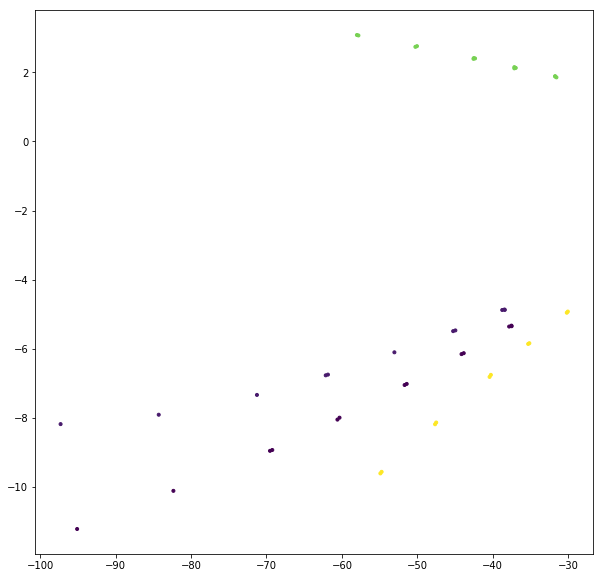

In [37]:
for event_id, hits, cells, particles, truth in load_dataset(path_to_train, skip=10, nevents=1):
    # Track pattern recognition
    truth = pd.merge(truth, particles, how='left', on='particle_id')
    hits = pd.merge(hits, truth, how='left', on='hit_id')
    hits['track_id'] = mylabels[event_id]
    hits = hits.dropna()
#     truth = truth.dropna()
    hits = hits[(hits.particle_id == 211675367239319552) | (hits.particle_id == 689056171826348032) |
               (hits.particle_id == 729583345792450560) | (hits.particle_id == 698059110473531392)]
#     print(hits.head())
    figure = plt.figure(figsize=(10,10))
    
    plt.scatter(hits.x, hits.y, marker='.', c=hits['track_id'])
    plt.show()

In [38]:
hits.shape

(47, 24)

In [39]:
hits

,hit_id,x,y,z,volume_id,layer_id,module_id,particle_id,tx,ty,...,weight,vx,vy,vz,px,py,pz,q,nhits,track_id
0,1,-95.104897,-11.22140,-1502.5,7,2,1,211675367239319552,-95.111397,-11.19950,...,0.000011,-0.007711,0.007799,1.224690,-0.655410,-0.105077,-10.50140,1.0,13.0,1211
1,2,-54.898102,-9.61188,-1502.5,7,2,1,689056171826348032,-54.898602,-9.58850,...,0.000017,-0.003322,-0.019750,3.356830,-0.820384,-0.124732,-22.39010,-1.0,10.0,1479
2,3,-58.008400,3.08322,-1502.5,7,2,1,729583345792450560,-57.987900,3.07949,...,0.000018,0.000378,-0.007446,0.698072,-1.156670,0.077993,-29.99840,-1.0,13.0,1424
3,4,-97.298401,-8.18418,-1502.5,7,2,1,698059110473531392,-97.308502,-8.20599,...,0.000010,0.002819,-0.018116,-5.299510,-0.406458,-0.063105,-6.29345,1.0,11.0,1229
36,37,-54.732201,-9.56629,-1498.0,7,2,4,689056171826348032,-54.736099,-9.55671,...,0.000014,-0.003322,-0.019750,3.356830,-0.820384,-0.124732,-22.39010,-1.0,10.0,1479
1164,1165,-57.809200,3.07012,-1497.5,7,2,106,729583345792450560,-57.794701,3.07183,...,0.000016,0.000378,-0.007446,0.698072,-1.156670,0.077993,-29.99840,-1.0,13.0,1424
1183,1184,-82.340599,-10.11660,-1302.5,7,4,1,211675367239319552,-82.335899,-10.13060,...,0.000010,-0.007711,0.007799,1.224690,-0.655410,-0.105077,-10.50140,1.0,13.0,1211
1191,1192,-47.645000,-8.18843,-1302.5,7,4,1,689056171826348032,-47.668400,-8.17432,...,0.000010,-0.003322,-0.019750,3.356830,-0.820384,-0.124732,-22.39010,-1.0,10.0,1479
1196,1197,-50.254299,2.74054,-1302.5,7,4,1,729583345792450560,-50.263199,2.75554,...,0.000013,0.000378,-0.007446,0.698072,-1.156670,0.077993,-29.99840,-1.0,13.0,1424
1197,1198,-84.285896,-7.91239,-1302.5,7,4,1,698059110473531392,-84.291702,-7.89153,...,0.000009,0.002819,-0.018116,-5.299510,-0.406458,-0.063105,-6.29345,1.0,11.0,1229


In [41]:
hits.sort_values('track_id', inplace=True)

In [42]:
hits

,hit_id,x,y,z,volume_id,layer_id,module_id,particle_id,tx,ty,...,weight,vx,vy,vz,px,py,pz,q,nhits,track_id
0,1,-95.104897,-11.22140,-1502.5,7,2,1,211675367239319552,-95.111397,-11.19950,...,0.000011,-0.007711,0.007799,1.224690,-0.655410,-0.105077,-10.50140,1.0,13.0,1211
13457,13458,-37.495998,-5.34959,-597.5,7,14,106,211675367239319552,-37.504799,-5.34119,...,0.000018,-0.007711,0.007799,1.224690,-0.655410,-0.105077,-10.50140,1.0,13.0,1211
2634,2635,-69.230499,-8.93337,-1098.0,7,6,4,211675367239319552,-69.250298,-8.92269,...,0.000005,-0.007711,0.007799,1.224690,-0.655410,-0.105077,-10.50140,1.0,13.0,1211
4334,4335,-60.315102,-7.99790,-958.0,7,8,4,211675367239319552,-60.317001,-8.00172,...,0.000005,-0.007711,0.007799,1.224690,-0.655410,-0.105077,-10.50140,1.0,13.0,1211
2617,2618,-69.533401,-8.95814,-1102.5,7,6,1,211675367239319552,-69.537697,-8.95117,...,0.000008,-0.007711,0.007799,1.224690,-0.655410,-0.105077,-10.50140,1.0,13.0,1211
6305,6306,-51.684200,-7.05183,-822.5,7,10,1,211675367239319552,-51.702099,-7.03926,...,0.000005,-0.007711,0.007799,1.224690,-0.655410,-0.105077,-10.50140,1.0,13.0,1211
6339,6340,-51.409698,-7.02033,-818.0,7,10,4,211675367239319552,-51.417301,-7.00649,...,0.000008,-0.007711,0.007799,1.224690,-0.655410,-0.105077,-10.50140,1.0,13.0,1211
8645,8646,-44.137402,-6.15696,-702.5,7,12,1,211675367239319552,-44.129902,-6.15418,...,0.000010,-0.007711,0.007799,1.224690,-0.655410,-0.105077,-10.50140,1.0,13.0,1211
1183,1184,-82.340599,-10.11660,-1302.5,7,4,1,211675367239319552,-82.335899,-10.13060,...,0.000010,-0.007711,0.007799,1.224690,-0.655410,-0.105077,-10.50140,1.0,13.0,1211
11057,11058,-37.824200,-5.35918,-602.5,7,14,1,211675367239319552,-37.820099,-5.38024,...,0.000013,-0.007711,0.007799,1.224690,-0.655410,-0.105077,-10.50140,1.0,13.0,1211


In [35]:
#leaf size 100
path_to_train = "../data/train"
dataset_submissions = []
dataset_scores = []
rz_scales[0] = 0.6
rz_scales[1] = 0.9
rz_scales[2] = 1.4
mylabels = {}
for event_id, hits, cells, particles, truth in load_dataset(path_to_train, skip=10, nevents=10):
    # Track pattern recognition
    model = Clusterer1()
    labels = model.predict(hits)
    mylabels[event_id] = labels
    # Prepare submission for an event
    one_submission = create_one_event_submission(event_id, hits, labels)
    dataset_submissions.append(one_submission)

    # Score for the event
    score = score_event(truth, one_submission)
    dataset_scores.append(score)

    print("Score for event %d: %.9f" % (event_id, score))
print('Mean score: %.9f' % (np.mean(dataset_scores)))

100%|██████████| 8054/8054 [00:00<00:00, 141620.09it/s]


Score for event 1010: 0.245642036


100%|██████████| 9071/9071 [00:00<00:00, 135324.67it/s]


Score for event 1011: 0.242548528


100%|██████████| 8531/8531 [00:00<00:00, 138658.84it/s]


Score for event 1012: 0.257421081


100%|██████████| 8202/8202 [00:00<00:00, 131136.95it/s]


Score for event 1013: 0.256984043


100%|██████████| 9740/9740 [00:00<00:00, 124998.92it/s]


Score for event 1014: 0.239064354


100%|██████████| 9405/9405 [00:00<00:00, 125534.40it/s]


Score for event 1015: 0.247632339


100%|██████████| 8922/8922 [00:00<00:00, 131931.51it/s]


Score for event 1016: 0.255595864


100%|██████████| 9483/9483 [00:00<00:00, 120311.03it/s]


Score for event 1017: 0.237219388


100%|██████████| 7128/7128 [00:00<00:00, 125052.80it/s]


Score for event 1018: 0.259765510


100%|██████████| 9458/9458 [00:00<00:00, 128398.03it/s]


Score for event 1019: 0.233311222
Mean score: 0.247518436


In [36]:
hits.shape

(122849, 10)

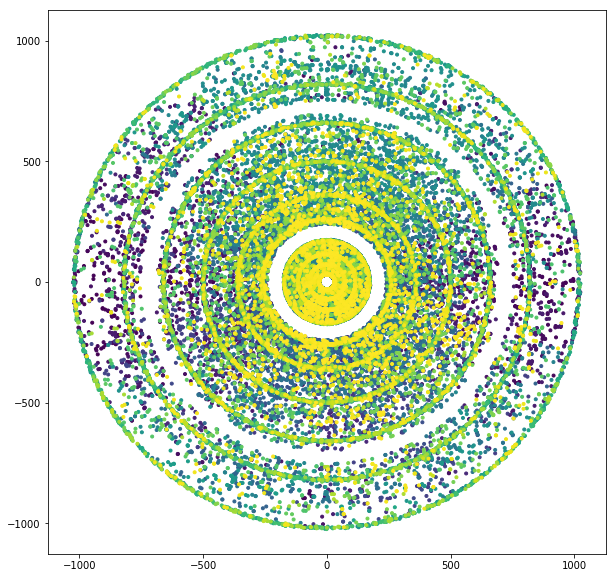

In [50]:
for event_id, hits, cells, particles, truth in load_dataset(path_to_train, skip=10, nevents=1):
    # Track pattern recognition
    truth = pd.merge(truth, particles, how='left', on='particle_id')
    hits = pd.merge(hits, truth, how='left', on='hit_id')
    hits['track_id'] = mylabels[event_id]
    hits = hits.dropna()
    hits.sort_values('track_id', inplace=True)
# #     truth = truth.dropna()
# #     hits = hits[(hits.particle_id == 211675367239319552) | (hits.particle_id == 689056171826348032) |
# #                (hits.particle_id == 729583345792450560) | (hits.particle_id == 698059110473531392)]
# #     print(hits.head())
    figure = plt.figure(figsize=(10,10))
    
    plt.scatter(hits.x, hits.y, marker='.', c=hits['track_id'])
    plt.show()

100%|██████████| 8054/8054 [00:00<00:00, 268860.08it/s]


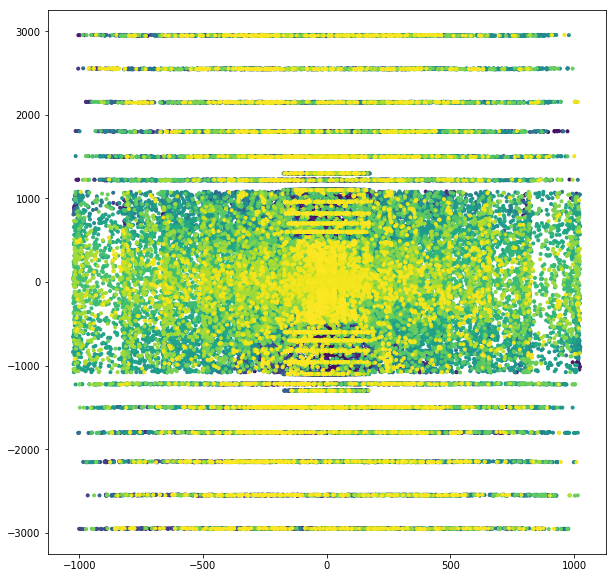

In [16]:
#leaf size 100
path_to_train = "../data/train"
dataset_submissions = []
dataset_scores = []

mylabels = {}
for event_id, hits, cells, particles, truth in load_dataset(path_to_train, skip=10, nevents=1):
    # Track pattern recognition
    model = Clusterer1()
    labels = model.predict(hits)
    mylabels[event_id] = labels
    # Prepare submission for an event
    
    hits['track_id'] = mylabels[event_id]
    hits = hits.dropna()
    hits.sort_values('track_id', inplace=True)

    figure = plt.figure(figsize=(10,10))
    
    plt.scatter(hits.y, hits.z, marker='.', c=hits['track_id'])
    plt.show()

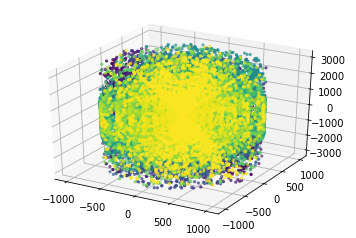

In [17]:
path_to_train = "../data/train"
dataset_submissions = []
dataset_scores = []

# mylabels = {}
for event_id, hits, cells, particles, truth in load_dataset(path_to_train, skip=10, nevents=1):
    # Track pattern recognition
    
#     labels = mylabels[event_id] 
    # Prepare submission for an event
    
    hits['track_id'] = mylabels[event_id]
    hits = hits.dropna()
    hits.sort_values('track_id', inplace=True)

    figure = plt.figure(figsize=(10,10))
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(hits.x, hits.y, hits.z, marker='.',c=hits['track_id'])

In [51]:
hits.head(500)

,hit_id,x,y,z,volume_id,layer_id,module_id,particle_id,tx,ty,...,weight,vx,vy,vz,px,py,pz,q,nhits,track_id
1110,1111,-42.819199,14.191500,-1498.000000,7,2,101,689065929992044544,-42.827900,14.210200,...,0.000012,-24.796499,3.665800,-963.043030,-0.355523,0.215100,-10.587800,-1.0,4.0,1
3931,3932,-8.943130,31.360800,-1097.500000,7,6,85,477402176344293376,-8.960100,31.361300,...,0.000000,5.711770,-4.805970,-182.473999,-0.030922,0.105888,-2.567630,-1.0,1.0,1
2558,2559,-36.234402,10.421700,-1302.000000,7,4,104,689065929992044544,-36.218700,10.431900,...,0.000022,-24.796499,3.665800,-963.043030,-0.355523,0.215100,-10.587800,-1.0,4.0,1
1135,1136,-42.952301,14.297000,-1502.000000,7,2,104,689065929992044544,-42.962502,14.286700,...,0.000025,-24.796499,3.665800,-963.043030,-0.355523,0.215100,-10.587800,-1.0,4.0,1
2524,2525,-36.063099,10.364700,-1298.000000,7,4,101,689065929992044544,-36.083698,10.353600,...,0.000041,-24.796499,3.665800,-963.043030,-0.355523,0.215100,-10.587800,-1.0,4.0,1
102372,102373,-891.265015,7.858520,1502.500000,18,4,98,45038332735913984,-888.244019,7.648060,...,0.000008,-0.019815,-0.022444,-3.649950,-0.278384,0.256922,0.582891,-1.0,12.0,4
64171,64172,-259.247986,-0.311941,445.399994,13,2,561,562957306405322752,-259.247986,-0.319426,...,0.000007,0.024349,-0.002839,8.537970,-0.535512,0.075634,0.906334,-1.0,9.0,4
76855,76856,-503.989014,5.159830,852.500000,13,6,1482,4506485845393408,-503.988007,5.163800,...,0.000008,-0.009375,-0.004808,8.773490,-0.617526,0.155023,1.046040,-1.0,11.0,4
76857,76858,-503.535004,7.516510,863.299988,13,6,1482,454865486509768704,-503.532013,7.532960,...,0.000005,0.008567,-0.004933,5.239280,-0.222161,0.148305,0.423678,-1.0,12.0,4
102369,102370,-881.192017,10.615500,1494.500000,18,4,97,45038332735913984,-884.447998,10.837500,...,0.000006,-0.019815,-0.022444,-3.649950,-0.278384,0.256922,0.582891,-1.0,12.0,4


In [1]:
mylabels

NameError: name 'mylabels' is not defined

In [18]:
scores = []
for e in train:
    hits, cells, truth = load_event(e, parts=['hits', 'cells', 'truth'])
    hits['event_id'] = int(e[-9:])
#     hits = norm_points(hits)
    for m in ['test']: #Tuning/Grid Search
        print(m)
        try:
#             dbscan = hdbscan.HDBSCAN(min_samples=1, min_cluster_size=7, cluster_selection_method='leaf', prediction_data=False, metric=m)
            cl = Clusterer2()
#             hits['track_id'] = dbscan.fit_predict(scl.fit_transform(hits[['x2', 'y2', 'z2']].values))
            hits['track_id'] = cl.predict(hits)
            score = score_event(truth, hits[['event_id','hit_id','track_id']])
            print(m, len(truth['particle_id'].unique()), len(hits['track_id'].unique()), score)
            scores.append([score, m])
        except:
            print("ERROR:", m)
#         break #Remove to test all
    break #Remove to test more samples
print(sorted(scores, reverse=True))

test


100%|██████████| 9409/9409 [00:00<00:00, 276726.24it/s]


test 10566 9409 0.22449410636608788
[[0.22449410636608788, 'test']]


In [22]:
scores = []
for e in train:
    hits, cells, truth = load_event(e, parts=['hits', 'cells', 'truth'])
    hits['event_id'] = int(e[-9:])
    hits = norm_points2(hits)
    for m in l: #Tuning/Grid Search
        print(m)
        try:
            dbscan = hdbscan.HDBSCAN(min_samples=1, min_cluster_size=7, cluster_selection_method='leaf', prediction_data=False, metric=m)
#             cl = Clusterer2()
            hits['track_id'] = dbscan.fit_predict(scl.fit_transform(hits[['x2', 'y2', 'z2']].values))
#             hits['track_id'] = cl.predict(hits)
            score = score_event(truth, hits[['event_id','hit_id','track_id']])
            print(m, len(truth['particle_id'].unique()), len(hits['track_id'].unique()), score)
            scores.append([score, m])
        except:
            print("ERROR:", m)
#         break #Remove to test all
    break #Remove to test more samples
print(sorted(scores, reverse=True))

arccos
ERROR: arccos
braycurtis
braycurtis 10566 7707 0.22258059254117302
canberra
canberra 10566 7535 0.1748737263608514
chebyshev
chebyshev 10566 7676 0.21601185743639062
cityblock
cityblock 10566 7710 0.2229077573490329
cosine
ERROR: cosine
dice
ERROR: dice
euclidean
euclidean 10566 7695 0.22157339286539707
hamming
hamming 10566 8 4.99364421308516e-05
haversine
ERROR: haversine
infinity
infinity 10566 7676 0.21601185743639062
jaccard
ERROR: jaccard
kulsinski
ERROR: kulsinski
l1
l1 10566 7710 0.2229077573490329
l2
l2 10566 7695 0.22157339286539707
mahalanobis
ERROR: mahalanobis
manhattan
manhattan 10566 7710 0.2229077573490329
matching
ERROR: matching
minkowski
ERROR: minkowski
p
p 10566 7695 0.22157339286539707
pyfunc
ERROR: pyfunc
rogerstanimoto
ERROR: rogerstanimoto
russellrao
ERROR: russellrao
seuclidean
ERROR: seuclidean
sokalmichener
ERROR: sokalmichener
sokalsneath
ERROR: sokalsneath
wminknowski
ERROR: wminknowski
[[0.2229077573490329, 'manhattan'], [0.2229077573490329, 'l1'],

In [24]:
scores = []
for e in train:
    hits, cells, truth = load_event(e, parts=['hits', 'cells', 'truth'])
    hits['event_id'] = int(e[-9:])
#     hits = norm_points(hits)
    for m in l: #Tuning/Grid Search
        print(m)
        try:
#             dbscan = hdbscan.HDBSCAN(min_samples=1, min_cluster_size=7, cluster_selection_method='leaf', prediction_data=False, metric=m)
            cl = Clusterer3(m)
#             hits['track_id'] = dbscan.fit_predict(scl.fit_transform(hits[['x2', 'y2', 'z2']].values))
            hits['track_id'] = cl.predict(hits)
            score = score_event(truth, hits[['event_id','hit_id','track_id']])
            print(m, len(truth['particle_id'].unique()), len(hits['track_id'].unique()), score)
            scores.append([score, m])
        except:
            print("ERROR:", m)
#         break #Remove to test all
    break #Remove to test more samples
print(sorted(scores, reverse=True))

arccos
ERROR: arccos
braycurtis


100%|██████████| 9409/9409 [00:00<00:00, 384997.87it/s]


braycurtis 10566 9408 0.22422647123963182
canberra


100%|██████████| 9361/9361 [00:00<00:00, 320597.05it/s]


canberra 10566 9360 0.1770272502027709
chebyshev


100%|██████████| 9349/9349 [00:00<00:00, 377875.79it/s]


chebyshev 10566 9348 0.21942009829710113
cityblock


100%|██████████| 9411/9411 [00:00<00:00, 375161.29it/s]


cityblock 10566 9410 0.22452392550680997
cosine
ERROR: cosine
dice
ERROR: dice
euclidean


100%|██████████| 9356/9356 [00:00<00:00, 379093.93it/s]


euclidean 10566 9356 0.22383100415207874
hamming


100%|██████████| 8/8 [00:00<00:00, 27822.91it/s]


ERROR: hamming
haversine
ERROR: haversine
infinity


100%|██████████| 9349/9349 [00:00<00:00, 276639.54it/s]


infinity 10566 9348 0.21942009829710113
jaccard
ERROR: jaccard
kulsinski
ERROR: kulsinski
l1


100%|██████████| 9411/9411 [00:00<00:00, 387521.92it/s]


l1 10566 9410 0.22452392550680997
l2


100%|██████████| 9356/9356 [00:00<00:00, 394656.79it/s]


l2 10566 9356 0.22383100415207874
mahalanobis
ERROR: mahalanobis
manhattan


100%|██████████| 9411/9411 [00:00<00:00, 390856.47it/s]


manhattan 10566 9410 0.22452392550680997
matching
ERROR: matching
minkowski
ERROR: minkowski
p


100%|██████████| 9356/9356 [00:00<00:00, 374481.42it/s]


p 10566 9356 0.22383100415207874
pyfunc
ERROR: pyfunc
rogerstanimoto
ERROR: rogerstanimoto
russellrao
ERROR: russellrao
seuclidean
ERROR: seuclidean
sokalmichener
ERROR: sokalmichener
sokalsneath
ERROR: sokalsneath
wminknowski
ERROR: wminknowski
[[0.22452392550680997, 'manhattan'], [0.22452392550680997, 'l1'], [0.22452392550680997, 'cityblock'], [0.22422647123963182, 'braycurtis'], [0.22383100415207874, 'p'], [0.22383100415207874, 'l2'], [0.22383100415207874, 'euclidean'], [0.21942009829710113, 'infinity'], [0.21942009829710113, 'chebyshev'], [0.1770272502027709, 'canberra']]


In [18]:
scores = []
for e in train:
    hits, cells, truth = load_event(e, parts=['hits', 'cells', 'truth'])
    hits['event_id'] = int(e[-9:])
    hits = norm_points3(hits)
    for m in l: #Tuning/Grid Search
        print(m)
        try:
            dbscan = hdbscan.HDBSCAN(min_samples=1, min_cluster_size=7, cluster_selection_method='leaf', prediction_data=False, metric=m)
#             cl = Clusterer2()
            hits['track_id'] = dbscan.fit_predict(scl.fit_transform(hits[['x2', 'z2']].values))
#             hits['track_id'] = cl.predict(hits)
            score = score_event(truth, hits[['event_id','hit_id','track_id']])
            print(m, len(truth['particle_id'].unique()), len(hits['track_id'].unique()), score)
            scores.append([score, m])
        except:
            print("ERROR:", m)
#         break #Remove to test all
    break #Remove to test more samples
print(sorted(scores, reverse=True))

arccos
ERROR: arccos
braycurtis
braycurtis 10566 8377 0.0
canberra
canberra 10566 8650 0.0
chebyshev
chebyshev 10566 8411 0.0
cityblock
cityblock 10566 8374 0.0
cosine
ERROR: cosine
dice
ERROR: dice
euclidean
euclidean 10566 8456 0.0
hamming
hamming 10566 1317 0.0
haversine
haversine 10566 8381 0.0
infinity
infinity 10566 8411 0.0
jaccard
ERROR: jaccard
kulsinski
ERROR: kulsinski
l1
l1 10566 8374 0.0
l2
l2 10566 8456 0.0
mahalanobis
ERROR: mahalanobis
manhattan
manhattan 10566 8374 0.0
matching
ERROR: matching
minkowski
ERROR: minkowski
p
p 10566 8456 0.0
pyfunc
ERROR: pyfunc
rogerstanimoto
ERROR: rogerstanimoto
russellrao
ERROR: russellrao
seuclidean
ERROR: seuclidean
sokalmichener
ERROR: sokalmichener
sokalsneath
ERROR: sokalsneath
wminknowski
ERROR: wminknowski
[[0.0, 'p'], [0.0, 'manhattan'], [0.0, 'l2'], [0.0, 'l1'], [0.0, 'infinity'], [0.0, 'haversine'], [0.0, 'hamming'], [0.0, 'euclidean'], [0.0, 'cityblock'], [0.0, 'chebyshev'], [0.0, 'canberra'], [0.0, 'braycurtis']]


In [19]:
particles.head()

,particle_id,vx,vy,vz,px,py,pz,q,nhits
0,4503805785800704,-0.009375,-0.004808,8.77349,-7.712350,24.136200,-7.572210,-1,12
1,4503943224754176,-0.009375,-0.004808,8.77349,19.816601,-7.746410,66.998199,1,11
2,4504011944230912,-0.009375,-0.004808,8.77349,2.567960,-0.827171,9.292110,1,11
3,4504080663707648,-0.009375,-0.004808,8.77349,2.307620,-3.136100,11.203400,1,15
4,4504149383184384,-0.009375,-0.004808,8.77349,0.919817,-0.527999,2.873910,-1,13


In [21]:
particles['p_t'] = np.sqrt(particles['px']**2 + particles['py']**2)

In [22]:
particles.head()

,particle_id,vx,vy,vz,px,py,pz,q,nhits,p_t
0,4503805785800704,-0.009375,-0.004808,8.77349,-7.712350,24.136200,-7.572210,-1,12,25.338440
1,4503943224754176,-0.009375,-0.004808,8.77349,19.816601,-7.746410,66.998199,1,11,21.276854
2,4504011944230912,-0.009375,-0.004808,8.77349,2.567960,-0.827171,9.292110,1,11,2.697894
3,4504080663707648,-0.009375,-0.004808,8.77349,2.307620,-3.136100,11.203400,1,15,3.893615
4,4504149383184384,-0.009375,-0.004808,8.77349,0.919817,-0.527999,2.873910,-1,13,1.060588


In [80]:
scores = []
path_to_train = "../data/train"
for e, hits, cells, particles, truth in load_dataset(path_to_train, skip=10, nevents=1):
#     hits, cells, truth, particles = load_event(e, parts=['hits', 'cells', 'truth', 'particles'])
    hits['event_id'] = e
    hits = norm_points(hits)
    for m in l: #Tuning/Grid Search
        if m not in ['braycurtis']:
            continue
        print(m)
        try:
            truth = pd.merge(truth, particles, how='left', on='particle_id')
            hits = pd.merge(hits, truth, how='left', on='hit_id')
            hits = hits.fillna(0)
        
            p1 = np.sqrt(hits['px']**2 + hits['py']**2)
            print('p1={}'.format(p1))
            p = np.sqrt(hits['px']**2 + hits['py']**2 + hits['pz']**2)
            print('p={}'.format(p))
            hits['x2'] = hits['x2'] + p
            hits['y2'] = hits['y2'] + p
            hits['z2'] = hits['z2'] + p
            dbscan = hdbscan.HDBSCAN(min_samples=1, min_cluster_size=7, cluster_selection_method='leaf', prediction_data=False, metric=m)
#             cl = Clusterer2()
            hits['track_id'] = dbscan.fit_predict(scl.fit_transform(hits[['x2', 'y2', 'z2']].values))
#             hits['track_id'] = cl.predict(hits)
            score = score_event(truth, hits[['event_id','hit_id','track_id']])
            print(m, len(truth['particle_id'].unique()), len(hits['track_id'].unique()), score)
            scores.append([score, m])
        except e:
            print("ERROR:", e)
#         break #Remove to test all
    break #Remove to test more samples
print(sorted(scores, reverse=True))

braycurtis
p1=0         0.663780
1         0.829812
2         1.159297
3         0.411328
4         0.000000
5         0.346704
6         0.394621
7         0.380948
8         0.270713
9         0.153969
10        1.361725
11        0.256177
12        0.661991
13        0.375536
14        0.391802
15        1.346325
16        0.000000
17        1.064156
18        0.391802
19        0.502699
20        0.410878
21        0.350094
22        1.231502
23        1.346325
24        0.675606
25        0.454264
26        0.529817
27        1.361725
28        0.475367
29        0.380948
            ...   
104054    0.000000
104055    0.333428
104056    0.264967
104057    0.000000
104058    0.000000
104059    4.122049
104060    0.000000
104061    0.333428
104062    0.308404
104063    0.274063
104064    1.836860
104065    4.122049
104066    0.775324
104067    0.231715
104068    0.000000
104069    0.332230
104070    0.375996
104071    0.155695
104072    0.478500
104073    0.926735
104074    0.00000

In [39]:
def preprocess1(hits):
    x = hits.x.values
    y = hits.y.values
    z = hits.z.values

    r = np.sqrt(x**2 + y**2 + z**2)
    hits['x2'] = x/r
    hits['y2'] = y/r

    r = np.sqrt(x**2 + y**2)
    hits['z2'] = z/r

    rho = np.sqrt(x**2 + y**2 + z**2)
    theta = np.degrees(np.arctan2(y,x))

    phi = np.degrees(np.arctan2(r,z))

    hits['rho'] = rho
    hits['theta'] = theta
    hits['phi'] = phi

    #         ss = StandardScaler()
    #         X = ss.fit_transform(hits[['p', 'y2', 'z2']].values)
    X = hits[['phi', 'theta', 'rho']].values
    return X

def preprocess2(hits):
        
        x = hits.x.values
        y = hits.y.values
        z = hits.z.values

        r = np.sqrt(x**2 + y**2)
        hits['x2'] = r
#         hits['y2'] = y/r

#         r = np.sqrt(x**2 + y**2)
        hits['z2'] = z

        X = hits[['x2', 'z2']].values
        return X
    
def preprocess3(hits):
        
        x = hits.x.values
        y = hits.y.values
        z = hits.z.values

        r = np.sqrt(x**2 + y**2)
        hits['z2'] = np.log(r)
#         hits['z2'] = z

#         rho = np.sqrt(x**2 + y**2 + z**2)
        theta = np.arctan2(hits['y'],hits['x'])
        hits['theta'] = theta

        X = hits[['theta', 'z2']].values
        return X

In [41]:
scores = []
path_to_train = "../data/train"
for e, hits, cells, particles, truth in load_dataset(path_to_train, skip=10, nevents=1):
#     hits, cells, truth, particles = load_event(e, parts=['hits', 'cells', 'truth', 'particles'])
    hits['event_id'] = e
    hits = norm_points(hits)
    for m in l: #Tuning/Grid Search
        if m not in ['braycurtis']:
            continue
        print(m)
        try:
            truth = pd.merge(truth, particles, how='left', on='particle_id')
            hits = pd.merge(hits, truth, how='left', on='hit_id')
            hits = hits.fillna(0)
            X = preprocess3(hits)
            dbscan = hdbscan.HDBSCAN(min_samples=1, min_cluster_size=7, cluster_selection_method='leaf', prediction_data=False, metric=m)
#             cl = Clusterer2()
            hits['track_id'] = dbscan.fit_predict(scl.fit_transform(X))
#             hits['track_id'] = cl.predict(hits)
            score = score_event(truth, hits[['event_id','hit_id','track_id']])
            print('{},{},{},{:.6f}'.format(m,len(truth['particle_id'].unique()), len(hits['track_id'].unique()), 
                                           score))
            scores.append([score, m])
        except e:
            print("ERROR:", e)
#         break #Remove to test all
    break #Remove to test more samples
print(sorted(scores, reverse=True))

braycurtis
braycurtis,8741,6877,0.000000
[[0.0, 'braycurtis']]


In [226]:
scores = []
path_to_train = "../data/train"
for e, hits, cells, particles, truth in load_dataset(path_to_train, skip=10, nevents=1):
#     hits, cells, truth, particles = load_event(e, parts=['hits', 'cells', 'truth', 'particles'])
    hits['event_id'] = e
    hits = norm_points(hits)
    for m in l: #Tuning/Grid Search
        if m not in ['braycurtis']:
            continue
        print(m)
        try:
            truth = pd.merge(truth, particles, how='left', on='particle_id')
            hits = pd.merge(hits, truth, how='left', on='hit_id')
            hits = hits.fillna(0)
            x = hits.x.values
            y = hits.y.values
            z = hits.z.values
    
            r = np.sqrt(x**2 + y**2 + z**2)
            hits['x2'] = x/r
            hits['y2'] = y/r

#             r = np.sqrt(x**2 + y**2 + z**2)
            hits['z2'] = z/r
            p = np.sqrt(hits['x2']**2 + hits['y2']**2 + hits['z2'] ** 2)
            hits['x2'] = hits['x2'] + p
            hits['y2'] = hits['y2'] + p
            hits['z2'] = hits['z2'] + p
            dbscan = hdbscan.HDBSCAN(min_samples=1, min_cluster_size=7, cluster_selection_method='leaf', prediction_data=False, metric=m)
#             cl = Clusterer2()
            labels = dbscan.fit_predict(scl.fit_transform(hits[['x2', 'y2', 'z2']].values)) + 1
            _, inverse, counts = np.unique(labels, return_inverse=True, return_counts=True)
            counts = counts[inverse]
            counts[labels == -1] = 0
            counts[counts > 20] = 0
            labels[labels == -1] = 0
            labels[counts > 20] = 0
            hits['track_id'] = labels
            
            score = score_event(truth, hits[['event_id','hit_id','track_id']])
            print(m, len(truth['particle_id'].unique()), len(hits['track_id'].unique()), score)
            scores.append([score, m])
        except e:
            print("ERROR:", e)
#         break #Remove to test all
    break #Remove to test more samples
print(sorted(scores, reverse=True))

braycurtis
braycurtis 8741 6649 0.22005948647529294
[[0.22005948647529294, 'braycurtis']]


In [91]:
labels

array([4191, 6087, 4451, ...,    0, 3595,    0])

In [92]:
counts

array([13, 10, 13, ...,  0, 15,  0])

In [50]:
# Apply code for an example
x = np.r_[36, 36, 19, 18, 33, 26]
y = np.r_[14, 10, 28, 31, 18, 26]
comp_curv = ComputeCurvature()
curvature = comp_curv.fit(x, y)

In [51]:
curvature

0.03656252441356508

In [52]:
R = 1/curvature 

In [53]:
R

27.350409087972864

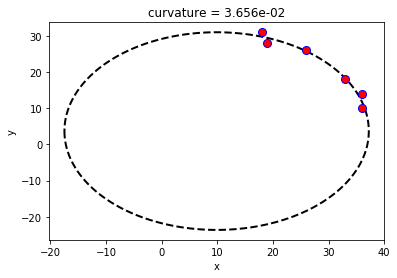

In [54]:
# Plot the result
theta_fit = np.linspace(-np.pi, np.pi, 180)
x_fit = comp_curv.xc + comp_curv.r*np.cos(theta_fit)
y_fit = comp_curv.yc + comp_curv.r*np.sin(theta_fit)
plt.plot(x_fit, y_fit, 'k--', label='fit', lw=2)
plt.plot(x, y, 'ro', label='data', ms=8, mec='b', mew=1)
plt.xlabel('x')
plt.ylabel('y')
plt.title('curvature = {:.3e}'.format(curvature))
plt.show()

In [93]:
pd.set_option('display.max_columns', 0)
hits.sort_values(['particle_id', 'hit_id'], inplace=True)
hits = hits[hits.particle_id != 0]
hits.head(50)

,hit_id,x,y,z,volume_id,layer_id,module_id,event_id,x2,y2,z2,particle_id,tx,ty,tz,tpx,tpy,tpz,weight,vx,vy,vz,px,py,pz,q,nhits,track_id
16687,16688,-9.743420,30.423500,-0.777225,8,2,109,1010,0.695090,1.952070,0.975678,4503805785800704,-9.744890,30.423000,-0.773363,-7.731330,24.129999,-7.571340,0.000066,-0.009375,-0.004808,8.77349,-7.712350,24.136200,-7.572210,-1.0,12.0,1341
18571,18572,-9.592730,29.951700,-0.621255,8,2,125,1010,0.695048,1.952163,0.980250,4503805785800704,-9.593780,29.951300,-0.625367,-7.730770,24.130199,-7.571460,0.000077,-0.009375,-0.004808,8.77349,-7.712350,24.136200,-7.572210,-1.0,12.0,1341
23959,23960,-22.017599,68.654198,-12.776200,8,4,218,1010,0.699302,1.937622,0.825513,4503805785800704,-22.015900,68.654999,-12.773900,-7.754630,24.121599,-7.572720,0.000055,-0.009375,-0.004808,8.77349,-7.712350,24.136200,-7.572210,-1.0,12.0,1613
30087,30088,-35.507198,110.550003,-25.930401,8,6,354,1010,0.701551,1.929207,0.782047,4503805785800704,-35.508400,110.549004,-25.928301,-7.778220,24.108400,-7.570310,0.000045,-0.009375,-0.004808,8.77349,-7.712350,24.136200,-7.572210,-1.0,12.0,1637
35716,35717,-52.860500,164.225006,-42.787102,8,8,531,1010,0.702612,1.923913,0.759284,4503805785800704,-52.860802,164.225006,-42.787399,-7.808680,24.097799,-7.570910,0.000039,-0.009375,-0.004808,8.77349,-7.712350,24.136200,-7.572210,-1.0,12.0,1637
62256,62257,-80.640900,249.615997,-70.000000,13,2,392,1010,0.702978,1.919403,0.742171,4503805785800704,-80.638496,249.615997,-69.613998,-7.862440,24.080500,-7.564810,0.000023,-0.009375,-0.004808,8.77349,-7.712350,24.136200,-7.572210,-1.0,12.0,1637
62277,62278,-78.742798,243.819000,-67.599998,13,2,393,1010,0.702842,1.920118,0.744893,4503805785800704,-78.746002,243.817993,-67.792900,-7.859370,24.081600,-7.564590,0.000029,-0.009375,-0.004808,8.77349,-7.712350,24.136200,-7.572210,-1.0,12.0,1637
68341,68342,-111.233002,342.915985,-98.800003,13,4,549,1010,0.702425,1.917381,0.735687,4503805785800704,-111.222000,342.916992,-98.935097,-7.919590,24.061001,-7.564400,0.000023,-0.009375,-0.004808,8.77349,-7.712350,24.136200,-7.572210,-1.0,12.0,1637
74205,74206,-154.401001,473.446991,-139.600006,13,6,765,1010,0.701459,1.915431,0.730077,4503805785800704,-154.421005,473.442993,-139.992004,-7.999060,24.034000,-7.563950,0.000023,-0.009375,-0.004808,8.77349,-7.712350,24.136200,-7.572210,-1.0,12.0,1637
79334,79335,-206.667999,629.393982,-188.600006,13,8,898,1010,0.699951,1.913780,0.726183,4503805785800704,-206.664993,629.395020,-189.104004,-8.094930,24.002001,-7.560410,0.000032,-0.009375,-0.004808,8.77349,-7.712350,24.136200,-7.572210,-1.0,12.0,1637


In [238]:
scores = []
path_to_train = "../data/train"
for e, hits, cells, particles, truth in load_dataset(path_to_train, skip=10, nevents=1):
#     hits, cells, truth, particles = load_event(e, parts=['hits', 'cells', 'truth', 'particles'])
    hits['event_id'] = e
    hits = norm_points(hits)
    for m in l: #Tuning/Grid Search
        if m not in ['braycurtis']:
            continue
        print(m)
        try:
            truth = pd.merge(truth, particles, how='left', on='particle_id')
            hits = pd.merge(hits, truth, how='left', on='hit_id')
            hits = hits.fillna(0)
            hits = hits[(hits.particle_id == 4503805785800704) | (hits.particle_id == 4503943224754176)
                       | (hits.particle_id == 4504011944230912)]
            
            p1 = np.sqrt(hits['px']**2 + hits['py']**2)
#             print('particle: {}, p1={}'.format(hits.particle_id, p1))
            p = np.sqrt(hits['px']**2 + hits['py']**2 + hits['pz']**2)
#             print('particle: {}, p={}'.format(hits.particle_id, p))
            hits['p1'] = p1
            hits['p'] =p
            hits['x2'] = hits['x2'] + p
            hits['y2'] = hits['y2'] + p
            hits['z2'] = hits['z2'] + p
            
            hits['phi'] = np.degrees(np.arctan2(hits['y2'], hits['x2']))
            dbscan = hdbscan.HDBSCAN(min_samples=1, min_cluster_size=7, cluster_selection_method='leaf', prediction_data=False, metric=m)
#             cl = Clusterer2()
            labels = dbscan.fit_predict(hits[['x2', 'y2', 'z2']].values)
            hits['track_id'] = labels
#             hits['track_id'] = cl.predict(hits)
            score = score_event(hits, hits[['event_id','hit_id','track_id']])
            print(m, len(truth['particle_id'].unique()), len(hits['track_id'].unique()), score)
            scores.append([score, m])
        except e:
            print("ERROR:", e)
#         break #Remove to test all
    break #Remove to test more samples
print(sorted(scores, reverse=True))

braycurtis
braycurtis 8741 3 1.0000000275433665
[[1.0000000275433665, 'braycurtis']]


In [239]:
hits

,hit_id,x,y,z,volume_id,layer_id,module_id,event_id,x2,y2,z2,particle_id,tx,ty,tz,tpx,tpy,tpz,weight,vx,vy,vz,px,py,pz,q,nhits,p1,p,phi,track_id
16687,16688,-9.743420,30.423500,-0.777225,8,2,109,1010,26.140785,27.397766,26.421366,4503805785800704,-9.744890,30.423000,-0.773363,-7.731330,24.129999,-7.571340,0.000066,-0.009375,-0.004808,8.77349,-7.712350,24.136200,-7.572210,-1.0,12.0,25.338440,26.445696,46.344944,1
18571,18572,-9.592730,29.951700,-0.621255,8,2,125,1010,26.140743,27.397860,26.425941,4503805785800704,-9.593780,29.951300,-0.625367,-7.730770,24.130199,-7.571460,0.000077,-0.009375,-0.004808,8.77349,-7.712350,24.136200,-7.572210,-1.0,12.0,25.338440,26.445696,46.345089,1
19334,19335,29.826000,-11.668600,109.644997,8,2,135,1010,70.556648,70.193390,73.719025,4503943224754176,29.820200,-11.680600,109.641998,19.809999,-7.763880,66.997902,0.000084,-0.009375,-0.004808,8.77349,19.816601,-7.746410,66.998199,1.0,11.0,21.276854,70.295540,44.852127,0
19371,19372,31.293800,-12.258200,114.628998,8,2,136,1010,70.557510,70.192924,73.706200,4503943224754176,31.293800,-12.258100,114.625999,19.809799,-7.764660,66.997803,0.000071,-0.009375,-0.004808,8.77349,19.816601,-7.746410,66.998199,1.0,11.0,21.276854,70.295540,44.851585,0
19388,19389,31.407200,-10.247100,122.593002,8,2,136,1010,9.923209,9.595136,13.386670,4504011944230912,31.407200,-10.247400,122.591003,2.560970,-0.845446,9.292100,0.000076,-0.009375,-0.004808,8.77349,2.567960,-0.827171,9.292110,1.0,11.0,2.697894,9.675843,44.037033,2
23959,23960,-22.017599,68.654198,-12.776200,8,4,218,1010,26.144999,27.383318,26.268490,4503805785800704,-22.015900,68.654999,-12.773900,-7.754630,24.121599,-7.572720,0.000055,-0.009375,-0.004808,8.77349,-7.712350,24.136200,-7.572210,-1.0,12.0,25.338440,26.445696,46.325237,1
26510,26511,68.857597,-22.779400,258.634003,8,4,335,1010,9.932190,9.591039,13.241845,4504011944230912,68.857903,-22.777399,258.639008,2.554000,-0.866496,9.291340,0.000064,-0.009375,-0.004808,8.77349,2.567960,-0.827171,9.292110,1.0,11.0,2.697894,9.675843,43.998909,2
26512,26513,68.237000,-26.763100,239.613998,8,4,335,1010,70.567863,70.188736,73.564590,4503943224754176,68.237099,-26.762600,239.608002,19.798300,-7.786050,66.998100,0.000057,-0.009375,-0.004808,8.77349,19.816601,-7.746410,66.998199,1.0,11.0,21.276854,70.295540,44.845669,0
30087,30088,-35.507198,110.550003,-25.930401,8,6,354,1010,26.147247,27.374903,26.222374,4503805785800704,-35.508400,110.549004,-25.928301,-7.778220,24.108400,-7.570310,0.000045,-0.009375,-0.004808,8.77349,-7.712350,24.136200,-7.572210,-1.0,12.0,25.338440,26.445696,46.313980,1
32780,32781,107.591003,-42.266899,372.824005,8,6,647,1010,70.571182,70.187256,73.520790,4503943224754176,107.591003,-42.266701,372.824005,19.787600,-7.809640,66.997902,0.000047,-0.009375,-0.004808,8.77349,19.816601,-7.746410,66.998199,1.0,11.0,21.276854,70.295540,44.843719,0


In [240]:
# Apply code for an example
x = hits[hits.particle_id == 4503805785800704].x.values
y = hits[hits.particle_id == 4503805785800704].y.values
phi = hits[hits.particle_id == 4503805785800704].phi.values
comp_curv = ComputeCurvature()
curvature = comp_curv.fit(x, y)

In [241]:
x

array([  -9.74342,   -9.59273,  -22.0176 ,  -35.5072 ,  -52.8605 ,
        -80.6409 ,  -78.7428 , -111.233  , -154.401  , -206.668  ,
       -256.991  , -322.487  ], dtype=float32)

In [242]:
phi

array([46.344944, 46.34509 , 46.325237, 46.31398 , 46.30728 , 46.302166,
       46.303062, 46.30066 , 46.29968 , 46.2996  , 46.300964, 46.301773],
      dtype=float32)

In [243]:
max(phi) - min(phi)

0.045490265

In [176]:
curvature

2.4110106334986946e-05

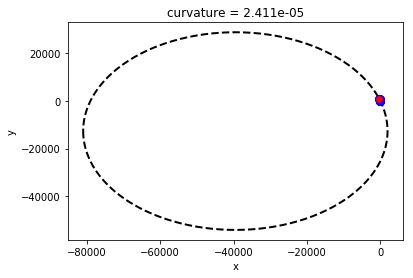

In [177]:
# Plot the result
theta_fit = np.linspace(-np.pi, np.pi, 360)
r = 1/curvature
x_fit = comp_curv.xc + comp_curv.r*np.cos(theta_fit)
y_fit = comp_curv.yc + comp_curv.r*np.sin(theta_fit)
plt.plot(x_fit, y_fit, 'k--', label='fit', lw=2)
plt.plot(x, y, 'ro', label='data', ms=8, mec='b', mew=1)
plt.xlabel('x')
plt.ylabel('y')
plt.title('curvature = {:.3e}'.format(curvature))
plt.show()

In [179]:
R = 1/curvature

In [180]:
R

41476.3828125

In [181]:
B = p/(0.3 * R)

In [182]:
B = (25.338440)/(0.3 * R)

In [183]:
B

0.002036374942542289

In [82]:
B = 0.002036374942542289

In [244]:
# Apply code for an example
x = hits[hits.particle_id == 4503943224754176].x.values
y = hits[hits.particle_id == 4503943224754176].y.values
phi = hits[hits.particle_id == 4503943224754176].phi.values
comp_curv = ComputeCurvature()
curvature = comp_curv.fit(x, y)

In [245]:
print(max(phi)-min(phi))

0.0124435425


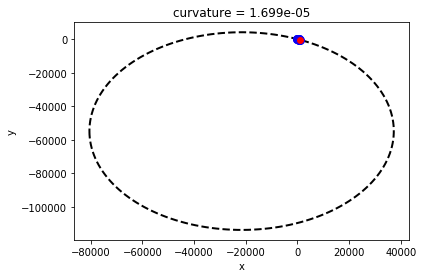

In [185]:
# Plot the result
theta_fit = np.linspace(-np.pi, np.pi, 180)
r = 1/curvature
x_fit = comp_curv.xc + comp_curv.r*np.cos(theta_fit)
y_fit = comp_curv.yc + comp_curv.r*np.sin(theta_fit)
plt.plot(x_fit, y_fit, 'k--', label='fit', lw=2)
plt.plot(x, y, 'ro', label='data', ms=8, mec='b', mew=1)
plt.xlabel('x')
plt.ylabel('y')
plt.title('curvature = {:.3e}'.format(curvature))
plt.show()

In [186]:
p =  0.2998 * B * r

In [187]:
p

35.940868458354124

In [188]:
p * 2

71.88173691670825

In [246]:
# Apply code for an example
x = hits[hits.particle_id == 4504011944230912].x.values
y = hits[hits.particle_id == 4504011944230912].y.values
phi = hits[hits.particle_id == 4504011944230912].phi.values
print(max(phi)-min(phi))
comp_curv = ComputeCurvature()
curvature = comp_curv.fit(x, y)

0.09738541


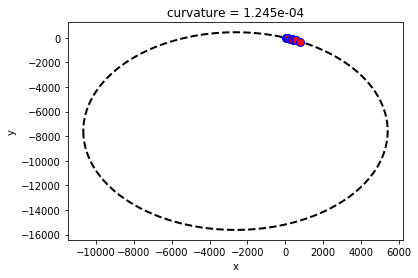

In [190]:
# Plot the result
theta_fit = np.linspace(-np.pi, np.pi, 180)
r = 1/curvature
x_fit = comp_curv.xc + comp_curv.r*np.cos(theta_fit)
y_fit = comp_curv.yc + comp_curv.r*np.sin(theta_fit)
plt.plot(x_fit, y_fit, 'k--', label='fit', lw=2)
plt.plot(x, y, 'ro', label='data', ms=8, mec='b', mew=1)
plt.xlabel('x')
plt.ylabel('y')
plt.title('curvature = {:.3e}'.format(curvature))
plt.show()

In [191]:
p =  0.2998 * B * r

In [192]:
p

4.902465624286435

In [193]:
p * 2

9.80493124857287

In [267]:
scores = []
for e in train:
    hits, cells, truth = load_event(e, parts=['hits', 'cells', 'truth'])
    hits['event_id'] = int(e[-9:])
    hits = norm_points(hits)
    for m in ['braycurtis']: #Tuning/Grid Search
        print(m)
        try:
            dbscan = hdbscan.HDBSCAN(min_samples=1, min_cluster_size=7, cluster_selection_method='leaf', prediction_data=False, metric=m)
            labels= dbscan.fit_predict(scl.fit_transform(hits[['x2', 'y2', 'z2']].values))
            
            hits['track_id'] = labels
            
            
            
            hits['track_id'] = hits['track_id'] + 1
            s = hits['track_id'].value_counts()
            hits['track_count'] = hits['track_id'].map(lambda x: s[x])
            hits['phi'] = np.degrees(np.arctan2(hits['y2'], hits['x2']))
#             hits.loc[hits.track_count > 20, 'track_id'] = 0
            score = score_event(truth, hits[['event_id','hit_id','track_id']])
            print(m, len(truth['particle_id'].unique()), len(hits['track_id'].unique()), score)
            scores.append([score, m])
            
            
        except e:
            print("ERROR:", e)
#         break #Remove to test all
    break #Remove to test more samples
print(sorted(scores, reverse=True))

braycurtis
braycurtis 10566 7799 0.2467095388172823
[[0.2467095388172823, 'braycurtis']]


In [268]:
tracks = hits.track_id.values

In [269]:
len(tracks)

120939

In [274]:
# Apply code for an example
x = hits[hits.track_id == 1].x.values
y = hits[hits.track_id == 1].y.values
phi = hits[hits.track_id == 1].phi.values
print(max(phi)-min(phi))
comp_curv = ComputeCurvature()
curvature = comp_curv.fit(x, y)

116.63813


In [275]:
s[1]

10

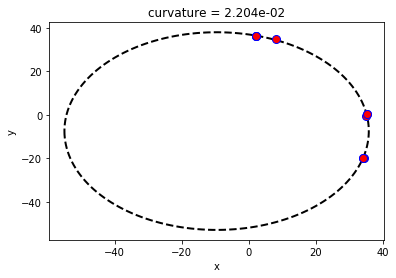

In [276]:
# Plot the result
theta_fit = np.linspace(-np.pi, np.pi, 180)
r = 1/curvature
x_fit = comp_curv.xc + comp_curv.r*np.cos(theta_fit)
y_fit = comp_curv.yc + comp_curv.r*np.sin(theta_fit)

plt.plot(x_fit, y_fit, 'k--', label='fit', lw=2)
plt.plot(x, y, 'ro', label='data', ms=8, mec='b', mew=1)
plt.xlabel('x')
plt.ylabel('y')
plt.title('curvature = {:.3e}'.format(curvature))
plt.show()

In [ ]:
x_fit.shape

In [ ]:
x.shape

In [17]:
scores = []
for e in train:
    hits, cells, truth, particles = load_event(e, parts=['hits', 'cells', 'truth', 'particles'])
    hits['event_id'] = int(e[-9:])
    truth = pd.merge(truth, particles, how='left', on='particle_id')
    hits = pd.merge(hits, truth, how='left', on='hit_id')
    hits = hits.fillna(0)
    hits = norm_points(hits)
    for m in ['braycurtis']: #Tuning/Grid Search
        print(m)
        try:
            dbscan = hdbscan.HDBSCAN(min_samples=1, min_cluster_size=7, cluster_selection_method='leaf', prediction_data=False, metric=m)
            labels= dbscan.fit_predict(scl.fit_transform(hits[['x2', 'y2', 'z2']].values))
            
            hits['track_id'] = labels
            
            
            
            hits['track_id'] = hits['track_id'] + 1
            s = hits['track_id'].value_counts()
            hits['track_count'] = hits['track_id'].map(lambda x: s[x])
            hits['phi'] = np.degrees(np.arctan2(hits['y2'], hits['x2']))
            hits.sort_values(['particle_id', 'z'], inplace=True)
            particle_list = list(set(hits.particle_id.values))
            for particle_id in particle_list:
                hits1 = hits[hits.particle_id == particle_id]
                phi_range = max(hits1['phi'].values) - min(hits1['phi'].values)
                hits.loc[hits.particle_id == particle_id, 'phi_range'] = phi_range
#             hits.loc[hits.track_count > 20, 'track_id'] = 0
            score = score_event(truth, hits[['event_id','hit_id','track_id']])
            print(m, len(truth['particle_id'].unique()), len(hits['track_id'].unique()), score)
            scores.append([score, m])
            
            
        except e:
            print("ERROR:", e)
#         break #Remove to test all
    break #Remove to test more samples
print(sorted(scores, reverse=True))

braycurtis
braycurtis 10566 7799 0.2467095388172823
[[0.2467095388172823, 'braycurtis']]


In [18]:
hits.head(10)

,hit_id,x,y,z,volume_id,layer_id,module_id,event_id,particle_id,tx,...,pz,q,nhits,x2,y2,z2,track_id,track_count,phi,phi_range
104752,104753,-949.559021,-294.209991,-2955.5,16,2,5,1000,0,-948.440979,...,0.0,0.0,0.0,-0.304521,-0.094352,-2.973061,0,24143,-162.785004,359.943176
104754,104755,-892.835999,-300.509003,-2955.5,16,2,5,1000,0,-892.435974,...,0.0,0.0,0.0,-0.287825,-0.096876,-3.137300,4710,18,-161.397873,359.943176
104756,104757,-859.585999,-234.567001,-2955.5,16,2,5,1000,0,-855.812988,...,0.0,0.0,0.0,-0.278463,-0.075988,-3.316999,4710,18,-164.736526,359.943176
104771,104772,-844.382019,-563.362000,-2955.5,16,2,9,1000,0,-840.937988,...,0.0,0.0,0.0,-0.270206,-0.180278,-2.911635,0,24143,-146.289230,359.943176
104772,104773,-824.549011,-458.750000,-2955.5,16,2,9,1000,0,-826.185974,...,0.0,0.0,0.0,-0.265772,-0.147866,-3.132238,4451,25,-150.909973,359.943176
104773,104774,-821.489990,-444.160004,-2955.5,16,2,9,1000,0,-819.880981,...,0.0,0.0,0.0,-0.265037,-0.143299,-3.164768,4451,25,-151.600952,359.943176
104794,104795,-610.330017,-662.031006,-2955.5,16,2,13,1000,0,-610.250000,...,0.0,0.0,0.0,-0.197542,-0.214276,-3.282293,4763,19,-132.673126,359.943176
104795,104796,-675.221008,-686.695007,-2955.5,16,2,13,1000,0,-676.403992,...,0.0,0.0,0.0,-0.217221,-0.220912,-3.068882,0,24143,-134.517288,359.943176
104842,104843,-285.667999,-866.995972,-2955.5,16,2,21,1000,0,-284.674988,...,0.0,0.0,0.0,-0.092352,-0.280285,-3.237676,0,24143,-108.236618,359.943176
104856,104857,-1.020000,-869.200012,-2955.5,16,2,25,1000,0,-1.068480,...,0.0,0.0,0.0,-0.000331,-0.282147,-3.400251,0,24143,-90.067230,359.943176


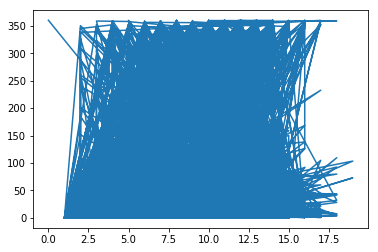

In [19]:
plt.plot(hits.nhits,hits.phi_range)
plt.show()

In [20]:
d = hits.phi_range.value_counts()
sorted_d = sorted(d.items(), key=lambda x: x[1])
print(sorted_d)
# equivalent version
# sorted_d = sorted(d.items(), key=lambda (k,v): v)

[(0.1566162109375, 2), (22.678436279296875, 2), (2.3771114349365234, 2), (3.573058605194092, 2), (0.6262664794921875, 2), (0.018238067626953125, 2), (1.9435234069824219, 2), (24.59969711303711, 2), (6.89105224609375, 2), (2.3346176147460938, 2), (0.0032958984375, 2), (0.4783172607421875, 2), (39.969642639160156, 2), (0.15903472900390625, 2), (1.7228240966796875, 2), (1.4680023193359375, 2), (8.243148803710938, 2), (31.445579528808594, 2), (327.3277587890625, 2), (62.87055969238281, 2), (3.9277000427246094, 2), (1.4163589477539062, 2), (0.04686737060546875, 2), (108.35372161865234, 2), (2.492262363433838, 2), (27.490554809570312, 2), (22.632225036621094, 2), (2.378976821899414, 2), (0.49029541015625, 2), (2.3787307739257812, 2), (0.145599365234375, 2), (19.44115447998047, 2), (9.322952270507812, 2), (8.177810668945312, 2), (0.3732948303222656, 2), (0.2390899658203125, 2), (0.0378875732421875, 2), (4.664207458496094, 2), (4.0221710205078125, 2), (6.0876922607421875, 2), (40.9788284301757

In [21]:
hits.particle_id.nunique()

10566

In [22]:
y_kmeans = kmeans.predict(X)

NameError: name 'kmeans' is not defined

In [65]:
scores = []
scores = []
for e in train:
    hits, cells, truth = load_event(e, parts=['hits', 'cells', 'truth'])
    hits['event_id'] = int(e[-9:])
    truth = pd.merge(truth, particles, how='left', on='particle_id')
    hits = pd.merge(hits, truth, how='left', on='hit_id')
    hits = hits.fillna(0)
    hits = hits[hits.particle_id != 0]
    hits = norm_points(hits)
    for m in ['braycurtis']: #Tuning/Grid Search
        print(m)
        try:
            dbscan = hdbscan.HDBSCAN(min_samples=1, min_cluster_size=7, cluster_selection_method='leaf', prediction_data=False, metric=m)
            labels= dbscan.fit_predict(scl.fit_transform(hits[['x2', 'y2', 'z2']].values))
            
            hits['track_id'] = labels
            
            
            
            hits['track_id'] = hits['track_id'] + 1
            s = hits['track_id'].value_counts()
            hits['track_count'] = hits['track_id'].map(lambda x: s[x])
            hits['phi'] = np.degrees(np.arctan2(hits['y2'],hits['x2']))
            hits['r'] = np.sqrt(hits['x2']**2 + hits['y2']**2)
            
#             hits.loc[hits.track_count > 20, 'track_id'] = 0
            score = score_event(truth, hits[['event_id','hit_id','track_id']])
            print(m, len(truth['particle_id'].unique()), len(hits['track_id'].unique()), score)
            scores.append([score, m])
            
            
        except e:
            print("ERROR:", e)
#         break #Remove to test all
    break #Remove to test more samples
print(sorted(scores, reverse=True))

braycurtis
braycurtis 10566 6691 0.25332705792474564
[[0.25332705792474564, 'braycurtis']]


In [66]:
from scipy.spatial.distance import pdist, cdist
tracks_list = list(set(hits.track_id.values))
for track in tracks_list:
    if(track != 1):
        continue
    kmeans = KMeans(n_clusters=4)
    hits1 = hits[hits.track_id == 1]
    x = hits1.x.values
    y = hits1.y.values
    print(x.shape)
    print(y.shape)
    z = hits1[['x','y']].values
    print(z.shape)
    X = cdist(z, z)
    print(X.shape)
    kmeans.fit(X)
    y_kmeans = kmeans.predict(X)

(7,)
(7,)
(7, 2)
(7, 7)


In [67]:
y_kmeans

array([1, 1, 1, 2, 0, 3, 0], dtype=int32)

In [68]:
hits1

,hit_id,x,y,z,volume_id,layer_id,module_id,event_id,particle_id,tx,...,pz,q,nhits,x2,y2,z2,track_id,track_count,phi,r
2409,2410,34.153702,20.560101,-1302.0,7,4,60,1000,734120480524468224,34.142399,...,-7.60328,-1.0,5.0,0.026219,0.015784,-32.660488,1,7,31.047413,0.030604
2460,2461,33.956402,20.427299,-1297.5,7,4,63,1000,734120480524468224,33.961399,...,-7.60328,-1.0,5.0,0.026158,0.015736,-32.742695,1,7,31.030033,0.030527
2519,2520,34.137100,20.574900,-1302.5,7,4,66,1000,734120480524468224,34.162601,...,-7.60328,-1.0,5.0,0.026197,0.015789,-32.678425,1,7,31.077946,0.030587
4340,4341,30.920200,8.271730,-1098.0,7,6,58,1000,662050379541774336,30.913300,...,-3.24187,-1.0,1.0,0.028149,0.007530,-34.304455,1,7,14.976980,0.029138
5172,5173,-29.311300,17.373800,-1097.5,7,6,96,1000,117115786702618624,-29.320499,...,-5.29307,-1.0,8.0,-0.026694,0.015823,-32.209812,1,7,149.343338,0.031031
5195,5196,-29.530800,17.539400,-1102.5,7,6,98,1000,117115786702618624,-29.512300,...,-5.29307,-1.0,8.0,-0.026772,0.015901,-32.099113,1,7,149.292389,0.031138
5242,5243,-29.327400,17.370300,-1098.0,7,6,101,1000,117115786702618624,-29.339701,...,-5.29307,-1.0,8.0,-0.026697,0.015812,-32.213078,1,7,149.362198,0.031028


In [69]:
for track in tracks_list:
    if(track != 2):
        continue
    kmeans = KMeans(n_clusters=4)
    hits1 = hits[hits.track_id == 2]
    x = hits1.x.values
    y = hits1.y.values
    print(x.shape)
    print(y.shape)
    z = hits1[['x','y']].values
    print(z.shape)
    X = cdist(z, z)
    print(X.shape)
    kmeans.fit(X)
    y_kmeans = kmeans.predict(X)

(8,)
(8,)
(8, 2)
(8, 8)


In [70]:
X

array([[0.00000000e+00, 1.00452162e+01, 9.93681481e+00, 2.43594467e+01,
        2.47407262e+01, 2.43778789e+01, 3.29308499e+01, 3.28685442e+01],
       [1.00452162e+01, 0.00000000e+00, 1.83053525e-01, 1.43553771e+01,
        1.47414866e+01, 1.43741192e+01, 2.30115336e+01, 2.29398337e+01],
       [9.93681481e+00, 1.83053525e-01, 0.00000000e+00, 1.44819827e+01,
        1.48688723e+01, 1.45007783e+01, 2.31470662e+01, 2.30744876e+01],
       [2.43594467e+01, 1.43553771e+01, 1.44819827e+01, 0.00000000e+00,
        3.96054553e-01, 1.96542044e-02, 8.75404464e+00, 8.66434961e+00],
       [2.47407262e+01, 1.47414866e+01, 1.48688723e+01, 3.96054553e-01,
        0.00000000e+00, 3.76463904e-01, 8.35828635e+00, 8.26893621e+00],
       [2.43778789e+01, 1.43741192e+01, 1.45007783e+01, 1.96542044e-02,
        3.76463904e-01, 0.00000000e+00, 8.73452331e+00, 8.64487204e+00],
       [3.29308499e+01, 2.30115336e+01, 2.31470662e+01, 8.75404464e+00,
        8.35828635e+00, 8.73452331e+00, 0.00000000e+00, 1.

In [71]:
y_kmeans

array([3, 1, 1, 0, 0, 0, 2, 2], dtype=int32)

In [72]:
y_kmeans.shape

(8,)

In [73]:
hits1

,hit_id,x,y,z,volume_id,layer_id,module_id,event_id,particle_id,tx,...,pz,q,nhits,x2,y2,z2,track_id,track_count,phi,r
59132,59133,10.687500,32.624599,1097.5,9,10,74,1000,139623957954297856,10.692600,...,1.474560,-1.0,1.0,0.009733,0.029712,31.968603,2,8,71.861702,0.031265
59181,59182,0.716473,33.843201,1102.5,9,10,77,1000,873700664205643777,0.715446,...,0.455948,1.0,11.0,0.000650,0.030682,32.569408,2,8,88.787201,0.030689
59285,59286,0.807352,33.684299,1102.0,9,10,82,1000,873700664205643777,0.808421,...,0.455948,1.0,11.0,0.000732,0.030552,32.706146,2,8,88.626976,0.030561
61241,61242,-13.228700,37.250401,1297.5,9,12,85,1000,355797702140755968,-13.215300,...,2.858480,-1.0,5.0,-0.010191,0.028696,32.823486,2,8,109.551422,0.030452
61289,61290,-13.582300,37.428799,1302.5,9,12,87,1000,355797702140755968,-13.598600,...,2.858480,-1.0,5.0,-0.010423,0.028723,32.712154,2,8,109.945000,0.030555
61342,61343,-13.245500,37.260601,1298.0,9,12,90,1000,355797702140755968,-13.253600,...,2.858480,-1.0,5.0,-0.010200,0.028693,32.823486,2,8,109.569420,0.030452
62892,62893,-21.187799,40.895401,1502.5,9,14,87,1000,337786602166157312,-21.205700,...,14.114600,1.0,5.0,-0.014095,0.027205,32.621777,2,8,117.388542,0.030640
62937,62938,-21.169201,40.717300,1498.0,9,14,90,1000,337786602166157312,-21.156500,...,14.114600,1.0,5.0,-0.014125,0.027168,32.642178,2,8,117.470215,0.030621


In [74]:
# Apply code for an example
x = hits[hits.track_id == 2].x2.values
y = hits[hits.track_id == 2].y2.values
phi = hits[hits.track_id == 2].phi.values
print(max(phi)-min(phi))
comp_curv = ComputeCurvature()
curvature = comp_curv.fit(x, y)

45.608513


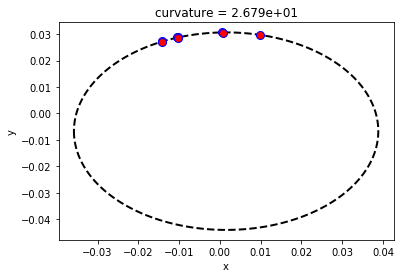

In [75]:
# Plot the result
theta_fit = np.linspace(-np.pi, np.pi, 180)
r = 1/curvature
x_fit = comp_curv.xc + comp_curv.r*np.cos(theta_fit)
y_fit = comp_curv.yc + comp_curv.r*np.sin(theta_fit)
r_pt = np.sqrt(x**2 + y**2)
d = abs(r - r_pt)
plt.plot(x_fit, y_fit, 'k--', label='fit', lw=2)
plt.plot(x, y, 'ro', label='data', ms=8, mec='b', mew=1)
plt.xlabel('x')
plt.ylabel('y')
plt.title('curvature = {:.3e}'.format(curvature))
plt.show()

In [353]:
d

array([0.00041348, 0.00033912, 0.00043482, 0.00077971, 0.00130202,
       0.00128198, 0.00129279, 0.00032603, 0.00030115, 0.00033552],
      dtype=float32)

In [78]:
for track in tracks_list:
    if(track != 3):
        continue
    kmeans = KMeans(n_clusters=4)
    hits1 = hits[hits.track_id == 3]
    x = hits1.x.values
    y = hits1.y.values
    print(x.shape)
    print(y.shape)
    z = hits1[['x','y']].values
    print(z.shape)
    X = cdist(z, z)
    print(X.shape)
    kmeans.fit(X)
    y_kmeans = kmeans.predict(X)

(10,)
(10,)
(10, 2)
(10, 10)


In [79]:
y_kmeans

array([3, 2, 2, 2, 0, 0, 0, 1, 1, 1], dtype=int32)

In [80]:
hits1

,hit_id,x,y,z,volume_id,layer_id,module_id,event_id,particle_id,tx,...,pz,q,nhits,x2,y2,z2,track_id,track_count,phi,r
59220,59221,1.549370,32.439301,1098.0,9,10,79,1000,873700664205643777,1.546400,...,0.455948,1.0,11.0,0.001410,0.029531,33.809292,3,10,87.265503,0.029565
61270,61271,-19.002501,33.398499,1302.5,9,12,87,1000,337786602166157312,-18.999500,...,14.114600,1.0,5.0,-0.014583,0.025631,33.896351,3,10,119.638260,0.029489
61347,61348,-18.936199,33.245602,1298.0,9,12,90,1000,337786602166157312,-18.949499,...,14.114600,1.0,5.0,-0.014582,0.025602,33.925514,3,10,119.665184,0.029464
61382,61383,-19.001301,33.395302,1302.0,9,12,93,1000,337786602166157312,-18.993900,...,14.114600,1.0,5.0,-0.014588,0.025638,33.886314,3,10,119.639061,0.029498
61474,61475,-36.097000,13.001500,1302.5,9,12,98,1000,445873817856770048,-36.100101,...,2.322960,-1.0,13.0,-0.027702,0.009978,33.948376,3,10,160.191879,0.029444
61522,61523,-36.572399,12.956900,1298.0,9,12,101,1000,445873817856770048,-36.582100,...,2.322960,-1.0,13.0,-0.028163,0.009978,33.453812,3,10,160.491730,0.029879
61601,61602,-36.143002,13.022200,1302.0,9,12,104,1000,445873817856770048,-36.153900,...,2.322960,-1.0,13.0,-0.027748,0.009997,33.890919,3,10,160.186066,0.029494
62763,62764,3.302870,44.492699,1502.5,9,14,77,1000,535938457420169216,3.316630,...,3.928920,-1.0,6.0,0.002197,0.029599,33.676922,3,10,85.754486,0.029681
62796,62797,3.311330,44.304901,1498.0,9,14,79,1000,535938457420169216,3.293920,...,3.928920,-1.0,6.0,0.002210,0.029563,33.717117,3,10,85.725677,0.029645
62831,62832,3.294800,44.486301,1502.0,9,14,82,1000,535938457420169216,3.314210,...,3.928920,-1.0,6.0,0.002193,0.029605,33.670979,3,10,85.764214,0.029686


In [345]:
# Apply code for an example
x = hits[hits.track_id == 2].x2.values
y = hits[hits.track_id == 2].y2.values
phi = hits[hits.track_id == 2].phi.values
print(max(phi)-min(phi))
comp_curv = ComputeCurvature()
curvature = comp_curv.fit(x, y)

354.89728


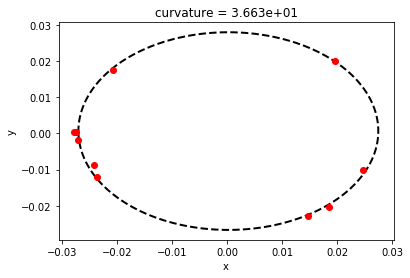

In [347]:
# Plot the result
theta_fit = np.linspace(-np.pi, np.pi, 180)
r = 1/curvature
x_fit = comp_curv.xc + comp_curv.r*np.cos(theta_fit)
y_fit = comp_curv.yc + comp_curv.r*np.sin(theta_fit)
r_pt = np.sqrt(x**2 + y**2)
d = abs(r - r_pt)
plt.plot(x_fit, y_fit, 'k--', label='fit', lw=2)
# plt.plot(x, y, 'ro', label=phi, ms=8, mec='b', mew=1)
plt.plot(x, y, 'ro')
plt.xlabel('x')
plt.ylabel('y')
plt.title('curvature = {:.3e}'.format(curvature))
plt.show()

In [348]:
x.shape

(10,)

In [349]:
hits1

,hit_id,x,y,z,volume_id,layer_id,module_id,event_id,x2,y2,z2,track_id,track_count,phi
60675,60676,35.200199,0.158373,1302.0,9,12,50,1000,0.027026,0.000122,36.988056,1,10,0.257784
60705,60706,34.975498,-0.690310,1297.5,9,12,52,1000,0.026946,-0.000532,37.090172,1,10,-1.130698
60755,60756,35.241001,0.250609,1302.5,9,12,55,1000,0.027047,0.000192,36.958858,1,10,0.407440
61064,61065,8.139390,34.610401,1297.5,9,12,74,1000,0.006271,0.026665,36.493168,1,10,76.766121
61115,61116,2.262100,36.302299,1302.5,9,12,77,1000,0.001736,0.027860,35.809814,1,10,86.434341
61141,61142,2.218370,36.153000,1298.0,9,12,79,1000,0.001708,0.027842,35.835567,1,10,86.488693
61180,61181,2.235560,36.277901,1302.0,9,12,82,1000,0.001716,0.027852,35.821671,1,10,86.473709
62268,62269,34.050400,-19.777599,1497.5,9,14,42,1000,0.022730,-0.013203,38.029385,1,10,-30.149437
62294,62295,34.217999,-19.825300,1502.5,9,14,44,1000,0.022766,-0.013190,37.993389,1,10,-30.087238
62357,62358,34.057800,-19.762699,1498.0,9,14,47,1000,0.022728,-0.013188,38.043125,1,10,-30.125278


In [343]:
d

array([1.1792755, 3.1864853, 2.5105019, 4.406311 , 2.8712387, 1.7777443,
       2.0582047, 2.2290802, 7.013645 , 6.8157997], dtype=float32)

In [21]:
scores = []
B = 0.002036374942542289
for e in train:
    hits, cells, truth, particles = load_event(e, parts=['hits', 'cells', 'truth', 'particles'])
    hits['event_id'] = int(e[-9:])
    truth = pd.merge(truth, particles, how='left', on='particle_id')
    hits = pd.merge(hits, truth, how='left', on='hit_id')
    hits = hits.fillna(0)
    hits = hits[hits.particle_id != 0]
    hits = norm_points(hits)
    for m in ['braycurtis']: #Tuning/Grid Search
        print(m)
        try:
            dbscan = hdbscan.HDBSCAN(min_samples=1, min_cluster_size=7, cluster_selection_method='leaf', prediction_data=False, metric=m)
            labels= dbscan.fit_predict(scl.fit_transform(hits[['x2', 'y2', 'z2']].values))
            
            hits['track_id'] = labels
            
            hits['track_id'] = hits['track_id'] + 1
            s = hits['track_id'].value_counts()
            hits['track_count'] = hits['track_id'].map(lambda x: s[x])
            hits['phi'] = np.degrees(np.arctan2(hits['y2'], hits['x2']))
            
            tracks_list = list(set(hits.track_id.values))
            for track  in tracks_list:
                hits1 = hits[hits.track_id == track]
                nump = hits1.particle_id.nunique()
                hits.loc[hits.track_id == track, 'nump'] = nump
            score = score_event(truth, hits[['event_id','hit_id','track_id']])
            print(m, len(truth['particle_id'].unique()), len(hits['track_id'].unique()), score)
            scores.append([score, m])
            
            
        except e:
            print("ERROR:", e)
#         break #Remove to test all
    break #Remove to test more samples
print(sorted(scores, reverse=True))

braycurtis
braycurtis 10566 6691 0.25332705792474564
[[0.25332705792474564, 'braycurtis']]


In [22]:
hits['track_id'].value_counts()

0       19822
4988       46
3917       45
3603       44
4343       43
4802       42
4498       42
5625       41
4781       40
2553       38
5089       37
2486       37
4353       37
6464       37
2414       37
4180       36
1482       36
4949       36
5979       36
89         36
3426       35
6080       35
4626       35
4271       35
3492       35
6338       35
826        35
4732       35
5721       34
5280       34
        ...  
3335        7
5533        7
1047        7
2956        7
2974        7
6148        7
5007        7
3020        7
3504        7
3102        7
1004        7
3770        7
3847        7
5881        7
2422        7
5945        7
1350        7
3719        7
1457        7
5764        7
2358        7
876         7
5636        7
2861        7
4090        7
3463        7
3340        7
5508        7
60          7
4871        7
Name: track_id, Length: 6691, dtype: int64

In [23]:
hits['nump'].value_counts()

6786.0    19822
1.0       14969
2.0        9352
6.0        6861
5.0        6649
3.0        6002
7.0        5946
8.0        5756
4.0        5662
9.0        4519
10.0       3786
11.0       3067
12.0       2534
13.0       1826
14.0       1403
15.0       1205
16.0       1129
18.0        742
17.0        693
19.0        353
22.0        263
20.0        213
24.0        175
21.0        173
23.0         95
26.0         67
27.0         43
Name: nump, dtype: int64

In [26]:
hits[hits.track_id == 443]

,hit_id,x,y,z,volume_id,layer_id,module_id,event_id,particle_id,tx,...,pz,q,nhits,x2,y2,z2,track_id,track_count,phi,nump
1,2,-55.336102,0.635342,-1502.5,7,2,1,1000,22525763437723648,-55.338501,...,-15.496,1.0,10.0,-0.036804,0.000423,-27.150467,443,10,179.342178,1.0
1419,1420,-55.162201,0.604841,-1497.5,7,2,106,1000,22525763437723648,-55.154400,...,-15.496,1.0,10.0,-0.036811,0.000404,-27.145582,443,10,179.371780,1.0
1459,1460,-47.975498,0.311848,-1302.5,7,4,1,1000,22525763437723648,-47.988098,...,-15.496,1.0,10.0,-0.036808,0.000239,-27.148703,443,10,179.627563,1.0
3169,3170,-47.812302,0.327322,-1297.5,7,4,106,1000,22525763437723648,-47.804100,...,-15.496,1.0,10.0,-0.036825,0.000252,-27.136730,443,10,179.607758,1.0
3233,3234,-40.622799,0.088046,-1102.5,7,6,1,1000,22525763437723648,-40.626099,...,-15.496,1.0,10.0,-0.036821,0.000080,-27.139868,443,10,179.875809,1.0
5342,5343,-40.438801,0.098098,-1097.5,7,6,106,1000,22525763437723648,-40.442200,...,-15.496,1.0,10.0,-0.036821,0.000089,-27.139696,443,10,179.861008,1.0
5423,5424,-35.480598,-0.008800,-962.5,7,8,1,1000,22525763437723648,-35.475899,...,-15.496,1.0,10.0,-0.036838,-0.000009,-27.127499,443,10,-179.985779,1.0
5481,5482,-35.330101,-0.023294,-958.0,7,8,4,1000,22525763437723648,-35.310101,...,-15.496,1.0,10.0,-0.036854,-0.000024,-27.115683,443,10,-179.962204,1.0
7866,7867,-35.312302,-0.004440,-957.5,7,8,106,1000,22525763437723648,-35.291698,...,-15.496,1.0,10.0,-0.036855,-0.000005,-27.115196,443,10,-179.992783,1.0
7950,7951,-30.333700,-0.105277,-822.5,7,10,1,1000,22525763437723648,-30.315399,...,-15.496,1.0,10.0,-0.036855,-0.000128,-27.114893,443,10,-179.801147,1.0


In [33]:
for track in tracks_list:
    if(track != 443):
        continue
    kmeans = KMeans(n_clusters=4)
    hits1 = hits[hits.track_id == 443]
    x = hits1.x.values
    y = hits1.y.values
    print(x.shape)
    print(y.shape)
    z = hits1[['x','y']].values
    print(z.shape)
    X = cdist(z, z)
    print(X.shape)
    kmeans.fit(X)
    y_kmeans = kmeans.predict(X)

(10,)
(10,)
(10, 2)
(10, 10)


In [34]:
y_kmeans

array([2, 2, 0, 0, 3, 3, 1, 1, 1, 1], dtype=int32)

In [73]:
scores = []
B = 0.002036374942542289
for e in train:
    hits, cells, truth, particles = load_event(e, parts=['hits', 'cells', 'truth', 'particles'])
    hits['event_id'] = int(e[-9:])
    truth = pd.merge(truth, particles, how='left', on='particle_id')
    hits = pd.merge(hits, truth, how='left', on='hit_id')
    hits = hits.fillna(0)
    hits = hits[hits.particle_id != 0]
    hits = norm_points(hits)
    for m in ['braycurtis']: #Tuning/Grid Search
        print(m)
        try:
            dbscan = hdbscan.HDBSCAN(min_samples=1, min_cluster_size=7, cluster_selection_method='leaf', prediction_data=False, metric=m)
            labels= dbscan.fit_predict(scl.fit_transform(hits[['x2', 'y2', 'z2']].values))
            
            hits['track_id'] = labels
            
            hits['track_id'] = hits['track_id'] + 1
            s = hits['track_id'].value_counts()
            hits['track_count'] = hits['track_id'].map(lambda x: s[x])
            hits['phi'] = np.degrees(np.arctan2(hits['y2'], hits['x2']))
            x2 = hits.x2.values
            y2 = hits.y2.values
            z2 = hits.z2.values
            hits['rho'] = np.sqrt(x2**2 + y2**2 + z2**2)
            hits2 = hits
#             hits = hits[(hits.particle_id == 22525763437723648) | (hits.particle_id == 297237712845406208) |
#                        (hits.particle_id == 418835796137607168) | (hits.particle_id == 108087696726949888) 
#                        | (hits.particle_id == 968286151951515648)]
            tracks_list = list(set(hits.track_id.values))
#             print(tracks_list)
            for track in tracks_list:
                hits1 = hits[hits.track_id == track]
#                 print(track)
#                 print(hits1)
#                 print(hits1.shape)
#                 print(hits1.track_count.data[0])
#                 print('==========================================')
                if hits1.track_count.data[0] > 20:
                    x = hits1.phi.values
                    y = hits1.rho.values
                    hits.loc[hits.track_id == track, 'myp'] = 0.3 * B * np.sqrt(x**2 + y**2)
                    continue
                    
                kmeans = KMeans(n_clusters=4)
                hits1 = hits[hits.track_id == track]
                x = hits1.phi.values
                y = hits1.rho.values
#                 print(x.shape)
#                 print(y.shape)
                z = hits1[['x','y']].values
#                 print(z.shape)
#                 X = cdist(z, z)
                X = z
#                 print(X.shape)
                kmeans.fit(X)
                y_kmeans = kmeans.predict(X)
                hits1['y_kmeans'] = y_kmeans
            
                for track2 in [0, 1, 2, 3]:
                    x = hits1[hits1.y_kmeans == track2].phi.values
                    y = hits1[hits1.y_kmeans == track2].rho.values
#                     print(x.shape)
#                     print(y.shape)
                    if x.shape[0] == 1:
                        hits1.loc[hits1.y_kmeans == track2, 'myp'] = 0.3 * B * np.sqrt(x**2 + y**2)
                        continue
                    comp_curv = ComputeCurvature()
                    curvature = comp_curv.fit(x, y)
                    R = 1/curvature
                    p = 0.3 * B * R
                    hits1.loc[hits1.y_kmeans == track2, 'myp'] = p
                hits.loc[hits.track_id == track, 'myp'] = hits1['myp'].values
            
            hits = hits.fillna(0)
            p = hits['myp'].values
            
            hits['x3'] = hits['x2'].values + p
            hits['y3'] = hits['y2'].values + p
            hits['z3'] = hits['z2'].values + p
            
#             print('********************************************')
#             hits.sort_values(['particle_id'], inplace=True)
#             print(hits)
            dbscan = hdbscan.HDBSCAN(min_samples=1, min_cluster_size=7, cluster_selection_method='leaf', prediction_data=False, metric=m)

            labels= dbscan.fit_predict(scl.fit_transform(hits[['x3', 'y3', 'z3']].values))+1
            hits['track_id'] = labels
            
            score = score_event(hits, hits[['event_id','hit_id','track_id']])
            print(m, len(truth['particle_id'].unique()), len(hits['track_id'].unique()), score)
            scores.append([score, m])
            
            
        except e:
            print("ERROR:", e)
#         break #Remove to test all
    break #Remove to test more samples
print(sorted(scores, reverse=True))

braycurtis


/home/watts/anaconda3/envs/tmlf/lib/python3.6/site-packages/ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/watts/anaconda3/envs/tmlf/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/watts/anaconda3/envs/tmlf/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide
/home/watts/anaconda3/envs/tmlf/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value enc

braycurtis 10566 6315 0.13682104356662778
[[0.13682104356662778, 'braycurtis']]


In [66]:
hits.shape

(55, 35)

In [67]:
hits.head(55)

,hit_id,x,y,z,volume_id,layer_id,module_id,event_id,particle_id,tx,...,y2,z2,track_id,track_count,phi,rho,myp,x3,y3,z3
1,2,-55.336102,0.635342,-1502.5,7,2,1,1000,22525763437723648,-55.338501,...,0.000423,-27.150467,4,10,179.342178,27.150492,0.000009,-0.036795,0.000432,-27.150458
5423,5424,-35.480598,-0.008800,-962.5,7,8,1,1000,22525763437723648,-35.475899,...,-0.000009,-27.127499,4,10,-179.985779,27.127523,0.000504,-0.036334,0.000494,-27.126995
3233,3234,-40.622799,0.088046,-1102.5,7,6,1,1000,22525763437723648,-40.626099,...,0.000080,-27.139868,4,10,179.875809,27.139893,0.000005,-0.036817,0.000084,-27.139863
5481,5482,-35.330101,-0.023294,-958.0,7,8,4,1000,22525763437723648,-35.310101,...,-0.000024,-27.115683,4,10,-179.962204,27.115707,0.000504,-0.036350,0.000479,-27.115179
7866,7867,-35.312302,-0.004440,-957.5,7,8,106,1000,22525763437723648,-35.291698,...,-0.000005,-27.115196,4,10,-179.992783,27.115221,0.000504,-0.036351,0.000499,-27.114693
3169,3170,-47.812302,0.327322,-1297.5,7,4,106,1000,22525763437723648,-47.804100,...,0.000252,-27.136730,4,10,179.607758,27.136755,0.000007,-0.036817,0.000259,-27.136723
5342,5343,-40.438801,0.098098,-1097.5,7,6,106,1000,22525763437723648,-40.442200,...,0.000089,-27.139696,4,10,179.861008,27.139721,0.000005,-0.036817,0.000094,-27.139692
1459,1460,-47.975498,0.311848,-1302.5,7,4,1,1000,22525763437723648,-47.988098,...,0.000239,-27.148703,4,10,179.627563,27.148727,0.000007,-0.036801,0.000246,-27.148696
7950,7951,-30.333700,-0.105277,-822.5,7,10,1,1000,22525763437723648,-30.315399,...,-0.000128,-27.114893,4,10,-179.801147,27.114918,0.000504,-0.036351,0.000376,-27.114389
1419,1420,-55.162201,0.604841,-1497.5,7,2,106,1000,22525763437723648,-55.154400,...,0.000404,-27.145582,4,10,179.371780,27.145607,0.000009,-0.036802,0.000413,-27.145573


In [58]:
hits[hits.isnull().any(axis=1)]

,hit_id,x,y,z,volume_id,layer_id,module_id,event_id,particle_id,tx,...,y2,z2,track_id,track_count,phi,rho,myp,x3,y3,z3


In [74]:
scores = []
B = 0.002036374942542289
for e in train:
    hits, cells, truth, particles = load_event(e, parts=['hits', 'cells', 'truth', 'particles'])
    hits['event_id'] = int(e[-9:])
    truth = pd.merge(truth, particles, how='left', on='particle_id')
    hits = pd.merge(hits, truth, how='left', on='hit_id')
    hits = hits.fillna(0)
    hits = hits[hits.particle_id != 0]
    hits = norm_points(hits)
    for m in ['braycurtis']: #Tuning/Grid Search
        print(m)
        try:
            dbscan = hdbscan.HDBSCAN(min_samples=1, min_cluster_size=7, cluster_selection_method='leaf', prediction_data=False, metric=m)
            labels= dbscan.fit_predict(scl.fit_transform(hits[['x2', 'y2', 'z2']].values))
            
            hits['track_id'] = labels
            
            hits['track_id'] = hits['track_id'] + 1
            s = hits['track_id'].value_counts()
            hits['track_count'] = hits['track_id'].map(lambda x: s[x])
            hits['phi'] = np.degrees(np.arctan2(hits['y2'], hits['x2']))
            x2 = hits.x2.values
            y2 = hits.y2.values
            z2 = hits.z2.values
            hits['rho'] = np.sqrt(x2**2 + y2**2 + z2**2)
            hits['rho1'] = np.round(np.sqrt(x2**2 + y2**2 + z2**2)).astype(int)
            tracks_list = list(set(hits.track_id.values))
            for track in tracks_list:
                hits1 = hits[hits.track_id == track]
#                 if hits1.track_count.data[0] > 20:
#                     x = hits1.phi.values
#                     y = hits1.rho.values
#                     hits.loc[hits.track_id == track, 'myp'] = 0.3 * B * np.sqrt(x**2 + y**2)
#                     continue
                n = hits1.rho1.nunique()
                kmeans = KMeans(n_clusters=n)
                hits1 = hits[hits.track_id == track]
                x = hits1.phi.values
                y = hits1.rho.values
#                 print(x.shape)
#                 print(y.shape)
                z = hits1[['x','y']].values
#                 print(z.shape)
#                 X = cdist(z, z)
                X = z
#                 print(X.shape)
                kmeans.fit(X)
                y_kmeans = kmeans.predict(X)
                hits1['y_kmeans'] = y_kmeans
            
                for track2 in range(n):
                    x = hits1[hits1.y_kmeans == track2].x.values
                    y = hits1[hits1.y_kmeans == track2].y.values
#                     print(x.shape)
#                     print(y.shape)
                    if x.shape[0] == 1:
                        hits1.loc[hits1.y_kmeans == track2, 'myp'] = 0.3 * B * np.sqrt(x**2 + y**2)
                        continue
                    comp_curv = ComputeCurvature()
                    curvature = comp_curv.fit(x, y)
                    R = 1/curvature
                    p = 0.3 * B * R
                    hits1.loc[hits1.y_kmeans == track2, 'myp'] = p
                hits.loc[hits.track_id == track, 'myp'] = hits1['myp'].values
            
            hits = hits.fillna(0)
            p = hits['myp'].values
            
            hits['x3'] = hits['x2'].values + p
            hits['y3'] = hits['y2'].values + p
            hits['z3'] = hits['z2'].values + p
            

            dbscan = hdbscan.HDBSCAN(min_samples=1, min_cluster_size=7, cluster_selection_method='leaf', prediction_data=False, metric=m)

            labels= dbscan.fit_predict(scl.fit_transform(hits[['x3', 'y3', 'z3']].values))+1
            hits['track_id'] = labels
            
            score = score_event(truth, hits[['event_id','hit_id','track_id']])
            print(m, len(truth['particle_id'].unique()), len(hits['track_id'].unique()), score)
            scores.append([score, m])
            
            
        except e:
            print("ERROR:", e)
#         break #Remove to test all
    break #Remove to test more samples
print(sorted(scores, reverse=True))

braycurtis


/home/watts/anaconda3/envs/tmlf/lib/python3.6/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/watts/anaconda3/envs/tmlf/lib/python3.6/site-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/watts/anaconda3/envs/tmlf/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

braycurtis 10566 8195 0.2440746658254987
[[0.2440746658254987, 'braycurtis']]


In [75]:
scores = []
B = 0.002036374942542289
for e in train:
    hits, cells, truth, particles = load_event(e, parts=['hits', 'cells', 'truth', 'particles'])
    hits['event_id'] = int(e[-9:])
    truth = pd.merge(truth, particles, how='left', on='particle_id')
    hits = pd.merge(hits, truth, how='left', on='hit_id')
    hits = hits.fillna(0)
    hits = hits[hits.particle_id != 0]
    hits = norm_points(hits)
    for m in ['braycurtis']: #Tuning/Grid Search
        print(m)
        try:
            dbscan = hdbscan.HDBSCAN(min_samples=1, min_cluster_size=7, cluster_selection_method='leaf', prediction_data=False, metric=m)
            labels= dbscan.fit_predict(scl.fit_transform(hits[['x2', 'y2', 'z2']].values))
            
            hits['track_id'] = labels
            
            hits['track_id'] = hits['track_id'] + 1
            s = hits['track_id'].value_counts()
            hits['track_count'] = hits['track_id'].map(lambda x: s[x])
            hits['phi'] = np.degrees(np.arctan2(hits['y2'], hits['x2']))
            x2 = hits.x2.values
            y2 = hits.y2.values
            z2 = hits.z2.values
            hits['rho'] = np.sqrt(x2**2 + y2**2 + z2**2)
            hits['rho1'] = np.round(np.sqrt(x2**2 + y2**2 + z2**2)).astype(int)
            tracks_list = list(set(hits.track_id.values))
            for track in tracks_list:
                hits1 = hits[hits.track_id == track]
#                 if hits1.track_count.data[0] > 20:
#                     x = hits1.phi.values
#                     y = hits1.rho.values
#                     hits.loc[hits.track_id == track, 'myp'] = 0.3 * B * np.sqrt(x**2 + y**2)
#                     continue
                n = hits1.rho1.nunique()
                kmeans = KMeans(n_clusters=n)
                hits1 = hits[hits.track_id == track]
                x = hits1.phi.values
                y = hits1.rho.values
#                 print(x.shape)
#                 print(y.shape)
                z = hits1[['x','y']].values
#                 print(z.shape)
#                 X = cdist(z, z)
                X = z
#                 print(X.shape)
                kmeans.fit(X)
                y_kmeans = kmeans.predict(X)
                hits1['y_kmeans'] = y_kmeans
            
                for track2 in range(n):
                    x = hits1[hits1.y_kmeans == track2].x.values
                    y = hits1[hits1.y_kmeans == track2].y.values
#                     print(x.shape)
#                     print(y.shape)
                    if x.shape[0] == 1:
                        hits1.loc[hits1.y_kmeans == track2, 'myp'] = 0.3 * B * np.sqrt(x**2 + y**2) * 2
                        continue
                    comp_curv = ComputeCurvature()
                    curvature = comp_curv.fit(x, y)
                    R = 1/curvature
                    p = 0.3 * B * R * 2
                    hits1.loc[hits1.y_kmeans == track2, 'myp'] = p
                hits.loc[hits.track_id == track, 'myp'] = hits1['myp'].values
            
            hits = hits.fillna(0)
            p = hits['myp'].values
            
            hits['x3'] = hits['x2'].values + p
            hits['y3'] = hits['y2'].values + p
            hits['z3'] = hits['z2'].values + p
            

            dbscan = hdbscan.HDBSCAN(min_samples=1, min_cluster_size=7, cluster_selection_method='leaf', prediction_data=False, metric=m)

            labels= dbscan.fit_predict(scl.fit_transform(hits[['x3', 'y3', 'z3']].values))+1
            hits['track_id'] = labels
            
            score = score_event(truth, hits[['event_id','hit_id','track_id']])
            print(m, len(truth['particle_id'].unique()), len(hits['track_id'].unique()), score)
            scores.append([score, m])
            
            
        except e:
            print("ERROR:", e)
#         break #Remove to test all
    break #Remove to test more samples
print(sorted(scores, reverse=True))

braycurtis


/home/watts/anaconda3/envs/tmlf/lib/python3.6/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/watts/anaconda3/envs/tmlf/lib/python3.6/site-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/watts/anaconda3/envs/tmlf/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

braycurtis 10566 8196 0.2464865335546087
[[0.2464865335546087, 'braycurtis']]


In [76]:
scores = []
B = 0.002036374942542289
for e in train:
    hits, cells, truth, particles = load_event(e, parts=['hits', 'cells', 'truth', 'particles'])
    hits['event_id'] = int(e[-9:])
    truth = pd.merge(truth, particles, how='left', on='particle_id')
    hits = pd.merge(hits, truth, how='left', on='hit_id')
    hits = hits.fillna(0)
    hits = hits[hits.particle_id != 0]
    hits = norm_points(hits)
    for m in ['braycurtis']: #Tuning/Grid Search
        print(m)
        try:
            dbscan = hdbscan.HDBSCAN(min_samples=1, min_cluster_size=7, cluster_selection_method='leaf', prediction_data=False, metric=m)
            labels= dbscan.fit_predict(scl.fit_transform(hits[['x2', 'y2', 'z2']].values))
            
            hits['track_id'] = labels
            
            hits['track_id'] = hits['track_id'] + 1
            s = hits['track_id'].value_counts()
            hits['track_count'] = hits['track_id'].map(lambda x: s[x])
            hits['phi'] = np.degrees(np.arctan2(hits['y2'], hits['x2']))
            x2 = hits.x2.values
            y2 = hits.y2.values
            z2 = hits.z2.values
            hits['rho'] = np.sqrt(x2**2 + y2**2 + z2**2)
            hits['rho1'] = np.round(np.sqrt(x2**2 + y2**2 + z2**2)).astype(int)
            tracks_list = list(set(hits.track_id.values))
            for track in tracks_list:
                hits1 = hits[hits.track_id == track]
                if hits1.track_count.data[0] > 15:
                    x = hits1.phi.values
                    y = hits1.rho.values
                    hits.loc[hits.track_id == track, 'myp'] = 0.3 * B * np.sqrt(x**2 + y**2) * 2
                    continue
                n = hits1.rho1.nunique()
                kmeans = KMeans(n_clusters=n)
                hits1 = hits[hits.track_id == track]
                x = hits1.phi.values
                y = hits1.rho.values
#                 print(x.shape)
#                 print(y.shape)
                z = hits1[['x','y']].values
#                 print(z.shape)
#                 X = cdist(z, z)
                X = z
#                 print(X.shape)
                kmeans.fit(X)
                y_kmeans = kmeans.predict(X)
                hits1['y_kmeans'] = y_kmeans
            
                for track2 in range(n):
                    x = hits1[hits1.y_kmeans == track2].x.values
                    y = hits1[hits1.y_kmeans == track2].y.values
#                     print(x.shape)
#                     print(y.shape)
                    if x.shape[0] == 1:
                        hits1.loc[hits1.y_kmeans == track2, 'myp'] = 0.3 * B * np.sqrt(x**2 + y**2) * 2
                        continue
                    comp_curv = ComputeCurvature()
                    curvature = comp_curv.fit(x, y)
                    R = 1/curvature
                    p = 0.3 * B * R * 2
                    hits1.loc[hits1.y_kmeans == track2, 'myp'] = p
                hits.loc[hits.track_id == track, 'myp'] = hits1['myp'].values
            
            hits = hits.fillna(0)
            p = hits['myp'].values
            
            hits['x3'] = hits['x2'].values + p
            hits['y3'] = hits['y2'].values + p
            hits['z3'] = hits['z2'].values + p
            

            dbscan = hdbscan.HDBSCAN(min_samples=1, min_cluster_size=7, cluster_selection_method='leaf', prediction_data=False, metric=m)

            labels= dbscan.fit_predict(scl.fit_transform(hits[['x3', 'y3', 'z3']].values))+1
            hits['track_id'] = labels
            
            score = score_event(truth, hits[['event_id','hit_id','track_id']])
            print(m, len(truth['particle_id'].unique()), len(hits['track_id'].unique()), score)
            scores.append([score, m])
            
            
        except e:
            print("ERROR:", e)
#         break #Remove to test all
    break #Remove to test more samples
print(sorted(scores, reverse=True))

braycurtis


/home/watts/anaconda3/envs/tmlf/lib/python3.6/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/watts/anaconda3/envs/tmlf/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


braycurtis 10566 8012 0.24529667733851335
[[0.24529667733851335, 'braycurtis']]


In [85]:
scores = []
B = 0.002036374942542289
for e in train:
    hits, cells, truth, particles = load_event(e, parts=['hits', 'cells', 'truth', 'particles'])
    hits['event_id'] = int(e[-9:])
    truth = pd.merge(truth, particles, how='left', on='particle_id')
    hits = pd.merge(hits, truth, how='left', on='hit_id')
    hits = hits.fillna(0)
    hits = hits[hits.particle_id != 0]
    hits = norm_points(hits)
    for m in ['braycurtis']: #Tuning/Grid Search
        print(m)
        try:
            dbscan = hdbscan.HDBSCAN(min_samples=1, min_cluster_size=7, cluster_selection_method='leaf', prediction_data=False, metric=m)
            labels= dbscan.fit_predict(scl.fit_transform(hits[['x2', 'y2', 'z2']].values))
            
            hits['track_id'] = labels
            
            hits['track_id'] = hits['track_id'] + 1
            s = hits['track_id'].value_counts()
            hits['track_count'] = hits['track_id'].map(lambda x: s[x])
            hits['phi'] = np.degrees(np.arctan2(hits['y2'], hits['x2']))
            x2 = hits.x2.values
            y2 = hits.y2.values
            z2 = hits.z2.values
            hits['rho'] = np.sqrt(x2**2 + y2**2 + z2**2)
            hits['rho1'] = np.round(np.sqrt(x2**2 + y2**2 + z2**2)).astype(int)
            hits = hits[(hits.particle_id == 22525763437723648) | (hits.particle_id == 297237712845406208) |
           (hits.particle_id == 418835796137607168) | (hits.particle_id == 108087696726949888) 
           | (hits.particle_id == 968286151951515648)]
            tracks_list = list(set(hits.track_id.values))
            for track in tracks_list:
                hits1 = hits[hits.track_id == track]
                if hits1.track_count.data[0] > 15:
                    x = hits1.phi.values
                    y = hits1.rho.values
                    hits.loc[hits.track_id == track, 'myp'] = 0.3 * B * np.sqrt(x**2 + y**2) * 2
                    continue
                
                dbscan = DBSCAN(eps=0.0075, metric='precomputed')
                n = hits1.rho1.nunique()
#                 kmeans = KMeans(n_clusters=n)
                hits1 = hits[hits.track_id == track]
                x = hits1.x.values
                y = hits1.y.values
#                 print(x.shape)
#                 print(y.shape)
                z = hits1[['x','y']].values
#                 print(z.shape)
                X = cdist(z, z)
#                 X = z
#                 print(X.shape)
                y_kmeans = dbscan.fit_predict(X)
#                 y_kmeans = kmeans.predict(X)
                hits1['y_kmeans'] = y_kmeans
            
                for track2 in y_kmeans:
                    x = hits1[hits1.y_kmeans == track2].x.values
                    y = hits1[hits1.y_kmeans == track2].y.values
#                     print(x.shape)
#                     print(y.shape)
                    if x.shape[0] == 1:
                        hits1.loc[hits1.y_kmeans == track2, 'myp'] = 0.3 * B * np.sqrt(x**2 + y**2) * 2
                        continue
                    comp_curv = ComputeCurvature()
                    curvature = comp_curv.fit(x, y)
                    R = 1/curvature
                    p = 0.3 * B * R * 2
                    hits1.loc[hits1.y_kmeans == track2, 'myp'] = p
                hits.loc[hits.track_id == track, 'myp'] = hits1['myp'].values
            
            hits = hits.fillna(0)
            p = hits['myp'].values
            
            hits['x3'] = hits['x2'].values + p
            hits['y3'] = hits['y2'].values + p
            hits['z3'] = hits['z2'].values + p
            

            dbscan = hdbscan.HDBSCAN(min_samples=1, min_cluster_size=7, cluster_selection_method='leaf', prediction_data=False, metric=m)

            labels= dbscan.fit_predict(scl.fit_transform(hits[['x3', 'y3', 'z3']].values))+1
            hits['track_id'] = labels
            
            score = score_event(hits, hits[['event_id','hit_id','track_id']])
            print(m, len(truth['particle_id'].unique()), len(hits['track_id'].unique()), score)
            scores.append([score, m])
            
            
        except e:
            print("ERROR:", e)
#         break #Remove to test all
    break #Remove to test more samples
print(sorted(scores, reverse=True))

braycurtis


/home/watts/anaconda3/envs/tmlf/lib/python3.6/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/watts/anaconda3/envs/tmlf/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/watts/anaconda3/envs/tmlf/lib/python3.6/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

braycurtis 10566 5 1.0000000364612676
[[1.0000000364612676, 'braycurtis']]


In [84]:
hits1

,hit_id,x,y,z,volume_id,layer_id,module_id,event_id,particle_id,tx,...,x2,y2,z2,track_id,track_count,phi,rho,rho1,myp,y_kmeans
7953,7954,-53.856800,-0.953498,-822.5,7,10,1,1000,297237712845406208,-53.842300,...,-0.065339,-0.001157,-15.269587,989,13,-178.985718,15.269727,15,0.258979,-1
10743,10744,-53.518398,-0.928854,-817.5,7,10,106,1000,297237712845406208,-53.521599,...,-0.065326,-0.001134,-15.272820,989,13,-179.005676,15.272961,15,0.258979,-1
10836,10837,-46.066101,-0.290200,-702.5,7,12,1,1000,297237712845406208,-46.073299,...,-0.065434,-0.000412,-15.249522,989,13,-179.639053,15.249662,15,0.258979,-1
13781,13782,-45.758900,-0.285674,-697.5,7,12,106,1000,297237712845406208,-45.748100,...,-0.065463,-0.000409,-15.242640,989,13,-179.642303,15.242780,15,0.258979,-1
13865,13866,-39.545502,0.022362,-602.5,7,14,1,1000,297237712845406208,-39.548599,...,-0.065495,0.000037,-15.235611,989,13,179.967590,15.235752,15,0.258979,-1
16846,16847,-39.213600,0.051823,-597.5,7,14,106,1000,297237712845406208,-39.223900,...,-0.065489,0.000087,-15.237047,989,13,179.924271,15.237187,15,0.258979,-1


In [165]:
scores = []
B = 0.002036374942542289
for e in train:
    hits, cells, truth, particles = load_event(e, parts=['hits', 'cells', 'truth', 'particles'])
    hits['event_id'] = int(e[-9:])
    truth = pd.merge(truth, particles, how='left', on='particle_id')
    hits = pd.merge(hits, truth, how='left', on='hit_id')
    hits = hits.fillna(0)
    hits = hits[hits.particle_id != 0]
    hits = norm_points(hits)
    for m in ['braycurtis']: #Tuning/Grid Search
        print(m)
        try:
            np.random.seed(123) # for reproducability
#             particles_list = list(set(hits.particle_id.values))
#             n_particles = np.random.choice(particles_list, 100)
#             hits = hits[hits.particle_id.isin(n_particles)]
            
            dbscan = hdbscan.HDBSCAN(min_samples=1, min_cluster_size=7, cluster_selection_method='leaf', prediction_data=False, metric=m)
            labels= dbscan.fit_predict(scl.fit_transform(hits[['x2', 'y2', 'z2']].values))
            
            hits['track_id'] = labels
            
            hits['track_id'] = hits['track_id'] + 1
            s = hits['track_id'].value_counts()
            hits['track_count'] = hits['track_id'].map(lambda x: s[x])
            hits['phi'] = np.degrees(np.arctan2(hits['y2'], hits['x2']))
            hits['phi_p'] = np.degrees(np.arctan2(hits['py'], hits['px']))
            x2 = hits.x2.values
            y2 = hits.y2.values
            z2 = hits.z2.values
            hits['rho'] = np.sqrt(x2**2 + y2**2 + z2**2)
            hits['rho1'] = np.round(np.sqrt(x2**2 + y2**2 + z2**2)).astype(int)
            
            # select 10 particles at random
            
#             hits = hits[(hits.particle_id == 22525763437723648) | (hits.particle_id == 297237712845406208) |
#            (hits.particle_id == 418835796137607168) | (hits.particle_id == 108087696726949888) 
#            | (hits.particle_id == 968286151951515648)]
            tracks_list = list(set(hits.track_id.values))
            for track in tracks_list:
                hits1 = hits[hits.track_id == track]
#                 if hits1.track_count.data[0] > 15:
#                     x = hits1.phi.values
#                     y = hits1.rho.values
#                     hits.loc[hits.track_id == track, 'myp'] = 0.3 * B * np.sqrt(x**2 + y**2) * 2
#                     continue
                
#                 dbscan = DBSCAN(eps=0.0012, min_samples = 7, metric='precomputed')
#                 n = hits1.rho1.nunique()
#                 kmeans = KMeans(n_clusters=n)
                hits1 = hits[hits.track_id == track]
#                 x = hits1.x2.values
#                 y = hits1.y2.values
#                 print(x.shape)
#                 print(y.shape)
                z = hits1[['phi','rho']].values
                
#                 print(z.shape)
#                 X = cdist(z, z)
#                 print(X.min())
#                 print(X.max())
#                 print(hits1)
                X = z
                nbrs = NearestNeighbors(n_neighbors=3, algorithm='ball_tree').fit(X)
#                 distances, indices = nbrs.kneighbors(X)
#                 print(indices)
                
                n, ii_labels = connected_components(nbrs.kneighbors_graph(X).toarray())
#                 print(ii_labels)
                
#                 print(X.shape)
#                 y_kmeans = dbscan.fit_predict(X)
#                 y_kmeans = kmeans.predict(X)
#                 print(y_kmeans)
                
                hits1['track'] = ii_labels
#                 print('------')
            
                for track2 in list(set(ii_labels)):
                    x = hits1[hits1.track == track2].x2.values
                    y = hits1[hits1.track == track2].y2.values
                    
                    x_0, y_0, z_0 = x[0], y[0], z[0]
                    x_1, y_1, z_1 = x[1], y[1], z[1]
#                     print(x.shape)
#                     print(y.shape)
                    if x.shape[0] == 1 :
                        hits1.loc[hits1.track == track2, 'myp'] = 0.3 * B * np.sqrt(x**2 + y**2) * 2
                        continue
                    comp_curv = ComputeCurvature()
                    curvature = comp_curv.fit(x, y)
                    R = 1/curvature
                    p = 0.3 * B * R * 2
                    hits1.loc[hits1.track == track2, 'myp'] = p
#                     true_p = np.abs(px**2 + py**2 + p**z)
#                     error_p = abs(p - true_p)
#                     print(error_p)
                hits.loc[hits.track_id == track, 'myp'] = hits1['myp'].values
            
#             hits = hits.fillna(0)
            p = hits['myp'].values
            
            hits['x3'] = hits['x2'].values + p
            hits['y3'] = hits['y2'].values + p
            hits['z3'] = hits['z2'].values + p
            

            dbscan = hdbscan.HDBSCAN(min_samples=1, min_cluster_size=7, cluster_selection_method='leaf', prediction_data=False, metric=m)

            labels= dbscan.fit_predict(scl.fit_transform(hits[['x3', 'y3', 'z3']].values))+1
            hits['track_id'] = labels
            
            score = score_event(hits, hits[['event_id','hit_id','track_id']])
            print(m, len(truth['particle_id'].unique()), len(hits['track_id'].unique()), score)
            scores.append([score, m])
            
            
        except e:
            print("ERROR:", e)
#         break #Remove to test all
    break #Remove to test more samples
print(sorted(scores, reverse=True))

braycurtis
braycurtis 10566 6962 0.2519888470115721
[[0.2519888470115721, 'braycurtis']]


In [129]:
hits1

,hit_id,x,y,z,volume_id,layer_id,module_id,event_id,particle_id,tx,...,nhits,x2,y2,z2,track_id,track_count,phi,rho,rho1,myp
118696,118697,-833.15802,-561.640015,1505.5,18,4,9,1000,229684474349092864,-832.939026,...,12.0,-0.460307,-0.310297,1.498331,5373,16,-146.015701,1.597862,2,NaN


In [130]:
y_kmeans

array([-1, -1])

In [131]:
X

array([[0.        , 0.00264914],
       [0.00264914, 0.        ]])

In [125]:
hits1

,hit_id,x,y,z,volume_id,layer_id,module_id,event_id,particle_id,tx,...,nhits,x2,y2,z2,track_id,track_count,phi,rho,rho1,myp
118696,118697,-833.15802,-561.640015,1505.5,18,4,9,1000,229684474349092864,-832.939026,...,12.0,-0.460307,-0.310297,1.498331,5373,16,-146.015701,1.597862,2,NaN


In [126]:
X

array([[0.        , 0.00264914],
       [0.00264914, 0.        ]])

In [171]:
scores = []
B = 0.002036374942542289
for e in train:
    hits, cells, truth, particles = load_event(e, parts=['hits', 'cells', 'truth', 'particles'])
    hits['event_id'] = int(e[-9:])
    truth = pd.merge(truth, particles, how='left', on='particle_id')
    hits = pd.merge(hits, truth, how='left', on='hit_id')
    hits = hits.fillna(0)
    hits = hits[hits.particle_id != 0]
    hits = norm_points(hits)
    for m in ['braycurtis']: #Tuning/Grid Search
        print(m)
        try:
            np.random.seed(123) # for reproducability
#             particles_list = list(set(hits.particle_id.values))
#             n_particles = np.random.choice(particles_list, 100)
#             hits = hits[hits.particle_id.isin(n_particles)]
            
            dbscan = hdbscan.HDBSCAN(min_samples=1, min_cluster_size=7, cluster_selection_method='leaf', prediction_data=False, metric=m)
            labels= dbscan.fit_predict(scl.fit_transform(hits[['x2', 'y2', 'z2']].values))
            
            hits['track_id'] = labels
            
            hits['track_id'] = hits['track_id'] + 1
            s = hits['track_id'].value_counts()
            hits['track_count'] = hits['track_id'].map(lambda x: s[x])
            hits['phi'] = np.degrees(np.arctan2(hits['y2'], hits['x2']))
            hits['phi_p'] = np.degrees(np.arctan2(hits['y'], hits['x']))
            x2 = hits.x2.values
            y2 = hits.y2.values
            z2 = hits.z2.values
            hits['rho'] = np.sqrt(x2**2 + y2**2 + z2**2)
            hits['rho1'] = np.round(np.sqrt(x2**2 + y2**2 + z2**2)).astype(int)
            
            # select 10 particles at random
            
#             hits = hits[(hits.particle_id == 22525763437723648) | (hits.particle_id == 297237712845406208) |
#            (hits.particle_id == 418835796137607168) | (hits.particle_id == 108087696726949888) 
#            | (hits.particle_id == 968286151951515648)]
            tracks_list = list(set(hits.track_id.values))
            for track in tracks_list:
                hits1 = hits[hits.track_id == track]
#                 if hits1.track_count.data[0] > 15:
#                     print('----------------track count = {}'.format(hits1.track_count.data[0]))
#                     x = hits1.x.values
#                     y = hits1.y.values
# #                     hits.loc[hits.track_id == track, 'myp'] = 0.3 * B * np.sqrt(x**2 + y**2) 
#                     hits.loc[hits.track_id == track, 'myp'] = 0
#                     continue
                
#                 dbscan = DBSCAN(eps=0.0012, min_samples = 7, metric='precomputed')
#                 n = hits1.rho1.nunique()
#                 kmeans = KMeans(n_clusters=n)
                hits1 = hits[hits.track_id == track].reset_index(drop=True)
#                 x = hits1.x2.values
#                 y = hits1.y2.values
#                 print(x.shape)
#                 print(y.shape)
                z = hits1[['phi','rho']].values
                
#                 print(z.shape)
#                 X = cdist(z, z)
#                 print(X.min())
#                 print(X.max())
#                 print(X)
#                 print(hits1)
                X = z
                nbrs = NearestNeighbors(n_neighbors=3, algorithm='auto').fit(X)
                distances, indices = nbrs.kneighbors(X)
#                 print(indices)
                
#                 n, ii_labels = connected_components(nbrs.kneighbors_graph(X).toarray(), directed=False)
                
#                 print(ii_labels)
                
#                 print(X.shape)
#                 y_kmeans = dbscan.fit_predict(X)
#                 y_kmeans = kmeans.predict(X)
#                 print(y_kmeans)
                
#                 hits1['track'] = ii_labels
#                 print('------')
            
                for track2 in indices:
#                     x = hits1[hits1.track == track2].x.values
#                     y = hits1[hits1.track == track2].y.values
#                     px = hits1[hits1.track == track2].px.values
#                     py = hits1[hits1.track == track2].py.values
#                     pz = hits1[hits1.track == track2].pz.values
#                     print(track2)
                    x = [hits1.iloc[track2[0]].x, hits1.iloc[track2[1]].x,hits1.iloc[track2[2]].x]
                    y = [hits1.iloc[track2[0]].y, hits1.iloc[track2[1]].y,hits1.iloc[track2[2]].y]
                    z = [hits1.iloc[track2[0]].z, hits1.iloc[track2[1]].z,hits1.iloc[track2[2]].z]
                
                    px = [hits1.iloc[track2[0]].px, hits1.iloc[track2[1]].px,hits1.iloc[track2[2]].px]
                    py = [hits1.iloc[track2[0]].py, hits1.iloc[track2[1]].py,hits1.iloc[track2[2]].py]
                    pz = [hits1.iloc[track2[0]].pz, hits1.iloc[track2[1]].pz,hits1.iloc[track2[2]].pz]
                    
#                     print('x = {}'.format(x))
                   
                   
                    x_0, y_0, z_0 = x[0], y[0], z[0]
                    x_1, y_1, z_1 = x[1], y[1], z[1]
                    x_2, y_2, z_2 = x[2], y[2], z[2]
                    points_utm = np.zeros((3,2))
                    points_utm[0, 0] = x_0
                    points_utm[1, 0] = x_1
                    points_utm[2, 0] = x_2
                    
                    points_utm[0, 1] = y_0
                    points_utm[1, 1] = y_1
                    points_utm[2, 1] = y_2
                    
#                     print(x_0, x_1)
#                     lamb = np.arccos
#                     print('track2 = {}'.format(track2))
#                     print(hits1[hits1.track == track2])
#                     print(x.shape)
#                     print(y.shape)
#                     if x.shape[0] == 1 :
#                         hits1.loc[hits1.track == track2, 'myp'] = 0.3 * B * np.sqrt(x**2 + y**2) 
#                         continue
#                     comp_curv = ComputeCurvature()
#                     curvature = comp_curv.fit(x, y)
                    curvature = get_curvature1(points_utm)
                    if curvature == 0:
                        R = 10000000
                    else:
                        R = 1/curvature
#                     lamb = np.arccos((x_1 - x_0)/R)
#                     print(lamb)
#                     dip_angle = np.degrees(np.arctan((z_1-z_0)/(R * lamb)))
#                     print(dip_angle, np.cos(dip_angle))
                    p = (0.3 * B * R)
#                     p = p / (np.cos(dip_angle))
#                     print(p)
                    hits1.loc[track2[0], 'myp'] = p
                    hits1.loc[track2[1], 'myp'] = p
                    hits1.loc[track2[2], 'myp'] = p
                    
#                     true_p = np.sqrt(px**2 + py**2 + pz**2)
                    true_p = [a**2 + b**2 + c**2 for a in px for b in py for c in pz]
                    
#                     print('p={}'.format(p))
#                     print('true_p={}'.format(true_p))
#                     error_p = abs(p - true_p[0])
#                     print('error_p={}'.format(error_p))
                hits.loc[hits.track_id == track, 'myp'] = hits1['myp'].values
            
            hits = hits.fillna(0)
            p = hits['myp'].values
            
            hits['x3'] = hits['x2'].values + p
            hits['y3'] = hits['y2'].values + p
            hits['z3'] = hits['z2'].values + p
            

            dbscan = hdbscan.HDBSCAN(min_samples=1, min_cluster_size=7, cluster_selection_method='leaf', prediction_data=False, metric=m)

            labels= dbscan.fit_predict(scl.fit_transform(hits[['x3', 'y3', 'z3']].values))+1
            hits['track_id'] = labels
            
            score = score_event(hits, hits[['event_id','hit_id','track_id']])
            print(m, len(truth['particle_id'].unique()), len(hits['track_id'].unique()), score)
            scores.append([score, m])
            
            
        except e:
            print("ERROR:", e)
#         break #Remove to test all
    break #Remove to test more samples
print(sorted(scores, reverse=True))

braycurtis
braycurtis 10566 6263 0.028321619240010146
[[0.028321619240010146, 'braycurtis']]


In [172]:
scores = []
B = 0.002036374942542289
for e in train:
    hits, cells, truth, particles = load_event(e, parts=['hits', 'cells', 'truth', 'particles'])
    hits['event_id'] = int(e[-9:])
    truth = pd.merge(truth, particles, how='left', on='particle_id')
    hits = pd.merge(hits, truth, how='left', on='hit_id')
    hits = hits.fillna(0)
    hits = hits[hits.particle_id != 0]
    hits = norm_points(hits)
    for m in ['braycurtis']: #Tuning/Grid Search
        print(m)
        try:
            np.random.seed(123) # for reproducability
            particles_list = list(set(hits.particle_id.values))
            n_particles = np.random.choice(particles_list, 100)
            hits = hits[hits.particle_id.isin(n_particles)]
            
            dbscan = hdbscan.HDBSCAN(min_samples=1, min_cluster_size=7, cluster_selection_method='leaf', prediction_data=False, metric=m)
            labels= dbscan.fit_predict(scl.fit_transform(hits[['x2', 'y2', 'z2']].values))
            
            hits['track_id'] = labels
            
            hits['track_id'] = hits['track_id'] + 1
            s = hits['track_id'].value_counts()
            hits['track_count'] = hits['track_id'].map(lambda x: s[x])
            hits['phi'] = np.degrees(np.arctan2(hits['y2'], hits['x2']))
            hits['phi_p'] = np.degrees(np.arctan2(hits['py'], hits['px']))
            x2 = hits.x2.values
            y2 = hits.y2.values
            z2 = hits.z2.values
            hits['rho'] = np.sqrt(x2**2 + y2**2 + z2**2)
            hits['rho1'] = np.round(np.sqrt(x2**2 + y2**2 + z2**2)).astype(int)
            
            # select 10 particles at random
            
#             hits = hits[(hits.particle_id == 22525763437723648) | (hits.particle_id == 297237712845406208) |
#            (hits.particle_id == 418835796137607168) | (hits.particle_id == 108087696726949888) 
#            | (hits.particle_id == 968286151951515648)]
            tracks_list = list(set(hits.track_id.values))
            total_noise_rows = 0
            hits_noise = pd.DataFrame()
            for track in tracks_list:
                hits1 = hits[hits.track_id == track]
                if hits1.track_count.data[0] > 15:
                    print('----------------track count = {}'.format(hits1.track_count.data[0]))
                    x = hits1.phi.values
                    y = hits1.rho.values
                    hits.loc[hits.track_id == track, 'myp'] = 0.3 * B * np.sqrt(x**2 + y**2) * 2
                    total_noise_rows += len(hits1)
                    hits_noise = hits_noise.append(hits1)
                    continue
                
#                 dbscan = DBSCAN(eps=0.0012, min_samples = 7, metric='precomputed')
#                 n = hits1.rho1.nunique()
#                 kmeans = KMeans(n_clusters=n)
                hits1 = hits[hits.track_id == track]
#                 x = hits1.x2.values
#                 y = hits1.y2.values
#                 print(x.shape)
#                 print(y.shape)
                z = hits1[['phi','rho']].values
                
#                 print(z.shape)
#                 X = cdist(z, z)
#                 print(X.min())
#                 print(X.max())
#                 print(hits1)
                X = z
                nbrs = NearestNeighbors(n_neighbors=3, algorithm='ball_tree').fit(X)
#                 distances, indices = nbrs.kneighbors(X)
#                 print(indices)
                
                n, ii_labels = connected_components(nbrs.kneighbors_graph(X).toarray())
#                 print(ii_labels)
                
#                 print(X.shape)
#                 y_kmeans = dbscan.fit_predict(X)
#                 y_kmeans = kmeans.predict(X)
#                 print(y_kmeans)
                
                hits1['track'] = ii_labels
#                 print('------')
            
                for track2 in list(set(ii_labels)):
                    x = hits1[hits1.track == track2].x2.values
                    y = hits1[hits1.track == track2].y2.values
                    
                    x_0, y_0, z_0 = x[0], y[0], z[0]
                    x_1, y_1, z_1 = x[1], y[1], z[1]
#                     print(x.shape)
#                     print(y.shape)
                    if x.shape[0] == 1 :
                        hits1.loc[hits1.track == track2, 'myp'] = 0.3 * B * np.sqrt(x**2 + y**2) * 2
                        continue
                    comp_curv = ComputeCurvature()
                    curvature = comp_curv.fit(x, y)
                    R = 1/curvature
                    p = 0.3 * B * R * 2
                    hits1.loc[hits1.track == track2, 'myp'] = p
#                     true_p = np.abs(px**2 + py**2 + p**z)
#                     error_p = abs(p - true_p)
#                     print(error_p)
                hits.loc[hits.track_id == track, 'myp'] = hits1['myp'].values
            
#             hits = hits.fillna(0)
            p = hits['myp'].values
            
            hits['x3'] = hits['x2'].values + p
            hits['y3'] = hits['y2'].values + p
            hits['z3'] = hits['z2'].values + p
            

            dbscan = hdbscan.HDBSCAN(min_samples=1, min_cluster_size=7, cluster_selection_method='leaf', prediction_data=False, metric=m)

            labels= dbscan.fit_predict(scl.fit_transform(hits[['x3', 'y3', 'z3']].values))+1
            hits['track_id'] = labels
            
            score = score_event(hits, hits[['event_id','hit_id','track_id']])
            print(m, len(truth['particle_id'].unique()), len(hits['track_id'].unique()), score)
            
            
            noise_hit_ids = hits_noise.hit_id.values
            hits_processed = hits[~hits.hit_id.isin(noise_hit_ids)]
            score = score_event(hits_processed, hits_processed[['event_id','hit_id','track_id']])
            print(m, len(hits_processed['particle_id'].unique()), len(hits_processed['track_id'].unique()), score)
            
            score = score_event(hits_noise, hits_noise[['event_id','hit_id','track_id']])
            print(m, len(hits_noise['particle_id'].unique()), len(hits_noise['track_id'].unique()), score)
            
            scores.append([score, m])
            print(hits.shape)
            print(total_noise_rows)
            print(total_noise_rows/hits.shape[0])
            
        except e:
            print("ERROR:", e)
#         break #Remove to test all
    break #Remove to test more samples
print(sorted(scores, reverse=True))

braycurtis
braycurtis 10566 69 0.7042817619959335
braycurtis 66 57 0.901584844863974
braycurtis 49 16 0.4086392677725564
(1030, 37)
378
0.36699029126213595
[[0.4086392677725564, 'braycurtis']]


In [173]:
scores = []
B = 0.002036374942542289
for e in train:
    hits, cells, truth, particles = load_event(e, parts=['hits', 'cells', 'truth', 'particles'])
    hits['event_id'] = int(e[-9:])
    truth = pd.merge(truth, particles, how='left', on='particle_id')
    hits = pd.merge(hits, truth, how='left', on='hit_id')
    hits = hits.fillna(0)
    hits = hits[hits.particle_id != 0]
    hits = norm_points(hits)
    for m in ['braycurtis']: #Tuning/Grid Search
        print(m)
        try:
#             np.random.seed(123) # for reproducability
#             particles_list = list(set(hits.particle_id.values))
#             n_particles = np.random.choice(particles_list, 100)
#             hits = hits[hits.particle_id.isin(n_particles)]
            
            dbscan = hdbscan.HDBSCAN(min_samples=1, min_cluster_size=7, cluster_selection_method='leaf', prediction_data=False, metric=m)
            labels= dbscan.fit_predict(scl.fit_transform(hits[['x2', 'y2', 'z2']].values))
            
            hits['track_id'] = labels
            
            hits['track_id'] = hits['track_id'] + 1
            s = hits['track_id'].value_counts()
            hits['track_count'] = hits['track_id'].map(lambda x: s[x])
            hits['phi'] = np.degrees(np.arctan2(hits['y2'], hits['x2']))
            hits['phi_p'] = np.degrees(np.arctan2(hits['py'], hits['px']))
            x2 = hits.x2.values
            y2 = hits.y2.values
            z2 = hits.z2.values
            hits['rho'] = np.sqrt(x2**2 + y2**2 + z2**2)
            hits['rho1'] = np.round(np.sqrt(x2**2 + y2**2 + z2**2)).astype(int)
            
            # select 10 particles at random
            
#             hits = hits[(hits.particle_id == 22525763437723648) | (hits.particle_id == 297237712845406208) |
#            (hits.particle_id == 418835796137607168) | (hits.particle_id == 108087696726949888) 
#            | (hits.particle_id == 968286151951515648)]
            tracks_list = list(set(hits.track_id.values))
            total_noise_rows = 0
            hits_noise = pd.DataFrame()
            for track in tracks_list:
                hits1 = hits[hits.track_id == track]
                if hits1.track_count.data[0] > 15:
                    print('----------------track count = {}'.format(hits1.track_count.data[0]))
                    x = hits1.phi.values
                    y = hits1.rho.values
                    hits.loc[hits.track_id == track, 'myp'] = 0.3 * B * np.sqrt(x**2 + y**2) * 2
                    total_noise_rows += len(hits1)
                    hits_noise = hits_noise.append(hits1)
                    continue
                
#                 dbscan = DBSCAN(eps=0.0012, min_samples = 7, metric='precomputed')
#                 n = hits1.rho1.nunique()
#                 kmeans = KMeans(n_clusters=n)
                hits1 = hits[hits.track_id == track]
#                 x = hits1.x2.values
#                 y = hits1.y2.values
#                 print(x.shape)
#                 print(y.shape)
                z = hits1[['phi','rho']].values
                
#                 print(z.shape)
#                 X = cdist(z, z)
#                 print(X.min())
#                 print(X.max())
#                 print(hits1)
                X = z
                nbrs = NearestNeighbors(n_neighbors=3, algorithm='ball_tree').fit(X)
#                 distances, indices = nbrs.kneighbors(X)
#                 print(indices)
                
                n, ii_labels = connected_components(nbrs.kneighbors_graph(X).toarray())
#                 print(ii_labels)
                
#                 print(X.shape)
#                 y_kmeans = dbscan.fit_predict(X)
#                 y_kmeans = kmeans.predict(X)
#                 print(y_kmeans)
                
                hits1['track'] = ii_labels
#                 print('------')
            
                for track2 in list(set(ii_labels)):
                    x = hits1[hits1.track == track2].x2.values
                    y = hits1[hits1.track == track2].y2.values
                    
                    x_0, y_0, z_0 = x[0], y[0], z[0]
                    x_1, y_1, z_1 = x[1], y[1], z[1]
#                     print(x.shape)
#                     print(y.shape)
                    if x.shape[0] == 1 :
                        hits1.loc[hits1.track == track2, 'myp'] = 0.3 * B * np.sqrt(x**2 + y**2) * 2
                        continue
                    comp_curv = ComputeCurvature()
                    curvature = comp_curv.fit(x, y)
                    R = 1/curvature
                    p = 0.3 * B * R * 2
                    hits1.loc[hits1.track == track2, 'myp'] = p
#                     true_p = np.abs(px**2 + py**2 + p**z)
#                     error_p = abs(p - true_p)
#                     print(error_p)
                hits.loc[hits.track_id == track, 'myp'] = hits1['myp'].values
            
#             hits = hits.fillna(0)
            p = hits['myp'].values
            
            hits['x3'] = hits['x2'].values + p
            hits['y3'] = hits['y2'].values + p
            hits['z3'] = hits['z2'].values + p
            

            dbscan = hdbscan.HDBSCAN(min_samples=1, min_cluster_size=7, cluster_selection_method='leaf', prediction_data=False, metric=m)

            labels= dbscan.fit_predict(scl.fit_transform(hits[['x3', 'y3', 'z3']].values))+1
            hits['track_id'] = labels
            
            score = score_event(hits, hits[['event_id','hit_id','track_id']])
            print(m, len(truth['particle_id'].unique()), len(hits['track_id'].unique()), score)
            
            
            noise_hit_ids = hits_noise.hit_id.values
            hits_processed = hits[~hits.hit_id.isin(noise_hit_ids)]
            score = score_event(hits_processed, hits_processed[['event_id','hit_id','track_id']])
            print(m, len(hits_processed['particle_id'].unique()), len(hits_processed['track_id'].unique()), score)
            
            score = score_event(hits_noise, hits_noise[['event_id','hit_id','track_id']])
            print(m, len(hits_noise['particle_id'].unique()), len(hits_noise['track_id'].unique()), score)
            
            scores.append([score, m])
            print(hits.shape)
            print(total_noise_rows)
            print(total_noise_rows/hits.shape[0])
            
        except e:
            print("ERROR:", e)
#         break #Remove to test all
    break #Remove to test more samples
print(sorted(scores, reverse=True))

braycurtis
----------------track count = 19822
----------------track count = 19
----------------track count = 17
----------------track count = 16
----------------track count = 17
----------------track count = 25
----------------track count = 20
----------------track count = 36
----------------track count = 20
----------------track count = 22
----------------track count = 16
----------------track count = 28
----------------track count = 16
----------------track count = 22
----------------track count = 24
----------------track count = 20
----------------track count = 17
----------------track count = 16
----------------track count = 21
----------------track count = 24
----------------track count = 16
----------------track count = 26
----------------track count = 16
----------------track count = 25
----------------track count = 26
----------------track count = 21
----------------track count = 27
----------------track count = 18
----------------track count = 32
----------------track count =

----------------track count = 18
----------------track count = 21
----------------track count = 18
----------------track count = 17
----------------track count = 16
----------------track count = 18
----------------track count = 16
----------------track count = 25
----------------track count = 23
----------------track count = 22
----------------track count = 17
----------------track count = 16
----------------track count = 16
----------------track count = 16
----------------track count = 16
----------------track count = 32
----------------track count = 17
----------------track count = 16
----------------track count = 24
----------------track count = 19
----------------track count = 17
----------------track count = 17
----------------track count = 16
----------------track count = 20
----------------track count = 18
----------------track count = 16
----------------track count = 16
----------------track count = 16
----------------track count = 16
----------------track count = 16
----------

----------------track count = 17
----------------track count = 24
----------------track count = 17
----------------track count = 23
----------------track count = 18
----------------track count = 18
----------------track count = 23
----------------track count = 20
----------------track count = 22
----------------track count = 17
----------------track count = 24
----------------track count = 17
----------------track count = 24
----------------track count = 20
----------------track count = 18
----------------track count = 20
----------------track count = 25
----------------track count = 18
----------------track count = 16
----------------track count = 18
----------------track count = 33
----------------track count = 17
----------------track count = 17
----------------track count = 19
----------------track count = 27
----------------track count = 22
----------------track count = 17
----------------track count = 18
----------------track count = 23
----------------track count = 25
----------

----------------track count = 20
----------------track count = 29
----------------track count = 18
----------------track count = 27
----------------track count = 19
----------------track count = 24
----------------track count = 17
----------------track count = 19
----------------track count = 18
----------------track count = 17
----------------track count = 17
----------------track count = 16
----------------track count = 17
----------------track count = 17
----------------track count = 23
----------------track count = 20
----------------track count = 19
----------------track count = 16
----------------track count = 19
----------------track count = 27
----------------track count = 20
----------------track count = 17
----------------track count = 21
----------------track count = 16
----------------track count = 16
----------------track count = 16
----------------track count = 21
----------------track count = 33
----------------track count = 24
----------------track count = 24
----------

----------------track count = 18
----------------track count = 20
----------------track count = 24
----------------track count = 18
----------------track count = 17
----------------track count = 21
----------------track count = 37
----------------track count = 31
----------------track count = 25
----------------track count = 20
----------------track count = 17
----------------track count = 16
----------------track count = 24
----------------track count = 20
----------------track count = 29
----------------track count = 19
----------------track count = 23
----------------track count = 22
----------------track count = 19
----------------track count = 17
----------------track count = 16
----------------track count = 19
----------------track count = 16
----------------track count = 23
----------------track count = 27
----------------track count = 22
----------------track count = 18
----------------track count = 17
----------------track count = 24
----------------track count = 16
----------

----------------track count = 17
----------------track count = 18
----------------track count = 19
----------------track count = 22
----------------track count = 24
----------------track count = 16
----------------track count = 18
----------------track count = 22
----------------track count = 17
----------------track count = 22
----------------track count = 35
----------------track count = 27
----------------track count = 22
----------------track count = 17
----------------track count = 25
----------------track count = 16
----------------track count = 19
----------------track count = 16
----------------track count = 16
----------------track count = 19
----------------track count = 27
----------------track count = 22
----------------track count = 26
----------------track count = 22
----------------track count = 30
----------------track count = 31
----------------track count = 20
----------------track count = 21
----------------track count = 20
----------------track count = 16
----------

In [174]:
scores = []
B = 0.002036374942542289
for e in train:
    hits, cells, truth, particles = load_event(e, parts=['hits', 'cells', 'truth', 'particles'])
    hits['event_id'] = int(e[-9:])
    truth = pd.merge(truth, particles, how='left', on='particle_id')
    hits = pd.merge(hits, truth, how='left', on='hit_id')
    hits = hits.fillna(0)
    hits = hits[hits.particle_id != 0]
    hits = norm_points(hits)
    for m in ['braycurtis']: #Tuning/Grid Search
        print(m)
        try:
#             np.random.seed(123) # for reproducability
#             particles_list = list(set(hits.particle_id.values))
#             n_particles = np.random.choice(particles_list, 100)
#             hits = hits[hits.particle_id.isin(n_particles)]
            
            dbscan = hdbscan.HDBSCAN(min_samples=1, min_cluster_size=7, cluster_selection_method='leaf', prediction_data=False, metric=m)
            labels= dbscan.fit_predict(scl.fit_transform(hits[['x2', 'y2', 'z2']].values))
            
            hits['track_id'] = labels
            
            hits['track_id'] = hits['track_id'] + 1
            s = hits['track_id'].value_counts()
            hits['track_count'] = hits['track_id'].map(lambda x: s[x])
            hits['phi'] = np.degrees(np.arctan2(hits['y2'], hits['x2']))
            hits['phi_p'] = np.degrees(np.arctan2(hits['py'], hits['px']))
            x2 = hits.x2.values
            y2 = hits.y2.values
            z2 = hits.z2.values
            hits['rho'] = np.sqrt(x2**2 + y2**2 + z2**2)
            hits['rho1'] = np.round(np.sqrt(x2**2 + y2**2 + z2**2)).astype(int)
            
            # select 10 particles at random
            
#             hits = hits[(hits.particle_id == 22525763437723648) | (hits.particle_id == 297237712845406208) |
#            (hits.particle_id == 418835796137607168) | (hits.particle_id == 108087696726949888) 
#            | (hits.particle_id == 968286151951515648)]
            tracks_list = list(set(hits.track_id.values))
            total_noise_rows = 0
            hits_noise = pd.DataFrame()
            for track in tracks_list:
                hits1 = hits[hits.track_id == track]
                if hits1.track_count.data[0] > 15:
                    print('----------------track count = {}'.format(hits1.track_count.data[0]))
                    x = hits1.x.values
                    y = hits1.y.values
                    hits.loc[hits.track_id == track, 'myp'] = 0.3 * B * np.sqrt(x**2 + y**2) * 2
                    total_noise_rows += len(hits1)
                    hits_noise = hits_noise.append(hits1)
                    continue
                
#                 dbscan = DBSCAN(eps=0.0012, min_samples = 7, metric='precomputed')
#                 n = hits1.rho1.nunique()
#                 kmeans = KMeans(n_clusters=n)
                hits1 = hits[hits.track_id == track]
#                 x = hits1.x2.values
#                 y = hits1.y2.values
#                 print(x.shape)
#                 print(y.shape)
                z = hits1[['phi','rho']].values
                
#                 print(z.shape)
#                 X = cdist(z, z)
#                 print(X.min())
#                 print(X.max())
#                 print(hits1)
                X = z
                nbrs = NearestNeighbors(n_neighbors=3, algorithm='ball_tree').fit(X)
#                 distances, indices = nbrs.kneighbors(X)
#                 print(indices)
                
                n, ii_labels = connected_components(nbrs.kneighbors_graph(X).toarray())
#                 print(ii_labels)
                
#                 print(X.shape)
#                 y_kmeans = dbscan.fit_predict(X)
#                 y_kmeans = kmeans.predict(X)
#                 print(y_kmeans)
                
                hits1['track'] = ii_labels
#                 print('------')
            
                for track2 in list(set(ii_labels)):
                    x = hits1[hits1.track == track2].x2.values
                    y = hits1[hits1.track == track2].y2.values
                    
                    x_0, y_0, z_0 = x[0], y[0], z[0]
                    x_1, y_1, z_1 = x[1], y[1], z[1]
#                     print(x.shape)
#                     print(y.shape)
                    if x.shape[0] == 1 :
                        hits1.loc[hits1.track == track2, 'myp'] = 0.3 * B * np.sqrt(x**2 + y**2) * 2
                        continue
                    comp_curv = ComputeCurvature()
                    curvature = comp_curv.fit(x, y)
                    R = 1/curvature
                    p = 0.3 * B * R * 2
                    hits1.loc[hits1.track == track2, 'myp'] = p
#                     true_p = np.abs(px**2 + py**2 + p**z)
#                     error_p = abs(p - true_p)
#                     print(error_p)
                hits.loc[hits.track_id == track, 'myp'] = hits1['myp'].values
            
#             hits = hits.fillna(0)
            p = hits['myp'].values
            
            hits['x3'] = hits['x2'].values + p
            hits['y3'] = hits['y2'].values + p
            hits['z3'] = hits['z2'].values + p
            

            dbscan = hdbscan.HDBSCAN(min_samples=1, min_cluster_size=7, cluster_selection_method='leaf', prediction_data=False, metric=m)

            labels= dbscan.fit_predict(scl.fit_transform(hits[['x3', 'y3', 'z3']].values))+1
            hits['track_id'] = labels
            
            score = score_event(hits, hits[['event_id','hit_id','track_id']])
            print(m, len(truth['particle_id'].unique()), len(hits['track_id'].unique()), score)
            
            
            noise_hit_ids = hits_noise.hit_id.values
            hits_processed = hits[~hits.hit_id.isin(noise_hit_ids)]
            score = score_event(hits_processed, hits_processed[['event_id','hit_id','track_id']])
            print(m, len(hits_processed['particle_id'].unique()), len(hits_processed['track_id'].unique()), score)
            
            score = score_event(hits_noise, hits_noise[['event_id','hit_id','track_id']])
            print(m, len(hits_noise['particle_id'].unique()), len(hits_noise['track_id'].unique()), score)
            
            scores.append([score, m])
            print(hits.shape)
            print(total_noise_rows)
            print(total_noise_rows/hits.shape[0])
            
        except e:
            print("ERROR:", e)
#         break #Remove to test all
    break #Remove to test more samples
print(sorted(scores, reverse=True))

braycurtis
----------------track count = 19822
----------------track count = 19
----------------track count = 17
----------------track count = 16
----------------track count = 17
----------------track count = 25
----------------track count = 20
----------------track count = 36
----------------track count = 20
----------------track count = 22
----------------track count = 16
----------------track count = 28
----------------track count = 16
----------------track count = 22
----------------track count = 24
----------------track count = 20
----------------track count = 17
----------------track count = 16
----------------track count = 21
----------------track count = 24
----------------track count = 16
----------------track count = 26
----------------track count = 16
----------------track count = 25
----------------track count = 26
----------------track count = 21
----------------track count = 27
----------------track count = 18
----------------track count = 32
----------------track count =

----------------track count = 18
----------------track count = 21
----------------track count = 18
----------------track count = 17
----------------track count = 16
----------------track count = 18
----------------track count = 16
----------------track count = 25
----------------track count = 23
----------------track count = 22
----------------track count = 17
----------------track count = 16
----------------track count = 16
----------------track count = 16
----------------track count = 16
----------------track count = 32
----------------track count = 17
----------------track count = 16
----------------track count = 24
----------------track count = 19
----------------track count = 17
----------------track count = 17
----------------track count = 16
----------------track count = 20
----------------track count = 18
----------------track count = 16
----------------track count = 16
----------------track count = 16
----------------track count = 16
----------------track count = 16
----------

----------------track count = 17
----------------track count = 24
----------------track count = 17
----------------track count = 23
----------------track count = 18
----------------track count = 18
----------------track count = 23
----------------track count = 20
----------------track count = 22
----------------track count = 17
----------------track count = 24
----------------track count = 17
----------------track count = 24
----------------track count = 20
----------------track count = 18
----------------track count = 20
----------------track count = 25
----------------track count = 18
----------------track count = 16
----------------track count = 18
----------------track count = 33
----------------track count = 17
----------------track count = 17
----------------track count = 19
----------------track count = 27
----------------track count = 22
----------------track count = 17
----------------track count = 18
----------------track count = 23
----------------track count = 25
----------

----------------track count = 20
----------------track count = 29
----------------track count = 18
----------------track count = 27
----------------track count = 19
----------------track count = 24
----------------track count = 17
----------------track count = 19
----------------track count = 18
----------------track count = 17
----------------track count = 17
----------------track count = 16
----------------track count = 17
----------------track count = 17
----------------track count = 23
----------------track count = 20
----------------track count = 19
----------------track count = 16
----------------track count = 19
----------------track count = 27
----------------track count = 20
----------------track count = 17
----------------track count = 21
----------------track count = 16
----------------track count = 16
----------------track count = 16
----------------track count = 21
----------------track count = 33
----------------track count = 24
----------------track count = 24
----------

----------------track count = 18
----------------track count = 20
----------------track count = 24
----------------track count = 18
----------------track count = 17
----------------track count = 21
----------------track count = 37
----------------track count = 31
----------------track count = 25
----------------track count = 20
----------------track count = 17
----------------track count = 16
----------------track count = 24
----------------track count = 20
----------------track count = 29
----------------track count = 19
----------------track count = 23
----------------track count = 22
----------------track count = 19
----------------track count = 17
----------------track count = 16
----------------track count = 19
----------------track count = 16
----------------track count = 23
----------------track count = 27
----------------track count = 22
----------------track count = 18
----------------track count = 17
----------------track count = 24
----------------track count = 16
----------

----------------track count = 17
----------------track count = 18
----------------track count = 19
----------------track count = 22
----------------track count = 24
----------------track count = 16
----------------track count = 18
----------------track count = 22
----------------track count = 17
----------------track count = 22
----------------track count = 35
----------------track count = 27
----------------track count = 22
----------------track count = 17
----------------track count = 25
----------------track count = 16
----------------track count = 19
----------------track count = 16
----------------track count = 16
----------------track count = 19
----------------track count = 27
----------------track count = 22
----------------track count = 26
----------------track count = 22
----------------track count = 30
----------------track count = 31
----------------track count = 20
----------------track count = 21
----------------track count = 20
----------------track count = 16
----------

In [176]:
scores = []
B = 0.002036374942542289
for e in train:
    hits, cells, truth, particles = load_event(e, parts=['hits', 'cells', 'truth', 'particles'])
    hits['event_id'] = int(e[-9:])
    truth = pd.merge(truth, particles, how='left', on='particle_id')
    hits = pd.merge(hits, truth, how='left', on='hit_id')
    hits = hits.fillna(0)
    hits = hits[hits.particle_id != 0]
    hits = norm_points(hits)
    for m in ['braycurtis']: #Tuning/Grid Search
        print(m)
        try:
#             np.random.seed(123) # for reproducability
#             particles_list = list(set(hits.particle_id.values))
#             n_particles = np.random.choice(particles_list, 100)
#             hits = hits[hits.particle_id.isin(n_particles)]
            
            dbscan = hdbscan.HDBSCAN(min_samples=1, min_cluster_size=7, cluster_selection_method='leaf', prediction_data=False, metric=m)
            labels= dbscan.fit_predict(scl.fit_transform(hits[['x2', 'y2', 'z2']].values))
            
            hits['track_id'] = labels
            
            hits['track_id'] = hits['track_id'] + 1
            s = hits['track_id'].value_counts()
            hits['track_count'] = hits['track_id'].map(lambda x: s[x])
            hits['phi'] = np.degrees(np.arctan2(hits['y2'], hits['x2']))
            hits['phi_p'] = np.degrees(np.arctan2(hits['py'], hits['px']))
            x2 = hits.x2.values
            y2 = hits.y2.values
            z2 = hits.z2.values
            hits['rho'] = np.sqrt(x2**2 + y2**2 + z2**2)
            hits['rho1'] = np.round(np.sqrt(x2**2 + y2**2 + z2**2)).astype(int)
            
            # select 10 particles at random
            
#             hits = hits[(hits.particle_id == 22525763437723648) | (hits.particle_id == 297237712845406208) |
#            (hits.particle_id == 418835796137607168) | (hits.particle_id == 108087696726949888) 
#            | (hits.particle_id == 968286151951515648)]
            tracks_list = list(set(hits.track_id.values))
            total_noise_rows = 0
            hits_noise = pd.DataFrame()
            for track in tracks_list:
                hits1 = hits[hits.track_id == track]
                if hits1.track_count.data[0] > 15:
                    print('----------------track count = {}'.format(hits1.track_count.data[0]))
                    x = hits1.x2.values
                    y = hits1.y2.values
                    p = 0.3 * B * np.sqrt(x**2 + y**2) * 2
                    hits1['myp'] = p
                    hits.loc[hits.track_id == track, 'myp'] = p
                    total_noise_rows += len(hits1)
                    hits_noise = hits_noise.append(hits1)
                    continue
                
#                 dbscan = DBSCAN(eps=0.0012, min_samples = 7, metric='precomputed')
#                 n = hits1.rho1.nunique()
#                 kmeans = KMeans(n_clusters=n)
                hits1 = hits[hits.track_id == track]
#                 x = hits1.x2.values
#                 y = hits1.y2.values
#                 print(x.shape)
#                 print(y.shape)
                z = hits1[['phi','rho']].values
                
#                 print(z.shape)
#                 X = cdist(z, z)
#                 print(X.min())
#                 print(X.max())
#                 print(hits1)
                X = z
                nbrs = NearestNeighbors(n_neighbors=3, algorithm='ball_tree').fit(X)
#                 distances, indices = nbrs.kneighbors(X)
#                 print(indices)
                
                n, ii_labels = connected_components(nbrs.kneighbors_graph(X).toarray())
#                 print(ii_labels)
                
#                 print(X.shape)
#                 y_kmeans = dbscan.fit_predict(X)
#                 y_kmeans = kmeans.predict(X)
#                 print(y_kmeans)
                
                hits1['track'] = ii_labels
#                 print('------')
            
                for track2 in list(set(ii_labels)):
                    x = hits1[hits1.track == track2].x2.values
                    y = hits1[hits1.track == track2].y2.values
                    
                    x_0, y_0, z_0 = x[0], y[0], z[0]
                    x_1, y_1, z_1 = x[1], y[1], z[1]
#                     print(x.shape)
#                     print(y.shape)
                    if x.shape[0] == 1 :
                        hits1.loc[hits1.track == track2, 'myp'] = 0.3 * B * np.sqrt(x**2 + y**2) * 2
                        continue
                    comp_curv = ComputeCurvature()
                    curvature = comp_curv.fit(x, y)
                    R = 1/curvature
                    p = 0.3 * B * R * 2
                    hits1.loc[hits1.track == track2, 'myp'] = p
#                     true_p = np.abs(px**2 + py**2 + p**z)
#                     error_p = abs(p - true_p)
#                     print(error_p)
                hits.loc[hits.track_id == track, 'myp'] = hits1['myp'].values
            
#             hits = hits.fillna(0)
            p = hits['myp'].values
            
            hits['x3'] = hits['x2'].values + p
            hits['y3'] = hits['y2'].values + p
            hits['z3'] = hits['z2'].values + p
            

            dbscan = hdbscan.HDBSCAN(min_samples=1, min_cluster_size=7, cluster_selection_method='leaf', prediction_data=False, metric=m)

            labels= dbscan.fit_predict(scl.fit_transform(hits[['x3', 'y3', 'z3']].values))+1
            hits['track_id'] = labels
            
            score = score_event(hits, hits[['event_id','hit_id','track_id']])
            print(m, len(truth['particle_id'].unique()), len(hits['track_id'].unique()), score)
            
            
            noise_hit_ids = hits_noise.hit_id.values
            hits_processed = hits[~hits.hit_id.isin(noise_hit_ids)]
            score = score_event(hits_processed, hits_processed[['event_id','hit_id','track_id']])
            print(m, len(hits_processed['particle_id'].unique()), len(hits_processed['track_id'].unique()), score)
            
            score = score_event(hits_noise, hits_noise[['event_id','hit_id','track_id']])
            print(m, len(hits_noise['particle_id'].unique()), len(hits_noise['track_id'].unique()), score)
            
            scores.append([score, m])
            print(hits.shape)
            print(total_noise_rows)
            print(total_noise_rows/hits.shape[0])
            
        except e:
            print("ERROR:", e)
#         break #Remove to test all
    break #Remove to test more samples
print(sorted(scores, reverse=True))

braycurtis
----------------track count = 19822
----------------track count = 19
----------------track count = 17
----------------track count = 16
----------------track count = 17
----------------track count = 25
----------------track count = 20
----------------track count = 36
----------------track count = 20
----------------track count = 22
----------------track count = 16
----------------track count = 28
----------------track count = 16
----------------track count = 22
----------------track count = 24
----------------track count = 20
----------------track count = 17
----------------track count = 16
----------------track count = 21
----------------track count = 24
----------------track count = 16
----------------track count = 26
----------------track count = 16
----------------track count = 25
----------------track count = 26
----------------track count = 21
----------------track count = 27
----------------track count = 18
----------------track count = 32
----------------track count =

----------------track count = 18
----------------track count = 21
----------------track count = 18
----------------track count = 17
----------------track count = 16
----------------track count = 18
----------------track count = 16
----------------track count = 25
----------------track count = 23
----------------track count = 22
----------------track count = 17
----------------track count = 16
----------------track count = 16
----------------track count = 16
----------------track count = 16
----------------track count = 32
----------------track count = 17
----------------track count = 16
----------------track count = 24
----------------track count = 19
----------------track count = 17
----------------track count = 17
----------------track count = 16
----------------track count = 20
----------------track count = 18
----------------track count = 16
----------------track count = 16
----------------track count = 16
----------------track count = 16
----------------track count = 16
----------

----------------track count = 17
----------------track count = 24
----------------track count = 17
----------------track count = 23
----------------track count = 18
----------------track count = 18
----------------track count = 23
----------------track count = 20
----------------track count = 22
----------------track count = 17
----------------track count = 24
----------------track count = 17
----------------track count = 24
----------------track count = 20
----------------track count = 18
----------------track count = 20
----------------track count = 25
----------------track count = 18
----------------track count = 16
----------------track count = 18
----------------track count = 33
----------------track count = 17
----------------track count = 17
----------------track count = 19
----------------track count = 27
----------------track count = 22
----------------track count = 17
----------------track count = 18
----------------track count = 23
----------------track count = 25
----------

----------------track count = 20
----------------track count = 29
----------------track count = 18
----------------track count = 27
----------------track count = 19
----------------track count = 24
----------------track count = 17
----------------track count = 19
----------------track count = 18
----------------track count = 17
----------------track count = 17
----------------track count = 16
----------------track count = 17
----------------track count = 17
----------------track count = 23
----------------track count = 20
----------------track count = 19
----------------track count = 16
----------------track count = 19
----------------track count = 27
----------------track count = 20
----------------track count = 17
----------------track count = 21
----------------track count = 16
----------------track count = 16
----------------track count = 16
----------------track count = 21
----------------track count = 33
----------------track count = 24
----------------track count = 24
----------

----------------track count = 18
----------------track count = 20
----------------track count = 24
----------------track count = 18
----------------track count = 17
----------------track count = 21
----------------track count = 37
----------------track count = 31
----------------track count = 25
----------------track count = 20
----------------track count = 17
----------------track count = 16
----------------track count = 24
----------------track count = 20
----------------track count = 29
----------------track count = 19
----------------track count = 23
----------------track count = 22
----------------track count = 19
----------------track count = 17
----------------track count = 16
----------------track count = 19
----------------track count = 16
----------------track count = 23
----------------track count = 27
----------------track count = 22
----------------track count = 18
----------------track count = 17
----------------track count = 24
----------------track count = 16
----------

----------------track count = 17
----------------track count = 18
----------------track count = 19
----------------track count = 22
----------------track count = 24
----------------track count = 16
----------------track count = 18
----------------track count = 22
----------------track count = 17
----------------track count = 22
----------------track count = 35
----------------track count = 27
----------------track count = 22
----------------track count = 17
----------------track count = 25
----------------track count = 16
----------------track count = 19
----------------track count = 16
----------------track count = 16
----------------track count = 19
----------------track count = 27
----------------track count = 22
----------------track count = 26
----------------track count = 22
----------------track count = 30
----------------track count = 31
----------------track count = 20
----------------track count = 21
----------------track count = 20
----------------track count = 16
----------

In [178]:
hits_noise.shape

(46991, 34)

In [17]:
# increasing momentum factor lowers score
scores = []
B = 0.002036374942542289
for e in train:
    hits, cells, truth, particles = load_event(e, parts=['hits', 'cells', 'truth', 'particles'])
    hits['event_id'] = int(e[-9:])
    truth = pd.merge(truth, particles, how='left', on='particle_id')
    hits = pd.merge(hits, truth, how='left', on='hit_id')
    hits = hits.fillna(0)
    hits = hits[hits.particle_id != 0]
    hits = norm_points(hits)
    for m in ['braycurtis']: #Tuning/Grid Search
        print(m)
        try:
#             np.random.seed(123) # for reproducability
#             particles_list = list(set(hits.particle_id.values))
#             n_particles = np.random.choice(particles_list, 100)
#             hits = hits[hits.particle_id.isin(n_particles)]
            
            dbscan = hdbscan.HDBSCAN(min_samples=1, min_cluster_size=7, cluster_selection_method='leaf', prediction_data=False, metric=m)
            labels= dbscan.fit_predict(scl.fit_transform(hits[['x2', 'y2', 'z2']].values))
            
            hits['track_id'] = labels
            
            hits['track_id'] = hits['track_id'] + 1
            s = hits['track_id'].value_counts()
            hits['track_count'] = hits['track_id'].map(lambda x: s[x])
            hits['phi'] = np.degrees(np.arctan2(hits['y2'], hits['x2']))
            hits['phi_p'] = np.degrees(np.arctan2(hits['py'], hits['px']))
            x2 = hits.x2.values
            y2 = hits.y2.values
            z2 = hits.z2.values
            hits['rho'] = np.sqrt(x2**2 + y2**2 + z2**2)
            hits['rho1'] = np.round(np.sqrt(x2**2 + y2**2 + z2**2)).astype(int)
            
            # select 10 particles at random
            
#             hits = hits[(hits.particle_id == 22525763437723648) | (hits.particle_id == 297237712845406208) |
#            (hits.particle_id == 418835796137607168) | (hits.particle_id == 108087696726949888) 
#            | (hits.particle_id == 968286151951515648)]
            tracks_list = list(set(hits.track_id.values))
            total_noise_rows = 0
            hits_noise = pd.DataFrame()
            for track in tracks_list:
                hits1 = hits[hits.track_id == track]
                if hits1.track_count.data[0] > 15:
                    print('----------------track count = {}'.format(hits1.track_count.data[0]))
                    x = hits1.x2.values
                    y = hits1.y2.values
                    p = 0.3 * B * np.sqrt(x**2 + y**2) * 2
                    hits1['myp'] = p
                    hits.loc[hits.track_id == track, 'myp'] = p
                    total_noise_rows += len(hits1)
                    hits_noise = hits_noise.append(hits1)
                    continue
                
#                 dbscan = DBSCAN(eps=0.0012, min_samples = 7, metric='precomputed')
#                 n = hits1.rho1.nunique()
#                 kmeans = KMeans(n_clusters=n)
                hits1 = hits[hits.track_id == track]
#                 x = hits1.x2.values
#                 y = hits1.y2.values
#                 print(x.shape)
#                 print(y.shape)
                z = hits1[['phi','rho']].values
                
#                 print(z.shape)
#                 X = cdist(z, z)
#                 print(X.min())
#                 print(X.max())
#                 print(hits1)
                X = z
                nbrs = NearestNeighbors(n_neighbors=3, algorithm='ball_tree').fit(X)
#                 distances, indices = nbrs.kneighbors(X)
#                 print(indices)
                
                n, ii_labels = connected_components(nbrs.kneighbors_graph(X).toarray())
#                 print(ii_labels)
                
#                 print(X.shape)
#                 y_kmeans = dbscan.fit_predict(X)
#                 y_kmeans = kmeans.predict(X)
#                 print(y_kmeans)
                
                hits1['track'] = ii_labels
#                 print('------')
            
                for track2 in list(set(ii_labels)):
                    x = hits1[hits1.track == track2].x2.values
                    y = hits1[hits1.track == track2].y2.values
                    
                    x_0, y_0, z_0 = x[0], y[0], z[0]
                    x_1, y_1, z_1 = x[1], y[1], z[1]
#                     print(x.shape)
#                     print(y.shape)
                    if x.shape[0] == 1 :
                        hits1.loc[hits1.track == track2, 'myp'] = 0.3 * B * np.sqrt(x**2 + y**2) * 2
                        continue
                    comp_curv = ComputeCurvature()
                    curvature = comp_curv.fit(x, y)
                    R = 1/curvature
                    p = 0.3 * B * R * 2
                    hits1.loc[hits1.track == track2, 'myp'] = p
#                     true_p = np.abs(px**2 + py**2 + p**z)
#                     error_p = abs(p - true_p)
#                     print(error_p)
                hits.loc[hits.track_id == track, 'myp'] = hits1['myp'].values
            
#             hits = hits.fillna(0)
            p = hits['myp'].values
            
            hits['x3'] = hits['x2'].values + p
            hits['y3'] = hits['y2'].values + p
            hits['z3'] = hits['z2'].values + p
            

            dbscan = hdbscan.HDBSCAN(min_samples=1, min_cluster_size=7, cluster_selection_method='leaf', prediction_data=False, metric=m)

            labels= dbscan.fit_predict(scl.fit_transform(hits[['x3', 'y3', 'z3']].values))+1
            hits['track_id'] = labels
            
            score = score_event(hits, hits[['event_id','hit_id','track_id']])
            print(m, len(truth['particle_id'].unique()), len(hits['track_id'].unique()), score)
            
            
            noise_hit_ids = hits_noise.hit_id.values
            hits_processed = hits[~hits.hit_id.isin(noise_hit_ids)]
            score = score_event(hits_processed, hits_processed[['event_id','hit_id','track_id']])
            print(m, len(hits_processed['particle_id'].unique()), len(hits_processed['track_id'].unique()), score)
            
            score = score_event(hits_noise, hits_noise[['event_id','hit_id','track_id']])
            print(m, len(hits_noise['particle_id'].unique()), len(hits_noise['track_id'].unique()), score)
            
            scores.append([score, m])
            print(hits.shape)
            print(total_noise_rows)
            print(total_noise_rows/hits.shape[0])
            
        except e:
            print("ERROR:", e)
#         break #Remove to test all
    break #Remove to test more samples
print(sorted(scores, reverse=True))

braycurtis
----------------track count = 19822
----------------track count = 19
----------------track count = 17
----------------track count = 16
----------------track count = 17
----------------track count = 25
----------------track count = 20
----------------track count = 36
----------------track count = 20
----------------track count = 22
----------------track count = 16
----------------track count = 28
----------------track count = 16
----------------track count = 22
----------------track count = 24
----------------track count = 20
----------------track count = 17
----------------track count = 16
----------------track count = 21
----------------track count = 24
----------------track count = 16
----------------track count = 26
----------------track count = 16
----------------track count = 25
----------------track count = 26
----------------track count = 21
----------------track count = 27
----------------track count = 18
----------------track count = 32
----------------track count =

----------------track count = 18
----------------track count = 21
----------------track count = 18
----------------track count = 17
----------------track count = 16
----------------track count = 18
----------------track count = 16
----------------track count = 25
----------------track count = 23
----------------track count = 22
----------------track count = 17
----------------track count = 16
----------------track count = 16
----------------track count = 16
----------------track count = 16
----------------track count = 32
----------------track count = 17
----------------track count = 16
----------------track count = 24
----------------track count = 19
----------------track count = 17
----------------track count = 17
----------------track count = 16
----------------track count = 20
----------------track count = 18
----------------track count = 16
----------------track count = 16
----------------track count = 16
----------------track count = 16
----------------track count = 16
----------

----------------track count = 17
----------------track count = 24
----------------track count = 17
----------------track count = 23
----------------track count = 18
----------------track count = 18
----------------track count = 23
----------------track count = 20
----------------track count = 22
----------------track count = 17
----------------track count = 24
----------------track count = 17
----------------track count = 24
----------------track count = 20
----------------track count = 18
----------------track count = 20
----------------track count = 25
----------------track count = 18
----------------track count = 16
----------------track count = 18
----------------track count = 33
----------------track count = 17
----------------track count = 17
----------------track count = 19
----------------track count = 27
----------------track count = 22
----------------track count = 17
----------------track count = 18
----------------track count = 23
----------------track count = 25
----------

----------------track count = 20
----------------track count = 29
----------------track count = 18
----------------track count = 27
----------------track count = 19
----------------track count = 24
----------------track count = 17
----------------track count = 19
----------------track count = 18
----------------track count = 17
----------------track count = 17
----------------track count = 16
----------------track count = 17
----------------track count = 17
----------------track count = 23
----------------track count = 20
----------------track count = 19
----------------track count = 16
----------------track count = 19
----------------track count = 27
----------------track count = 20
----------------track count = 17
----------------track count = 21
----------------track count = 16
----------------track count = 16
----------------track count = 16
----------------track count = 21
----------------track count = 33
----------------track count = 24
----------------track count = 24
----------

----------------track count = 18
----------------track count = 20
----------------track count = 24
----------------track count = 18
----------------track count = 17
----------------track count = 21
----------------track count = 37
----------------track count = 31
----------------track count = 25
----------------track count = 20
----------------track count = 17
----------------track count = 16
----------------track count = 24
----------------track count = 20
----------------track count = 29
----------------track count = 19
----------------track count = 23
----------------track count = 22
----------------track count = 19
----------------track count = 17
----------------track count = 16
----------------track count = 19
----------------track count = 16
----------------track count = 23
----------------track count = 27
----------------track count = 22
----------------track count = 18
----------------track count = 17
----------------track count = 24
----------------track count = 16
----------

----------------track count = 17
----------------track count = 18
----------------track count = 19
----------------track count = 22
----------------track count = 24
----------------track count = 16
----------------track count = 18
----------------track count = 22
----------------track count = 17
----------------track count = 22
----------------track count = 35
----------------track count = 27
----------------track count = 22
----------------track count = 17
----------------track count = 25
----------------track count = 16
----------------track count = 19
----------------track count = 16
----------------track count = 16
----------------track count = 19
----------------track count = 27
----------------track count = 22
----------------track count = 26
----------------track count = 22
----------------track count = 30
----------------track count = 31
----------------track count = 20
----------------track count = 21
----------------track count = 20
----------------track count = 16
----------

In [36]:
# noise sort by rho1, 2 places
from time import sleep
scores = []
B = 0.002036374942542289
for e in train:
    hits, cells, truth, particles = load_event(e, parts=['hits', 'cells', 'truth', 'particles'])
    hits['event_id'] = int(e[-9:])
    truth = pd.merge(truth, particles, how='left', on='particle_id')
    hits = pd.merge(hits, truth, how='left', on='hit_id')
    hits = hits.fillna(0)
    hits = hits[hits.particle_id != 0]
    hits = norm_points(hits)
    for m in ['braycurtis']: #Tuning/Grid Search
        print(m)
        try:
#             np.random.seed(123) # for reproducability
#             particles_list = list(set(hits.particle_id.values))
#             n_particles = np.random.choice(particles_list, 100)
#             hits = hits[hits.particle_id.isin(n_particles)]
            
            dbscan = hdbscan.HDBSCAN(min_samples=1, min_cluster_size=7, cluster_selection_method='leaf', prediction_data=False, metric=m)
            labels= dbscan.fit_predict(scl.fit_transform(hits[['x2', 'y2', 'z2']].values))
            
            hits['track_id'] = labels
            
            hits['track_id'] = hits['track_id'] + 1
            s = hits['track_id'].value_counts()
            hits['track_count'] = hits['track_id'].map(lambda x: s[x])
            hits['phi'] = np.degrees(np.arctan2(hits['y2'], hits['x2']))
            hits['phi_p'] = np.degrees(np.arctan2(hits['py'], hits['px']))
            x2 = hits.x2.values
            y2 = hits.y2.values
            z2 = hits.z2.values
            hits['rho'] = np.sqrt(x2**2 + y2**2 + z2**2)
            hits['rho1'] = np.round(np.sqrt(x2**2 + y2**2 + z2**2), 2)
            
            # select 10 particles at random
            
#             hits = hits[(hits.particle_id == 22525763437723648) | (hits.particle_id == 297237712845406208) |
#            (hits.particle_id == 418835796137607168) | (hits.particle_id == 108087696726949888) 
#            | (hits.particle_id == 968286151951515648)]
            tracks_list = list(set(hits.track_id.values))
            total_noise_rows = 0
            hits_noise = pd.DataFrame()
            for track in tracks_list:
                hits1 = hits[hits.track_id == track]
                if hits1.track_count.data[0] > 30:
                    print('----------------track count = {}'.format(hits1.track_count.data[0]))
                    x = hits1.x2.values
                    y = hits1.y2.values
                    B1 = 0.002036374942542289
                    p = 0.3 * B1 * np.sqrt(x**2 + y**2) * 2
                    
                    
                    
                    hits1['myp'] = p
                    hits.loc[hits.track_id == track, 'myp'] = 0
                    total_noise_rows += len(hits1)
                    hits_noise = hits_noise.append(hits1)
                    continue
                elif hits1.track_count.data[0] > 15:
                    print('+++++++++++++++track count = {}'.format(hits1.track_count.data[0]))
#                     hits1 = do_kmeans(5,hits1)
                    n = hits1.rho1.nunique()
                    kmeans = KMeans(n_clusters=n)
    
                    z = hits1[['phi','rho']].values

                    X = z

                    kmeans.fit(X)
                    y_kmeans = kmeans.predict(X)
                    hits1['y_kmeans'] = y_kmeans
                #     print(hits1)
                    for track2 in range(n):
#                         sleep(0.1)
#                         print('track2 = {}'.format(track2))
                        x = hits1[hits1.y_kmeans == track2].x2.values
                        y = hits1[hits1.y_kmeans == track2].y2.values
#                         print(x.shape)
#                         print(y.shape)
                        if x.shape[0] == 1:
                            B1 = 0.002036374942542289
                            hits1.loc[hits1.y_kmeans == track2, 'myp'] = 0.3 * B1 * np.sqrt(x**2 + y**2) * 2

                        elif x.shape[0] == 2:
                            A = [x[0], y[0]]
                            B = [x[1], y[1]]
                            d = np.sqrt(((x[0]-x[1])**2) + ((y[0]-y[1])**2))
#                             print(d)
                            B1 = 0.002036374942542289
                            p = 0.3 * B1 * d * 2
                            if np.isnan(p):
                                p = 0
                                print('d: {}'.format(d))
                                print(x[0], x[1], y[0], y[1])
                            hits1.loc[hits1.y_kmeans == track2, 'myp'] = p

                        elif x.shape[0] == 3:
                            points_utm = np.zeros((3,2))
                            points_utm[0, 0] = x[0]
                            points_utm[0, 1] = y[0]


                            points_utm[1, 0] = x[1]
                            points_utm[1, 1] = y[1]


                            points_utm[2, 0] = x[2]
                            points_utm[2, 1] = y[2]

                            curvature = get_curvature1(points_utm)
                            R = 1/curvature
                            B1 = 0.002036374942542289
                            p = 0.3 * B1 * R * 2
                            if np.isnan(p):
                                p = 0
                                print('R 3pts: {}'.format(R))
                                print(x[0], x[1], y[0], y[1], x[2], y[2])
                            hits1.loc[hits1.y_kmeans == track2, 'myp'] = p
                        elif x.shape[0] > 3:
                            x = hits1[hits1.y_kmeans == track2].x2.values
                            y = hits1[hits1.y_kmeans == track2].y2.values
                            comp_curv = ComputeCurvature()
                            curvature = comp_curv.fit(x, y)
                            R = 1/curvature
                            B1 = 0.002036374942542289
                            p = 0.3 * B1 * R * 2
                            if np.isnan(p):
                                p = 0
                                print('R: {}'.format(R))
                            hits1.loc[hits1.y_kmeans == track2, 'myp'] = p
                    hits.loc[hits.track_id == track, 'myp'] = hits1.myp.values
                    total_noise_rows += len(hits1)
                    hits_noise = hits_noise.append(hits1)
                    continue
                

                hits1 = hits[hits.track_id == track]
                z = hits1[['phi','rho']].values
                X = z
                nbrs = NearestNeighbors(n_neighbors=3, algorithm='ball_tree').fit(X)
                n, ii_labels = connected_components(nbrs.kneighbors_graph(X).toarray())
                hits1['track'] = ii_labels
#                 print('------')
            
                for track2 in list(set(ii_labels)):
                    x = hits1[hits1.track == track2].x2.values
                    y = hits1[hits1.track == track2].y2.values
                    
                    x_0, y_0, z_0 = x[0], y[0], z[0]
                    x_1, y_1, z_1 = x[1], y[1], z[1]

                    if x.shape[0] == 1 :
                        hits1.loc[hits1.track == track2, 'myp'] = 0.3 * B * np.sqrt(x**2 + y**2) * 2
                        continue
                    comp_curv = ComputeCurvature()
                    curvature = comp_curv.fit(x, y)
                    R = 1/curvature
                    B1 = 0.002036374942542289
                    p = 0.3 * B1 * R * 2
                    hits1.loc[hits1.track == track2, 'myp'] = p
#                     true_p = np.abs(px**2 + py**2 + p**z)
#                     error_p = abs(p - true_p)
#                     print(error_p)
                hits.loc[hits.track_id == track, 'myp'] = hits1['myp'].values
            
#             hits = hits.fillna(0)
            p = hits['myp'].values
            
            hits['x3'] = hits['x2'].values + p
            hits['y3'] = hits['y2'].values + p
            hits['z3'] = hits['z2'].values + p
            

            dbscan = hdbscan.HDBSCAN(min_samples=1, min_cluster_size=7, cluster_selection_method='leaf', prediction_data=False, metric=m)

            labels= dbscan.fit_predict(scl.fit_transform(hits[['x3', 'y3', 'z3']].values))+1
            hits['track_id'] = labels
            
            score = score_event(hits, hits[['event_id','hit_id','track_id']])
            print(m, len(truth['particle_id'].unique()), len(hits['track_id'].unique()), score)
            
            
            noise_hit_ids = hits_noise.hit_id.values
            hits_processed = hits[~hits.hit_id.isin(noise_hit_ids)]
            score = score_event(hits_processed, hits_processed[['event_id','hit_id','track_id']])
            print(m, len(hits_processed['particle_id'].unique()), len(hits_processed['track_id'].unique()), score)
            
            score = score_event(hits_noise, hits_noise[['event_id','hit_id','track_id']])
            print(m, len(hits_noise['particle_id'].unique()), len(hits_noise['track_id'].unique()), score)
            
            scores.append([score, m])
            print(hits.shape)
            print(total_noise_rows)
            print(total_noise_rows/hits.shape[0])
            
        except e:
            print("ERROR:", e)
#         break #Remove to test all
    break #Remove to test more samples
print(sorted(scores, reverse=True))

braycurtis
----------------track count = 19822
+++++++++++++++track count = 19
+++++++++++++++track count = 17
+++++++++++++++track count = 16
+++++++++++++++track count = 17
+++++++++++++++track count = 25
+++++++++++++++track count = 20
----------------track count = 36
+++++++++++++++track count = 20
+++++++++++++++track count = 22
+++++++++++++++track count = 16
+++++++++++++++track count = 28
+++++++++++++++track count = 16
+++++++++++++++track count = 22
+++++++++++++++track count = 24
+++++++++++++++track count = 20
+++++++++++++++track count = 17
+++++++++++++++track count = 16
+++++++++++++++track count = 21
+++++++++++++++track count = 24
+++++++++++++++track count = 16
+++++++++++++++track count = 26
+++++++++++++++track count = 16
+++++++++++++++track count = 25
+++++++++++++++track count = 26
+++++++++++++++track count = 21
+++++++++++++++track count = 27
+++++++++++++++track count = 18
----------------track count = 32
+++++++++++++++track count = 19
+++++++++++++++track co

+++++++++++++++track count = 23
+++++++++++++++track count = 22
+++++++++++++++track count = 17
+++++++++++++++track count = 16
+++++++++++++++track count = 16
+++++++++++++++track count = 16
+++++++++++++++track count = 16
----------------track count = 32
+++++++++++++++track count = 17
+++++++++++++++track count = 16
+++++++++++++++track count = 24
+++++++++++++++track count = 19
+++++++++++++++track count = 17
+++++++++++++++track count = 17
+++++++++++++++track count = 16
+++++++++++++++track count = 20
+++++++++++++++track count = 18
+++++++++++++++track count = 16
+++++++++++++++track count = 16
+++++++++++++++track count = 16
+++++++++++++++track count = 16
+++++++++++++++track count = 16
+++++++++++++++track count = 16
----------------track count = 33
+++++++++++++++track count = 16
+++++++++++++++track count = 16
+++++++++++++++track count = 16
+++++++++++++++track count = 17
+++++++++++++++track count = 25
+++++++++++++++track count = 16
+++++++++++++++track count = 19
++++++

+++++++++++++++track count = 24
+++++++++++++++track count = 20
+++++++++++++++track count = 18
+++++++++++++++track count = 20
+++++++++++++++track count = 25
+++++++++++++++track count = 18
+++++++++++++++track count = 16
+++++++++++++++track count = 18
----------------track count = 33
+++++++++++++++track count = 17
+++++++++++++++track count = 17
+++++++++++++++track count = 19
+++++++++++++++track count = 27
+++++++++++++++track count = 22
+++++++++++++++track count = 17
+++++++++++++++track count = 18
+++++++++++++++track count = 23
+++++++++++++++track count = 25
+++++++++++++++track count = 16
+++++++++++++++track count = 28
+++++++++++++++track count = 23
+++++++++++++++track count = 22
+++++++++++++++track count = 19
+++++++++++++++track count = 17
+++++++++++++++track count = 22
----------------track count = 31
----------------track count = 32
+++++++++++++++track count = 20
+++++++++++++++track count = 16
+++++++++++++++track count = 18
+++++++++++++++track count = 17
+++++

+++++++++++++++track count = 16
+++++++++++++++track count = 19
+++++++++++++++track count = 27
+++++++++++++++track count = 20
+++++++++++++++track count = 17
+++++++++++++++track count = 21
+++++++++++++++track count = 16
+++++++++++++++track count = 16
+++++++++++++++track count = 16
+++++++++++++++track count = 21
----------------track count = 33
+++++++++++++++track count = 24
+++++++++++++++track count = 24
+++++++++++++++track count = 17
----------------track count = 36
+++++++++++++++track count = 18
+++++++++++++++track count = 22
+++++++++++++++track count = 18
+++++++++++++++track count = 19
+++++++++++++++track count = 18
+++++++++++++++track count = 16
+++++++++++++++track count = 17
+++++++++++++++track count = 19
+++++++++++++++track count = 22
+++++++++++++++track count = 16
+++++++++++++++track count = 16
+++++++++++++++track count = 17
+++++++++++++++track count = 21
+++++++++++++++track count = 20
+++++++++++++++track count = 19
+++++++++++++++track count = 16
++++++

+++++++++++++++track count = 27
+++++++++++++++track count = 22
+++++++++++++++track count = 18
+++++++++++++++track count = 17
+++++++++++++++track count = 24
+++++++++++++++track count = 16
+++++++++++++++track count = 17
+++++++++++++++track count = 23
+++++++++++++++track count = 16
+++++++++++++++track count = 20
+++++++++++++++track count = 17
+++++++++++++++track count = 25
+++++++++++++++track count = 16
+++++++++++++++track count = 24
+++++++++++++++track count = 26
+++++++++++++++track count = 25
+++++++++++++++track count = 21
+++++++++++++++track count = 18
+++++++++++++++track count = 20
+++++++++++++++track count = 18
+++++++++++++++track count = 24
+++++++++++++++track count = 17
----------------track count = 34
+++++++++++++++track count = 17
+++++++++++++++track count = 27
+++++++++++++++track count = 23
+++++++++++++++track count = 16
+++++++++++++++track count = 16
+++++++++++++++track count = 23
+++++++++++++++track count = 16
+++++++++++++++track count = 30
+++++++

+++++++++++++++track count = 16
+++++++++++++++track count = 16
+++++++++++++++track count = 22
+++++++++++++++track count = 21
+++++++++++++++track count = 19
+++++++++++++++track count = 29
+++++++++++++++track count = 22
+++++++++++++++track count = 24
+++++++++++++++track count = 16
+++++++++++++++track count = 21
+++++++++++++++track count = 21
----------------track count = 31
----------------track count = 37
+++++++++++++++track count = 19
+++++++++++++++track count = 19
+++++++++++++++track count = 16
+++++++++++++++track count = 16
+++++++++++++++track count = 24
+++++++++++++++track count = 18
----------------track count = 34
+++++++++++++++track count = 29
+++++++++++++++track count = 19
+++++++++++++++track count = 23
+++++++++++++++track count = 21
+++++++++++++++track count = 24
+++++++++++++++track count = 18
+++++++++++++++track count = 27
+++++++++++++++track count = 18
+++++++++++++++track count = 24
+++++++++++++++track count = 16
+++++++++++++++track count = 17
+++++

In [35]:
hits.sort_values('particle_id')

,hit_id,x,y,z,volume_id,layer_id,module_id,event_id,particle_id,tx,ty,tz,tpx,tpy,tpz,weight,vx,vy,vz,px,py,pz,q,nhits,x2,y2,z2,track_id,track_count,phi,phi_p,rho,rho1,myp,x3,y3,z3
80880,80881,-176.988998,315.605988,-231.559998,13,4,495,1000,4503668346847232,-177.020004,315.593994,-231.375000,-0.246460,0.210003,-0.201005,0.000005,-0.009288,0.009861,-0.077879,-0.055269,0.323272,-0.203492,-1.0,8.0,-0.411990,0.734659,-0.639941,5801,9,119.283302,99.701881,1.057820,1,0.000021,-0.411969,0.734680,-0.639920
29322,29323,-16.957899,71.002403,-45.639400,8,4,218,1000,4503668346847232,-16.962099,71.000504,-45.638100,-0.096428,0.311619,-0.204427,0.000014,-0.009288,0.009861,-0.077879,-0.055269,0.323272,-0.203492,-1.0,8.0,-0.196974,0.824725,-0.625202,5624,7,103.432625,99.701881,1.053493,1,0.000014,-0.196959,0.824739,-0.625188
42237,42238,-54.560600,162.824997,-108.476997,8,8,453,1000,4503668346847232,-54.559299,162.826004,-108.474998,-0.151918,0.287370,-0.204184,0.000008,-0.009288,0.009861,-0.077879,-0.055269,0.323272,-0.203492,-1.0,8.0,-0.268618,0.801636,-0.631697,0,19822,108.525345,99.701881,1.055375,1,0.000000,-0.268618,0.801636,-0.631697
73762,73763,-105.031998,240.365997,-166.699997,13,2,353,1000,4503668346847232,-105.022003,240.369003,-166.449005,-0.200451,0.254855,-0.201860,0.000005,-0.009288,0.009861,-0.077879,-0.055269,0.323272,-0.203492,-1.0,8.0,-0.337941,0.773379,-0.635503,0,19822,113.603729,99.701881,1.056496,1,0.000000,-0.337941,0.773379,-0.635503
20879,20880,-6.369360,31.603201,-20.085800,8,2,109,1000,4503668346847232,-6.373050,31.601900,-20.080000,-0.074873,0.319162,-0.203232,0.000018,-0.009288,0.009861,-0.077879,-0.055269,0.323272,-0.203492,-1.0,8.0,-0.167686,0.832017,-0.623035,5625,15,101.394829,99.701881,1.052874,1,0.000031,-0.167655,0.832049,-0.623003
113564,113565,-1010.729980,125.906998,-861.799988,17,4,454,1000,4503668346847232,-1010.739990,125.904999,-862.786011,-0.120391,-0.286054,-0.203332,0.000011,-0.009288,0.009861,-0.077879,-0.055269,0.323272,-0.203492,-1.0,8.0,-0.757547,0.094368,-0.846111,3976,13,172.899200,99.701881,1.139600,1,0.000021,-0.757526,0.094389,-0.846090
87264,87265,-303.845001,396.164001,-325.200012,13,6,613,1000,4503668346847232,-303.834015,396.170013,-325.032013,-0.288603,0.130892,-0.198512,0.000009,-0.009288,0.009861,-0.077879,-0.055269,0.323272,-0.203492,-1.0,8.0,-0.509946,0.664886,-0.651355,6221,8,127.487030,99.701881,1.061311,1,0.000009,-0.509937,0.664895,-0.651346
35620,35621,-31.189100,112.045998,-73.205704,8,6,302,1000,4503668346847232,-31.188400,112.045998,-73.201897,-0.118230,0.302181,-0.206065,0.000010,-0.009288,0.009861,-0.077879,-0.055269,0.323272,-0.203492,-1.0,8.0,-0.226951,0.815314,-0.629424,5638,10,105.555054,99.701881,1.054712,1,0.000092,-0.226858,0.815406,-0.629332
45411,45412,-149.671005,83.566902,325.157990,8,8,930,1000,4503737066323968,-149.671997,83.566299,325.154999,-0.897995,0.560857,2.007120,0.000014,-0.009288,0.009861,-0.077879,-0.948125,0.470892,2.010060,1.0,11.0,-0.407183,0.227346,1.896849,4652,7,150.823730,153.588425,1.953336,2,0.000008,-0.407175,0.227354,1.896857
23345,23346,-28.038099,14.238300,59.595200,8,2,127,1000,4503737066323968,-28.037800,14.238900,59.594200,-0.939812,0.487721,2.009650,0.000026,-0.009288,0.009861,-0.077879,-0.948125,0.470892,2.010060,1.0,11.0,-0.416101,0.211304,1.895147,4653,7,153.077637,153.588425,1.951761,2,0.000007,-0.416094,0.211311,1.895154


In [37]:
# noise sort by rho1, 2 places, kmeans for all track_count < 30
from time import sleep
scores = []
B = 0.002036374942542289
for e in train:
    hits, cells, truth, particles = load_event(e, parts=['hits', 'cells', 'truth', 'particles'])
    hits['event_id'] = int(e[-9:])
    truth = pd.merge(truth, particles, how='left', on='particle_id')
    hits = pd.merge(hits, truth, how='left', on='hit_id')
    hits = hits.fillna(0)
    hits = hits[hits.particle_id != 0]
    hits = norm_points(hits)
    for m in ['braycurtis']: #Tuning/Grid Search
        print(m)
        try:
#             np.random.seed(123) # for reproducability
#             particles_list = list(set(hits.particle_id.values))
#             n_particles = np.random.choice(particles_list, 100)
#             hits = hits[hits.particle_id.isin(n_particles)]
            
            dbscan = hdbscan.HDBSCAN(min_samples=1, min_cluster_size=7, cluster_selection_method='leaf', prediction_data=False, metric=m)
            labels= dbscan.fit_predict(scl.fit_transform(hits[['x2', 'y2', 'z2']].values))
            
            hits['track_id'] = labels
            
            hits['track_id'] = hits['track_id'] + 1
            s = hits['track_id'].value_counts()
            hits['track_count'] = hits['track_id'].map(lambda x: s[x])
            hits['phi'] = np.degrees(np.arctan2(hits['y2'], hits['x2']))
            hits['phi_p'] = np.degrees(np.arctan2(hits['py'], hits['px']))
            x2 = hits.x2.values
            y2 = hits.y2.values
            z2 = hits.z2.values
            hits['rho'] = np.sqrt(x2**2 + y2**2 + z2**2)
            hits['rho1'] = np.round(np.sqrt(x2**2 + y2**2 + z2**2), 2)
            
            # select 10 particles at random
            
#             hits = hits[(hits.particle_id == 22525763437723648) | (hits.particle_id == 297237712845406208) |
#            (hits.particle_id == 418835796137607168) | (hits.particle_id == 108087696726949888) 
#            | (hits.particle_id == 968286151951515648)]
            tracks_list = list(set(hits.track_id.values))
            total_noise_rows = 0
            hits_noise = pd.DataFrame()
            for track in tracks_list:
                hits1 = hits[hits.track_id == track]
                if hits1.track_count.data[0] > 30:
                    print('----------------track count = {}'.format(hits1.track_count.data[0]))
                    x = hits1.x2.values
                    y = hits1.y2.values
                    B1 = 0.002036374942542289
                    p = 0.3 * B1 * np.sqrt(x**2 + y**2) * 2
                    
                    
                    
                    hits1['myp'] = p
                    hits.loc[hits.track_id == track, 'myp'] = 0
                    total_noise_rows += len(hits1)
                    hits_noise = hits_noise.append(hits1)
                    continue
                else:
                    print('+++++++++++++++track count = {}'.format(hits1.track_count.data[0]))
#                     hits1 = do_kmeans(5,hits1)
                    n = hits1.rho1.nunique()
                    kmeans = KMeans(n_clusters=n)
    
                    z = hits1[['phi','rho']].values

                    X = z

                    kmeans.fit(X)
                    y_kmeans = kmeans.predict(X)
                    hits1['y_kmeans'] = y_kmeans
                #     print(hits1)
                    for track2 in range(n):
#                         sleep(0.1)
#                         print('track2 = {}'.format(track2))
                        x = hits1[hits1.y_kmeans == track2].x2.values
                        y = hits1[hits1.y_kmeans == track2].y2.values
#                         print(x.shape)
#                         print(y.shape)
                        if x.shape[0] == 1:
                            B1 = 0.002036374942542289
                            hits1.loc[hits1.y_kmeans == track2, 'myp'] = 0.3 * B1 * np.sqrt(x**2 + y**2) * 2

                        elif x.shape[0] == 2:
                            A = [x[0], y[0]]
                            B = [x[1], y[1]]
                            d = np.sqrt(((x[0]-x[1])**2) + ((y[0]-y[1])**2))
#                             print(d)
                            B1 = 0.002036374942542289
                            p = 0.3 * B1 * d * 2
                            if np.isnan(p):
                                p = 0
                                print('d: {}'.format(d))
                                print(x[0], x[1], y[0], y[1])
                            hits1.loc[hits1.y_kmeans == track2, 'myp'] = p

                        elif x.shape[0] == 3:
                            points_utm = np.zeros((3,2))
                            points_utm[0, 0] = x[0]
                            points_utm[0, 1] = y[0]


                            points_utm[1, 0] = x[1]
                            points_utm[1, 1] = y[1]


                            points_utm[2, 0] = x[2]
                            points_utm[2, 1] = y[2]

                            curvature = get_curvature1(points_utm)
                            R = 1/curvature
                            B1 = 0.002036374942542289
                            p = 0.3 * B1 * R * 2
                            if np.isnan(p):
                                p = 0
                                print('R 3pts: {}'.format(R))
                                print(x[0], x[1], y[0], y[1], x[2], y[2])
                            hits1.loc[hits1.y_kmeans == track2, 'myp'] = p
                        elif x.shape[0] > 3:
                            x = hits1[hits1.y_kmeans == track2].x2.values
                            y = hits1[hits1.y_kmeans == track2].y2.values
                            comp_curv = ComputeCurvature()
                            curvature = comp_curv.fit(x, y)
                            R = 1/curvature
                            B1 = 0.002036374942542289
                            p = 0.3 * B1 * R * 2
                            if np.isnan(p):
                                p = 0
                                print('R: {}'.format(R))
                            hits1.loc[hits1.y_kmeans == track2, 'myp'] = p
                    hits.loc[hits.track_id == track, 'myp'] = hits1.myp.values
#                     total_noise_rows += len(hits1)
#                     hits_noise = hits_noise.append(hits1)
#                     continue
                

            p = hits['myp'].values
            
            hits['x3'] = hits['x2'].values + p
            hits['y3'] = hits['y2'].values + p
            hits['z3'] = hits['z2'].values + p
            

            dbscan = hdbscan.HDBSCAN(min_samples=1, min_cluster_size=7, cluster_selection_method='leaf', prediction_data=False, metric=m)

            labels= dbscan.fit_predict(scl.fit_transform(hits[['x3', 'y3', 'z3']].values))+1
            hits['track_id'] = labels
            
            score = score_event(hits, hits[['event_id','hit_id','track_id']])
            print(m, len(truth['particle_id'].unique()), len(hits['track_id'].unique()), score)
            
            
            noise_hit_ids = hits_noise.hit_id.values
            hits_processed = hits[~hits.hit_id.isin(noise_hit_ids)]
            score = score_event(hits_processed, hits_processed[['event_id','hit_id','track_id']])
            print(m, len(hits_processed['particle_id'].unique()), len(hits_processed['track_id'].unique()), score)
            
            score = score_event(hits_noise, hits_noise[['event_id','hit_id','track_id']])
            print(m, len(hits_noise['particle_id'].unique()), len(hits_noise['track_id'].unique()), score)
            
            scores.append([score, m])
            print(hits.shape)
            print(total_noise_rows)
            print(total_noise_rows/hits.shape[0])
            
        except e:
            print("ERROR:", e)
#         break #Remove to test all
    break #Remove to test more samples
print(sorted(scores, reverse=True))

braycurtis
----------------track count = 19822
+++++++++++++++track count = 7
+++++++++++++++track count = 8
+++++++++++++++track count = 10
+++++++++++++++track count = 10
+++++++++++++++track count = 10
+++++++++++++++track count = 15
+++++++++++++++track count = 14
+++++++++++++++track count = 12
+++++++++++++++track count = 9
+++++++++++++++track count = 11
+++++++++++++++track count = 12
+++++++++++++++track count = 13
+++++++++++++++track count = 13
+++++++++++++++track count = 12
+++++++++++++++track count = 8
+++++++++++++++track count = 8
+++++++++++++++track count = 7
+++++++++++++++track count = 19
+++++++++++++++track count = 10
+++++++++++++++track count = 8
+++++++++++++++track count = 14
+++++++++++++++track count = 11
+++++++++++++++track count = 12
+++++++++++++++track count = 12
+++++++++++++++track count = 7
+++++++++++++++track count = 17
+++++++++++++++track count = 14
+++++++++++++++track count = 12
+++++++++++++++track count = 15
+++++++++++++++track count = 9
++

+++++++++++++++track count = 14
+++++++++++++++track count = 8
+++++++++++++++track count = 18
+++++++++++++++track count = 14
+++++++++++++++track count = 16
+++++++++++++++track count = 13
+++++++++++++++track count = 13
+++++++++++++++track count = 15
+++++++++++++++track count = 12
+++++++++++++++track count = 18
+++++++++++++++track count = 17
+++++++++++++++track count = 11
+++++++++++++++track count = 14
+++++++++++++++track count = 13
+++++++++++++++track count = 14
+++++++++++++++track count = 15
+++++++++++++++track count = 13
+++++++++++++++track count = 14
+++++++++++++++track count = 12
+++++++++++++++track count = 12
+++++++++++++++track count = 11
+++++++++++++++track count = 11
+++++++++++++++track count = 14
+++++++++++++++track count = 15
+++++++++++++++track count = 13
+++++++++++++++track count = 15
+++++++++++++++track count = 9
+++++++++++++++track count = 8
+++++++++++++++track count = 12
+++++++++++++++track count = 11
+++++++++++++++track count = 14
+++++++++++

+++++++++++++++track count = 12
+++++++++++++++track count = 14
+++++++++++++++track count = 13
+++++++++++++++track count = 24
+++++++++++++++track count = 12
+++++++++++++++track count = 12
+++++++++++++++track count = 13
+++++++++++++++track count = 13
+++++++++++++++track count = 14
+++++++++++++++track count = 12
+++++++++++++++track count = 11
+++++++++++++++track count = 11
+++++++++++++++track count = 14
+++++++++++++++track count = 12
+++++++++++++++track count = 16
+++++++++++++++track count = 8
+++++++++++++++track count = 24
+++++++++++++++track count = 12
+++++++++++++++track count = 12
+++++++++++++++track count = 12
+++++++++++++++track count = 12
+++++++++++++++track count = 11
+++++++++++++++track count = 7
+++++++++++++++track count = 12
+++++++++++++++track count = 13
+++++++++++++++track count = 12
+++++++++++++++track count = 29
+++++++++++++++track count = 12
+++++++++++++++track count = 16
+++++++++++++++track count = 15
+++++++++++++++track count = 12
++++++++++

+++++++++++++++track count = 16
+++++++++++++++track count = 7
+++++++++++++++track count = 11
+++++++++++++++track count = 12
+++++++++++++++track count = 14
+++++++++++++++track count = 10
+++++++++++++++track count = 15
+++++++++++++++track count = 11
+++++++++++++++track count = 11
+++++++++++++++track count = 15
+++++++++++++++track count = 12
+++++++++++++++track count = 12
+++++++++++++++track count = 11
+++++++++++++++track count = 14
+++++++++++++++track count = 9
+++++++++++++++track count = 12
+++++++++++++++track count = 7
+++++++++++++++track count = 12
+++++++++++++++track count = 12
+++++++++++++++track count = 7
+++++++++++++++track count = 7
+++++++++++++++track count = 7
+++++++++++++++track count = 10
+++++++++++++++track count = 17
+++++++++++++++track count = 9
+++++++++++++++track count = 15
+++++++++++++++track count = 7
+++++++++++++++track count = 10
+++++++++++++++track count = 7
+++++++++++++++track count = 12
+++++++++++++++track count = 7
+++++++++++++++tra

+++++++++++++++track count = 9
+++++++++++++++track count = 8
+++++++++++++++track count = 9
+++++++++++++++track count = 16
+++++++++++++++track count = 13
+++++++++++++++track count = 8
+++++++++++++++track count = 11
+++++++++++++++track count = 9
+++++++++++++++track count = 15
+++++++++++++++track count = 9
+++++++++++++++track count = 8
+++++++++++++++track count = 8
+++++++++++++++track count = 16
+++++++++++++++track count = 12
+++++++++++++++track count = 24
+++++++++++++++track count = 7
+++++++++++++++track count = 8
+++++++++++++++track count = 10
+++++++++++++++track count = 13
+++++++++++++++track count = 10
+++++++++++++++track count = 20
+++++++++++++++track count = 17
+++++++++++++++track count = 7
+++++++++++++++track count = 10
+++++++++++++++track count = 7
+++++++++++++++track count = 11
+++++++++++++++track count = 7
+++++++++++++++track count = 12
+++++++++++++++track count = 16
+++++++++++++++track count = 10
+++++++++++++++track count = 10
+++++++++++++++track 

+++++++++++++++track count = 7
+++++++++++++++track count = 7
+++++++++++++++track count = 8
+++++++++++++++track count = 10
+++++++++++++++track count = 12
+++++++++++++++track count = 20
+++++++++++++++track count = 13
+++++++++++++++track count = 10
+++++++++++++++track count = 11
+++++++++++++++track count = 9
+++++++++++++++track count = 16
+++++++++++++++track count = 14
+++++++++++++++track count = 7
+++++++++++++++track count = 15
+++++++++++++++track count = 7
+++++++++++++++track count = 8
+++++++++++++++track count = 7
+++++++++++++++track count = 13
+++++++++++++++track count = 8
+++++++++++++++track count = 7
+++++++++++++++track count = 7
+++++++++++++++track count = 20
+++++++++++++++track count = 12
+++++++++++++++track count = 14
+++++++++++++++track count = 17
+++++++++++++++track count = 21
+++++++++++++++track count = 12
+++++++++++++++track count = 11
+++++++++++++++track count = 7
+++++++++++++++track count = 12
+++++++++++++++track count = 13
+++++++++++++++track

+++++++++++++++track count = 7
+++++++++++++++track count = 23
+++++++++++++++track count = 12
+++++++++++++++track count = 13
+++++++++++++++track count = 12
+++++++++++++++track count = 8
+++++++++++++++track count = 8
+++++++++++++++track count = 10
+++++++++++++++track count = 8
+++++++++++++++track count = 7
+++++++++++++++track count = 19
+++++++++++++++track count = 9
+++++++++++++++track count = 16
+++++++++++++++track count = 8
+++++++++++++++track count = 17
+++++++++++++++track count = 10
+++++++++++++++track count = 7
+++++++++++++++track count = 11
+++++++++++++++track count = 7
+++++++++++++++track count = 8
+++++++++++++++track count = 16
+++++++++++++++track count = 26
+++++++++++++++track count = 7
+++++++++++++++track count = 29
+++++++++++++++track count = 10
+++++++++++++++track count = 7
+++++++++++++++track count = 13
+++++++++++++++track count = 22
+++++++++++++++track count = 15
+++++++++++++++track count = 8
+++++++++++++++track count = 10
+++++++++++++++track 

+++++++++++++++track count = 17
+++++++++++++++track count = 17
+++++++++++++++track count = 15
+++++++++++++++track count = 15
+++++++++++++++track count = 13
+++++++++++++++track count = 13
+++++++++++++++track count = 14
+++++++++++++++track count = 14
+++++++++++++++track count = 10
+++++++++++++++track count = 16
+++++++++++++++track count = 12
+++++++++++++++track count = 8
+++++++++++++++track count = 7
+++++++++++++++track count = 15
+++++++++++++++track count = 14
+++++++++++++++track count = 15
+++++++++++++++track count = 13
+++++++++++++++track count = 12
+++++++++++++++track count = 13
+++++++++++++++track count = 12
+++++++++++++++track count = 20
+++++++++++++++track count = 9
+++++++++++++++track count = 15
+++++++++++++++track count = 14
+++++++++++++++track count = 8
+++++++++++++++track count = 13
+++++++++++++++track count = 13
+++++++++++++++track count = 13
+++++++++++++++track count = 7
+++++++++++++++track count = 18
+++++++++++++++track count = 12
+++++++++++++

+++++++++++++++track count = 13
+++++++++++++++track count = 13
+++++++++++++++track count = 12
+++++++++++++++track count = 15
+++++++++++++++track count = 8
+++++++++++++++track count = 8
+++++++++++++++track count = 15
+++++++++++++++track count = 15
+++++++++++++++track count = 14
+++++++++++++++track count = 16
+++++++++++++++track count = 12
+++++++++++++++track count = 12
+++++++++++++++track count = 11
+++++++++++++++track count = 13
+++++++++++++++track count = 17
+++++++++++++++track count = 14
+++++++++++++++track count = 12
+++++++++++++++track count = 11
+++++++++++++++track count = 17
+++++++++++++++track count = 28
+++++++++++++++track count = 7
+++++++++++++++track count = 8
+++++++++++++++track count = 17
+++++++++++++++track count = 10
+++++++++++++++track count = 14
+++++++++++++++track count = 21
+++++++++++++++track count = 8
+++++++++++++++track count = 7
+++++++++++++++track count = 12
+++++++++++++++track count = 14
+++++++++++++++track count = 13
++++++++++++++

+++++++++++++++track count = 12
+++++++++++++++track count = 17
+++++++++++++++track count = 7
+++++++++++++++track count = 19
+++++++++++++++track count = 15
+++++++++++++++track count = 8
+++++++++++++++track count = 9
+++++++++++++++track count = 16
+++++++++++++++track count = 7
+++++++++++++++track count = 10
+++++++++++++++track count = 11
+++++++++++++++track count = 11
+++++++++++++++track count = 7
+++++++++++++++track count = 15
+++++++++++++++track count = 12
+++++++++++++++track count = 11
+++++++++++++++track count = 12
+++++++++++++++track count = 14
+++++++++++++++track count = 12
+++++++++++++++track count = 8
+++++++++++++++track count = 21
+++++++++++++++track count = 11
+++++++++++++++track count = 11
+++++++++++++++track count = 7
+++++++++++++++track count = 7
+++++++++++++++track count = 17
+++++++++++++++track count = 9
+++++++++++++++track count = 16
+++++++++++++++track count = 17
+++++++++++++++track count = 14
+++++++++++++++track count = 11
+++++++++++++++tr

+++++++++++++++track count = 17
+++++++++++++++track count = 15
+++++++++++++++track count = 8
+++++++++++++++track count = 16
+++++++++++++++track count = 14
+++++++++++++++track count = 15
+++++++++++++++track count = 19
+++++++++++++++track count = 7
+++++++++++++++track count = 11
+++++++++++++++track count = 7
+++++++++++++++track count = 16
+++++++++++++++track count = 11
+++++++++++++++track count = 7
+++++++++++++++track count = 7
+++++++++++++++track count = 11
+++++++++++++++track count = 14
+++++++++++++++track count = 12
+++++++++++++++track count = 7
+++++++++++++++track count = 24
+++++++++++++++track count = 10
+++++++++++++++track count = 12
+++++++++++++++track count = 11
+++++++++++++++track count = 7
+++++++++++++++track count = 14
+++++++++++++++track count = 8
+++++++++++++++track count = 13
+++++++++++++++track count = 9
+++++++++++++++track count = 14
+++++++++++++++track count = 9
+++++++++++++++track count = 12
+++++++++++++++track count = 9
+++++++++++++++trac

+++++++++++++++track count = 7
+++++++++++++++track count = 13
+++++++++++++++track count = 16
+++++++++++++++track count = 10
+++++++++++++++track count = 14
+++++++++++++++track count = 16
+++++++++++++++track count = 15
+++++++++++++++track count = 7
+++++++++++++++track count = 11
+++++++++++++++track count = 18
+++++++++++++++track count = 26
+++++++++++++++track count = 11
+++++++++++++++track count = 9
+++++++++++++++track count = 10
+++++++++++++++track count = 10
+++++++++++++++track count = 17
+++++++++++++++track count = 12
+++++++++++++++track count = 8
+++++++++++++++track count = 10
+++++++++++++++track count = 19
+++++++++++++++track count = 21
+++++++++++++++track count = 7
+++++++++++++++track count = 14
+++++++++++++++track count = 17
+++++++++++++++track count = 7
+++++++++++++++track count = 14
+++++++++++++++track count = 11
+++++++++++++++track count = 7
+++++++++++++++track count = 12
+++++++++++++++track count = 13
+++++++++++++++track count = 8
+++++++++++++++t

+++++++++++++++track count = 11
+++++++++++++++track count = 12
+++++++++++++++track count = 7
+++++++++++++++track count = 10
+++++++++++++++track count = 12
+++++++++++++++track count = 12
+++++++++++++++track count = 12
+++++++++++++++track count = 8
+++++++++++++++track count = 7
+++++++++++++++track count = 10
+++++++++++++++track count = 8
+++++++++++++++track count = 7
+++++++++++++++track count = 11
----------------track count = 31
----------------track count = 32
+++++++++++++++track count = 7
+++++++++++++++track count = 13
+++++++++++++++track count = 9
+++++++++++++++track count = 9
+++++++++++++++track count = 20
+++++++++++++++track count = 16
+++++++++++++++track count = 12
+++++++++++++++track count = 18
+++++++++++++++track count = 9
+++++++++++++++track count = 11
+++++++++++++++track count = 9
+++++++++++++++track count = 10
+++++++++++++++track count = 17
+++++++++++++++track count = 8
+++++++++++++++track count = 19
+++++++++++++++track count = 12
+++++++++++++++tr

+++++++++++++++track count = 9
+++++++++++++++track count = 11
+++++++++++++++track count = 7
+++++++++++++++track count = 7
+++++++++++++++track count = 11
+++++++++++++++track count = 15
+++++++++++++++track count = 7
+++++++++++++++track count = 9
+++++++++++++++track count = 17
+++++++++++++++track count = 10
+++++++++++++++track count = 9
+++++++++++++++track count = 11
+++++++++++++++track count = 7
+++++++++++++++track count = 18
+++++++++++++++track count = 7
+++++++++++++++track count = 10
+++++++++++++++track count = 19
+++++++++++++++track count = 8
+++++++++++++++track count = 16
+++++++++++++++track count = 17
+++++++++++++++track count = 12
+++++++++++++++track count = 9
+++++++++++++++track count = 13
+++++++++++++++track count = 12
+++++++++++++++track count = 13
+++++++++++++++track count = 9
+++++++++++++++track count = 15
+++++++++++++++track count = 18
+++++++++++++++track count = 7
+++++++++++++++track count = 9
+++++++++++++++track count = 18
+++++++++++++++track 

+++++++++++++++track count = 13
+++++++++++++++track count = 10
+++++++++++++++track count = 14
+++++++++++++++track count = 12
+++++++++++++++track count = 12
+++++++++++++++track count = 7
+++++++++++++++track count = 9
+++++++++++++++track count = 16
+++++++++++++++track count = 24
+++++++++++++++track count = 16
+++++++++++++++track count = 9
+++++++++++++++track count = 12
+++++++++++++++track count = 10
+++++++++++++++track count = 15
+++++++++++++++track count = 9
+++++++++++++++track count = 9
+++++++++++++++track count = 10
+++++++++++++++track count = 7
+++++++++++++++track count = 13
+++++++++++++++track count = 7
+++++++++++++++track count = 13
+++++++++++++++track count = 15
+++++++++++++++track count = 16
+++++++++++++++track count = 13
+++++++++++++++track count = 8
+++++++++++++++track count = 8
+++++++++++++++track count = 18
+++++++++++++++track count = 7
+++++++++++++++track count = 8
+++++++++++++++track count = 23
+++++++++++++++track count = 11
+++++++++++++++trac

+++++++++++++++track count = 18
+++++++++++++++track count = 14
+++++++++++++++track count = 15
+++++++++++++++track count = 11
+++++++++++++++track count = 14
+++++++++++++++track count = 12
+++++++++++++++track count = 16
+++++++++++++++track count = 16
+++++++++++++++track count = 9
+++++++++++++++track count = 11
+++++++++++++++track count = 12
+++++++++++++++track count = 12
+++++++++++++++track count = 18
+++++++++++++++track count = 11
+++++++++++++++track count = 30
+++++++++++++++track count = 12
+++++++++++++++track count = 7
+++++++++++++++track count = 9
+++++++++++++++track count = 10
+++++++++++++++track count = 8
+++++++++++++++track count = 7
+++++++++++++++track count = 8
+++++++++++++++track count = 8
+++++++++++++++track count = 11
+++++++++++++++track count = 20
+++++++++++++++track count = 11
+++++++++++++++track count = 10
+++++++++++++++track count = 14
+++++++++++++++track count = 9
+++++++++++++++track count = 16
+++++++++++++++track count = 8
+++++++++++++++tr

+++++++++++++++track count = 10
+++++++++++++++track count = 15
+++++++++++++++track count = 9
+++++++++++++++track count = 17
+++++++++++++++track count = 9
+++++++++++++++track count = 8
+++++++++++++++track count = 13
+++++++++++++++track count = 13
+++++++++++++++track count = 12
+++++++++++++++track count = 7
+++++++++++++++track count = 12
+++++++++++++++track count = 12
+++++++++++++++track count = 7
+++++++++++++++track count = 13
+++++++++++++++track count = 15
+++++++++++++++track count = 9
+++++++++++++++track count = 11
+++++++++++++++track count = 14
+++++++++++++++track count = 8
+++++++++++++++track count = 9
+++++++++++++++track count = 14
+++++++++++++++track count = 8
+++++++++++++++track count = 8
+++++++++++++++track count = 11
+++++++++++++++track count = 7
+++++++++++++++track count = 9
+++++++++++++++track count = 7
+++++++++++++++track count = 8
+++++++++++++++track count = 9
+++++++++++++++track count = 11
+++++++++++++++track count = 10
+++++++++++++++track co

+++++++++++++++track count = 10
+++++++++++++++track count = 16
+++++++++++++++track count = 8
+++++++++++++++track count = 8
+++++++++++++++track count = 7
+++++++++++++++track count = 9
+++++++++++++++track count = 11
+++++++++++++++track count = 8
+++++++++++++++track count = 8
+++++++++++++++track count = 9
+++++++++++++++track count = 10
+++++++++++++++track count = 18
+++++++++++++++track count = 18
+++++++++++++++track count = 11
+++++++++++++++track count = 26
+++++++++++++++track count = 12
+++++++++++++++track count = 21
+++++++++++++++track count = 12
+++++++++++++++track count = 7
+++++++++++++++track count = 11
+++++++++++++++track count = 8
+++++++++++++++track count = 18
+++++++++++++++track count = 9
+++++++++++++++track count = 9
+++++++++++++++track count = 7
+++++++++++++++track count = 13
+++++++++++++++track count = 22
+++++++++++++++track count = 11
+++++++++++++++track count = 13
+++++++++++++++track count = 15
+++++++++++++++track count = 16
----------------trac

+++++++++++++++track count = 8
+++++++++++++++track count = 19
+++++++++++++++track count = 7
+++++++++++++++track count = 7
+++++++++++++++track count = 9
+++++++++++++++track count = 10
+++++++++++++++track count = 28
+++++++++++++++track count = 7
+++++++++++++++track count = 8
+++++++++++++++track count = 8
+++++++++++++++track count = 9
+++++++++++++++track count = 7
+++++++++++++++track count = 7
+++++++++++++++track count = 10
+++++++++++++++track count = 10
+++++++++++++++track count = 10
+++++++++++++++track count = 10
+++++++++++++++track count = 11
+++++++++++++++track count = 25
+++++++++++++++track count = 8
+++++++++++++++track count = 9
+++++++++++++++track count = 11
+++++++++++++++track count = 7
+++++++++++++++track count = 11
+++++++++++++++track count = 7
+++++++++++++++track count = 17
+++++++++++++++track count = 28
+++++++++++++++track count = 10
+++++++++++++++track count = 17
+++++++++++++++track count = 7
+++++++++++++++track count = 20
+++++++++++++++track co

+++++++++++++++track count = 7
+++++++++++++++track count = 8
+++++++++++++++track count = 11
+++++++++++++++track count = 10
+++++++++++++++track count = 8
+++++++++++++++track count = 22
+++++++++++++++track count = 26
+++++++++++++++track count = 12
+++++++++++++++track count = 27
+++++++++++++++track count = 14
+++++++++++++++track count = 18
+++++++++++++++track count = 21
+++++++++++++++track count = 8
+++++++++++++++track count = 14
+++++++++++++++track count = 14
+++++++++++++++track count = 7
+++++++++++++++track count = 23
+++++++++++++++track count = 7
+++++++++++++++track count = 11
+++++++++++++++track count = 12
+++++++++++++++track count = 24
+++++++++++++++track count = 8
+++++++++++++++track count = 22
+++++++++++++++track count = 9
+++++++++++++++track count = 10
+++++++++++++++track count = 16
+++++++++++++++track count = 22
+++++++++++++++track count = 10
+++++++++++++++track count = 11
+++++++++++++++track count = 10
+++++++++++++++track count = 15
+++++++++++++++t

+++++++++++++++track count = 10
+++++++++++++++track count = 9
+++++++++++++++track count = 7
+++++++++++++++track count = 11
+++++++++++++++track count = 13
+++++++++++++++track count = 16
+++++++++++++++track count = 9
+++++++++++++++track count = 9
+++++++++++++++track count = 9
+++++++++++++++track count = 23
+++++++++++++++track count = 27
+++++++++++++++track count = 8
+++++++++++++++track count = 7
+++++++++++++++track count = 7
+++++++++++++++track count = 13
+++++++++++++++track count = 15
+++++++++++++++track count = 8
+++++++++++++++track count = 11
+++++++++++++++track count = 9
+++++++++++++++track count = 22
+++++++++++++++track count = 15
+++++++++++++++track count = 9
+++++++++++++++track count = 18
+++++++++++++++track count = 11
+++++++++++++++track count = 8
+++++++++++++++track count = 14
+++++++++++++++track count = 12
+++++++++++++++track count = 15
+++++++++++++++track count = 14
+++++++++++++++track count = 9
+++++++++++++++track count = 11
+++++++++++++++track 

+++++++++++++++track count = 13
+++++++++++++++track count = 12
+++++++++++++++track count = 17
+++++++++++++++track count = 19
+++++++++++++++track count = 8
+++++++++++++++track count = 20
+++++++++++++++track count = 10
+++++++++++++++track count = 13
+++++++++++++++track count = 7
+++++++++++++++track count = 8
+++++++++++++++track count = 15
+++++++++++++++track count = 10
+++++++++++++++track count = 16
+++++++++++++++track count = 10
+++++++++++++++track count = 15
+++++++++++++++track count = 28
+++++++++++++++track count = 7
+++++++++++++++track count = 9
+++++++++++++++track count = 17
+++++++++++++++track count = 15
+++++++++++++++track count = 8
+++++++++++++++track count = 14
+++++++++++++++track count = 7
+++++++++++++++track count = 14
+++++++++++++++track count = 11
+++++++++++++++track count = 10
+++++++++++++++track count = 7
+++++++++++++++track count = 10
+++++++++++++++track count = 8
+++++++++++++++track count = 7
+++++++++++++++track count = 7
+++++++++++++++trac

+++++++++++++++track count = 8
+++++++++++++++track count = 8
+++++++++++++++track count = 11
+++++++++++++++track count = 10
+++++++++++++++track count = 7
+++++++++++++++track count = 7
+++++++++++++++track count = 7
+++++++++++++++track count = 10
+++++++++++++++track count = 12
+++++++++++++++track count = 7
+++++++++++++++track count = 17
+++++++++++++++track count = 21
+++++++++++++++track count = 7
+++++++++++++++track count = 15
+++++++++++++++track count = 12
+++++++++++++++track count = 16
+++++++++++++++track count = 15
+++++++++++++++track count = 19
+++++++++++++++track count = 14
+++++++++++++++track count = 16
+++++++++++++++track count = 8
+++++++++++++++track count = 13
+++++++++++++++track count = 9
+++++++++++++++track count = 15
+++++++++++++++track count = 15
+++++++++++++++track count = 16
+++++++++++++++track count = 7
+++++++++++++++track count = 9
+++++++++++++++track count = 7
+++++++++++++++track count = 8
+++++++++++++++track count = 7
+++++++++++++++track c

+++++++++++++++track count = 9
+++++++++++++++track count = 9
+++++++++++++++track count = 9
+++++++++++++++track count = 14
+++++++++++++++track count = 19
+++++++++++++++track count = 15
+++++++++++++++track count = 15
+++++++++++++++track count = 20
+++++++++++++++track count = 17
+++++++++++++++track count = 7
+++++++++++++++track count = 16
+++++++++++++++track count = 23
+++++++++++++++track count = 14
+++++++++++++++track count = 7
+++++++++++++++track count = 8
+++++++++++++++track count = 8
+++++++++++++++track count = 8
+++++++++++++++track count = 8
+++++++++++++++track count = 9
+++++++++++++++track count = 17
+++++++++++++++track count = 12
+++++++++++++++track count = 11
+++++++++++++++track count = 10
+++++++++++++++track count = 12
+++++++++++++++track count = 9
+++++++++++++++track count = 20
+++++++++++++++track count = 13
+++++++++++++++track count = 19
+++++++++++++++track count = 13
----------------track count = 36
+++++++++++++++track count = 10
+++++++++++++++tra

+++++++++++++++track count = 9
+++++++++++++++track count = 27
+++++++++++++++track count = 7
+++++++++++++++track count = 10
+++++++++++++++track count = 24
+++++++++++++++track count = 7
----------------track count = 31
+++++++++++++++track count = 17
+++++++++++++++track count = 9
+++++++++++++++track count = 9
+++++++++++++++track count = 10
+++++++++++++++track count = 7
+++++++++++++++track count = 7
+++++++++++++++track count = 10
+++++++++++++++track count = 12
+++++++++++++++track count = 14
+++++++++++++++track count = 10
+++++++++++++++track count = 9
+++++++++++++++track count = 8
+++++++++++++++track count = 9
+++++++++++++++track count = 11
+++++++++++++++track count = 11
+++++++++++++++track count = 13
+++++++++++++++track count = 17
+++++++++++++++track count = 15
+++++++++++++++track count = 8
+++++++++++++++track count = 11
+++++++++++++++track count = 18
+++++++++++++++track count = 21
+++++++++++++++track count = 28
+++++++++++++++track count = 13
+++++++++++++++tra

+++++++++++++++track count = 7
+++++++++++++++track count = 8
+++++++++++++++track count = 12
+++++++++++++++track count = 10
+++++++++++++++track count = 8
+++++++++++++++track count = 19
+++++++++++++++track count = 9
+++++++++++++++track count = 7
+++++++++++++++track count = 14
+++++++++++++++track count = 7
+++++++++++++++track count = 7
+++++++++++++++track count = 15
+++++++++++++++track count = 16
+++++++++++++++track count = 8
+++++++++++++++track count = 14
+++++++++++++++track count = 14
+++++++++++++++track count = 7
+++++++++++++++track count = 11
+++++++++++++++track count = 14
+++++++++++++++track count = 12
+++++++++++++++track count = 7
+++++++++++++++track count = 16
+++++++++++++++track count = 8
+++++++++++++++track count = 14
+++++++++++++++track count = 12
+++++++++++++++track count = 24
+++++++++++++++track count = 10
+++++++++++++++track count = 8
+++++++++++++++track count = 10
+++++++++++++++track count = 12
+++++++++++++++track count = 18
----------------trac

In [40]:
hits_noise.sort_values('particle_id')[['particle_id', 'rho1']]

,particle_id,rho1
42237,4503668346847232,1.06
73762,4503668346847232,1.06
84456,4503737066323968,1.95
84462,4503737066323968,1.95
90629,4503874505277440,1.50
106294,4504011944230912,1.95
73867,4504355541614592,1.01
29559,4504355541614592,1.01
36614,4504355541614592,1.01
93806,4504424261091328,1.00


In [42]:
# noise sort by rho1, 3 places, kmeans for all track_count > 15 and 50, NearestNeighbor for <= 15
from time import sleep
scores = []
B = 0.002036374942542289
for e in train:
    hits, cells, truth, particles = load_event(e, parts=['hits', 'cells', 'truth', 'particles'])
    hits['event_id'] = int(e[-9:])
    truth = pd.merge(truth, particles, how='left', on='particle_id')
    hits = pd.merge(hits, truth, how='left', on='hit_id')
    hits = hits.fillna(0)
    hits = hits[hits.particle_id != 0]
    hits = norm_points(hits)
    for m in ['braycurtis']: #Tuning/Grid Search
        print(m)
        try:
#             np.random.seed(123) # for reproducability
#             particles_list = list(set(hits.particle_id.values))
#             n_particles = np.random.choice(particles_list, 100)
#             hits = hits[hits.particle_id.isin(n_particles)]
            
            dbscan = hdbscan.HDBSCAN(min_samples=1, min_cluster_size=7, cluster_selection_method='leaf', prediction_data=False, metric=m)
            labels= dbscan.fit_predict(scl.fit_transform(hits[['x2', 'y2', 'z2']].values))
            
            hits['track_id'] = labels
            
            hits['track_id'] = hits['track_id'] + 1
            s = hits['track_id'].value_counts()
            hits['track_count'] = hits['track_id'].map(lambda x: s[x])
            hits['phi'] = np.degrees(np.arctan2(hits['y2'], hits['x2']))
            hits['phi_p'] = np.degrees(np.arctan2(hits['py'], hits['px']))
            x2 = hits.x2.values
            y2 = hits.y2.values
            z2 = hits.z2.values
            hits['rho'] = np.sqrt(x2**2 + y2**2 + z2**2)
            hits['rho1'] = np.round(np.sqrt(x2**2 + y2**2 + z2**2), 3)
            
            # select 10 particles at random
            
#             hits = hits[(hits.particle_id == 22525763437723648) | (hits.particle_id == 297237712845406208) |
#            (hits.particle_id == 418835796137607168) | (hits.particle_id == 108087696726949888) 
#            | (hits.particle_id == 968286151951515648)]
            tracks_list = list(set(hits.track_id.values))
            total_noise_rows = 0
            hits_noise = pd.DataFrame()
            
            total_noise_rows_15 = 0
            hits_noise_15 = pd.DataFrame()
            
            total_noise_rows_50 = 0
            hits_noise_50 = pd.DataFrame()
            
            for track in tracks_list:
                hits1 = hits[hits.track_id == track]
                if hits1.track_count.data[0] > 50:
                    n = hits1.rho1.nunique()
                    kmeans = KMeans(n_clusters=n)
    
                    z = hits1[['phi','rho']].values

                    X = z

                    kmeans.fit(X)
                    y_kmeans = kmeans.predict(X)
                    hits1['y_kmeans'] = y_kmeans
                #     print(hits1)
                    for track2 in range(n):
#                         sleep(0.1)
#                         print('track2 = {}'.format(track2))
                        x = hits1[hits1.y_kmeans == track2].x2.values
                        y = hits1[hits1.y_kmeans == track2].y2.values
#                         print(x.shape)
#                         print(y.shape)
                        if x.shape[0] == 1:
                            B1 = 0.002036374942542289
                            hits1.loc[hits1.y_kmeans == track2, 'myp'] = 0
                            
                        elif x.shape[0] == 2:
                            A = [x[0], y[0]]
                            B = [x[1], y[1]]
                            d = np.sqrt(((x[0]-x[1])**2) + ((y[0]-y[1])**2))
#                             print(d)
                            B1 = 0.002036374942542289
                            p = 0.3 * B1 * d * 2
                            if np.isnan(p):
                                p = 0
                                print('d: {}'.format(d))
                                print(x[0], x[1], y[0], y[1])
                            hits1.loc[hits1.y_kmeans == track2, 'myp'] = p

                        elif x.shape[0] == 3:
                            points_utm = np.zeros((3,2))
                            points_utm[0, 0] = x[0]
                            points_utm[0, 1] = y[0]


                            points_utm[1, 0] = x[1]
                            points_utm[1, 1] = y[1]


                            points_utm[2, 0] = x[2]
                            points_utm[2, 1] = y[2]

                            curvature = get_curvature1(points_utm)
                            R = 1/curvature
                            B1 = 0.002036374942542289
                            p = 0.3 * B1 * R * 2
                            if np.isnan(p):
                                p = 0
                                print('R 3pts: {}'.format(R))
                                print(x[0], x[1], y[0], y[1], x[2], y[2])
                            hits1.loc[hits1.y_kmeans == track2, 'myp'] = p
                        elif x.shape[0] > 3:
                            x = hits1[hits1.y_kmeans == track2].x2.values
                            y = hits1[hits1.y_kmeans == track2].y2.values
                            comp_curv = ComputeCurvature()
                            curvature = comp_curv.fit(x, y)
                            R = 1/curvature
                            B1 = 0.002036374942542289
                            p = 0.3 * B1 * R * 2
                            if np.isnan(p):
                                p = 0
                                print('R: {}'.format(R))
                            hits1.loc[hits1.y_kmeans == track2, 'myp'] = p
                    hits.loc[hits.track_id == track, 'myp'] = hits1.myp.values
                    
                    total_noise_rows += len(hits1)
                    hits_noise = hits_noise.append(hits1)
                    
                    total_noise_rows_50 += len(hits1)
                    hits_noise_50 = hits_noise_50.append(hits1)
                        
                elif hits1.track_count.data[0] > 15:
                    print('+++++++++++++++track count = {}'.format(hits1.track_count.data[0]))
#                     hits1 = do_kmeans(5,hits1)
                    n = hits1.rho1.nunique()
                    kmeans = KMeans(n_clusters=n)
    
                    z = hits1[['phi','rho']].values

                    X = z

                    kmeans.fit(X)
                    y_kmeans = kmeans.predict(X)
                    hits1['y_kmeans'] = y_kmeans
                #     print(hits1)
                    for track2 in range(n):
#                         sleep(0.1)
#                         print('track2 = {}'.format(track2))
                        x = hits1[hits1.y_kmeans == track2].x2.values
                        y = hits1[hits1.y_kmeans == track2].y2.values
#                         print(x.shape)
#                         print(y.shape)
                        if x.shape[0] == 1:
                            B1 = 0.002036374942542289
                            hits1.loc[hits1.y_kmeans == track2, 'myp'] = 0.3 * B1 * np.sqrt(x**2 + y**2) * 2

                        elif x.shape[0] == 2:
                            A = [x[0], y[0]]
                            B = [x[1], y[1]]
                            d = np.sqrt(((x[0]-x[1])**2) + ((y[0]-y[1])**2))
#                             print(d)
                            B1 = 0.002036374942542289
                            p = 0.3 * B1 * d * 2
                            if np.isnan(p):
                                p = 0
                                print('d: {}'.format(d))
                                print(x[0], x[1], y[0], y[1])
                            hits1.loc[hits1.y_kmeans == track2, 'myp'] = p

                        elif x.shape[0] == 3:
                            points_utm = np.zeros((3,2))
                            points_utm[0, 0] = x[0]
                            points_utm[0, 1] = y[0]


                            points_utm[1, 0] = x[1]
                            points_utm[1, 1] = y[1]


                            points_utm[2, 0] = x[2]
                            points_utm[2, 1] = y[2]

                            curvature = get_curvature1(points_utm)
                            R = 1/curvature
                            B1 = 0.002036374942542289
                            p = 0.3 * B1 * R * 2
                            if np.isnan(p):
                                p = 0
                                print('R 3pts: {}'.format(R))
                                print(x[0], x[1], y[0], y[1], x[2], y[2])
                            hits1.loc[hits1.y_kmeans == track2, 'myp'] = p
                        elif x.shape[0] > 3:
                            x = hits1[hits1.y_kmeans == track2].x2.values
                            y = hits1[hits1.y_kmeans == track2].y2.values
                            comp_curv = ComputeCurvature()
                            curvature = comp_curv.fit(x, y)
                            R = 1/curvature
                            B1 = 0.002036374942542289
                            p = 0.3 * B1 * R * 2
                            if np.isnan(p):
                                p = 0
                                print('R: {}'.format(R))
                            hits1.loc[hits1.y_kmeans == track2, 'myp'] = p
                        hits.loc[hits.track_id == track, 'myp'] = hits1.myp.values
                    
                    total_noise_rows += len(hits1)
                    hits_noise = hits_noise.append(hits1)

                    total_noise_rows_15 += len(hits1)
                    hits_noise_15 = hits_noise_15.append(hits1)
                elif hits1.track_count.data[0] <= 15:
                    z = hits1[['phi','rho']].values
                    X = z
                    nbrs = NearestNeighbors(n_neighbors=3, algorithm='ball_tree').fit(X)
                    n, ii_labels = connected_components(nbrs.kneighbors_graph(X).toarray())
                    hits1['track'] = ii_labels
    #                 print('------')

                    for track2 in list(set(ii_labels)):
                        x = hits1[hits1.track == track2].x2.values
                        y = hits1[hits1.track == track2].y2.values

                        x_0, y_0, z_0 = x[0], y[0], z[0]
                        x_1, y_1, z_1 = x[1], y[1], z[1]

                        if x.shape[0] == 1 :
                            hits1.loc[hits1.track == track2, 'myp'] = 0.3 * B * np.sqrt(x**2 + y**2) * 2
                            continue
                        comp_curv = ComputeCurvature()
                        curvature = comp_curv.fit(x, y)
                        R = 1/curvature
                        B1 = 0.002036374942542289
                        p = 0.3 * B1 * R * 2
                        hits1.loc[hits1.track == track2, 'myp'] = p
                    hits.loc[hits.track_id == track, 'myp'] = hits1.myp.values
#                     total_noise_rows += len(hits1)
#                     hits_noise = hits_noise.append(hits1)
#                     continue
                

            p = hits['myp'].values
            
            hits['x3'] = hits['x2'].values + p
            hits['y3'] = hits['y2'].values + p
            hits['z3'] = hits['z2'].values + p
            

            dbscan = hdbscan.HDBSCAN(min_samples=1, min_cluster_size=7, cluster_selection_method='leaf', prediction_data=False, metric=m)

            labels= dbscan.fit_predict(scl.fit_transform(hits[['x3', 'y3', 'z3']].values))+1
            hits['track_id'] = labels
            
            score = score_event(hits, hits[['event_id','hit_id','track_id']])
            print(m, len(truth['particle_id'].unique()), len(hits['track_id'].unique()), score)
            scores.append([score, m])
            
            noise_hit_ids = hits_noise.hit_id.values
            hits_processed = hits[~hits.hit_id.isin(noise_hit_ids)]
            score = score_event(hits_processed, hits_processed[['event_id','hit_id','track_id']])
            print(m, len(hits_processed['particle_id'].unique()), len(hits_processed['track_id'].unique()), score)
            
            score = score_event(hits_noise, hits_noise[['event_id','hit_id','track_id']])
            print(m, len(hits_noise['particle_id'].unique()), len(hits_noise['track_id'].unique()), score)
            
            noise_hit_ids_15 = hits_noise_15.hit_id.values
            hits_processed_15 = hits[hits.hit_id.isin(noise_hit_ids_15)]
            score = score_event(hits_processed_15, hits_processed_15[['event_id','hit_id','track_id']])
            print(m, len(hits_processed_15['particle_id'].unique()), len(hits_processed_15['track_id'].unique()), score)
            
            noise_hit_ids_50 = hits_noise_50.hit_id.values
            hits_processed_50 = hits[hits.hit_id.isin(noise_hit_ids_50)]
            score = score_event(hits_processed_50, hits_processed_50[['event_id','hit_id','track_id']])
            print(m, len(hits_processed_50['particle_id'].unique()), len(hits_processed_50['track_id'].unique()), score)
            
            print(hits.shape)
            print(total_noise_rows)
            print(total_noise_rows/hits.shape[0])
            
        except e:
            print("ERROR:", e)
#         break #Remove to test all
    break #Remove to test more samples
print(sorted(scores, reverse=True))

braycurtis
+++++++++++++++track count = 19
+++++++++++++++track count = 17
+++++++++++++++track count = 16
+++++++++++++++track count = 17
+++++++++++++++track count = 25
+++++++++++++++track count = 20
+++++++++++++++track count = 36
+++++++++++++++track count = 20
+++++++++++++++track count = 22
+++++++++++++++track count = 16
+++++++++++++++track count = 28
+++++++++++++++track count = 16
+++++++++++++++track count = 22
+++++++++++++++track count = 24
+++++++++++++++track count = 20
+++++++++++++++track count = 17
+++++++++++++++track count = 16
+++++++++++++++track count = 21
+++++++++++++++track count = 24
+++++++++++++++track count = 16
+++++++++++++++track count = 26
+++++++++++++++track count = 16
+++++++++++++++track count = 25
+++++++++++++++track count = 26
+++++++++++++++track count = 21
+++++++++++++++track count = 27
+++++++++++++++track count = 18
+++++++++++++++track count = 32
+++++++++++++++track count = 19
+++++++++++++++track count = 18
+++++++++++++++track count = 

+++++++++++++++track count = 22
+++++++++++++++track count = 17
+++++++++++++++track count = 16
+++++++++++++++track count = 16
+++++++++++++++track count = 16
+++++++++++++++track count = 16
+++++++++++++++track count = 32
+++++++++++++++track count = 17
+++++++++++++++track count = 16
+++++++++++++++track count = 24
+++++++++++++++track count = 19
+++++++++++++++track count = 17
+++++++++++++++track count = 17
+++++++++++++++track count = 16
+++++++++++++++track count = 20
+++++++++++++++track count = 18
+++++++++++++++track count = 16
+++++++++++++++track count = 16
+++++++++++++++track count = 16
+++++++++++++++track count = 16
+++++++++++++++track count = 16
+++++++++++++++track count = 16
+++++++++++++++track count = 33
+++++++++++++++track count = 16
+++++++++++++++track count = 16
+++++++++++++++track count = 16
+++++++++++++++track count = 17
+++++++++++++++track count = 25
+++++++++++++++track count = 16
+++++++++++++++track count = 19
+++++++++++++++track count = 17
++++++++

+++++++++++++++track count = 18
+++++++++++++++track count = 20
+++++++++++++++track count = 25
+++++++++++++++track count = 18
+++++++++++++++track count = 16
+++++++++++++++track count = 18
+++++++++++++++track count = 33
+++++++++++++++track count = 17
+++++++++++++++track count = 17
+++++++++++++++track count = 19
+++++++++++++++track count = 27
+++++++++++++++track count = 22
+++++++++++++++track count = 17
+++++++++++++++track count = 18
+++++++++++++++track count = 23
+++++++++++++++track count = 25
+++++++++++++++track count = 16
+++++++++++++++track count = 28
+++++++++++++++track count = 23
+++++++++++++++track count = 22
+++++++++++++++track count = 19
+++++++++++++++track count = 17
+++++++++++++++track count = 22
+++++++++++++++track count = 31
+++++++++++++++track count = 32
+++++++++++++++track count = 20
+++++++++++++++track count = 16
+++++++++++++++track count = 18
+++++++++++++++track count = 17
+++++++++++++++track count = 19
+++++++++++++++track count = 19
++++++++

+++++++++++++++track count = 16
+++++++++++++++track count = 19
+++++++++++++++track count = 27
+++++++++++++++track count = 20
+++++++++++++++track count = 17
+++++++++++++++track count = 21
+++++++++++++++track count = 16
+++++++++++++++track count = 16
+++++++++++++++track count = 16
+++++++++++++++track count = 21
+++++++++++++++track count = 33
+++++++++++++++track count = 24
+++++++++++++++track count = 24
+++++++++++++++track count = 17
+++++++++++++++track count = 36
+++++++++++++++track count = 18
+++++++++++++++track count = 22
+++++++++++++++track count = 18
+++++++++++++++track count = 19
+++++++++++++++track count = 18
+++++++++++++++track count = 16
+++++++++++++++track count = 17
+++++++++++++++track count = 19
+++++++++++++++track count = 22
+++++++++++++++track count = 16
+++++++++++++++track count = 16
+++++++++++++++track count = 17
+++++++++++++++track count = 21
+++++++++++++++track count = 20
+++++++++++++++track count = 19
+++++++++++++++track count = 16
++++++++

+++++++++++++++track count = 22
+++++++++++++++track count = 18
+++++++++++++++track count = 17
+++++++++++++++track count = 24
+++++++++++++++track count = 16
+++++++++++++++track count = 17
+++++++++++++++track count = 23
+++++++++++++++track count = 16
+++++++++++++++track count = 20
+++++++++++++++track count = 17
+++++++++++++++track count = 25
+++++++++++++++track count = 16
+++++++++++++++track count = 24
+++++++++++++++track count = 26
+++++++++++++++track count = 25
+++++++++++++++track count = 21
+++++++++++++++track count = 18
+++++++++++++++track count = 20
+++++++++++++++track count = 18
+++++++++++++++track count = 24
+++++++++++++++track count = 17
+++++++++++++++track count = 34
+++++++++++++++track count = 17
+++++++++++++++track count = 27
+++++++++++++++track count = 23
+++++++++++++++track count = 16
+++++++++++++++track count = 16
+++++++++++++++track count = 23
+++++++++++++++track count = 16
+++++++++++++++track count = 30
+++++++++++++++track count = 22
++++++++

+++++++++++++++track count = 21
+++++++++++++++track count = 19
+++++++++++++++track count = 29
+++++++++++++++track count = 22
+++++++++++++++track count = 24
+++++++++++++++track count = 16
+++++++++++++++track count = 21
+++++++++++++++track count = 21
+++++++++++++++track count = 31
+++++++++++++++track count = 37
+++++++++++++++track count = 19
+++++++++++++++track count = 19
+++++++++++++++track count = 16
+++++++++++++++track count = 16
+++++++++++++++track count = 24
+++++++++++++++track count = 18
+++++++++++++++track count = 34
+++++++++++++++track count = 29
+++++++++++++++track count = 19
+++++++++++++++track count = 23
+++++++++++++++track count = 21
+++++++++++++++track count = 24
+++++++++++++++track count = 18
+++++++++++++++track count = 27
+++++++++++++++track count = 18
+++++++++++++++track count = 24
+++++++++++++++track count = 16
+++++++++++++++track count = 17
+++++++++++++++track count = 19
+++++++++++++++track count = 18
+++++++++++++++track count = 24
++++++++

In [44]:
# noise sort by rho1, 4 and 3 places, kmeans for all track_count > 15 and 50, NearestNeighbor for <= 15
from time import sleep
scores = []
B = 0.002036374942542289
for e in train:
    hits, cells, truth, particles = load_event(e, parts=['hits', 'cells', 'truth', 'particles'])
    hits['event_id'] = int(e[-9:])
    truth = pd.merge(truth, particles, how='left', on='particle_id')
    hits = pd.merge(hits, truth, how='left', on='hit_id')
    hits = hits.fillna(0)
    hits = hits[hits.particle_id != 0]
    hits = norm_points(hits)
    for m in ['braycurtis']: #Tuning/Grid Search
        print(m)
        try:
#             np.random.seed(123) # for reproducability
#             particles_list = list(set(hits.particle_id.values))
#             n_particles = np.random.choice(particles_list, 100)
#             hits = hits[hits.particle_id.isin(n_particles)]
            
            dbscan = hdbscan.HDBSCAN(min_samples=1, min_cluster_size=7, cluster_selection_method='leaf', prediction_data=False, metric=m)
            labels= dbscan.fit_predict(scl.fit_transform(hits[['x2', 'y2', 'z2']].values))
            
            hits['track_id'] = labels
            
            hits['track_id'] = hits['track_id'] + 1
            s = hits['track_id'].value_counts()
            hits['track_count'] = hits['track_id'].map(lambda x: s[x])
            hits['phi'] = np.degrees(np.arctan2(hits['y2'], hits['x2']))
            hits['phi_p'] = np.degrees(np.arctan2(hits['py'], hits['px']))
            x2 = hits.x2.values
            y2 = hits.y2.values
            z2 = hits.z2.values
            hits['rho'] = np.sqrt(x2**2 + y2**2 + z2**2)
            hits['rho1'] = np.round(np.sqrt(x2**2 + y2**2 + z2**2), 3)
            
            # select 10 particles at random
            
#             hits = hits[(hits.particle_id == 22525763437723648) | (hits.particle_id == 297237712845406208) |
#            (hits.particle_id == 418835796137607168) | (hits.particle_id == 108087696726949888) 
#            | (hits.particle_id == 968286151951515648)]
            tracks_list = list(set(hits.track_id.values))
            total_noise_rows = 0
            hits_noise = pd.DataFrame()
            
            total_noise_rows_15 = 0
            hits_noise_15 = pd.DataFrame()
            
            total_noise_rows_50 = 0
            hits_noise_50 = pd.DataFrame()
            
            for track in tracks_list:
                hits1 = hits[hits.track_id == track]
                x2 = hits1.x2.values
                y2 = hits1.y2.values
                z2 = hits1.z2.values
                
                if hits1.track_count.data[0] > 50:
                    hits1['rho1'] = np.round(np.sqrt(x2**2 + y2**2 + z2**2), 4)
                    n = hits1.rho1.nunique()
                    kmeans = KMeans(n_clusters=n)
    
                    z = hits1[['phi','rho']].values

                    X = z.astype(np.float64)

                    kmeans.fit(X)
                    y_kmeans = kmeans.predict(X)
                    hits1['y_kmeans'] = y_kmeans
                #     print(hits1)
                    for track2 in range(n):
#                         sleep(0.1)
#                         print('track2 = {}'.format(track2))
                        x = hits1[hits1.y_kmeans == track2].x2.values
                        y = hits1[hits1.y_kmeans == track2].y2.values
#                         print(x.shape)
#                         print(y.shape)
                        if x.shape[0] == 1:
                            B1 = 0.002036374942542289
                            hits1.loc[hits1.y_kmeans == track2, 'myp'] = 0
                            
                        elif x.shape[0] == 2:
                            A = [x[0], y[0]]
                            B = [x[1], y[1]]
                            d = np.sqrt(((x[0]-x[1])**2) + ((y[0]-y[1])**2))
#                             print(d)
                            B1 = 0.002036374942542289
                            p = 0.3 * B1 * d * 2
                            if np.isnan(p):
                                p = 0
                                print('d: {}'.format(d))
                                print(x[0], x[1], y[0], y[1])
                            hits1.loc[hits1.y_kmeans == track2, 'myp'] = p

                        elif x.shape[0] == 3:
                            points_utm = np.zeros((3,2))
                            points_utm[0, 0] = x[0]
                            points_utm[0, 1] = y[0]


                            points_utm[1, 0] = x[1]
                            points_utm[1, 1] = y[1]


                            points_utm[2, 0] = x[2]
                            points_utm[2, 1] = y[2]

                            curvature = get_curvature1(points_utm)
                            R = 1/curvature
                            B1 = 0.002036374942542289
                            p = 0.3 * B1 * R * 2
                            if np.isnan(p):
                                p = 0
                                print('R 3pts: {}'.format(R))
                                print(x[0], x[1], y[0], y[1], x[2], y[2])
                            hits1.loc[hits1.y_kmeans == track2, 'myp'] = p
                        elif x.shape[0] > 3:
                            x = hits1[hits1.y_kmeans == track2].x2.values
                            y = hits1[hits1.y_kmeans == track2].y2.values
                            comp_curv = ComputeCurvature()
                            curvature = comp_curv.fit(x, y)
                            R = 1/curvature
                            B1 = 0.002036374942542289
                            p = 0.3 * B1 * R * 2
                            if np.isnan(p):
                                p = 0
                                print('R: {}'.format(R))
                            hits1.loc[hits1.y_kmeans == track2, 'myp'] = p
                    hits.loc[hits.track_id == track, 'myp'] = hits1.myp.values
                    
                    total_noise_rows += len(hits1)
                    hits_noise = hits_noise.append(hits1)
                    
                    total_noise_rows_50 += len(hits1)
                    hits_noise_50 = hits_noise_50.append(hits1)
                        
                elif hits1.track_count.data[0] > 15:
                    hits1['rho1'] = np.round(np.sqrt(x2**2 + y2**2 + z2**2), 3)
                    print('+++++++++++++++track count = {}'.format(hits1.track_count.data[0]))
#                     hits1 = do_kmeans(5,hits1)
                    n = hits1.rho1.nunique()
                    kmeans = KMeans(n_clusters=n)
    
                    z = hits1[['phi','rho']].values

                    X = z

                    kmeans.fit(X)
                    y_kmeans = kmeans.predict(X)
                    hits1['y_kmeans'] = y_kmeans
                #     print(hits1)
                    for track2 in range(n):
#                         sleep(0.1)
#                         print('track2 = {}'.format(track2))
                        x = hits1[hits1.y_kmeans == track2].x2.values
                        y = hits1[hits1.y_kmeans == track2].y2.values
#                         print(x.shape)
#                         print(y.shape)
                        if x.shape[0] == 1:
                            B1 = 0.002036374942542289
                            hits1.loc[hits1.y_kmeans == track2, 'myp'] = 0.3 * B1 * np.sqrt(x**2 + y**2) * 2

                        elif x.shape[0] == 2:
                            A = [x[0], y[0]]
                            B = [x[1], y[1]]
                            d = np.sqrt(((x[0]-x[1])**2) + ((y[0]-y[1])**2))
#                             print(d)
                            B1 = 0.002036374942542289
                            p = 0.3 * B1 * d * 2
                            if np.isnan(p):
                                p = 0
                                print('d: {}'.format(d))
                                print(x[0], x[1], y[0], y[1])
                            hits1.loc[hits1.y_kmeans == track2, 'myp'] = p

                        elif x.shape[0] == 3:
                            points_utm = np.zeros((3,2))
                            points_utm[0, 0] = x[0]
                            points_utm[0, 1] = y[0]


                            points_utm[1, 0] = x[1]
                            points_utm[1, 1] = y[1]


                            points_utm[2, 0] = x[2]
                            points_utm[2, 1] = y[2]

                            curvature = get_curvature1(points_utm)
                            R = 1/curvature
                            B1 = 0.002036374942542289
                            p = 0.3 * B1 * R * 2
                            if np.isnan(p):
                                p = 0
                                print('R 3pts: {}'.format(R))
                                print(x[0], x[1], y[0], y[1], x[2], y[2])
                            hits1.loc[hits1.y_kmeans == track2, 'myp'] = p
                        elif x.shape[0] > 3:
                            x = hits1[hits1.y_kmeans == track2].x2.values
                            y = hits1[hits1.y_kmeans == track2].y2.values
                            comp_curv = ComputeCurvature()
                            curvature = comp_curv.fit(x, y)
                            R = 1/curvature
                            B1 = 0.002036374942542289
                            p = 0.3 * B1 * R * 2
                            if np.isnan(p):
                                p = 0
                                print('R: {}'.format(R))
                            hits1.loc[hits1.y_kmeans == track2, 'myp'] = p
                        hits.loc[hits.track_id == track, 'myp'] = hits1.myp.values
                    
                    total_noise_rows += len(hits1)
                    hits_noise = hits_noise.append(hits1)

                    total_noise_rows_15 += len(hits1)
                    hits_noise_15 = hits_noise_15.append(hits1)
                elif hits1.track_count.data[0] <= 15:
                    z = hits1[['phi','rho']].values
                    X = z
                    nbrs = NearestNeighbors(n_neighbors=3, algorithm='ball_tree').fit(X)
                    n, ii_labels = connected_components(nbrs.kneighbors_graph(X).toarray())
                    hits1['track'] = ii_labels
    #                 print('------')

                    for track2 in list(set(ii_labels)):
                        x = hits1[hits1.track == track2].x2.values
                        y = hits1[hits1.track == track2].y2.values

                        x_0, y_0, z_0 = x[0], y[0], z[0]
                        x_1, y_1, z_1 = x[1], y[1], z[1]

                        if x.shape[0] == 1 :
                            hits1.loc[hits1.track == track2, 'myp'] = 0.3 * B * np.sqrt(x**2 + y**2) * 2
                            continue
                        comp_curv = ComputeCurvature()
                        curvature = comp_curv.fit(x, y)
                        R = 1/curvature
                        B1 = 0.002036374942542289
                        p = 0.3 * B1 * R * 2
                        hits1.loc[hits1.track == track2, 'myp'] = p
                    hits.loc[hits.track_id == track, 'myp'] = hits1.myp.values
#                     total_noise_rows += len(hits1)
#                     hits_noise = hits_noise.append(hits1)
#                     continue
                

            p = hits['myp'].values
            
            hits['x3'] = hits['x2'].values + p
            hits['y3'] = hits['y2'].values + p
            hits['z3'] = hits['z2'].values + p
            

            dbscan = hdbscan.HDBSCAN(min_samples=1, min_cluster_size=7, cluster_selection_method='leaf', prediction_data=False, metric=m)

            labels= dbscan.fit_predict(scl.fit_transform(hits[['x3', 'y3', 'z3']].values))+1
            hits['track_id'] = labels
            
            score = score_event(hits, hits[['event_id','hit_id','track_id']])
            print(m, len(truth['particle_id'].unique()), len(hits['track_id'].unique()), score)
            scores.append([score, m])
            
            noise_hit_ids = hits_noise.hit_id.values
            hits_processed = hits[~hits.hit_id.isin(noise_hit_ids)]
            score = score_event(hits_processed, hits_processed[['event_id','hit_id','track_id']])
            print(m, len(hits_processed['particle_id'].unique()), len(hits_processed['track_id'].unique()), score)
            
            score = score_event(hits_noise, hits_noise[['event_id','hit_id','track_id']])
            print(m, len(hits_noise['particle_id'].unique()), len(hits_noise['track_id'].unique()), score)
            
            noise_hit_ids_15 = hits_noise_15.hit_id.values
            hits_processed_15 = hits[hits.hit_id.isin(noise_hit_ids_15)]
            score = score_event(hits_processed_15, hits_processed_15[['event_id','hit_id','track_id']])
            print(m, len(hits_processed_15['particle_id'].unique()), len(hits_processed_15['track_id'].unique()), score)
            
            noise_hit_ids_50 = hits_noise_50.hit_id.values
            hits_processed_50 = hits[hits.hit_id.isin(noise_hit_ids_50)]
            score = score_event(hits_processed_50, hits_processed_50[['event_id','hit_id','track_id']])
            print(m, len(hits_processed_50['particle_id'].unique()), len(hits_processed_50['track_id'].unique()), score)
            
            print(hits.shape)
            print(total_noise_rows)
            print(total_noise_rows/hits.shape[0])
            
        except e:
            print("ERROR:", e)
#         break #Remove to test all
    break #Remove to test more samples
print(sorted(scores, reverse=True))

braycurtis
R 3pts: nan
-0.9464034 -0.88018644 -0.1280831 -0.11953689 -0.88018644 -0.11953689
+++++++++++++++track count = 19
+++++++++++++++track count = 17
+++++++++++++++track count = 16
+++++++++++++++track count = 17
+++++++++++++++track count = 25
+++++++++++++++track count = 20
+++++++++++++++track count = 36
+++++++++++++++track count = 20
+++++++++++++++track count = 22
+++++++++++++++track count = 16
+++++++++++++++track count = 28
+++++++++++++++track count = 16
+++++++++++++++track count = 22
+++++++++++++++track count = 24
+++++++++++++++track count = 20
+++++++++++++++track count = 17
+++++++++++++++track count = 16
+++++++++++++++track count = 21
+++++++++++++++track count = 24
+++++++++++++++track count = 16
+++++++++++++++track count = 26
+++++++++++++++track count = 16
+++++++++++++++track count = 25
+++++++++++++++track count = 26
+++++++++++++++track count = 21
+++++++++++++++track count = 27
+++++++++++++++track count = 18
+++++++++++++++track count = 32
+++++++++++

+++++++++++++++track count = 25
+++++++++++++++track count = 23
+++++++++++++++track count = 22
+++++++++++++++track count = 17
+++++++++++++++track count = 16
+++++++++++++++track count = 16
+++++++++++++++track count = 16
+++++++++++++++track count = 16
+++++++++++++++track count = 32
+++++++++++++++track count = 17
+++++++++++++++track count = 16
+++++++++++++++track count = 24
+++++++++++++++track count = 19
+++++++++++++++track count = 17
+++++++++++++++track count = 17
+++++++++++++++track count = 16
+++++++++++++++track count = 20
+++++++++++++++track count = 18
+++++++++++++++track count = 16
+++++++++++++++track count = 16
+++++++++++++++track count = 16
+++++++++++++++track count = 16
+++++++++++++++track count = 16
+++++++++++++++track count = 16
+++++++++++++++track count = 33
+++++++++++++++track count = 16
+++++++++++++++track count = 16
+++++++++++++++track count = 16
+++++++++++++++track count = 17
+++++++++++++++track count = 25
+++++++++++++++track count = 16
++++++++

+++++++++++++++track count = 24
+++++++++++++++track count = 20
+++++++++++++++track count = 18
+++++++++++++++track count = 20
+++++++++++++++track count = 25
+++++++++++++++track count = 18
+++++++++++++++track count = 16
+++++++++++++++track count = 18
+++++++++++++++track count = 33
+++++++++++++++track count = 17
+++++++++++++++track count = 17
+++++++++++++++track count = 19
+++++++++++++++track count = 27
+++++++++++++++track count = 22
+++++++++++++++track count = 17
+++++++++++++++track count = 18
+++++++++++++++track count = 23
+++++++++++++++track count = 25
+++++++++++++++track count = 16
+++++++++++++++track count = 28
+++++++++++++++track count = 23
+++++++++++++++track count = 22
+++++++++++++++track count = 19
+++++++++++++++track count = 17
+++++++++++++++track count = 22
+++++++++++++++track count = 31
+++++++++++++++track count = 32
+++++++++++++++track count = 20
+++++++++++++++track count = 16
+++++++++++++++track count = 18
+++++++++++++++track count = 17
++++++++

+++++++++++++++track count = 20
+++++++++++++++track count = 19
+++++++++++++++track count = 16
+++++++++++++++track count = 19
+++++++++++++++track count = 27
+++++++++++++++track count = 20
+++++++++++++++track count = 17
+++++++++++++++track count = 21
+++++++++++++++track count = 16
+++++++++++++++track count = 16
+++++++++++++++track count = 16
+++++++++++++++track count = 21
+++++++++++++++track count = 33
+++++++++++++++track count = 24
+++++++++++++++track count = 24
+++++++++++++++track count = 17
+++++++++++++++track count = 36
+++++++++++++++track count = 18
+++++++++++++++track count = 22
+++++++++++++++track count = 18
+++++++++++++++track count = 19
+++++++++++++++track count = 18
+++++++++++++++track count = 16
+++++++++++++++track count = 17
+++++++++++++++track count = 19
+++++++++++++++track count = 22
+++++++++++++++track count = 16
+++++++++++++++track count = 16
+++++++++++++++track count = 17
+++++++++++++++track count = 21
+++++++++++++++track count = 20
++++++++

+++++++++++++++track count = 23
+++++++++++++++track count = 27
+++++++++++++++track count = 22
+++++++++++++++track count = 18
+++++++++++++++track count = 17
+++++++++++++++track count = 24
+++++++++++++++track count = 16
+++++++++++++++track count = 17
+++++++++++++++track count = 23
+++++++++++++++track count = 16
+++++++++++++++track count = 20
+++++++++++++++track count = 17
+++++++++++++++track count = 25
+++++++++++++++track count = 16
+++++++++++++++track count = 24
+++++++++++++++track count = 26
+++++++++++++++track count = 25
+++++++++++++++track count = 21
+++++++++++++++track count = 18
+++++++++++++++track count = 20
+++++++++++++++track count = 18
+++++++++++++++track count = 24
+++++++++++++++track count = 17
+++++++++++++++track count = 34
+++++++++++++++track count = 17
+++++++++++++++track count = 27
+++++++++++++++track count = 23
+++++++++++++++track count = 16
+++++++++++++++track count = 16
+++++++++++++++track count = 23
+++++++++++++++track count = 16
++++++++

+++++++++++++++track count = 16
+++++++++++++++track count = 16
+++++++++++++++track count = 22
+++++++++++++++track count = 21
+++++++++++++++track count = 19
+++++++++++++++track count = 29
+++++++++++++++track count = 22
+++++++++++++++track count = 24
+++++++++++++++track count = 16
+++++++++++++++track count = 21
+++++++++++++++track count = 21
+++++++++++++++track count = 31
+++++++++++++++track count = 37
+++++++++++++++track count = 19
+++++++++++++++track count = 19
+++++++++++++++track count = 16
+++++++++++++++track count = 16
+++++++++++++++track count = 24
+++++++++++++++track count = 18
+++++++++++++++track count = 34
+++++++++++++++track count = 29
+++++++++++++++track count = 19
+++++++++++++++track count = 23
+++++++++++++++track count = 21
+++++++++++++++track count = 24
+++++++++++++++track count = 18
+++++++++++++++track count = 27
+++++++++++++++track count = 18
+++++++++++++++track count = 24
+++++++++++++++track count = 16
+++++++++++++++track count = 17
++++++++

In [46]:
# noise sort by rho1, 4 and  places, kmeans for all track_count > 15 and 50, NearestNeighbor for <= 15
# using tan_dip
from time import sleep
scores = []
B = 0.002036374942542289
for e in train:
    hits, cells, truth, particles = load_event(e, parts=['hits', 'cells', 'truth', 'particles'])
    hits['event_id'] = int(e[-9:])
    truth = pd.merge(truth, particles, how='left', on='particle_id')
    hits = pd.merge(hits, truth, how='left', on='hit_id')
    hits = hits.fillna(0)
#     hits = hits[hits.particle_id != 0]
    hits = norm_points(hits)
    for m in ['braycurtis']: #Tuning/Grid Search
        print(m)
        try:
#             np.random.seed(123) # for reproducability
#             particles_list = list(set(hits.particle_id.values))
#             n_particles = np.random.choice(particles_list, 100)
#             hits = hits[hits.particle_id.isin(n_particles)]
            hits['phi'] = np.degrees(np.arctan2(hits['y2'], hits['x2']))
            hits['phi_p'] = np.degrees(np.arctan2(hits['py'], hits['px']))
            x2 = hits.x2.values
            y2 = hits.y2.values
            z2 = hits.z2.values
            hits['rho'] = np.sqrt(x2**2 + y2**2 + z2**2)
            hits['r'] = np.sqrt(x2**2 + y2**2)
            hits['phi'] = np.degrees(np.arctan2(hits['y2'], hits['x2']))
            hits['theta'] = np.degrees(np.arctan2(hits['r'], hits['z2']))
            phi = hits['phi'].values
            rho = hits['rho'].values
            hits['tan_dip'] = phi/z2
            dbscan = hdbscan.HDBSCAN(min_samples=1, min_cluster_size=7, cluster_selection_method='leaf', prediction_data=False, metric=m)
            labels= dbscan.fit_predict(scl.fit_transform(hits[['z2', 'phi', 'rho', 'r', 'theta', 'tan_dip']].values))
            
            hits['track_id'] = labels
            
            hits['track_id'] = hits['track_id'] + 1
            s = hits['track_id'].value_counts()
            hits['track_count'] = hits['track_id'].map(lambda x: s[x])
            
            
            # select 10 particles at random
            
#             hits = hits[(hits.particle_id == 22525763437723648) | (hits.particle_id == 297237712845406208) |
#            (hits.particle_id == 418835796137607168) | (hits.particle_id == 108087696726949888) 
#            | (hits.particle_id == 968286151951515648)]
            tracks_list = list(set(hits.track_id.values))
            total_noise_rows = 0
            hits_noise = pd.DataFrame()
            
            total_noise_rows_15 = 0
            hits_noise_15 = pd.DataFrame()
            
            total_noise_rows_50 = 0
            hits_noise_50 = pd.DataFrame()
            
            for track in tracks_list:
                hits1 = hits[hits.track_id == track]
                x2 = hits1.x2.values
                y2 = hits1.y2.values
                z2 = hits1.z2.values
                
                if hits1.track_count.data[0] > 50:
                    hits1['rho1'] = np.round(np.sqrt(x2**2 + y2**2 + z2**2), 4)
                    n = hits1.rho1.nunique()
                    kmeans = KMeans(n_clusters=n)
    
                    z = hits1[['phi','rho']].values

                    X = z.astype(np.float64)

                    kmeans.fit(X)
                    y_kmeans = kmeans.predict(X)
                    hits1['y_kmeans'] = y_kmeans
                #     print(hits1)
                    for track2 in range(n):
#                         sleep(0.1)
#                         print('track2 = {}'.format(track2))
                        x = hits1[hits1.y_kmeans == track2].x2.values
                        y = hits1[hits1.y_kmeans == track2].y2.values
#                         print(x.shape)
#                         print(y.shape)
                        if x.shape[0] == 1:
                            B1 = 0.002036374942542289
                            hits1.loc[hits1.y_kmeans == track2, 'myp'] = 0
                            
                        elif x.shape[0] == 2:
                            A = [x[0], y[0]]
                            B = [x[1], y[1]]
                            d = np.sqrt(((x[0]-x[1])**2) + ((y[0]-y[1])**2))
#                             print(d)
                            B1 = 0.002036374942542289
                            p = 0.3 * B1 * d * 2
                            if np.isnan(p):
                                p = 0
                                print('d: {}'.format(d))
                                print(x[0], x[1], y[0], y[1])
                            hits1.loc[hits1.y_kmeans == track2, 'myp'] = p

                        elif x.shape[0] == 3:
                            points_utm = np.zeros((3,2))
                            points_utm[0, 0] = x[0]
                            points_utm[0, 1] = y[0]


                            points_utm[1, 0] = x[1]
                            points_utm[1, 1] = y[1]


                            points_utm[2, 0] = x[2]
                            points_utm[2, 1] = y[2]

                            curvature = get_curvature1(points_utm)
                            R = 1/curvature
                            B1 = 0.002036374942542289
                            p = 0.3 * B1 * R * 2
                            if np.isnan(p):
                                p = 0
                                print('R 3pts: {}'.format(R))
                                print(x[0], x[1], y[0], y[1], x[2], y[2])
                            hits1.loc[hits1.y_kmeans == track2, 'myp'] = p
                        elif x.shape[0] > 3:
                            x = hits1[hits1.y_kmeans == track2].x2.values
                            y = hits1[hits1.y_kmeans == track2].y2.values
                            comp_curv = ComputeCurvature()
                            curvature = comp_curv.fit(x, y)
                            R = 1/curvature
                            B1 = 0.002036374942542289
                            p = 0.3 * B1 * R * 2
                            if np.isnan(p):
                                p = 0
                                print('R: {}'.format(R))
                            hits1.loc[hits1.y_kmeans == track2, 'myp'] = p
                    hits.loc[hits.track_id == track, 'myp'] = hits1.myp.values
                    
                    total_noise_rows += len(hits1)
                    hits_noise = hits_noise.append(hits1)
                    
                    total_noise_rows_50 += len(hits1)
                    hits_noise_50 = hits_noise_50.append(hits1)
                        
                elif hits1.track_count.data[0] > 15:
                    hits1['rho1'] = np.round(np.sqrt(x2**2 + y2**2 + z2**2), 4)
                    print('+++++++++++++++track count = {}'.format(hits1.track_count.data[0]))
#                     hits1 = do_kmeans(5,hits1)
                    n = hits1.rho1.nunique()
                    kmeans = KMeans(n_clusters=n)
    
                    z = hits1[['phi','rho']].values

                    X = z

                    kmeans.fit(X)
                    y_kmeans = kmeans.predict(X)
                    hits1['y_kmeans'] = y_kmeans
                #     print(hits1)
                    for track2 in range(n):
#                         sleep(0.1)
#                         print('track2 = {}'.format(track2))
                        x = hits1[hits1.y_kmeans == track2].x2.values
                        y = hits1[hits1.y_kmeans == track2].y2.values
#                         print(x.shape)
#                         print(y.shape)
                        if x.shape[0] == 1:
                            B1 = 0.002036374942542289
                            hits1.loc[hits1.y_kmeans == track2, 'myp'] = 0.3 * B1 * np.sqrt(x**2 + y**2) * 2

                        elif x.shape[0] == 2:
                            A = [x[0], y[0]]
                            B = [x[1], y[1]]
                            d = np.sqrt(((x[0]-x[1])**2) + ((y[0]-y[1])**2))
#                             print(d)
                            B1 = 0.002036374942542289
                            p = 0.3 * B1 * d * 2
                            if np.isnan(p):
                                p = 0
                                print('d: {}'.format(d))
                                print(x[0], x[1], y[0], y[1])
                            hits1.loc[hits1.y_kmeans == track2, 'myp'] = p

                        elif x.shape[0] == 3:
                            points_utm = np.zeros((3,2))
                            points_utm[0, 0] = x[0]
                            points_utm[0, 1] = y[0]


                            points_utm[1, 0] = x[1]
                            points_utm[1, 1] = y[1]


                            points_utm[2, 0] = x[2]
                            points_utm[2, 1] = y[2]

                            curvature = get_curvature1(points_utm)
                            R = 1/curvature
                            B1 = 0.002036374942542289
                            p = 0.3 * B1 * R * 2
                            if np.isnan(p):
                                p = 0
                                print('R 3pts: {}'.format(R))
                                print(x[0], x[1], y[0], y[1], x[2], y[2])
                            hits1.loc[hits1.y_kmeans == track2, 'myp'] = p
                        elif x.shape[0] > 3:
                            x = hits1[hits1.y_kmeans == track2].x2.values
                            y = hits1[hits1.y_kmeans == track2].y2.values
                            comp_curv = ComputeCurvature()
                            curvature = comp_curv.fit(x, y)
                            R = 1/curvature
                            B1 = 0.002036374942542289
                            p = 0.3 * B1 * R * 2
                            if np.isnan(p):
                                p = 0
                                print('R: {}'.format(R))
                            hits1.loc[hits1.y_kmeans == track2, 'myp'] = p
                        hits.loc[hits.track_id == track, 'myp'] = hits1.myp.values
                    
                    total_noise_rows += len(hits1)
                    hits_noise = hits_noise.append(hits1)

                    total_noise_rows_15 += len(hits1)
                    hits_noise_15 = hits_noise_15.append(hits1)
                elif hits1.track_count.data[0] <= 15:
                    z = hits1[['phi','rho']].values
                    X = z
                    nbrs = NearestNeighbors(n_neighbors=3, algorithm='ball_tree').fit(X)
                    n, ii_labels = connected_components(nbrs.kneighbors_graph(X).toarray())
                    hits1['track'] = ii_labels
    #                 print('------')

                    for track2 in list(set(ii_labels)):
                        x = hits1[hits1.track == track2].x2.values
                        y = hits1[hits1.track == track2].y2.values

                        x_0, y_0, z_0 = x[0], y[0], z[0]
                        x_1, y_1, z_1 = x[1], y[1], z[1]

                        if x.shape[0] == 1 :
                            hits1.loc[hits1.track == track2, 'myp'] = 0.3 * B * np.sqrt(x**2 + y**2) * 2
                            continue
                        comp_curv = ComputeCurvature()
                        curvature = comp_curv.fit(x, y)
                        R = 1/curvature
                        B1 = 0.002036374942542289
                        p = 0.3 * B1 * R * 2
                        hits1.loc[hits1.track == track2, 'myp'] = p
                    hits.loc[hits.track_id == track, 'myp'] = hits1.myp.values
#                     total_noise_rows += len(hits1)
#                     hits_noise = hits_noise.append(hits1)
#                     continue
                

            p = hits['myp'].values
            
            hits['x3'] = hits['x2'].values + p
            hits['y3'] = hits['y2'].values + p
            hits['z3'] = hits['z2'].values + p
            

            dbscan = hdbscan.HDBSCAN(min_samples=1, min_cluster_size=7, cluster_selection_method='leaf', prediction_data=False, metric=m)

#             labels= dbscan.fit_predict(scl.fit_transform(hits[['x3', 'y3', 'z3']].values))+1
            labels= dbscan.fit_predict(scl.fit_transform(hits[['z2', 'phi', 'rho', 'r', 'theta', 'tan_dip', 'myp']].values))
            hits['track_id'] = labels
            
            score = score_event(hits, hits[['event_id','hit_id','track_id']])
            print(m, len(truth['particle_id'].unique()), len(hits['track_id'].unique()), score)
            scores.append([score, m])
            
            labels= dbscan.fit_predict(scl.fit_transform(hits[['z2', 'phi', 'rho', 'r', 'theta', 'tan_dip']].values))
            hits['track_id'] = labels
            
            score = score_event(hits, hits[['event_id','hit_id','track_id']])
            print(m, len(truth['particle_id'].unique()), len(hits['track_id'].unique()), score)
            scores.append([score, m])
            
            noise_hit_ids = hits_noise.hit_id.values
            hits_processed = hits[~hits.hit_id.isin(noise_hit_ids)]
            score = score_event(hits_processed, hits_processed[['event_id','hit_id','track_id']])
            print(m, len(hits_processed['particle_id'].unique()), len(hits_processed['track_id'].unique()), score)
            
            score = score_event(hits_noise, hits_noise[['event_id','hit_id','track_id']])
            print(m, len(hits_noise['particle_id'].unique()), len(hits_noise['track_id'].unique()), score)
            
            noise_hit_ids_15 = hits_noise_15.hit_id.values
            hits_processed_15 = hits[hits.hit_id.isin(noise_hit_ids_15)]
            score = score_event(hits_processed_15, hits_processed_15[['event_id','hit_id','track_id']])
            print(m, len(hits_processed_15['particle_id'].unique()), len(hits_processed_15['track_id'].unique()), score)
            
            noise_hit_ids_50 = hits_noise_50.hit_id.values
            hits_processed_50 = hits[hits.hit_id.isin(noise_hit_ids_50)]
            score = score_event(hits_processed_50, hits_processed_50[['event_id','hit_id','track_id']])
            print(m, len(hits_processed_50['particle_id'].unique()), len(hits_processed_50['track_id'].unique()), score)
            
            print(hits.shape)
            print(total_noise_rows)
            print(total_noise_rows/hits.shape[0])
            
        except e:
            print("ERROR:", e)
#         break #Remove to test all
    break #Remove to test more samples
print(sorted(scores, reverse=True))

braycurtis
R 3pts: nan
-0.521833 -0.5185376 -0.84937644 -0.8428165 -0.5185376 -0.8428165
R 3pts: nan
-0.88018644 -0.88018644 -0.11953689 -0.11953689 -0.98546 -0.13326459
R 3pts: nan
-0.33133358 -0.33218732 0.23128012 0.23158033 -0.33218732 0.23158033
R 3pts: nan
-0.47643778 -0.47648084 0.23873465 0.23878206 -0.47648084 0.23878206
+++++++++++++++track count = 21
+++++++++++++++track count = 21
+++++++++++++++track count = 18
+++++++++++++++track count = 24
+++++++++++++++track count = 22
+++++++++++++++track count = 16
+++++++++++++++track count = 16
+++++++++++++++track count = 17
+++++++++++++++track count = 16
+++++++++++++++track count = 17
+++++++++++++++track count = 16
+++++++++++++++track count = 24
+++++++++++++++track count = 18
+++++++++++++++track count = 16
+++++++++++++++track count = 20
+++++++++++++++track count = 16
+++++++++++++++track count = 28
+++++++++++++++track count = 18
+++++++++++++++track count = 16
+++++++++++++++track count = 16
+++++++++++++++track count =

+++++++++++++++track count = 21
+++++++++++++++track count = 19
+++++++++++++++track count = 16
+++++++++++++++track count = 19
+++++++++++++++track count = 21
+++++++++++++++track count = 17
+++++++++++++++track count = 20
+++++++++++++++track count = 25
+++++++++++++++track count = 16
+++++++++++++++track count = 18
+++++++++++++++track count = 18
+++++++++++++++track count = 22
+++++++++++++++track count = 18
+++++++++++++++track count = 16
+++++++++++++++track count = 22
+++++++++++++++track count = 35
+++++++++++++++track count = 16
+++++++++++++++track count = 16
+++++++++++++++track count = 17
+++++++++++++++track count = 20
+++++++++++++++track count = 30
+++++++++++++++track count = 18
+++++++++++++++track count = 19
+++++++++++++++track count = 24
+++++++++++++++track count = 16
+++++++++++++++track count = 17
+++++++++++++++track count = 18
+++++++++++++++track count = 22
+++++++++++++++track count = 18
+++++++++++++++track count = 29
+++++++++++++++track count = 16
++++++++

+++++++++++++++track count = 24
+++++++++++++++track count = 26
+++++++++++++++track count = 17
+++++++++++++++track count = 23
+++++++++++++++track count = 16
+++++++++++++++track count = 18
+++++++++++++++track count = 26
+++++++++++++++track count = 20
+++++++++++++++track count = 24
+++++++++++++++track count = 20
+++++++++++++++track count = 16
+++++++++++++++track count = 17
+++++++++++++++track count = 16
+++++++++++++++track count = 25
+++++++++++++++track count = 19
+++++++++++++++track count = 16
+++++++++++++++track count = 28
+++++++++++++++track count = 21
+++++++++++++++track count = 16
+++++++++++++++track count = 19
+++++++++++++++track count = 23
+++++++++++++++track count = 16
+++++++++++++++track count = 18
+++++++++++++++track count = 18
+++++++++++++++track count = 22
+++++++++++++++track count = 18
+++++++++++++++track count = 18
+++++++++++++++track count = 22
+++++++++++++++track count = 16
+++++++++++++++track count = 20
+++++++++++++++track count = 17
++++++++

+++++++++++++++track count = 26
+++++++++++++++track count = 18
+++++++++++++++track count = 26
+++++++++++++++track count = 17
+++++++++++++++track count = 16
+++++++++++++++track count = 18
+++++++++++++++track count = 17
+++++++++++++++track count = 19
+++++++++++++++track count = 22
+++++++++++++++track count = 18
+++++++++++++++track count = 17
+++++++++++++++track count = 16
+++++++++++++++track count = 17
+++++++++++++++track count = 16
+++++++++++++++track count = 24
+++++++++++++++track count = 20
+++++++++++++++track count = 17
+++++++++++++++track count = 17
+++++++++++++++track count = 17
+++++++++++++++track count = 19
+++++++++++++++track count = 21
+++++++++++++++track count = 16
+++++++++++++++track count = 23
+++++++++++++++track count = 31
+++++++++++++++track count = 18
+++++++++++++++track count = 23
+++++++++++++++track count = 20
+++++++++++++++track count = 21
+++++++++++++++track count = 25
+++++++++++++++track count = 23
+++++++++++++++track count = 21
++++++++

+++++++++++++++track count = 21
+++++++++++++++track count = 16
+++++++++++++++track count = 32
+++++++++++++++track count = 18
+++++++++++++++track count = 20
+++++++++++++++track count = 16
+++++++++++++++track count = 24
+++++++++++++++track count = 18
+++++++++++++++track count = 20
+++++++++++++++track count = 30
+++++++++++++++track count = 35
+++++++++++++++track count = 19
+++++++++++++++track count = 40
+++++++++++++++track count = 20
+++++++++++++++track count = 20
+++++++++++++++track count = 19
+++++++++++++++track count = 21
+++++++++++++++track count = 17
+++++++++++++++track count = 23
+++++++++++++++track count = 18
+++++++++++++++track count = 16
+++++++++++++++track count = 22
+++++++++++++++track count = 27
+++++++++++++++track count = 23
+++++++++++++++track count = 24
+++++++++++++++track count = 24
+++++++++++++++track count = 33
+++++++++++++++track count = 18
+++++++++++++++track count = 24
+++++++++++++++track count = 18
+++++++++++++++track count = 16
++++++++

+++++++++++++++track count = 18
+++++++++++++++track count = 20
+++++++++++++++track count = 16
+++++++++++++++track count = 19
+++++++++++++++track count = 24
+++++++++++++++track count = 16
+++++++++++++++track count = 27
+++++++++++++++track count = 36
+++++++++++++++track count = 21
+++++++++++++++track count = 17
+++++++++++++++track count = 20
+++++++++++++++track count = 17
+++++++++++++++track count = 20
+++++++++++++++track count = 18
+++++++++++++++track count = 20
+++++++++++++++track count = 19
+++++++++++++++track count = 19
+++++++++++++++track count = 21
+++++++++++++++track count = 24
+++++++++++++++track count = 19
+++++++++++++++track count = 16
+++++++++++++++track count = 17
+++++++++++++++track count = 26
+++++++++++++++track count = 20
+++++++++++++++track count = 27
+++++++++++++++track count = 28
+++++++++++++++track count = 25
+++++++++++++++track count = 37
+++++++++++++++track count = 21
+++++++++++++++track count = 19
+++++++++++++++track count = 17
++++++++

+++++++++++++++track count = 21
+++++++++++++++track count = 17
+++++++++++++++track count = 24
+++++++++++++++track count = 22
+++++++++++++++track count = 20
+++++++++++++++track count = 22
+++++++++++++++track count = 16
+++++++++++++++track count = 30
+++++++++++++++track count = 31
+++++++++++++++track count = 16
+++++++++++++++track count = 20
+++++++++++++++track count = 20
+++++++++++++++track count = 27
+++++++++++++++track count = 20
+++++++++++++++track count = 41
+++++++++++++++track count = 18
+++++++++++++++track count = 16
+++++++++++++++track count = 49
+++++++++++++++track count = 16
+++++++++++++++track count = 24
+++++++++++++++track count = 30
+++++++++++++++track count = 18
+++++++++++++++track count = 27
+++++++++++++++track count = 16
+++++++++++++++track count = 25
+++++++++++++++track count = 17
+++++++++++++++track count = 23
+++++++++++++++track count = 18
+++++++++++++++track count = 20
+++++++++++++++track count = 30
+++++++++++++++track count = 32
++++++++